In [1]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [2]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones


#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

#编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数
        
    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #将解码器输入x通过激活函数
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #将自注意力的输出通过激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
        return x

#编码器层，包含多个堆叠的编码器架构
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
        super(Encoder, self).__init__()
        self.N = N 
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
        self.act = WaveAct()

    def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x) #编码器的输出要经过激活函数

#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.act = WaveAct()
        
    def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x, e_outputs) 
        return self.act(x) #解码器的输出要经过激活函数



class DNN(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(DNN, self).__init__()

        self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度

        self.encoder = Encoder(d_model, N, heads) #编码器层
        self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_hidden = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, 2),
        ])
        self.linear_out = nn.Sequential(*[
            WaveAct(),
            nn.Linear(2, d_out)
        ])

    def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 2)
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output #(点的数量，序列长度，d_out)
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output_hidden #(点的数量，序列长度，2)

    
   

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, b_left, b_right, b_upper, b_lower, X_f, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)

        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 

        b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        
        # data
        #配位点数据
        self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)

        self.x_left = torch.tensor(b_left[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1)\n",
        self.t_left = torch.tensor(b_left[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_right = torch.tensor(b_right[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_right = torch.tensor(b_right[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_upper = torch.tensor(b_upper[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_upper = torch.tensor(b_upper[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_lower = torch.tensor(b_lower[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_lower = torch.tensor(b_lower[:,:, 1:2], requires_grad=True).float().to(device)
        
        
        # deep neural networks
        self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) 
        # self.dnn.apply(self.init_weights) #初始化模型中线性层的权重和偏置
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        # self.optimizer_LBFGS = torch.optim.LBFGS(
        #     self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
        #     lr=1.0,  #学习率设置为1
        #     max_iter=50000,  #最大迭代次数为50000
        #     max_eval=50000,  #最大评估次数为50000
        #     history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
        #     # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
        #     # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
        #     line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        # )
        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

    #初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
    def init_weights(self, m):
        if isinstance(m, nn.Linear): #判断是否是线性层
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
        
    #输入是两个(点的数量，序列长度，1)，输出(点的数量，序列长度，1)
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=-1))  #合并为(点的数量，序列长度，2)
        return u
    
    #输入是两个(点的数量，序列长度，1)
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #输出(点的数量，序列长度，1)
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        u_x = torch.autograd.grad(
            u, x,  #输入的张量，要计算u关于x的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0]
        
        f=u_t + 50 * u_x #计算f，定义见论文
        return f #(点的数量，序列长度，1)
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)\n",
        pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
        pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
        f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",


        #计算损失，共三项损失
        loss_res = torch.mean(f_pred ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.sin(self.x_left[:,0])) ** 2)

        loss = loss_res + loss_bc + loss_ic

        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数

        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        return loss #返回loss

      
    
    def train(self, nIter, nIterLBFGS):
        self.dnn.train()#将神经网络设置为训练模式而不是评估模式
        #先使用Adam优化器优化nIter次\n",
        for epoch in tqdm(range(nIter), desc='Adam'):
            pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)\n",
            pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
            pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
            f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",


            #计算损失，共三项损失
            loss_res = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_ic = torch.mean((pred_left[:,0] - torch.sin(self.x_left[:,0])) ** 2)

            loss = loss_res + loss_bc + loss_ic

            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）\n",
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数\n",
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化\n",

            #record the loss value\n",
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中\n",

        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次\n",
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式\n",
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   \n",

 

  


    def predict(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u = self.net_u(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
            u = u[:,0:1].reshape(-1,1) #将u的形状从(点的数量，序列长度，1)变为(点的数量，1)
            u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

        return u #u形状是(点的数量，1)，f形状是(点的数量，1)
    
    def residual(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        
        f = self.net_f(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
        f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
        # f = f[:,0:1].reshape(-1,1) #将f的形状从(点的数量，序列长度，1)变为(点的数量，1)
        f = f.detach().cpu().numpy()
        return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

    def hidden_predict(self, X):#形状(点的数量，序列长度，2)
        x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        with torch.no_grad():
            hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=-1)) #(点的数量，序列长度，2)
            hidden_output = hidden_output.detach().cpu().numpy()
        # hidden_output_x = hidden_output[:, 0]
        # hidden_output_t = hidden_output[:, 1]
        # hidden_output_x = hidden_output_x.detach().cpu().numpy()
        # hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output #(点的数量，序列长度，2)
    

In [5]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [6]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter): #输入是(点的数量，2)
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    X0 = X
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    xs = []
    X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
    for i in range(num_iter): #循环num_iter次
        X = model.hidden_predict(X) #(点的数量，序列长度，2)
        xs.append(X) #新添加(点的数量，序列长度，2)

    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
    X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

    for i in range(num_iter): #循环num_iter次
        X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
        xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
    distances = distances.flatten()







    # #chunchaos方法
    # num_elements_to_average = 20
    # # 提取最后 20 个元素
    # last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # # 存储每个时间步（列表中的每个元素）的混沌度分数
    # step_chaos_scores = []
    # # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
    # for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
    #     # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
    #     difference_step = step_xs - step_xs1 # 计算差异
    #     # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
    #     # 假设使用 NumPy 进行计算
    #     step_scores = np.linalg.norm(difference_step, axis=(1, 2))
    #     # 将这 N_f_new 个分数添加到列表中
    #     step_chaos_scores.append(step_scores)

    # # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
    # # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
    # all_step_scores = np.stack(step_chaos_scores)
    # # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
    # # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
    # # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
    # # 沿着时间步轴 (axis=0) 求平均
    # distances = np.mean(all_step_scores, axis=0)
    # # 结果形状是 (N_f_new,)







    return distances

In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子\n",
# seeds = [123]

N_f = 51*51

lb = np.array([0.0, 0.0])
ub = np.array([2 * np.pi, 1.0])

# Train PINNsformer
_, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51) #51代表初值点、边界值点数量！！
X_star, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101) #生成测试数据，采样点数为101x101,这里的X_star就是res_test

error_u = [] #创建一个空列表，用于存储误差
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

j = 0 #初始化i为0



for seed in seeds:
    set_seed(seed) #设置随机数种子
    # --- 1. 参数设置 ---
    nIter = 0
    nIterLBFGS = 600
    # ... 其他参数 ...

    # --- 2. 初始化 ---
    N_f_1 = N_f // 20
    X_f_train = lb + (ub - lb) * lhs(2, N_f_1)
    model = PhysicsInformedNN(b_left, b_right, b_upper, b_lower, X_f_train, lb, ub)

    # 【新】创建巨大、固定的候选点池
    N_f_candidate = N_f * 2
    X_f_candidate = lb + (ub - lb) * lhs(2, N_f_candidate)
    is_point_selected_mask = np.zeros(N_f_candidate, dtype=bool) #布尔掩码，形状是(N_f_candidate,)，初始值为False，表示所有点都未被选择
    

    # --- 3. 初始训练 ---
    start_time = time.time()
    model.train(0, nIterLBFGS//20) #60次

    model.optimizer_LBFGS = torch.optim.LBFGS(model.dnn.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

    # --- 4. 主动学习循环 ---
    # 计算总轮数,这里是9
    num_active_rounds = (nIterLBFGS - nIterLBFGS // 20) // (nIterLBFGS // 20)
    # 每轮训练中记录的检查点数量，其实就是后面的T
    num_checkpoints_per_round = 10
    # 两次检查点之间的训练迭代次数，这里是6
    epochs_between_checkpoints = (nIterLBFGS // 20) // num_checkpoints_per_round

    # 用于存储每一轮最终预测的全局历史
    global_final_predictions = []

    for i in range(num_active_rounds):        
        # a. 训练并记录预测历史
        prediction_history = []
        # 记录当前模型在整个候选池上的预测输出
        
        for j in range(num_checkpoints_per_round):
            model.train(0, epochs_between_checkpoints) #每轮训练中，模型会训练 epochs_between_checkpoints 次
            
            
            # 记录当前模型在整个候选池上的预测输出
            predictions = model.predict(X_f_candidate) # 返回 (N, 1) 的Numpy数组
            # prediction_history.append(predictions.flatten()) # 存为一维数组，每个元素形状为 (N, ) 
            prediction_history.append(predictions) # 存为二维数组，每个元素形状为 (N, 1)
        local_prediction_history = prediction_history
        model.optimizer_LBFGS = torch.optim.LBFGS(model.dnn.parameters(), line_search_fn='strong_wolfe')
        # b. 计算不稳定性分数 g(x) = Σ v_t * a_t(x)
        # 将历史记录转为矩阵 (T+1, N_candidates,1)
        local_history_matrix = np.array(local_prediction_history)
        T_local, num_candidates, _ = local_history_matrix.shape #T表示共存储了多少个模型的预测结果，num_candidates表示候选点的数量

        # 获取最终预测u_T(x)
        local_final_prediction = local_history_matrix[-1, :, :] # (N_candidates, 1) 的数组

        # 计算不一致性矩阵 a_t(x) = |u_t(x) - u_T(x)|
        # 利用 NumPy 的广播机制高效计算，具体为(T, N_candidates,1)-(N_candidates,1)（相当于用T个元素分别和最后一个元素相减）,最后得到的形状是(T, N_candidates)
        # disagreement_matrix_A = np.abs(prediction_history_matrix - final_prediction_vec)
        local_disagreement = np.linalg.norm(local_history_matrix - local_final_prediction, ord=2, axis=-1)

        # 计算时间权重向量 v_t = (t/T)^k
        t_local = np.arange(1, T_local + 1) #形状是(T,)的数组
        k_local = 1.0  # 权重指数，可以作为超参数调整
        v_local = (t_local / T_local) ** k_local #形状是(T,)

        # 计算最终不稳定性分数 g(x)
        # g = V^T * A (矩阵乘法概念)
        # 实际操作：将权重向量V变形以进行逐元素乘法，然后在时间轴上求和
        # v_local（也就是V）的形状是(T,)，local_disagreement（也就是A）的形状是(T, N_candidates)
        # V[:, np.newaxis] 将V变为 (T, 1)，可以与A进行广播乘法
        g_micro = np.sum(v_local[:, np.newaxis] * local_disagreement, axis=0) #求和前形状为 (T, N_candidates)，求和后形状为(N_candidates,)

        
        # c. 更新并计算【宏观不稳定性 g_macro】
        # ------------------------------------------------------------------
        # 将本轮的最终预测加入全局历史列表
        global_final_predictions.append(local_final_prediction)
        
        g_macro = np.zeros(num_candidates) # 如果历史太短，宏观不稳定性为0
        
        # 只有当全局历史足够长时（至少有两次最终预测），计算才有意义
        if len(global_final_predictions) > 1:
            global_history_matrix = np.array(global_final_predictions)
            T_global, _, _ = global_history_matrix.shape # T_global 是当前的主动学习轮数 i+1
            
            # 使用全局最新的预测作为基准
            global_final_prediction = global_history_matrix[-1, :, :]
            
            # 计算宏观不一致性
            global_disagreement = np.linalg.norm(global_history_matrix - global_final_prediction, ord=2, axis=-1)
            
            # 【宏观 t, k】
            t_global = np.arange(1, T_global + 1)
            k_macro = 2.0 # 宏观时间尺度上，可以给后期变化更大的惩罚，所以k可以更大
            v_global = (t_global / T_global) ** k_macro
            
            # 计算宏观不稳定性分数
            g_macro = np.sum(v_global[:, np.newaxis] * global_disagreement, axis=0)


        # d. 融合分数
        # ------------------------------------------------------------------
        # 在融合前，对两种分数进行归一化，使其尺度相当，避免其中一个主导
        # 这是一个很好的实践，可以防止数值问题
        if np.std(g_micro) > 1e-6:
            g_micro_norm = (g_micro - np.mean(g_micro)) / np.std(g_micro)
        else:
            g_micro_norm = np.zeros_like(g_micro)

        if np.std(g_macro) > 1e-6:
            g_macro_norm = (g_macro - np.mean(g_macro)) / np.std(g_macro)
        else:
            g_macro_norm = np.zeros_like(g_macro)
            
        # 设置融合权重
        w_micro = 0.5
        w_macro = 0.5
        
        instability_scores_g = w_micro * g_micro_norm + w_macro * g_macro_norm



        batch_size = N_f_candidate // 10 # 设置批处理大小为候选点数量的十分之一，避免显存爆炸
        all_residuals = [] # 创建一个空列表来存储每个批次的残差结果


        # 循环处理每个批次
        for i in range(0, N_f_candidate, batch_size):
            # 获取当前批次的数据
            X_batch = X_f_candidate[i : i + batch_size]
            
            # 对当前批次计算残差
            # model.residual 内部的计算量大大减小，不会爆显存了
            residual_batch = model.residual(X_batch) # 返回 (batch_size, 1) 的 NumPy 数组
            
            # 将当前批次的结果添加到列表中
            all_residuals.append(residual_batch)

        # 将所有批次的结果拼接成一个大的 NumPy 数组
        residual = np.vstack(all_residuals) # vstack 用于垂直堆叠

        # --- 后续处理不变 ---
        # 计算残差的绝对值
        abs_residual = np.abs(residual)
        # 将二维数组转换为一维数组
        abs_residual = abs_residual.flatten()



        #进行归一化
        epsilon = 1e-5
        
        norm_residual = np.linalg.norm(abs_residual)
        if norm_residual > epsilon:
            abs_residual = abs_residual / norm_residual
        else:
            abs_residual = np.zeros_like(abs_residual)
        # norm_distances = np.linalg.norm(distances)
        # if norm_distances > epsilon:
        #     distances = distances / norm_distances
        # else:
        #     distances = np.zeros_like(distances)

        norm_instability = np.linalg.norm(instability_scores_g)
        if norm_instability > epsilon:
            instability_scores_g = instability_scores_g / norm_instability
        else:
            instability_scores_g = np.zeros_like(instability_scores_g)

        xinxi = instability_scores_g #将残差和不稳定性分数相加，得到新的分数


        # e. 选择新的点
        # 屏蔽已选中的点，防止重复选择
        xinxi[is_point_selected_mask] = -1.0
        
        # 找出分数最高的 N_f_1 个点的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:]
        
        # 提取新点
        X_f_train_topk = X_f_candidate[topk_indices]
        
        # f. 更新训练集和掩码
        X_f_train = np.vstack((X_f_train, X_f_train_topk))
        is_point_selected_mask[topk_indices] = True


        # e. 更新模型内部的配位点
        X_f = make_time_sequence(X_f_train, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        
        #配位点数据
        model.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)



    model.train(0,nIterLBFGS-200) #使用LBFGS训练500次
    
    #获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time                
    #打印训练所需时间\n",
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型进行预测，返回四个值（均为数组）  
    u_pred = model.predict(X_star).flatten()

    # u_pred = u_pred.reshape(101,101)
    mat = scipy.io.loadmat('./convection.mat')
    u_star = mat['u'].flatten()
    # .reshape(101,101)




    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    j+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:00<00:19,  1.45it/s]

LBFGS:   7%|▋         | 2/30 [00:01<00:16,  1.65it/s]

LBFGS:  10%|█         | 3/30 [00:01<00:17,  1.52it/s]

LBFGS:  13%|█▎        | 4/30 [00:02<00:19,  1.33it/s]

LBFGS:  17%|█▋        | 5/30 [00:03<00:21,  1.16it/s]

LBFGS:  20%|██        | 6/30 [00:04<00:22,  1.07it/s]

LBFGS:  23%|██▎       | 7/30 [00:06<00:22,  1.03it/s]

LBFGS:  27%|██▋       | 8/30 [00:07<00:22,  1.03s/it]

LBFGS:  30%|███       | 9/30 [00:08<00:22,  1.05s/it]

LBFGS:  33%|███▎      | 10/30 [00:09<00:21,  1.08s/it]

LBFGS:  37%|███▋      | 11/30 [00:10<00:20,  1.10s/it]

LBFGS:  40%|████      | 12/30 [00:11<00:19,  1.10s/it]

LBFGS:  43%|████▎     | 13/30 [00:12<00:18,  1.10s/it]

LBFGS:  47%|████▋     | 14/30 [00:13<00:17,  1.11s/it]

LBFGS:  50%|█████     | 15/30 [00:14<00:16,  1.08s/it]

LBFGS:  53%|█████▎    | 16/30 [00:15<00:14,  1.07s/it]

LBFGS:  57%|█████▋    | 17/30 [00:17<00:14,  1.10s/it]

LBFGS:  60%|██████    | 18/30 [00:18<00:13,  1.11s/it]

LBFGS:  63%|██████▎   | 19/30 [00:19<00:12,  1.11s/it]

LBFGS:  67%|██████▋   | 20/30 [00:20<00:10,  1.09s/it]

LBFGS:  70%|███████   | 21/30 [00:21<00:09,  1.09s/it]

LBFGS:  73%|███████▎  | 22/30 [00:22<00:08,  1.10s/it]

LBFGS:  77%|███████▋  | 23/30 [00:23<00:07,  1.08s/it]

LBFGS:  80%|████████  | 24/30 [00:24<00:06,  1.08s/it]

LBFGS:  83%|████████▎ | 25/30 [00:25<00:05,  1.09s/it]

LBFGS:  87%|████████▋ | 26/30 [00:26<00:04,  1.08s/it]

LBFGS:  90%|█████████ | 27/30 [00:28<00:03,  1.12s/it]

LBFGS:  93%|█████████▎| 28/30 [00:29<00:02,  1.13s/it]

LBFGS:  97%|█████████▋| 29/30 [00:30<00:01,  1.16s/it]

LBFGS: 100%|██████████| 30/30 [00:31<00:00,  1.15s/it]

LBFGS: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.97it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.86it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.08it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.14it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.66it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.17it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.89it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.80it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.02it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.12it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.76it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.02it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.80it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.49it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:01,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.48it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.79it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.60it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.00it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.78it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.02s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.43it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.47it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.39it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.47it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.31it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.42it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.81it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.83it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.75it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.56it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.87it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.71it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.69it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.08it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.63it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.46it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.29it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.96it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.30it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.14it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.18it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.16it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.04it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.13it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.07it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.02it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.02it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.90it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.98it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.92it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.77it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.23it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.58it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.68it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.73it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.83it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.74it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.20it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:01,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.53it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.45it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.27it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.30it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.36it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.44it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.52it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.64it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.44it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.49it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.48it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.43it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.30it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.14it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.95it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.20it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.09it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.96it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.13it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.60it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.89it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.95it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.19it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.04it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.11it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.49it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.69it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.12it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.17it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.29it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.09it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.29it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.06it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.10it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.20it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.17it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.48it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.58it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.03it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.67it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.43it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.62it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.72it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.73it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.72it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.02it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.84it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.88it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.00it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.71it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.84it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.78it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.83it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.89it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.75it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.75it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.79it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.81it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.43it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.94it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.77it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.70it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.70it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.79it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.50it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.76it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.72it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.71it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.57it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.74it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.94it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.85it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.98it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.80it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.75it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.58it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.85it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:01<06:42,  1.01s/it]

LBFGS:   0%|          | 2/400 [00:02<06:53,  1.04s/it]

LBFGS:   1%|          | 3/400 [00:03<07:20,  1.11s/it]

LBFGS:   1%|          | 4/400 [00:04<08:06,  1.23s/it]

LBFGS:   1%|▏         | 5/400 [00:05<07:27,  1.13s/it]

LBFGS:   2%|▏         | 6/400 [00:05<05:30,  1.19it/s]

LBFGS:   2%|▏         | 7/400 [00:06<04:14,  1.55it/s]

LBFGS:   2%|▏         | 8/400 [00:06<03:27,  1.89it/s]

LBFGS:   2%|▏         | 9/400 [00:06<02:52,  2.27it/s]

LBFGS:   2%|▎         | 10/400 [00:06<02:28,  2.63it/s]

LBFGS:   3%|▎         | 11/400 [00:07<02:14,  2.89it/s]

LBFGS:   3%|▎         | 12/400 [00:07<02:02,  3.16it/s]

LBFGS:   3%|▎         | 13/400 [00:07<01:57,  3.31it/s]

LBFGS:   4%|▎         | 14/400 [00:07<01:50,  3.49it/s]

LBFGS:   4%|▍         | 15/400 [00:08<01:48,  3.55it/s]

LBFGS:   4%|▍         | 16/400 [00:08<01:46,  3.61it/s]

LBFGS:   4%|▍         | 17/400 [00:08<01:44,  3.65it/s]

LBFGS:   4%|▍         | 18/400 [00:09<01:41,  3.76it/s]

LBFGS:   5%|▍         | 19/400 [00:09<01:39,  3.84it/s]

LBFGS:   5%|▌         | 20/400 [00:09<01:39,  3.81it/s]

LBFGS:   5%|▌         | 21/400 [00:09<01:37,  3.87it/s]

LBFGS:   6%|▌         | 22/400 [00:10<01:36,  3.92it/s]

LBFGS:   6%|▌         | 23/400 [00:10<01:39,  3.77it/s]

LBFGS:   6%|▌         | 24/400 [00:10<01:38,  3.83it/s]

LBFGS:   6%|▋         | 25/400 [00:10<01:36,  3.87it/s]

LBFGS:   6%|▋         | 26/400 [00:11<01:37,  3.85it/s]

LBFGS:   7%|▋         | 27/400 [00:11<01:36,  3.86it/s]

LBFGS:   7%|▋         | 28/400 [00:11<01:36,  3.84it/s]

LBFGS:   7%|▋         | 29/400 [00:11<01:37,  3.80it/s]

LBFGS:   8%|▊         | 30/400 [00:12<01:35,  3.87it/s]

LBFGS:   8%|▊         | 31/400 [00:12<01:37,  3.80it/s]

LBFGS:   8%|▊         | 32/400 [00:12<01:37,  3.77it/s]

LBFGS:   8%|▊         | 33/400 [00:12<01:35,  3.84it/s]

LBFGS:   8%|▊         | 34/400 [00:13<01:37,  3.76it/s]

LBFGS:   9%|▉         | 35/400 [00:13<01:35,  3.83it/s]

LBFGS:   9%|▉         | 36/400 [00:13<01:35,  3.81it/s]

LBFGS:   9%|▉         | 37/400 [00:13<01:34,  3.86it/s]

LBFGS:  10%|▉         | 38/400 [00:14<01:32,  3.92it/s]

LBFGS:  10%|▉         | 39/400 [00:14<01:33,  3.87it/s]

LBFGS:  10%|█         | 40/400 [00:14<01:33,  3.85it/s]

LBFGS:  10%|█         | 41/400 [00:14<01:32,  3.90it/s]

LBFGS:  10%|█         | 42/400 [00:15<01:33,  3.85it/s]

LBFGS:  11%|█         | 43/400 [00:15<01:32,  3.86it/s]

LBFGS:  11%|█         | 44/400 [00:15<01:32,  3.83it/s]

LBFGS:  11%|█▏        | 45/400 [00:16<01:31,  3.86it/s]

LBFGS:  12%|█▏        | 46/400 [00:16<01:32,  3.83it/s]

LBFGS:  12%|█▏        | 47/400 [00:16<01:33,  3.80it/s]

LBFGS:  12%|█▏        | 48/400 [00:16<01:34,  3.71it/s]

LBFGS:  12%|█▏        | 49/400 [00:17<01:36,  3.66it/s]

LBFGS:  12%|█▎        | 50/400 [00:17<01:32,  3.77it/s]

LBFGS:  13%|█▎        | 51/400 [00:17<01:32,  3.78it/s]

LBFGS:  13%|█▎        | 52/400 [00:17<01:30,  3.86it/s]

LBFGS:  13%|█▎        | 53/400 [00:18<01:30,  3.83it/s]

LBFGS:  14%|█▎        | 54/400 [00:18<01:29,  3.85it/s]

LBFGS:  14%|█▍        | 55/400 [00:18<01:30,  3.81it/s]

LBFGS:  14%|█▍        | 56/400 [00:18<01:30,  3.79it/s]

LBFGS:  14%|█▍        | 57/400 [00:19<01:30,  3.79it/s]

LBFGS:  14%|█▍        | 58/400 [00:19<01:29,  3.84it/s]

LBFGS:  15%|█▍        | 59/400 [00:19<01:29,  3.82it/s]

LBFGS:  15%|█▌        | 60/400 [00:19<01:30,  3.75it/s]

LBFGS:  15%|█▌        | 61/400 [00:20<01:28,  3.82it/s]

LBFGS:  16%|█▌        | 62/400 [00:20<01:29,  3.78it/s]

LBFGS:  16%|█▌        | 63/400 [00:20<01:28,  3.82it/s]

LBFGS:  16%|█▌        | 64/400 [00:21<01:28,  3.81it/s]

LBFGS:  16%|█▋        | 65/400 [00:21<01:26,  3.86it/s]

LBFGS:  16%|█▋        | 66/400 [00:21<01:26,  3.85it/s]

LBFGS:  17%|█▋        | 67/400 [00:21<01:25,  3.90it/s]

LBFGS:  17%|█▋        | 68/400 [00:22<01:25,  3.89it/s]

LBFGS:  17%|█▋        | 69/400 [00:22<01:24,  3.92it/s]

LBFGS:  18%|█▊        | 70/400 [00:22<01:24,  3.90it/s]

LBFGS:  18%|█▊        | 71/400 [00:22<01:23,  3.93it/s]

LBFGS:  18%|█▊        | 72/400 [00:23<01:22,  3.97it/s]

LBFGS:  18%|█▊        | 73/400 [00:23<01:23,  3.91it/s]

LBFGS:  18%|█▊        | 74/400 [00:23<01:23,  3.91it/s]

LBFGS:  19%|█▉        | 75/400 [00:23<01:23,  3.91it/s]

LBFGS:  19%|█▉        | 76/400 [00:24<01:21,  3.96it/s]

LBFGS:  19%|█▉        | 77/400 [00:24<01:22,  3.90it/s]

LBFGS:  20%|█▉        | 78/400 [00:24<01:23,  3.86it/s]

LBFGS:  20%|█▉        | 79/400 [00:24<01:22,  3.88it/s]

LBFGS:  20%|██        | 80/400 [00:25<01:23,  3.84it/s]

LBFGS:  20%|██        | 81/400 [00:25<01:22,  3.88it/s]

LBFGS:  20%|██        | 82/400 [00:25<01:23,  3.82it/s]

LBFGS:  21%|██        | 83/400 [00:25<01:24,  3.76it/s]

LBFGS:  21%|██        | 84/400 [00:26<01:24,  3.74it/s]

LBFGS:  21%|██▏       | 85/400 [00:26<01:22,  3.82it/s]

LBFGS:  22%|██▏       | 86/400 [00:26<01:23,  3.77it/s]

LBFGS:  22%|██▏       | 87/400 [00:26<01:22,  3.78it/s]

LBFGS:  22%|██▏       | 88/400 [00:27<01:22,  3.77it/s]

LBFGS:  22%|██▏       | 89/400 [00:27<01:20,  3.85it/s]

LBFGS:  22%|██▎       | 90/400 [00:27<01:20,  3.83it/s]

LBFGS:  23%|██▎       | 91/400 [00:28<01:19,  3.89it/s]

LBFGS:  23%|██▎       | 92/400 [00:28<01:21,  3.76it/s]

LBFGS:  23%|██▎       | 93/400 [00:28<01:20,  3.82it/s]

LBFGS:  24%|██▎       | 94/400 [00:28<01:20,  3.79it/s]

LBFGS:  24%|██▍       | 95/400 [00:29<01:19,  3.85it/s]

LBFGS:  24%|██▍       | 96/400 [00:29<01:19,  3.82it/s]

LBFGS:  24%|██▍       | 97/400 [00:29<01:18,  3.84it/s]

LBFGS:  24%|██▍       | 98/400 [00:29<01:19,  3.80it/s]

LBFGS:  25%|██▍       | 99/400 [00:30<01:18,  3.84it/s]

LBFGS:  25%|██▌       | 100/400 [00:30<01:18,  3.83it/s]

LBFGS:  25%|██▌       | 101/400 [00:30<01:18,  3.81it/s]

LBFGS:  26%|██▌       | 102/400 [00:30<01:16,  3.87it/s]

LBFGS:  26%|██▌       | 103/400 [00:31<01:15,  3.93it/s]

LBFGS:  26%|██▌       | 104/400 [00:31<01:16,  3.88it/s]

LBFGS:  26%|██▋       | 105/400 [00:31<01:16,  3.88it/s]

LBFGS:  26%|██▋       | 106/400 [00:31<01:16,  3.83it/s]

LBFGS:  27%|██▋       | 107/400 [00:32<01:15,  3.89it/s]

LBFGS:  27%|██▋       | 108/400 [00:32<01:16,  3.82it/s]

LBFGS:  27%|██▋       | 109/400 [00:32<01:16,  3.81it/s]

LBFGS:  28%|██▊       | 110/400 [00:32<01:14,  3.88it/s]

LBFGS:  28%|██▊       | 111/400 [00:33<01:15,  3.84it/s]

LBFGS:  28%|██▊       | 112/400 [00:33<01:13,  3.91it/s]

LBFGS:  28%|██▊       | 113/400 [00:33<01:12,  3.94it/s]

LBFGS:  28%|██▊       | 114/400 [00:33<01:13,  3.90it/s]

LBFGS:  29%|██▉       | 115/400 [00:34<01:12,  3.94it/s]

LBFGS:  29%|██▉       | 116/400 [00:34<01:13,  3.88it/s]

LBFGS:  29%|██▉       | 117/400 [00:34<01:14,  3.82it/s]

LBFGS:  30%|██▉       | 118/400 [00:35<01:13,  3.85it/s]

LBFGS:  30%|██▉       | 119/400 [00:35<01:13,  3.81it/s]

LBFGS:  30%|███       | 120/400 [00:35<01:15,  3.71it/s]

LBFGS:  30%|███       | 121/400 [00:35<01:15,  3.70it/s]

LBFGS:  30%|███       | 122/400 [00:36<01:13,  3.78it/s]

LBFGS:  31%|███       | 123/400 [00:36<01:13,  3.79it/s]

LBFGS:  31%|███       | 124/400 [00:36<01:11,  3.85it/s]

LBFGS:  31%|███▏      | 125/400 [00:36<01:11,  3.83it/s]

LBFGS:  32%|███▏      | 126/400 [00:37<01:12,  3.77it/s]

LBFGS:  32%|███▏      | 127/400 [00:37<01:20,  3.38it/s]

LBFGS:  32%|███▏      | 128/400 [00:37<01:24,  3.21it/s]

LBFGS:  32%|███▏      | 129/400 [00:38<01:25,  3.17it/s]

LBFGS:  32%|███▎      | 130/400 [00:38<01:27,  3.08it/s]

LBFGS:  33%|███▎      | 131/400 [00:38<01:27,  3.06it/s]

LBFGS:  33%|███▎      | 132/400 [00:39<01:26,  3.10it/s]

LBFGS:  33%|███▎      | 133/400 [00:39<01:27,  3.07it/s]

LBFGS:  34%|███▎      | 134/400 [00:39<01:23,  3.17it/s]

LBFGS:  34%|███▍      | 135/400 [00:40<01:23,  3.17it/s]

LBFGS:  34%|███▍      | 136/400 [00:40<01:21,  3.24it/s]

LBFGS:  34%|███▍      | 137/400 [00:40<01:20,  3.28it/s]

LBFGS:  34%|███▍      | 138/400 [00:41<01:19,  3.31it/s]

LBFGS:  35%|███▍      | 139/400 [00:41<01:16,  3.39it/s]

LBFGS:  35%|███▌      | 140/400 [00:41<01:16,  3.41it/s]

LBFGS:  35%|███▌      | 141/400 [00:41<01:14,  3.48it/s]

LBFGS:  36%|███▌      | 142/400 [00:42<01:13,  3.51it/s]

LBFGS:  36%|███▌      | 143/400 [00:42<01:12,  3.56it/s]

LBFGS:  36%|███▌      | 144/400 [00:42<01:12,  3.54it/s]

LBFGS:  36%|███▋      | 145/400 [00:42<01:09,  3.68it/s]

LBFGS:  36%|███▋      | 146/400 [00:43<01:09,  3.67it/s]

LBFGS:  37%|███▋      | 147/400 [00:43<01:08,  3.68it/s]

LBFGS:  37%|███▋      | 148/400 [00:43<01:06,  3.78it/s]

LBFGS:  37%|███▋      | 149/400 [00:44<01:07,  3.69it/s]

LBFGS:  38%|███▊      | 150/400 [00:44<01:07,  3.69it/s]

LBFGS:  38%|███▊      | 151/400 [00:44<01:06,  3.75it/s]

LBFGS:  38%|███▊      | 152/400 [00:44<01:05,  3.77it/s]

LBFGS:  38%|███▊      | 153/400 [00:45<01:05,  3.76it/s]

LBFGS:  38%|███▊      | 154/400 [00:45<01:06,  3.68it/s]

LBFGS:  39%|███▉      | 155/400 [00:45<01:05,  3.76it/s]

LBFGS:  39%|███▉      | 156/400 [00:45<01:05,  3.72it/s]

LBFGS:  39%|███▉      | 157/400 [00:46<01:05,  3.71it/s]

LBFGS:  40%|███▉      | 158/400 [00:46<01:03,  3.78it/s]

LBFGS:  40%|███▉      | 159/400 [00:46<01:04,  3.76it/s]

LBFGS:  40%|████      | 160/400 [00:46<01:02,  3.83it/s]

LBFGS:  40%|████      | 161/400 [00:47<01:04,  3.68it/s]

LBFGS:  40%|████      | 162/400 [00:47<01:03,  3.75it/s]

LBFGS:  41%|████      | 163/400 [00:47<01:03,  3.71it/s]

LBFGS:  41%|████      | 164/400 [00:48<01:02,  3.80it/s]

LBFGS:  41%|████▏     | 165/400 [00:48<01:03,  3.71it/s]

LBFGS:  42%|████▏     | 166/400 [00:48<01:03,  3.70it/s]

LBFGS:  42%|████▏     | 167/400 [00:48<01:02,  3.75it/s]

LBFGS:  42%|████▏     | 168/400 [00:49<01:02,  3.73it/s]

LBFGS:  42%|████▏     | 169/400 [00:49<01:02,  3.71it/s]

LBFGS:  42%|████▎     | 170/400 [00:49<01:00,  3.78it/s]

LBFGS:  43%|████▎     | 171/400 [00:49<01:00,  3.76it/s]

LBFGS:  43%|████▎     | 172/400 [00:50<00:59,  3.81it/s]

LBFGS:  43%|████▎     | 173/400 [00:50<01:00,  3.78it/s]

LBFGS:  44%|████▎     | 174/400 [00:50<00:59,  3.82it/s]

LBFGS:  44%|████▍     | 175/400 [00:50<00:58,  3.88it/s]

LBFGS:  44%|████▍     | 176/400 [00:51<00:59,  3.77it/s]

LBFGS:  44%|████▍     | 177/400 [00:51<00:59,  3.75it/s]

LBFGS:  44%|████▍     | 178/400 [00:51<00:59,  3.73it/s]

LBFGS:  45%|████▍     | 179/400 [00:51<00:58,  3.80it/s]

LBFGS:  45%|████▌     | 180/400 [00:52<00:58,  3.73it/s]

LBFGS:  45%|████▌     | 181/400 [00:52<00:57,  3.80it/s]

LBFGS:  46%|████▌     | 182/400 [00:52<00:58,  3.74it/s]

LBFGS:  46%|████▌     | 183/400 [00:53<00:57,  3.78it/s]

LBFGS:  46%|████▌     | 184/400 [00:53<00:57,  3.74it/s]

LBFGS:  46%|████▋     | 185/400 [00:53<00:57,  3.74it/s]

LBFGS:  46%|████▋     | 186/400 [00:53<00:56,  3.80it/s]

LBFGS:  47%|████▋     | 187/400 [00:54<00:56,  3.76it/s]

LBFGS:  47%|████▋     | 188/400 [00:54<00:55,  3.83it/s]

LBFGS:  47%|████▋     | 189/400 [00:54<00:55,  3.78it/s]

LBFGS:  48%|████▊     | 190/400 [00:54<00:54,  3.84it/s]

LBFGS:  48%|████▊     | 191/400 [00:55<00:55,  3.78it/s]

LBFGS:  48%|████▊     | 192/400 [00:55<00:54,  3.80it/s]

LBFGS:  48%|████▊     | 193/400 [00:55<00:55,  3.74it/s]

LBFGS:  48%|████▊     | 194/400 [00:55<00:55,  3.71it/s]

LBFGS:  49%|████▉     | 195/400 [00:56<00:55,  3.69it/s]

LBFGS:  49%|████▉     | 196/400 [00:56<00:54,  3.76it/s]

LBFGS:  49%|████▉     | 197/400 [00:56<00:54,  3.69it/s]

LBFGS:  50%|████▉     | 198/400 [00:57<00:54,  3.70it/s]

LBFGS:  50%|████▉     | 199/400 [00:57<00:53,  3.76it/s]

LBFGS:  50%|█████     | 200/400 [00:57<00:52,  3.83it/s]

LBFGS:  50%|█████     | 201/400 [00:57<00:52,  3.80it/s]

LBFGS:  50%|█████     | 202/400 [00:58<00:52,  3.76it/s]

LBFGS:  51%|█████     | 203/400 [00:58<00:52,  3.75it/s]

LBFGS:  51%|█████     | 204/400 [00:58<00:51,  3.82it/s]

LBFGS:  51%|█████▏    | 205/400 [00:58<00:51,  3.77it/s]

LBFGS:  52%|█████▏    | 206/400 [00:59<00:51,  3.79it/s]

LBFGS:  52%|█████▏    | 207/400 [00:59<00:51,  3.77it/s]

LBFGS:  52%|█████▏    | 208/400 [00:59<00:50,  3.83it/s]

LBFGS:  52%|█████▏    | 209/400 [00:59<00:50,  3.76it/s]

LBFGS:  52%|█████▎    | 210/400 [01:00<00:49,  3.82it/s]

LBFGS:  53%|█████▎    | 211/400 [01:00<00:51,  3.67it/s]

LBFGS:  53%|█████▎    | 212/400 [01:00<00:49,  3.76it/s]

LBFGS:  53%|█████▎    | 213/400 [01:01<00:48,  3.84it/s]

LBFGS:  54%|█████▎    | 214/400 [01:01<00:48,  3.81it/s]

LBFGS:  54%|█████▍    | 215/400 [01:01<00:48,  3.84it/s]

LBFGS:  54%|█████▍    | 216/400 [01:01<00:47,  3.87it/s]

LBFGS:  54%|█████▍    | 217/400 [01:02<00:47,  3.83it/s]

LBFGS:  55%|█████▍    | 218/400 [01:02<00:47,  3.87it/s]

LBFGS:  55%|█████▍    | 219/400 [01:02<00:47,  3.81it/s]

LBFGS:  55%|█████▌    | 220/400 [01:02<00:48,  3.71it/s]

LBFGS:  55%|█████▌    | 221/400 [01:03<00:47,  3.79it/s]

LBFGS:  56%|█████▌    | 222/400 [01:03<00:47,  3.77it/s]

LBFGS:  56%|█████▌    | 223/400 [01:03<00:46,  3.84it/s]

LBFGS:  56%|█████▌    | 224/400 [01:03<00:46,  3.77it/s]

LBFGS:  56%|█████▋    | 225/400 [01:04<00:46,  3.78it/s]

LBFGS:  56%|█████▋    | 226/400 [01:04<00:46,  3.75it/s]

LBFGS:  57%|█████▋    | 227/400 [01:04<00:47,  3.68it/s]

LBFGS:  57%|█████▋    | 228/400 [01:04<00:46,  3.69it/s]

LBFGS:  57%|█████▋    | 229/400 [01:05<00:45,  3.76it/s]

LBFGS:  57%|█████▊    | 230/400 [01:05<00:44,  3.82it/s]

LBFGS:  58%|█████▊    | 231/400 [01:05<00:44,  3.79it/s]

LBFGS:  58%|█████▊    | 232/400 [01:06<00:43,  3.83it/s]

LBFGS:  58%|█████▊    | 233/400 [01:06<00:43,  3.80it/s]

LBFGS:  58%|█████▊    | 234/400 [01:06<00:43,  3.83it/s]

LBFGS:  59%|█████▉    | 235/400 [01:06<00:43,  3.78it/s]

LBFGS:  59%|█████▉    | 236/400 [01:07<00:43,  3.73it/s]

LBFGS:  59%|█████▉    | 237/400 [01:07<00:42,  3.80it/s]

LBFGS:  60%|█████▉    | 238/400 [01:07<00:42,  3.78it/s]

LBFGS:  60%|█████▉    | 239/400 [01:07<00:41,  3.84it/s]

LBFGS:  60%|██████    | 240/400 [01:08<00:42,  3.79it/s]

LBFGS:  60%|██████    | 241/400 [01:08<00:42,  3.76it/s]

LBFGS:  60%|██████    | 242/400 [01:08<00:41,  3.78it/s]

LBFGS:  61%|██████    | 243/400 [01:08<00:41,  3.75it/s]

LBFGS:  61%|██████    | 244/400 [01:09<00:41,  3.72it/s]

LBFGS:  61%|██████▏   | 245/400 [01:09<00:41,  3.72it/s]

LBFGS:  62%|██████▏   | 246/400 [01:09<00:41,  3.71it/s]

LBFGS:  62%|██████▏   | 247/400 [01:10<00:41,  3.69it/s]

LBFGS:  62%|██████▏   | 248/400 [01:10<00:40,  3.74it/s]

LBFGS:  62%|██████▏   | 249/400 [01:10<00:40,  3.72it/s]

LBFGS:  62%|██████▎   | 250/400 [01:10<00:39,  3.77it/s]

LBFGS:  63%|██████▎   | 251/400 [01:11<00:38,  3.83it/s]

LBFGS:  63%|██████▎   | 252/400 [01:11<00:39,  3.74it/s]

LBFGS:  63%|██████▎   | 253/400 [01:11<00:38,  3.83it/s]

LBFGS:  64%|██████▎   | 254/400 [01:11<00:39,  3.70it/s]

LBFGS:  64%|██████▍   | 255/400 [01:12<00:38,  3.72it/s]

LBFGS:  64%|██████▍   | 256/400 [01:12<00:38,  3.71it/s]

LBFGS:  64%|██████▍   | 257/400 [01:12<00:37,  3.80it/s]

LBFGS:  64%|██████▍   | 258/400 [01:12<00:36,  3.85it/s]

LBFGS:  65%|██████▍   | 259/400 [01:13<00:36,  3.81it/s]

LBFGS:  65%|██████▌   | 260/400 [01:13<00:36,  3.85it/s]

LBFGS:  65%|██████▌   | 261/400 [01:13<00:35,  3.89it/s]

LBFGS:  66%|██████▌   | 262/400 [01:14<00:37,  3.68it/s]

LBFGS:  66%|██████▌   | 263/400 [01:14<00:37,  3.64it/s]

LBFGS:  66%|██████▌   | 264/400 [01:14<00:36,  3.75it/s]

LBFGS:  66%|██████▋   | 265/400 [01:14<00:35,  3.82it/s]

LBFGS:  66%|██████▋   | 266/400 [01:15<00:35,  3.74it/s]

LBFGS:  67%|██████▋   | 267/400 [01:15<00:34,  3.80it/s]

LBFGS:  67%|██████▋   | 268/400 [01:15<00:35,  3.72it/s]

LBFGS:  67%|██████▋   | 269/400 [01:15<00:34,  3.78it/s]

LBFGS:  68%|██████▊   | 270/400 [01:16<00:35,  3.70it/s]

LBFGS:  68%|██████▊   | 271/400 [01:16<00:34,  3.79it/s]

LBFGS:  68%|██████▊   | 272/400 [01:16<00:34,  3.76it/s]

LBFGS:  68%|██████▊   | 273/400 [01:16<00:33,  3.82it/s]

LBFGS:  68%|██████▊   | 274/400 [01:17<00:32,  3.87it/s]

LBFGS:  69%|██████▉   | 275/400 [01:17<00:32,  3.82it/s]

LBFGS:  69%|██████▉   | 276/400 [01:17<00:32,  3.84it/s]

LBFGS:  69%|██████▉   | 277/400 [01:17<00:32,  3.79it/s]

LBFGS:  70%|██████▉   | 278/400 [01:18<00:31,  3.83it/s]

LBFGS:  70%|██████▉   | 279/400 [01:18<00:32,  3.68it/s]

LBFGS:  70%|███████   | 280/400 [01:18<00:31,  3.77it/s]

LBFGS:  70%|███████   | 281/400 [01:19<00:31,  3.76it/s]

LBFGS:  70%|███████   | 282/400 [01:19<00:30,  3.83it/s]

LBFGS:  71%|███████   | 283/400 [01:19<00:30,  3.88it/s]

LBFGS:  71%|███████   | 284/400 [01:19<00:30,  3.83it/s]

LBFGS:  71%|███████▏  | 285/400 [01:20<00:29,  3.87it/s]

LBFGS:  72%|███████▏  | 286/400 [01:20<00:29,  3.83it/s]

LBFGS:  72%|███████▏  | 287/400 [01:20<00:29,  3.83it/s]

LBFGS:  72%|███████▏  | 288/400 [01:20<00:29,  3.84it/s]

LBFGS:  72%|███████▏  | 289/400 [01:21<00:29,  3.81it/s]

LBFGS:  72%|███████▎  | 290/400 [01:21<00:28,  3.88it/s]

LBFGS:  73%|███████▎  | 291/400 [01:21<00:28,  3.84it/s]

LBFGS:  73%|███████▎  | 292/400 [01:21<00:28,  3.85it/s]

LBFGS:  73%|███████▎  | 293/400 [01:22<00:29,  3.66it/s]

LBFGS:  74%|███████▎  | 294/400 [01:22<00:28,  3.74it/s]

LBFGS:  74%|███████▍  | 295/400 [01:22<00:28,  3.72it/s]

LBFGS:  74%|███████▍  | 296/400 [01:22<00:27,  3.82it/s]

LBFGS:  74%|███████▍  | 297/400 [01:23<00:27,  3.77it/s]

LBFGS:  74%|███████▍  | 298/400 [01:23<00:27,  3.73it/s]

LBFGS:  75%|███████▍  | 299/400 [01:23<00:26,  3.80it/s]

LBFGS:  75%|███████▌  | 300/400 [01:24<00:26,  3.84it/s]

LBFGS:  75%|███████▌  | 301/400 [01:24<00:26,  3.80it/s]

LBFGS:  76%|███████▌  | 302/400 [01:24<00:25,  3.78it/s]

LBFGS:  76%|███████▌  | 303/400 [01:24<00:25,  3.83it/s]

LBFGS:  76%|███████▌  | 304/400 [01:25<00:24,  3.87it/s]

LBFGS:  76%|███████▋  | 305/400 [01:25<00:24,  3.82it/s]

LBFGS:  76%|███████▋  | 306/400 [01:25<00:24,  3.77it/s]

LBFGS:  77%|███████▋  | 307/400 [01:25<00:24,  3.80it/s]

LBFGS:  77%|███████▋  | 308/400 [01:26<00:24,  3.70it/s]

LBFGS:  77%|███████▋  | 309/400 [01:26<00:24,  3.68it/s]

LBFGS:  78%|███████▊  | 310/400 [01:26<00:23,  3.77it/s]

LBFGS:  78%|███████▊  | 311/400 [01:26<00:23,  3.71it/s]

LBFGS:  78%|███████▊  | 312/400 [01:27<00:23,  3.78it/s]

LBFGS:  78%|███████▊  | 313/400 [01:27<00:22,  3.84it/s]

LBFGS:  78%|███████▊  | 314/400 [01:27<00:22,  3.85it/s]

LBFGS:  79%|███████▉  | 315/400 [01:27<00:22,  3.81it/s]

LBFGS:  79%|███████▉  | 316/400 [01:28<00:21,  3.84it/s]

LBFGS:  79%|███████▉  | 317/400 [01:28<00:22,  3.77it/s]

LBFGS:  80%|███████▉  | 318/400 [01:28<00:21,  3.81it/s]

LBFGS:  80%|███████▉  | 319/400 [01:29<00:21,  3.76it/s]

LBFGS:  80%|████████  | 320/400 [01:29<00:20,  3.83it/s]

LBFGS:  80%|████████  | 321/400 [01:29<00:20,  3.88it/s]

LBFGS:  80%|████████  | 322/400 [01:29<00:19,  3.92it/s]

LBFGS:  81%|████████  | 323/400 [01:30<00:19,  3.86it/s]

LBFGS:  81%|████████  | 324/400 [01:30<00:19,  3.82it/s]

LBFGS:  81%|████████▏ | 325/400 [01:30<00:19,  3.83it/s]

LBFGS:  82%|████████▏ | 326/400 [01:30<00:19,  3.81it/s]

LBFGS:  82%|████████▏ | 327/400 [01:31<00:18,  3.87it/s]

LBFGS:  82%|████████▏ | 328/400 [01:31<00:18,  3.81it/s]

LBFGS:  82%|████████▏ | 329/400 [01:31<00:19,  3.72it/s]

LBFGS:  82%|████████▎ | 330/400 [01:31<00:18,  3.78it/s]

LBFGS:  83%|████████▎ | 331/400 [01:32<00:18,  3.74it/s]

LBFGS:  83%|████████▎ | 332/400 [01:32<00:18,  3.64it/s]

LBFGS:  83%|████████▎ | 333/400 [01:32<00:18,  3.72it/s]

LBFGS:  84%|████████▎ | 334/400 [01:32<00:17,  3.70it/s]

LBFGS:  84%|████████▍ | 335/400 [01:33<00:17,  3.78it/s]

LBFGS:  84%|████████▍ | 336/400 [01:33<00:16,  3.83it/s]

LBFGS:  84%|████████▍ | 337/400 [01:33<00:16,  3.78it/s]

LBFGS:  84%|████████▍ | 338/400 [01:34<00:16,  3.83it/s]

LBFGS:  85%|████████▍ | 339/400 [01:34<00:15,  3.87it/s]

LBFGS:  85%|████████▌ | 340/400 [01:34<00:16,  3.71it/s]

LBFGS:  85%|████████▌ | 341/400 [01:34<00:16,  3.67it/s]

LBFGS:  86%|████████▌ | 342/400 [01:35<00:15,  3.71it/s]

LBFGS:  86%|████████▌ | 343/400 [01:35<00:15,  3.69it/s]

LBFGS:  86%|████████▌ | 344/400 [01:35<00:14,  3.79it/s]

LBFGS:  86%|████████▋ | 345/400 [01:35<00:14,  3.76it/s]

LBFGS:  86%|████████▋ | 346/400 [01:36<00:14,  3.83it/s]

LBFGS:  87%|████████▋ | 347/400 [01:36<00:13,  3.89it/s]

LBFGS:  87%|████████▋ | 348/400 [01:36<00:13,  3.81it/s]

LBFGS:  87%|████████▋ | 349/400 [01:36<00:13,  3.78it/s]

LBFGS:  88%|████████▊ | 350/400 [01:37<00:13,  3.83it/s]

LBFGS:  88%|████████▊ | 351/400 [01:37<00:12,  3.77it/s]

LBFGS:  88%|████████▊ | 352/400 [01:37<00:12,  3.72it/s]

LBFGS:  88%|████████▊ | 353/400 [01:38<00:12,  3.81it/s]

LBFGS:  88%|████████▊ | 354/400 [01:38<00:12,  3.75it/s]

LBFGS:  89%|████████▉ | 355/400 [01:38<00:11,  3.79it/s]

LBFGS:  89%|████████▉ | 356/400 [01:38<00:11,  3.77it/s]

LBFGS:  89%|████████▉ | 357/400 [01:39<00:11,  3.73it/s]

LBFGS:  90%|████████▉ | 358/400 [01:39<00:11,  3.71it/s]

LBFGS:  90%|████████▉ | 359/400 [01:39<00:10,  3.74it/s]

LBFGS:  90%|█████████ | 360/400 [01:39<00:10,  3.69it/s]

LBFGS:  90%|█████████ | 361/400 [01:40<00:10,  3.80it/s]

LBFGS:  90%|█████████ | 362/400 [01:40<00:10,  3.75it/s]

LBFGS:  91%|█████████ | 363/400 [01:40<00:09,  3.81it/s]

LBFGS:  91%|█████████ | 364/400 [01:40<00:09,  3.86it/s]

LBFGS:  91%|█████████▏| 365/400 [01:41<00:09,  3.82it/s]

LBFGS:  92%|█████████▏| 366/400 [01:41<00:09,  3.62it/s]

LBFGS:  92%|█████████▏| 367/400 [01:41<00:10,  3.13it/s]

LBFGS:  92%|█████████▏| 368/400 [01:42<00:10,  3.01it/s]

LBFGS:  92%|█████████▏| 369/400 [01:42<00:10,  3.02it/s]

LBFGS:  92%|█████████▎| 370/400 [01:42<00:10,  3.00it/s]

LBFGS:  93%|█████████▎| 371/400 [01:43<00:09,  3.04it/s]

LBFGS:  93%|█████████▎| 372/400 [01:43<00:09,  3.08it/s]

LBFGS:  93%|█████████▎| 373/400 [01:43<00:08,  3.11it/s]

LBFGS:  94%|█████████▎| 374/400 [01:44<00:08,  3.19it/s]

LBFGS:  94%|█████████▍| 375/400 [01:44<00:07,  3.24it/s]

LBFGS:  94%|█████████▍| 376/400 [01:44<00:07,  3.29it/s]

LBFGS:  94%|█████████▍| 377/400 [01:45<00:06,  3.30it/s]

LBFGS:  94%|█████████▍| 378/400 [01:45<00:06,  3.32it/s]

LBFGS:  95%|█████████▍| 379/400 [01:45<00:06,  3.41it/s]

LBFGS:  95%|█████████▌| 380/400 [01:45<00:05,  3.40it/s]

LBFGS:  95%|█████████▌| 381/400 [01:46<00:05,  3.48it/s]

LBFGS:  96%|█████████▌| 382/400 [01:46<00:05,  3.54it/s]

LBFGS:  96%|█████████▌| 383/400 [01:46<00:04,  3.67it/s]

LBFGS:  96%|█████████▌| 384/400 [01:47<00:04,  3.60it/s]

LBFGS:  96%|█████████▋| 385/400 [01:47<00:04,  3.59it/s]

LBFGS:  96%|█████████▋| 386/400 [01:47<00:03,  3.70it/s]

LBFGS:  97%|█████████▋| 387/400 [01:47<00:03,  3.66it/s]

LBFGS:  97%|█████████▋| 388/400 [01:48<00:03,  3.67it/s]

LBFGS:  97%|█████████▋| 389/400 [01:48<00:02,  3.76it/s]

LBFGS:  98%|█████████▊| 390/400 [01:48<00:02,  3.73it/s]

LBFGS:  98%|█████████▊| 391/400 [01:48<00:02,  3.80it/s]

LBFGS:  98%|█████████▊| 392/400 [01:49<00:02,  3.76it/s]

LBFGS:  98%|█████████▊| 393/400 [01:49<00:01,  3.73it/s]

LBFGS:  98%|█████████▊| 394/400 [01:49<00:01,  3.69it/s]

LBFGS:  99%|█████████▉| 395/400 [01:49<00:01,  3.68it/s]

LBFGS:  99%|█████████▉| 396/400 [01:50<00:01,  3.76it/s]

LBFGS:  99%|█████████▉| 397/400 [01:50<00:00,  3.81it/s]

LBFGS: 100%|█████████▉| 398/400 [01:50<00:00,  3.77it/s]

LBFGS: 100%|█████████▉| 399/400 [01:51<00:00,  3.71it/s]

LBFGS: 100%|██████████| 400/400 [01:51<00:00,  3.78it/s]

LBFGS: 100%|██████████| 400/400 [01:51<00:00,  3.59it/s]

Training time: 604.4991
当前为第5200次循环，种子为0
Error u : 1.230791e+00
MAE: 7.087100e-01
MSE: 7.557995e-01


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:00<00:20,  1.38it/s]

LBFGS:   7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

LBFGS:  10%|█         | 3/30 [00:02<00:23,  1.13it/s]

LBFGS:  13%|█▎        | 4/30 [00:03<00:25,  1.03it/s]

LBFGS:  17%|█▋        | 5/30 [00:05<00:28,  1.12s/it]

LBFGS:  20%|██        | 6/30 [00:06<00:29,  1.25s/it]

LBFGS:  23%|██▎       | 7/30 [00:08<00:31,  1.36s/it]

LBFGS:  27%|██▋       | 8/30 [00:09<00:29,  1.36s/it]

LBFGS:  30%|███       | 9/30 [00:10<00:29,  1.41s/it]

LBFGS:  33%|███▎      | 10/30 [00:12<00:28,  1.41s/it]

LBFGS:  37%|███▋      | 11/30 [00:13<00:26,  1.42s/it]

LBFGS:  40%|████      | 12/30 [00:15<00:25,  1.43s/it]

LBFGS:  43%|████▎     | 13/30 [00:16<00:24,  1.43s/it]

LBFGS:  47%|████▋     | 14/30 [00:18<00:22,  1.43s/it]

LBFGS:  50%|█████     | 15/30 [00:19<00:20,  1.40s/it]

LBFGS:  53%|█████▎    | 16/30 [00:20<00:19,  1.41s/it]

LBFGS:  57%|█████▋    | 17/30 [00:22<00:18,  1.39s/it]

LBFGS:  60%|██████    | 18/30 [00:23<00:16,  1.40s/it]

LBFGS:  63%|██████▎   | 19/30 [00:25<00:15,  1.39s/it]

LBFGS:  67%|██████▋   | 20/30 [00:26<00:13,  1.39s/it]

LBFGS:  70%|███████   | 21/30 [00:28<00:14,  1.61s/it]

LBFGS:  73%|███████▎  | 22/30 [00:30<00:13,  1.63s/it]

LBFGS:  77%|███████▋  | 23/30 [00:31<00:11,  1.59s/it]

LBFGS:  80%|████████  | 24/30 [00:33<00:09,  1.52s/it]

LBFGS:  83%|████████▎ | 25/30 [00:34<00:07,  1.50s/it]

LBFGS:  87%|████████▋ | 26/30 [00:36<00:06,  1.50s/it]

LBFGS:  90%|█████████ | 27/30 [00:37<00:04,  1.51s/it]

LBFGS:  93%|█████████▎| 28/30 [00:39<00:03,  1.51s/it]

LBFGS:  97%|█████████▋| 29/30 [00:40<00:01,  1.50s/it]

LBFGS: 100%|██████████| 30/30 [00:41<00:00,  1.45s/it]

LBFGS: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.61it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.94s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.82s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.29it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.78s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  1.97s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.27it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.02s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.11s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.00s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.01s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.01s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.01s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.00s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.04s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.10it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.96s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.95s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.98s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.05s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.89s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.93s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.93s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.96s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  2.02s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  2.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.95s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.95s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.97s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.96s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.01s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.37it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.45it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.35it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.18it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.41it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.00it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.83it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.17it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.07it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.80it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.64it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.26it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.51it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.56it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.88it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.80it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.56it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.56it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.14it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.04it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.72it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.97it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.26it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.41it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.07it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.30it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.56it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.66it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.57it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.87it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.68it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.48it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.00it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.55it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  2.07it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.92it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.00it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.04it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.22it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.11it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.17it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.15it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.97it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.23it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.03it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.30it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.56it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.03it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.30it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.98it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.96it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.12it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.09it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.90it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.38it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.54it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.61it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.64it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.83it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.52it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.90it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.49it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.90it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.80it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.44it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.02it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.89it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.84it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.92it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.81it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.77it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.66it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.80it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.91it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.81it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.62it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.51it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.27it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.93it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.72it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.38it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.42it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.67it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.70it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.42it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.87it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.69it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.66it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.61it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.47it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.43it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.02it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.62it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.48it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.51it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.60it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.73it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.62it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.63it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.59it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.59it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.26it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.61it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.67it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.64it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.29it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.49it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.37it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.53it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.52it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.37it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.43it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.31it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  3.03it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.67it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.11it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.09it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.32it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.43it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.09it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.32it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.36it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.30it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.19it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.23it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.34it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.04it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.64it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.19it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.16it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.61it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.01it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.28it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.15it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.19it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.17it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.22it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.72it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.87it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.81it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.92it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.90it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.09it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.19it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.08it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.97it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.23it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.01it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.04it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.69it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.08it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.03it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.03it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.43it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.90it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.84it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.58it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.37it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.67it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.87it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.87it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.84it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.76it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  7.47it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.52it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.79it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  7.02it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.01it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  7.50it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.38it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.40it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.95it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.95it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.27it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.91it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.09it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.73it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.54it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.65it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.20it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.19it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.12it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:00<05:59,  1.11it/s]

LBFGS:   0%|          | 2/400 [00:01<06:12,  1.07it/s]

LBFGS:   1%|          | 3/400 [00:03<06:59,  1.06s/it]

LBFGS:   1%|          | 4/400 [00:04<07:29,  1.14s/it]

LBFGS:   1%|▏         | 5/400 [00:05<08:05,  1.23s/it]

LBFGS:   2%|▏         | 6/400 [00:07<08:42,  1.32s/it]

LBFGS:   2%|▏         | 7/400 [00:08<08:56,  1.36s/it]

LBFGS:   2%|▏         | 8/400 [00:10<09:05,  1.39s/it]

LBFGS:   2%|▏         | 9/400 [00:11<09:11,  1.41s/it]

LBFGS:   2%|▎         | 10/400 [00:13<09:15,  1.42s/it]

LBFGS:   3%|▎         | 11/400 [00:14<09:31,  1.47s/it]

LBFGS:   3%|▎         | 12/400 [00:16<09:33,  1.48s/it]

LBFGS:   3%|▎         | 13/400 [00:17<09:28,  1.47s/it]

LBFGS:   4%|▎         | 14/400 [00:19<09:25,  1.47s/it]

LBFGS:   4%|▍         | 15/400 [00:20<09:21,  1.46s/it]

LBFGS:   4%|▍         | 16/400 [00:21<09:18,  1.46s/it]

LBFGS:   4%|▍         | 17/400 [00:23<09:23,  1.47s/it]

LBFGS:   4%|▍         | 18/400 [00:24<09:19,  1.46s/it]

LBFGS:   5%|▍         | 19/400 [00:26<09:50,  1.55s/it]

LBFGS:   5%|▌         | 20/400 [00:28<09:55,  1.57s/it]

LBFGS:   5%|▌         | 21/400 [00:29<09:49,  1.55s/it]

LBFGS:   6%|▌         | 22/400 [00:31<09:40,  1.53s/it]

LBFGS:   6%|▌         | 23/400 [00:32<09:31,  1.52s/it]

LBFGS:   6%|▌         | 24/400 [00:34<09:28,  1.51s/it]

LBFGS:   6%|▋         | 25/400 [00:35<09:30,  1.52s/it]

LBFGS:   6%|▋         | 26/400 [00:37<09:23,  1.51s/it]

LBFGS:   7%|▋         | 27/400 [00:38<09:22,  1.51s/it]

LBFGS:   7%|▋         | 28/400 [00:40<09:19,  1.50s/it]

LBFGS:   7%|▋         | 29/400 [00:41<09:15,  1.50s/it]

LBFGS:   8%|▊         | 30/400 [00:43<09:11,  1.49s/it]

LBFGS:   8%|▊         | 31/400 [00:44<09:10,  1.49s/it]

LBFGS:   8%|▊         | 32/400 [00:46<09:05,  1.48s/it]

LBFGS:   8%|▊         | 33/400 [00:47<09:19,  1.53s/it]

LBFGS:   8%|▊         | 34/400 [00:49<09:26,  1.55s/it]

LBFGS:   9%|▉         | 35/400 [00:50<09:22,  1.54s/it]

LBFGS:   9%|▉         | 36/400 [00:52<09:21,  1.54s/it]

LBFGS:   9%|▉         | 37/400 [00:53<09:13,  1.53s/it]

LBFGS:  10%|▉         | 38/400 [00:55<09:04,  1.50s/it]

LBFGS:  10%|▉         | 39/400 [00:56<09:00,  1.50s/it]

LBFGS:  10%|█         | 40/400 [00:58<09:01,  1.50s/it]

LBFGS:  10%|█         | 41/400 [00:59<08:59,  1.50s/it]

LBFGS:  10%|█         | 42/400 [01:01<08:58,  1.50s/it]

LBFGS:  11%|█         | 43/400 [01:02<08:53,  1.50s/it]

LBFGS:  11%|█         | 44/400 [01:04<08:52,  1.50s/it]

LBFGS:  11%|█▏        | 45/400 [01:05<08:49,  1.49s/it]

LBFGS:  12%|█▏        | 46/400 [01:07<08:46,  1.49s/it]

LBFGS:  12%|█▏        | 47/400 [01:09<09:07,  1.55s/it]

LBFGS:  12%|█▏        | 48/400 [01:10<09:28,  1.61s/it]

LBFGS:  12%|█▏        | 49/400 [01:12<09:31,  1.63s/it]

LBFGS:  12%|█▎        | 50/400 [01:13<09:19,  1.60s/it]

LBFGS:  13%|█▎        | 51/400 [01:15<09:18,  1.60s/it]

LBFGS:  13%|█▎        | 52/400 [01:17<09:18,  1.60s/it]

LBFGS:  13%|█▎        | 53/400 [01:18<09:05,  1.57s/it]

LBFGS:  14%|█▎        | 54/400 [01:20<08:54,  1.54s/it]

LBFGS:  14%|█▍        | 55/400 [01:21<08:45,  1.52s/it]

LBFGS:  14%|█▍        | 56/400 [01:23<08:40,  1.51s/it]

LBFGS:  14%|█▍        | 57/400 [01:24<08:53,  1.56s/it]

LBFGS:  14%|█▍        | 58/400 [01:26<09:02,  1.59s/it]

LBFGS:  15%|█▍        | 59/400 [01:28<09:07,  1.61s/it]

LBFGS:  15%|█▌        | 60/400 [01:29<09:06,  1.61s/it]

LBFGS:  15%|█▌        | 61/400 [01:31<08:55,  1.58s/it]

LBFGS:  16%|█▌        | 62/400 [01:32<08:45,  1.55s/it]

LBFGS:  16%|█▌        | 63/400 [01:34<08:37,  1.53s/it]

LBFGS:  16%|█▌        | 64/400 [01:35<08:31,  1.52s/it]

LBFGS:  16%|█▋        | 65/400 [01:37<08:25,  1.51s/it]

LBFGS:  16%|█▋        | 66/400 [01:38<08:21,  1.50s/it]

LBFGS:  17%|█▋        | 67/400 [01:40<08:18,  1.50s/it]

LBFGS:  17%|█▋        | 68/400 [01:41<08:17,  1.50s/it]

LBFGS:  17%|█▋        | 69/400 [01:43<08:14,  1.49s/it]

LBFGS:  18%|█▊        | 70/400 [01:44<08:10,  1.49s/it]

LBFGS:  18%|█▊        | 71/400 [01:46<08:08,  1.49s/it]

LBFGS:  18%|█▊        | 72/400 [01:47<08:08,  1.49s/it]

LBFGS:  18%|█▊        | 73/400 [01:49<08:06,  1.49s/it]

LBFGS:  18%|█▊        | 74/400 [01:50<08:05,  1.49s/it]

LBFGS:  19%|█▉        | 75/400 [01:52<08:04,  1.49s/it]

LBFGS:  19%|█▉        | 76/400 [01:53<08:02,  1.49s/it]

LBFGS:  19%|█▉        | 77/400 [01:55<08:29,  1.58s/it]

LBFGS:  20%|█▉        | 78/400 [01:56<08:38,  1.61s/it]

LBFGS:  20%|█▉        | 79/400 [01:58<08:30,  1.59s/it]

LBFGS:  20%|██        | 80/400 [02:00<08:22,  1.57s/it]

LBFGS:  20%|██        | 81/400 [02:01<08:22,  1.57s/it]

LBFGS:  20%|██        | 82/400 [02:03<08:15,  1.56s/it]

LBFGS:  21%|██        | 83/400 [02:04<08:11,  1.55s/it]

LBFGS:  21%|██        | 84/400 [02:06<08:04,  1.53s/it]

LBFGS:  21%|██▏       | 85/400 [02:07<08:07,  1.55s/it]

LBFGS:  22%|██▏       | 86/400 [02:09<08:02,  1.54s/it]

LBFGS:  22%|██▏       | 87/400 [02:10<07:58,  1.53s/it]

LBFGS:  22%|██▏       | 88/400 [02:12<07:59,  1.54s/it]

LBFGS:  22%|██▏       | 89/400 [02:13<07:54,  1.53s/it]

LBFGS:  22%|██▎       | 90/400 [02:15<07:51,  1.52s/it]

LBFGS:  23%|██▎       | 91/400 [02:16<07:49,  1.52s/it]

LBFGS:  23%|██▎       | 92/400 [02:18<07:48,  1.52s/it]

LBFGS:  23%|██▎       | 93/400 [02:19<07:48,  1.53s/it]

LBFGS:  24%|██▎       | 94/400 [02:21<07:51,  1.54s/it]

LBFGS:  24%|██▍       | 95/400 [02:23<07:46,  1.53s/it]

LBFGS:  24%|██▍       | 96/400 [02:24<07:42,  1.52s/it]

LBFGS:  24%|██▍       | 97/400 [02:26<07:42,  1.53s/it]

LBFGS:  24%|██▍       | 98/400 [02:27<07:39,  1.52s/it]

LBFGS:  25%|██▍       | 99/400 [02:29<07:37,  1.52s/it]

LBFGS:  25%|██▌       | 100/400 [02:30<07:39,  1.53s/it]

LBFGS:  25%|██▌       | 101/400 [02:32<07:36,  1.53s/it]

LBFGS:  26%|██▌       | 102/400 [02:33<07:34,  1.52s/it]

LBFGS:  26%|██▌       | 103/400 [02:35<07:31,  1.52s/it]

LBFGS:  26%|██▌       | 104/400 [02:36<07:29,  1.52s/it]

LBFGS:  26%|██▋       | 105/400 [02:38<07:27,  1.52s/it]

LBFGS:  26%|██▋       | 106/400 [02:40<07:57,  1.62s/it]

LBFGS:  27%|██▋       | 107/400 [02:41<07:58,  1.63s/it]

LBFGS:  27%|██▋       | 108/400 [02:43<07:50,  1.61s/it]

LBFGS:  27%|██▋       | 109/400 [02:44<07:44,  1.60s/it]

LBFGS:  28%|██▊       | 110/400 [02:46<07:37,  1.58s/it]

LBFGS:  28%|██▊       | 111/400 [02:47<07:31,  1.56s/it]

LBFGS:  28%|██▊       | 112/400 [02:49<07:27,  1.55s/it]

LBFGS:  28%|██▊       | 113/400 [02:50<07:23,  1.55s/it]

LBFGS:  28%|██▊       | 114/400 [02:52<07:19,  1.54s/it]

LBFGS:  29%|██▉       | 115/400 [02:54<07:18,  1.54s/it]

LBFGS:  29%|██▉       | 116/400 [02:55<07:16,  1.54s/it]

LBFGS:  29%|██▉       | 117/400 [02:57<07:14,  1.54s/it]

LBFGS:  30%|██▉       | 118/400 [02:58<07:12,  1.53s/it]

LBFGS:  30%|██▉       | 119/400 [03:00<07:11,  1.54s/it]

LBFGS:  30%|███       | 120/400 [03:01<07:11,  1.54s/it]

LBFGS:  30%|███       | 121/400 [03:03<07:07,  1.53s/it]

LBFGS:  30%|███       | 122/400 [03:04<07:12,  1.56s/it]

LBFGS:  31%|███       | 123/400 [03:06<07:10,  1.55s/it]

LBFGS:  31%|███       | 124/400 [03:07<07:06,  1.54s/it]

LBFGS:  31%|███▏      | 125/400 [03:09<07:03,  1.54s/it]

LBFGS:  32%|███▏      | 126/400 [03:10<07:00,  1.54s/it]

LBFGS:  32%|███▏      | 127/400 [03:12<07:04,  1.55s/it]

LBFGS:  32%|███▏      | 128/400 [03:14<07:02,  1.55s/it]

LBFGS:  32%|███▏      | 129/400 [03:15<07:04,  1.57s/it]

LBFGS:  32%|███▎      | 130/400 [03:17<06:59,  1.55s/it]

LBFGS:  33%|███▎      | 131/400 [03:18<06:55,  1.55s/it]

LBFGS:  33%|███▎      | 132/400 [03:20<06:54,  1.55s/it]

LBFGS:  33%|███▎      | 133/400 [03:21<06:52,  1.54s/it]

LBFGS:  34%|███▎      | 134/400 [03:23<06:53,  1.56s/it]

LBFGS:  34%|███▍      | 135/400 [03:25<07:24,  1.68s/it]

LBFGS:  34%|███▍      | 136/400 [03:27<07:25,  1.69s/it]

LBFGS:  34%|███▍      | 137/400 [03:28<07:16,  1.66s/it]

LBFGS:  34%|███▍      | 138/400 [03:30<07:08,  1.64s/it]

LBFGS:  35%|███▍      | 139/400 [03:31<07:01,  1.62s/it]

LBFGS:  35%|███▌      | 140/400 [03:33<06:58,  1.61s/it]

LBFGS:  35%|███▌      | 141/400 [03:35<06:53,  1.60s/it]

LBFGS:  36%|███▌      | 142/400 [03:36<06:47,  1.58s/it]

LBFGS:  36%|███▌      | 143/400 [03:38<06:43,  1.57s/it]

LBFGS:  36%|███▌      | 144/400 [03:39<06:41,  1.57s/it]

LBFGS:  36%|███▋      | 145/400 [03:41<06:40,  1.57s/it]

LBFGS:  36%|███▋      | 146/400 [03:42<06:38,  1.57s/it]

LBFGS:  37%|███▋      | 147/400 [03:44<06:37,  1.57s/it]

LBFGS:  37%|███▋      | 148/400 [03:45<06:37,  1.58s/it]

LBFGS:  37%|███▋      | 149/400 [03:47<06:35,  1.57s/it]

LBFGS:  38%|███▊      | 150/400 [03:49<06:33,  1.58s/it]

LBFGS:  38%|███▊      | 151/400 [03:50<06:32,  1.58s/it]

LBFGS:  38%|███▊      | 152/400 [03:52<06:30,  1.57s/it]

LBFGS:  38%|███▊      | 153/400 [03:53<06:27,  1.57s/it]

LBFGS:  38%|███▊      | 154/400 [03:55<06:29,  1.58s/it]

LBFGS:  39%|███▉      | 155/400 [03:57<06:27,  1.58s/it]

LBFGS:  39%|███▉      | 156/400 [03:58<06:27,  1.59s/it]

LBFGS:  39%|███▉      | 157/400 [04:00<06:27,  1.59s/it]

LBFGS:  40%|███▉      | 158/400 [04:01<06:28,  1.61s/it]

LBFGS:  40%|███▉      | 159/400 [04:03<06:25,  1.60s/it]

LBFGS:  40%|████      | 160/400 [04:05<06:22,  1.59s/it]

LBFGS:  40%|████      | 161/400 [04:06<06:22,  1.60s/it]

LBFGS:  40%|████      | 162/400 [04:08<06:23,  1.61s/it]

LBFGS:  41%|████      | 163/400 [04:09<06:16,  1.59s/it]

LBFGS:  41%|████      | 164/400 [04:11<06:54,  1.76s/it]

LBFGS:  41%|████▏     | 165/400 [04:13<06:46,  1.73s/it]

LBFGS:  42%|████▏     | 166/400 [04:15<06:40,  1.71s/it]

LBFGS:  42%|████▏     | 167/400 [04:16<06:29,  1.67s/it]

LBFGS:  42%|████▏     | 168/400 [04:18<06:23,  1.65s/it]

LBFGS:  42%|████▏     | 169/400 [04:20<06:19,  1.64s/it]

LBFGS:  42%|████▎     | 170/400 [04:21<06:13,  1.63s/it]

LBFGS:  43%|████▎     | 171/400 [04:23<06:09,  1.62s/it]

LBFGS:  43%|████▎     | 172/400 [04:24<06:10,  1.63s/it]

LBFGS:  43%|████▎     | 173/400 [04:26<06:07,  1.62s/it]

LBFGS:  44%|████▎     | 174/400 [04:28<06:03,  1.61s/it]

LBFGS:  44%|████▍     | 175/400 [04:29<06:05,  1.62s/it]

LBFGS:  44%|████▍     | 176/400 [04:31<06:02,  1.62s/it]

LBFGS:  44%|████▍     | 177/400 [04:33<06:02,  1.63s/it]

LBFGS:  44%|████▍     | 178/400 [04:34<06:01,  1.63s/it]

LBFGS:  45%|████▍     | 179/400 [04:36<05:51,  1.59s/it]

LBFGS:  45%|████▌     | 180/400 [04:37<05:54,  1.61s/it]

LBFGS:  45%|████▌     | 181/400 [04:39<05:51,  1.60s/it]

LBFGS:  46%|████▌     | 182/400 [04:41<05:51,  1.61s/it]

LBFGS:  46%|████▌     | 183/400 [04:42<05:48,  1.61s/it]

LBFGS:  46%|████▌     | 184/400 [04:44<05:47,  1.61s/it]

LBFGS:  46%|████▋     | 185/400 [04:45<05:45,  1.61s/it]

LBFGS:  46%|████▋     | 186/400 [04:47<05:42,  1.60s/it]

LBFGS:  47%|████▋     | 187/400 [04:49<05:40,  1.60s/it]

LBFGS:  47%|████▋     | 188/400 [04:50<05:38,  1.59s/it]

LBFGS:  47%|████▋     | 189/400 [04:52<05:37,  1.60s/it]

LBFGS:  48%|████▊     | 190/400 [04:53<05:35,  1.60s/it]

LBFGS:  48%|████▊     | 191/400 [04:55<05:33,  1.59s/it]

LBFGS:  48%|████▊     | 192/400 [04:57<05:56,  1.71s/it]

LBFGS:  48%|████▊     | 193/400 [04:59<06:07,  1.77s/it]

LBFGS:  48%|████▊     | 194/400 [05:01<06:07,  1.79s/it]

LBFGS:  49%|████▉     | 195/400 [05:02<05:55,  1.73s/it]

LBFGS:  49%|████▉     | 196/400 [05:04<05:47,  1.70s/it]

LBFGS:  49%|████▉     | 197/400 [05:06<05:42,  1.69s/it]

LBFGS:  50%|████▉     | 198/400 [05:07<05:36,  1.67s/it]

LBFGS:  50%|████▉     | 199/400 [05:09<05:32,  1.65s/it]

LBFGS:  50%|█████     | 200/400 [05:10<05:27,  1.64s/it]

LBFGS:  50%|█████     | 201/400 [05:12<05:22,  1.62s/it]

LBFGS:  50%|█████     | 202/400 [05:14<05:21,  1.62s/it]

LBFGS:  51%|█████     | 203/400 [05:15<05:20,  1.62s/it]

LBFGS:  51%|█████     | 204/400 [05:17<05:18,  1.63s/it]

LBFGS:  51%|█████▏    | 205/400 [05:19<05:19,  1.64s/it]

LBFGS:  52%|█████▏    | 206/400 [05:20<05:20,  1.65s/it]

LBFGS:  52%|█████▏    | 207/400 [05:22<05:17,  1.65s/it]

LBFGS:  52%|█████▏    | 208/400 [05:23<05:13,  1.63s/it]

LBFGS:  52%|█████▏    | 209/400 [05:25<05:13,  1.64s/it]

LBFGS:  52%|█████▎    | 210/400 [05:27<05:10,  1.63s/it]

LBFGS:  53%|█████▎    | 211/400 [05:28<05:09,  1.64s/it]

LBFGS:  53%|█████▎    | 212/400 [05:30<05:07,  1.64s/it]

LBFGS:  53%|█████▎    | 213/400 [05:32<05:04,  1.63s/it]

LBFGS:  54%|█████▎    | 214/400 [05:33<05:01,  1.62s/it]

LBFGS:  54%|█████▍    | 215/400 [05:35<05:03,  1.64s/it]

LBFGS:  54%|█████▍    | 216/400 [05:37<05:03,  1.65s/it]

LBFGS:  54%|█████▍    | 217/400 [05:38<05:00,  1.64s/it]

LBFGS:  55%|█████▍    | 218/400 [05:40<04:55,  1.62s/it]

LBFGS:  55%|█████▍    | 219/400 [05:41<04:57,  1.64s/it]

LBFGS:  55%|█████▌    | 220/400 [05:43<04:53,  1.63s/it]

LBFGS:  55%|█████▌    | 221/400 [05:45<05:19,  1.79s/it]

LBFGS:  56%|█████▌    | 222/400 [05:47<05:23,  1.82s/it]

LBFGS:  56%|█████▌    | 223/400 [05:49<05:16,  1.79s/it]

LBFGS:  56%|█████▌    | 224/400 [05:51<05:11,  1.77s/it]

LBFGS:  56%|█████▋    | 225/400 [05:52<05:02,  1.73s/it]

LBFGS:  56%|█████▋    | 226/400 [05:54<04:55,  1.70s/it]

LBFGS:  57%|█████▋    | 227/400 [05:55<04:53,  1.69s/it]

LBFGS:  57%|█████▋    | 228/400 [05:57<04:48,  1.68s/it]

LBFGS:  57%|█████▋    | 229/400 [05:59<04:44,  1.67s/it]

LBFGS:  57%|█████▊    | 230/400 [06:00<04:41,  1.66s/it]

LBFGS:  58%|█████▊    | 231/400 [06:02<04:38,  1.65s/it]

LBFGS:  58%|█████▊    | 232/400 [06:04<04:37,  1.65s/it]

LBFGS:  58%|█████▊    | 233/400 [06:05<04:34,  1.65s/it]

LBFGS:  58%|█████▊    | 234/400 [06:07<04:32,  1.64s/it]

LBFGS:  59%|█████▉    | 235/400 [06:09<04:31,  1.65s/it]

LBFGS:  59%|█████▉    | 236/400 [06:10<04:35,  1.68s/it]

LBFGS:  59%|█████▉    | 237/400 [06:12<04:31,  1.66s/it]

LBFGS:  60%|█████▉    | 238/400 [06:14<04:28,  1.66s/it]

LBFGS:  60%|█████▉    | 239/400 [06:15<04:25,  1.65s/it]

LBFGS:  60%|██████    | 240/400 [06:17<04:22,  1.64s/it]

LBFGS:  60%|██████    | 241/400 [06:19<04:23,  1.66s/it]

LBFGS:  60%|██████    | 242/400 [06:20<04:21,  1.66s/it]

LBFGS:  61%|██████    | 243/400 [06:22<04:21,  1.66s/it]

LBFGS:  61%|██████    | 244/400 [06:24<04:18,  1.66s/it]

LBFGS:  61%|██████▏   | 245/400 [06:25<04:17,  1.66s/it]

LBFGS:  62%|██████▏   | 246/400 [06:27<04:14,  1.65s/it]

LBFGS:  62%|██████▏   | 247/400 [06:29<04:14,  1.67s/it]

LBFGS:  62%|██████▏   | 248/400 [06:30<04:10,  1.65s/it]

LBFGS:  62%|██████▏   | 249/400 [06:32<04:15,  1.69s/it]

LBFGS:  62%|██████▎   | 250/400 [06:34<04:36,  1.84s/it]

LBFGS:  63%|██████▎   | 251/400 [06:36<04:34,  1.84s/it]

LBFGS:  63%|██████▎   | 252/400 [06:38<04:31,  1.83s/it]

LBFGS:  63%|██████▎   | 253/400 [06:40<04:24,  1.80s/it]

LBFGS:  64%|██████▎   | 254/400 [06:41<04:16,  1.76s/it]

LBFGS:  64%|██████▍   | 255/400 [06:43<04:11,  1.73s/it]

LBFGS:  64%|██████▍   | 256/400 [06:45<04:06,  1.71s/it]

LBFGS:  64%|██████▍   | 257/400 [06:46<04:03,  1.70s/it]

LBFGS:  64%|██████▍   | 258/400 [06:48<04:05,  1.73s/it]

LBFGS:  65%|██████▍   | 259/400 [06:50<04:01,  1.71s/it]

LBFGS:  65%|██████▌   | 260/400 [06:51<04:01,  1.73s/it]

LBFGS:  65%|██████▌   | 261/400 [06:53<03:57,  1.71s/it]

LBFGS:  66%|██████▌   | 262/400 [06:55<03:54,  1.70s/it]

LBFGS:  66%|██████▌   | 263/400 [06:57<03:55,  1.72s/it]

LBFGS:  66%|██████▌   | 264/400 [06:58<03:51,  1.70s/it]

LBFGS:  66%|██████▋   | 265/400 [07:00<03:47,  1.68s/it]

LBFGS:  66%|██████▋   | 266/400 [07:02<03:46,  1.69s/it]

LBFGS:  67%|██████▋   | 267/400 [07:03<03:43,  1.68s/it]

LBFGS:  67%|██████▋   | 268/400 [07:05<03:41,  1.68s/it]

LBFGS:  67%|██████▋   | 269/400 [07:07<03:39,  1.67s/it]

LBFGS:  68%|██████▊   | 270/400 [07:08<03:37,  1.67s/it]

LBFGS:  68%|██████▊   | 271/400 [07:10<03:34,  1.66s/it]

LBFGS:  68%|██████▊   | 272/400 [07:12<03:32,  1.66s/it]

LBFGS:  68%|██████▊   | 273/400 [07:13<03:31,  1.67s/it]

LBFGS:  68%|██████▊   | 274/400 [07:15<03:30,  1.67s/it]

LBFGS:  69%|██████▉   | 275/400 [07:17<03:27,  1.66s/it]

LBFGS:  69%|██████▉   | 276/400 [07:18<03:26,  1.67s/it]

LBFGS:  69%|██████▉   | 277/400 [07:20<03:24,  1.66s/it]

LBFGS:  70%|██████▉   | 278/400 [07:22<03:44,  1.84s/it]

LBFGS:  70%|██████▉   | 279/400 [07:24<03:42,  1.84s/it]

LBFGS:  70%|███████   | 280/400 [07:26<03:36,  1.81s/it]

LBFGS:  70%|███████   | 281/400 [07:27<03:31,  1.78s/it]

LBFGS:  70%|███████   | 282/400 [07:29<03:25,  1.74s/it]

LBFGS:  71%|███████   | 283/400 [07:31<03:23,  1.74s/it]

LBFGS:  71%|███████   | 284/400 [07:32<03:20,  1.73s/it]

LBFGS:  71%|███████▏  | 285/400 [07:34<03:17,  1.72s/it]

LBFGS:  72%|███████▏  | 286/400 [07:36<03:14,  1.70s/it]

LBFGS:  72%|███████▏  | 287/400 [07:38<03:12,  1.71s/it]

LBFGS:  72%|███████▏  | 288/400 [07:39<03:12,  1.72s/it]

LBFGS:  72%|███████▏  | 289/400 [07:41<03:09,  1.71s/it]

LBFGS:  72%|███████▎  | 290/400 [07:43<03:07,  1.70s/it]

LBFGS:  73%|███████▎  | 291/400 [07:44<03:04,  1.70s/it]

LBFGS:  73%|███████▎  | 292/400 [07:46<03:16,  1.82s/it]

LBFGS:  73%|███████▎  | 293/400 [07:49<03:22,  1.89s/it]

LBFGS:  74%|███████▎  | 294/400 [07:51<03:29,  1.98s/it]

LBFGS:  74%|███████▍  | 295/400 [07:53<03:35,  2.05s/it]

LBFGS:  74%|███████▍  | 296/400 [07:55<03:26,  1.99s/it]

LBFGS:  74%|███████▍  | 297/400 [07:57<03:17,  1.92s/it]

LBFGS:  74%|███████▍  | 298/400 [07:58<03:09,  1.85s/it]

LBFGS:  75%|███████▍  | 299/400 [08:00<03:03,  1.81s/it]

LBFGS:  75%|███████▌  | 300/400 [08:02<02:58,  1.79s/it]

LBFGS:  75%|███████▌  | 301/400 [08:03<02:54,  1.76s/it]

LBFGS:  76%|███████▌  | 302/400 [08:05<02:51,  1.75s/it]

LBFGS:  76%|███████▌  | 303/400 [08:07<02:49,  1.75s/it]

LBFGS:  76%|███████▌  | 304/400 [08:09<02:46,  1.74s/it]

LBFGS:  76%|███████▋  | 305/400 [08:10<02:44,  1.73s/it]

LBFGS:  76%|███████▋  | 306/400 [08:12<02:41,  1.72s/it]

LBFGS:  77%|███████▋  | 307/400 [08:14<02:39,  1.71s/it]

LBFGS:  77%|███████▋  | 308/400 [08:15<02:37,  1.71s/it]

LBFGS:  77%|███████▋  | 309/400 [08:17<02:35,  1.71s/it]

LBFGS:  78%|███████▊  | 310/400 [08:19<02:34,  1.71s/it]

LBFGS:  78%|███████▊  | 311/400 [08:21<02:32,  1.71s/it]

LBFGS:  78%|███████▊  | 312/400 [08:22<02:31,  1.72s/it]

LBFGS:  78%|███████▊  | 313/400 [08:24<02:29,  1.72s/it]

LBFGS:  78%|███████▊  | 314/400 [08:26<02:28,  1.73s/it]

LBFGS:  79%|███████▉  | 315/400 [08:27<02:26,  1.72s/it]

LBFGS:  79%|███████▉  | 316/400 [08:29<02:28,  1.76s/it]

LBFGS:  79%|███████▉  | 317/400 [08:31<02:24,  1.74s/it]

LBFGS:  80%|███████▉  | 318/400 [08:33<02:23,  1.74s/it]

LBFGS:  80%|███████▉  | 319/400 [08:34<02:21,  1.74s/it]

LBFGS:  80%|████████  | 320/400 [08:36<02:18,  1.74s/it]

LBFGS:  80%|████████  | 321/400 [08:38<02:16,  1.73s/it]

LBFGS:  80%|████████  | 322/400 [08:40<02:15,  1.73s/it]

LBFGS:  81%|████████  | 323/400 [08:42<02:26,  1.90s/it]

LBFGS:  81%|████████  | 324/400 [08:44<02:29,  1.96s/it]

LBFGS:  81%|████████▏ | 325/400 [08:46<02:23,  1.92s/it]

LBFGS:  82%|████████▏ | 326/400 [08:48<02:17,  1.86s/it]

LBFGS:  82%|████████▏ | 327/400 [08:49<02:12,  1.82s/it]

LBFGS:  82%|████████▏ | 328/400 [08:51<02:10,  1.81s/it]

LBFGS:  82%|████████▏ | 329/400 [08:53<02:07,  1.79s/it]

LBFGS:  82%|████████▎ | 330/400 [08:55<02:05,  1.79s/it]

LBFGS:  83%|████████▎ | 331/400 [08:56<02:02,  1.78s/it]

LBFGS:  83%|████████▎ | 332/400 [08:58<01:59,  1.76s/it]

LBFGS:  83%|████████▎ | 333/400 [09:00<01:57,  1.75s/it]

LBFGS:  84%|████████▎ | 334/400 [09:02<01:56,  1.76s/it]

LBFGS:  84%|████████▍ | 335/400 [09:03<01:54,  1.77s/it]

LBFGS:  84%|████████▍ | 336/400 [09:05<01:52,  1.75s/it]

LBFGS:  84%|████████▍ | 337/400 [09:07<01:50,  1.76s/it]

LBFGS:  84%|████████▍ | 338/400 [09:09<01:49,  1.77s/it]

LBFGS:  85%|████████▍ | 339/400 [09:10<01:47,  1.76s/it]

LBFGS:  85%|████████▌ | 340/400 [09:12<01:47,  1.79s/it]

LBFGS:  85%|████████▌ | 341/400 [09:14<01:44,  1.77s/it]

LBFGS:  86%|████████▌ | 342/400 [09:16<01:43,  1.78s/it]

LBFGS:  86%|████████▌ | 343/400 [09:18<01:40,  1.76s/it]

LBFGS:  86%|████████▌ | 344/400 [09:19<01:38,  1.76s/it]

LBFGS:  86%|████████▋ | 345/400 [09:21<01:36,  1.75s/it]

LBFGS:  86%|████████▋ | 346/400 [09:23<01:34,  1.74s/it]

LBFGS:  87%|████████▋ | 347/400 [09:24<01:32,  1.75s/it]

LBFGS:  87%|████████▋ | 348/400 [09:26<01:32,  1.79s/it]

LBFGS:  87%|████████▋ | 349/400 [09:28<01:30,  1.77s/it]

LBFGS:  88%|████████▊ | 350/400 [09:30<01:28,  1.77s/it]

LBFGS:  88%|████████▊ | 351/400 [09:32<01:26,  1.76s/it]

LBFGS:  88%|████████▊ | 352/400 [09:34<01:34,  1.96s/it]

LBFGS:  88%|████████▊ | 353/400 [09:36<01:32,  1.98s/it]

LBFGS:  88%|████████▊ | 354/400 [09:38<01:29,  1.94s/it]

LBFGS:  89%|████████▉ | 355/400 [09:40<01:25,  1.89s/it]

LBFGS:  89%|████████▉ | 356/400 [09:41<01:22,  1.86s/it]

LBFGS:  89%|████████▉ | 357/400 [09:43<01:18,  1.84s/it]

LBFGS:  90%|████████▉ | 358/400 [09:45<01:21,  1.94s/it]

LBFGS:  90%|████████▉ | 359/400 [09:48<01:21,  2.00s/it]

LBFGS:  90%|█████████ | 360/400 [09:50<01:21,  2.03s/it]

LBFGS:  90%|█████████ | 361/400 [09:52<01:21,  2.09s/it]

LBFGS:  90%|█████████ | 362/400 [09:54<01:22,  2.18s/it]

LBFGS:  91%|█████████ | 363/400 [09:56<01:18,  2.11s/it]

LBFGS:  91%|█████████ | 364/400 [09:58<01:13,  2.04s/it]

LBFGS:  91%|█████████▏| 365/400 [10:00<01:08,  1.97s/it]

LBFGS:  92%|█████████▏| 366/400 [10:02<01:05,  1.92s/it]

LBFGS:  92%|█████████▏| 367/400 [10:04<01:02,  1.91s/it]

LBFGS:  92%|█████████▏| 368/400 [10:05<00:59,  1.87s/it]

LBFGS:  92%|█████████▏| 369/400 [10:07<00:57,  1.85s/it]

LBFGS:  92%|█████████▎| 370/400 [10:09<00:55,  1.84s/it]

LBFGS:  93%|█████████▎| 371/400 [10:11<00:53,  1.83s/it]

LBFGS:  93%|█████████▎| 372/400 [10:13<00:51,  1.83s/it]

LBFGS:  93%|█████████▎| 373/400 [10:14<00:49,  1.83s/it]

LBFGS:  94%|█████████▎| 374/400 [10:16<00:47,  1.83s/it]

LBFGS:  94%|█████████▍| 375/400 [10:18<00:45,  1.82s/it]

LBFGS:  94%|█████████▍| 376/400 [10:20<00:43,  1.82s/it]

LBFGS:  94%|█████████▍| 377/400 [10:22<00:41,  1.81s/it]

LBFGS:  94%|█████████▍| 378/400 [10:24<00:40,  1.83s/it]

LBFGS:  95%|█████████▍| 379/400 [10:25<00:38,  1.82s/it]

LBFGS:  95%|█████████▌| 380/400 [10:27<00:36,  1.84s/it]

LBFGS:  95%|█████████▌| 381/400 [10:29<00:34,  1.84s/it]

LBFGS:  96%|█████████▌| 382/400 [10:31<00:33,  1.85s/it]

LBFGS:  96%|█████████▌| 383/400 [10:33<00:31,  1.84s/it]

LBFGS:  96%|█████████▌| 384/400 [10:35<00:29,  1.84s/it]

LBFGS:  96%|█████████▋| 385/400 [10:36<00:27,  1.84s/it]

LBFGS:  96%|█████████▋| 386/400 [10:38<00:25,  1.83s/it]

LBFGS:  97%|█████████▋| 387/400 [10:40<00:23,  1.81s/it]

LBFGS:  97%|█████████▋| 388/400 [10:42<00:21,  1.81s/it]

LBFGS:  97%|█████████▋| 389/400 [10:44<00:19,  1.81s/it]

LBFGS:  98%|█████████▊| 390/400 [10:46<00:19,  1.97s/it]

LBFGS:  98%|█████████▊| 391/400 [10:48<00:18,  2.06s/it]

LBFGS:  98%|█████████▊| 392/400 [10:50<00:16,  2.03s/it]

LBFGS:  98%|█████████▊| 393/400 [10:52<00:13,  1.98s/it]

LBFGS:  98%|█████████▊| 394/400 [10:54<00:11,  1.94s/it]

LBFGS:  99%|█████████▉| 395/400 [10:56<00:09,  1.94s/it]

LBFGS:  99%|█████████▉| 396/400 [10:58<00:07,  1.91s/it]

LBFGS:  99%|█████████▉| 397/400 [11:00<00:05,  1.88s/it]

LBFGS: 100%|█████████▉| 398/400 [11:01<00:03,  1.87s/it]

LBFGS: 100%|█████████▉| 399/400 [11:03<00:01,  1.86s/it]

LBFGS: 100%|██████████| 400/400 [11:05<00:00,  1.86s/it]

LBFGS: 100%|██████████| 400/400 [11:05<00:00,  1.66s/it]

Training time: 1138.3408
当前为第5200次循环，种子为1
Error u : 7.856627e-01
MAE: 4.528896e-01
MSE: 3.079715e-01


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:00<00:24,  1.21it/s]

LBFGS:   7%|▋         | 2/30 [00:01<00:21,  1.27it/s]

LBFGS:  10%|█         | 3/30 [00:02<00:23,  1.14it/s]

LBFGS:  13%|█▎        | 4/30 [00:03<00:27,  1.08s/it]

LBFGS:  17%|█▋        | 5/30 [00:05<00:30,  1.20s/it]

LBFGS:  20%|██        | 6/30 [00:06<00:31,  1.30s/it]

LBFGS:  23%|██▎       | 7/30 [00:08<00:31,  1.38s/it]

LBFGS:  27%|██▋       | 8/30 [00:09<00:31,  1.44s/it]

LBFGS:  30%|███       | 9/30 [00:11<00:30,  1.46s/it]

LBFGS:  33%|███▎      | 10/30 [00:13<00:30,  1.51s/it]

LBFGS:  37%|███▋      | 11/30 [00:14<00:28,  1.50s/it]

LBFGS:  40%|████      | 12/30 [00:16<00:27,  1.52s/it]

LBFGS:  43%|████▎     | 13/30 [00:17<00:26,  1.53s/it]

LBFGS:  47%|████▋     | 14/30 [00:19<00:24,  1.54s/it]

LBFGS:  50%|█████     | 15/30 [00:20<00:23,  1.57s/it]

LBFGS:  53%|█████▎    | 16/30 [00:22<00:21,  1.56s/it]

LBFGS:  57%|█████▋    | 17/30 [00:23<00:20,  1.55s/it]

LBFGS:  60%|██████    | 18/30 [00:25<00:18,  1.54s/it]

LBFGS:  63%|██████▎   | 19/30 [00:27<00:17,  1.57s/it]

LBFGS:  67%|██████▋   | 20/30 [00:28<00:15,  1.56s/it]

LBFGS:  70%|███████   | 21/30 [00:30<00:13,  1.55s/it]

LBFGS:  73%|███████▎  | 22/30 [00:31<00:12,  1.54s/it]

LBFGS:  77%|███████▋  | 23/30 [00:33<00:10,  1.57s/it]

LBFGS:  80%|████████  | 24/30 [00:34<00:09,  1.54s/it]

LBFGS:  83%|████████▎ | 25/30 [00:36<00:07,  1.59s/it]

LBFGS:  87%|████████▋ | 26/30 [00:38<00:06,  1.57s/it]

LBFGS:  90%|█████████ | 27/30 [00:39<00:04,  1.56s/it]

LBFGS:  93%|█████████▎| 28/30 [00:41<00:03,  1.61s/it]

LBFGS:  97%|█████████▋| 29/30 [00:42<00:01,  1.63s/it]

LBFGS: 100%|██████████| 30/30 [00:44<00:00,  1.60s/it]

LBFGS: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.60it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.39it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.78s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.35it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.36it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.33it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.27it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.78s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.72s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.17it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.85s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.10it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.75it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.92it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.90it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.16it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.49it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.41it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.26it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.27it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.31it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.22it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.13it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.83it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.10it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.31it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.30it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.25it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.26it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.23it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.19it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.24it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.16it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.17it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.10it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:00<06:31,  1.02it/s]

LBFGS:   0%|          | 2/400 [00:01<06:24,  1.03it/s]

LBFGS:   1%|          | 3/400 [00:03<06:45,  1.02s/it]

LBFGS:   1%|          | 4/400 [00:04<07:19,  1.11s/it]

LBFGS:   1%|▏         | 5/400 [00:05<07:58,  1.21s/it]

LBFGS:   2%|▏         | 6/400 [00:07<08:41,  1.32s/it]

LBFGS:   2%|▏         | 7/400 [00:08<08:58,  1.37s/it]

LBFGS:   2%|▏         | 8/400 [00:10<09:07,  1.40s/it]

LBFGS:   2%|▏         | 9/400 [00:11<09:38,  1.48s/it]

LBFGS:   2%|▎         | 10/400 [00:13<09:53,  1.52s/it]

LBFGS:   3%|▎         | 11/400 [00:14<09:52,  1.52s/it]

LBFGS:   3%|▎         | 12/400 [00:16<10:04,  1.56s/it]

LBFGS:   3%|▎         | 13/400 [00:18<09:58,  1.55s/it]

LBFGS:   4%|▎         | 14/400 [00:19<09:50,  1.53s/it]

LBFGS:   4%|▍         | 15/400 [00:21<09:42,  1.51s/it]

LBFGS:   4%|▍         | 16/400 [00:22<09:49,  1.53s/it]

LBFGS:   4%|▍         | 17/400 [00:24<09:40,  1.52s/it]

LBFGS:   4%|▍         | 18/400 [00:25<09:38,  1.51s/it]

LBFGS:   5%|▍         | 19/400 [00:27<09:38,  1.52s/it]

LBFGS:   5%|▌         | 20/400 [00:28<09:37,  1.52s/it]

LBFGS:   5%|▌         | 21/400 [00:30<09:32,  1.51s/it]

LBFGS:   6%|▌         | 22/400 [00:31<09:33,  1.52s/it]

LBFGS:   6%|▌         | 23/400 [00:33<09:44,  1.55s/it]

LBFGS:   6%|▌         | 24/400 [00:34<09:41,  1.55s/it]

LBFGS:   6%|▋         | 25/400 [00:36<09:44,  1.56s/it]

LBFGS:   6%|▋         | 26/400 [00:38<09:49,  1.58s/it]

LBFGS:   7%|▋         | 27/400 [00:39<09:37,  1.55s/it]

LBFGS:   7%|▋         | 28/400 [00:41<09:48,  1.58s/it]

LBFGS:   7%|▋         | 29/400 [00:42<09:40,  1.57s/it]

LBFGS:   8%|▊         | 30/400 [00:44<09:35,  1.56s/it]

LBFGS:   8%|▊         | 31/400 [00:45<09:32,  1.55s/it]

LBFGS:   8%|▊         | 32/400 [00:47<09:26,  1.54s/it]

LBFGS:   8%|▊         | 33/400 [00:48<09:28,  1.55s/it]

LBFGS:   8%|▊         | 34/400 [00:50<09:21,  1.53s/it]

LBFGS:   9%|▉         | 35/400 [00:51<09:18,  1.53s/it]

LBFGS:   9%|▉         | 36/400 [00:53<09:16,  1.53s/it]

LBFGS:   9%|▉         | 37/400 [00:54<09:14,  1.53s/it]

LBFGS:  10%|▉         | 38/400 [00:56<09:44,  1.61s/it]

LBFGS:  10%|▉         | 39/400 [00:58<09:58,  1.66s/it]

LBFGS:  10%|█         | 40/400 [01:00<09:50,  1.64s/it]

LBFGS:  10%|█         | 41/400 [01:01<09:32,  1.59s/it]

LBFGS:  10%|█         | 42/400 [01:03<09:24,  1.58s/it]

LBFGS:  11%|█         | 43/400 [01:04<09:12,  1.55s/it]

LBFGS:  11%|█         | 44/400 [01:06<09:04,  1.53s/it]

LBFGS:  11%|█▏        | 45/400 [01:07<09:03,  1.53s/it]

LBFGS:  12%|█▏        | 46/400 [01:09<08:57,  1.52s/it]

LBFGS:  12%|█▏        | 47/400 [01:10<08:57,  1.52s/it]

LBFGS:  12%|█▏        | 48/400 [01:12<08:51,  1.51s/it]

LBFGS:  12%|█▏        | 49/400 [01:13<08:52,  1.52s/it]

LBFGS:  12%|█▎        | 50/400 [01:15<08:55,  1.53s/it]

LBFGS:  13%|█▎        | 51/400 [01:16<08:53,  1.53s/it]

LBFGS:  13%|█▎        | 52/400 [01:18<08:49,  1.52s/it]

LBFGS:  13%|█▎        | 53/400 [01:19<08:59,  1.55s/it]

LBFGS:  14%|█▎        | 54/400 [01:21<09:02,  1.57s/it]

LBFGS:  14%|█▍        | 55/400 [01:23<08:53,  1.55s/it]

LBFGS:  14%|█▍        | 56/400 [01:24<08:45,  1.53s/it]

LBFGS:  14%|█▍        | 57/400 [01:26<08:43,  1.53s/it]

LBFGS:  14%|█▍        | 58/400 [01:27<08:38,  1.52s/it]

LBFGS:  15%|█▍        | 59/400 [01:29<08:34,  1.51s/it]

LBFGS:  15%|█▌        | 60/400 [01:30<08:34,  1.51s/it]

LBFGS:  15%|█▌        | 61/400 [01:32<08:46,  1.55s/it]

LBFGS:  16%|█▌        | 62/400 [01:33<08:43,  1.55s/it]

LBFGS:  16%|█▌        | 63/400 [01:35<08:37,  1.54s/it]

LBFGS:  16%|█▌        | 64/400 [01:36<08:33,  1.53s/it]

LBFGS:  16%|█▋        | 65/400 [01:38<08:33,  1.53s/it]

LBFGS:  16%|█▋        | 66/400 [01:40<08:55,  1.60s/it]

LBFGS:  17%|█▋        | 67/400 [01:41<09:10,  1.65s/it]

LBFGS:  17%|█▋        | 68/400 [01:43<09:03,  1.64s/it]

LBFGS:  17%|█▋        | 69/400 [01:44<08:50,  1.60s/it]

LBFGS:  18%|█▊        | 70/400 [01:46<08:40,  1.58s/it]

LBFGS:  18%|█▊        | 71/400 [01:48<08:46,  1.60s/it]

LBFGS:  18%|█▊        | 72/400 [01:49<08:40,  1.59s/it]

LBFGS:  18%|█▊        | 73/400 [01:51<08:30,  1.56s/it]

LBFGS:  18%|█▊        | 74/400 [01:52<08:22,  1.54s/it]

LBFGS:  19%|█▉        | 75/400 [01:54<08:29,  1.57s/it]

LBFGS:  19%|█▉        | 76/400 [01:55<08:23,  1.56s/it]

LBFGS:  19%|█▉        | 77/400 [01:57<08:17,  1.54s/it]

LBFGS:  20%|█▉        | 78/400 [01:58<08:22,  1.56s/it]

LBFGS:  20%|█▉        | 79/400 [02:00<08:23,  1.57s/it]

LBFGS:  20%|██        | 80/400 [02:02<08:21,  1.57s/it]

LBFGS:  20%|██        | 81/400 [02:03<08:22,  1.57s/it]

LBFGS:  20%|██        | 82/400 [02:05<08:18,  1.57s/it]

LBFGS:  21%|██        | 83/400 [02:06<08:11,  1.55s/it]

LBFGS:  21%|██        | 84/400 [02:08<08:10,  1.55s/it]

LBFGS:  21%|██▏       | 85/400 [02:09<08:12,  1.56s/it]

LBFGS:  22%|██▏       | 86/400 [02:11<08:09,  1.56s/it]

LBFGS:  22%|██▏       | 87/400 [02:12<08:02,  1.54s/it]

LBFGS:  22%|██▏       | 88/400 [02:14<07:58,  1.53s/it]

LBFGS:  22%|██▏       | 89/400 [02:16<08:08,  1.57s/it]

LBFGS:  22%|██▎       | 90/400 [02:17<08:09,  1.58s/it]

LBFGS:  23%|██▎       | 91/400 [02:19<08:01,  1.56s/it]

LBFGS:  23%|██▎       | 92/400 [02:20<07:58,  1.55s/it]

LBFGS:  23%|██▎       | 93/400 [02:22<08:17,  1.62s/it]

LBFGS:  24%|██▎       | 94/400 [02:22<06:19,  1.24s/it]

LBFGS:  24%|██▍       | 95/400 [02:23<04:55,  1.03it/s]

LBFGS:  24%|██▍       | 96/400 [02:23<03:56,  1.29it/s]

LBFGS:  24%|██▍       | 97/400 [02:23<03:15,  1.55it/s]

LBFGS:  24%|██▍       | 98/400 [02:24<02:48,  1.80it/s]

LBFGS:  25%|██▍       | 99/400 [02:24<02:27,  2.03it/s]

LBFGS:  25%|██▌       | 100/400 [02:24<02:13,  2.26it/s]

LBFGS:  25%|██▌       | 101/400 [02:25<02:02,  2.44it/s]

LBFGS:  26%|██▌       | 102/400 [02:25<01:57,  2.53it/s]

LBFGS:  26%|██▌       | 103/400 [02:25<01:54,  2.58it/s]

LBFGS:  26%|██▌       | 104/400 [02:26<01:59,  2.47it/s]

LBFGS:  26%|██▋       | 105/400 [02:26<02:01,  2.44it/s]

LBFGS:  26%|██▋       | 106/400 [02:27<01:59,  2.47it/s]

LBFGS:  27%|██▋       | 107/400 [02:27<01:58,  2.48it/s]

LBFGS:  27%|██▋       | 108/400 [02:28<01:56,  2.51it/s]

LBFGS:  27%|██▋       | 109/400 [02:28<01:53,  2.56it/s]

LBFGS:  28%|██▊       | 110/400 [02:28<01:51,  2.59it/s]

LBFGS:  28%|██▊       | 111/400 [02:29<01:49,  2.65it/s]

LBFGS:  28%|██▊       | 112/400 [02:29<01:46,  2.69it/s]

LBFGS:  28%|██▊       | 113/400 [02:29<01:44,  2.74it/s]

LBFGS:  28%|██▊       | 114/400 [02:30<01:44,  2.75it/s]

LBFGS:  29%|██▉       | 115/400 [02:30<01:42,  2.79it/s]

LBFGS:  29%|██▉       | 116/400 [02:30<01:41,  2.78it/s]

LBFGS:  29%|██▉       | 117/400 [02:31<01:41,  2.79it/s]

LBFGS:  30%|██▉       | 118/400 [02:31<01:40,  2.81it/s]

LBFGS:  30%|██▉       | 119/400 [02:31<01:39,  2.81it/s]

LBFGS:  30%|███       | 120/400 [02:32<01:39,  2.83it/s]

LBFGS:  30%|███       | 121/400 [02:32<01:37,  2.85it/s]

LBFGS:  30%|███       | 122/400 [02:32<01:35,  2.90it/s]

LBFGS:  31%|███       | 123/400 [02:33<01:35,  2.89it/s]

LBFGS:  31%|███       | 124/400 [02:33<01:36,  2.87it/s]

LBFGS:  31%|███▏      | 125/400 [02:34<01:35,  2.89it/s]

LBFGS:  32%|███▏      | 126/400 [02:34<01:35,  2.87it/s]

LBFGS:  32%|███▏      | 127/400 [02:34<01:34,  2.88it/s]

LBFGS:  32%|███▏      | 128/400 [02:35<01:32,  2.93it/s]

LBFGS:  32%|███▏      | 129/400 [02:35<01:32,  2.94it/s]

LBFGS:  32%|███▎      | 130/400 [02:35<01:33,  2.90it/s]

LBFGS:  33%|███▎      | 131/400 [02:36<01:32,  2.92it/s]

LBFGS:  33%|███▎      | 132/400 [02:36<01:31,  2.94it/s]

LBFGS:  33%|███▎      | 133/400 [02:36<01:32,  2.89it/s]

LBFGS:  34%|███▎      | 134/400 [02:37<01:30,  2.93it/s]

LBFGS:  34%|███▍      | 135/400 [02:37<01:30,  2.94it/s]

LBFGS:  34%|███▍      | 136/400 [02:37<01:30,  2.93it/s]

LBFGS:  34%|███▍      | 137/400 [02:38<01:29,  2.94it/s]

LBFGS:  34%|███▍      | 138/400 [02:38<01:28,  2.97it/s]

LBFGS:  35%|███▍      | 139/400 [02:38<01:27,  2.99it/s]

LBFGS:  35%|███▌      | 140/400 [02:39<01:29,  2.92it/s]

LBFGS:  35%|███▌      | 141/400 [02:39<01:28,  2.93it/s]

LBFGS:  36%|███▌      | 142/400 [02:39<01:28,  2.93it/s]

LBFGS:  36%|███▌      | 143/400 [02:40<01:28,  2.91it/s]

LBFGS:  36%|███▌      | 144/400 [02:40<01:27,  2.93it/s]

LBFGS:  36%|███▋      | 145/400 [02:40<01:27,  2.91it/s]

LBFGS:  36%|███▋      | 146/400 [02:41<01:25,  2.95it/s]

LBFGS:  37%|███▋      | 147/400 [02:41<01:25,  2.97it/s]

LBFGS:  37%|███▋      | 148/400 [02:41<01:25,  2.94it/s]

LBFGS:  37%|███▋      | 149/400 [02:42<01:24,  2.96it/s]

LBFGS:  38%|███▊      | 150/400 [02:42<01:23,  2.98it/s]

LBFGS:  38%|███▊      | 151/400 [02:42<01:25,  2.93it/s]

LBFGS:  38%|███▊      | 152/400 [02:43<01:24,  2.93it/s]

LBFGS:  38%|███▊      | 153/400 [02:43<01:23,  2.94it/s]

LBFGS:  38%|███▊      | 154/400 [02:43<01:24,  2.91it/s]

LBFGS:  39%|███▉      | 155/400 [02:44<01:23,  2.93it/s]

LBFGS:  39%|███▉      | 156/400 [02:44<01:23,  2.93it/s]

LBFGS:  39%|███▉      | 157/400 [02:44<01:22,  2.96it/s]

LBFGS:  40%|███▉      | 158/400 [02:45<01:21,  2.96it/s]

LBFGS:  40%|███▉      | 159/400 [02:45<01:22,  2.91it/s]

LBFGS:  40%|████      | 160/400 [02:45<01:22,  2.93it/s]

LBFGS:  40%|████      | 161/400 [02:46<01:21,  2.95it/s]

LBFGS:  40%|████      | 162/400 [02:46<01:21,  2.93it/s]

LBFGS:  41%|████      | 163/400 [02:46<01:21,  2.91it/s]

LBFGS:  41%|████      | 164/400 [02:47<01:20,  2.92it/s]

LBFGS:  41%|████▏     | 165/400 [02:47<01:20,  2.91it/s]

LBFGS:  42%|████▏     | 166/400 [02:48<01:20,  2.90it/s]

LBFGS:  42%|████▏     | 167/400 [02:48<01:19,  2.92it/s]

LBFGS:  42%|████▏     | 168/400 [02:48<01:19,  2.90it/s]

LBFGS:  42%|████▏     | 169/400 [02:49<01:19,  2.90it/s]

LBFGS:  42%|████▎     | 170/400 [02:49<01:20,  2.87it/s]

LBFGS:  43%|████▎     | 171/400 [02:49<01:20,  2.83it/s]

LBFGS:  43%|████▎     | 172/400 [02:50<01:19,  2.86it/s]

LBFGS:  43%|████▎     | 173/400 [02:50<01:19,  2.86it/s]

LBFGS:  44%|████▎     | 174/400 [02:50<01:18,  2.87it/s]

LBFGS:  44%|████▍     | 175/400 [02:51<01:17,  2.91it/s]

LBFGS:  44%|████▍     | 176/400 [02:51<01:17,  2.88it/s]

LBFGS:  44%|████▍     | 177/400 [02:51<01:18,  2.85it/s]

LBFGS:  44%|████▍     | 178/400 [02:52<01:16,  2.90it/s]

LBFGS:  45%|████▍     | 179/400 [02:52<01:18,  2.83it/s]

LBFGS:  45%|████▌     | 180/400 [02:52<01:18,  2.82it/s]

LBFGS:  45%|████▌     | 181/400 [02:53<01:17,  2.84it/s]

LBFGS:  46%|████▌     | 182/400 [02:53<01:15,  2.88it/s]

LBFGS:  46%|████▌     | 183/400 [02:53<01:15,  2.88it/s]

LBFGS:  46%|████▌     | 184/400 [02:54<01:15,  2.87it/s]

LBFGS:  46%|████▋     | 185/400 [02:54<01:16,  2.82it/s]

LBFGS:  46%|████▋     | 186/400 [02:54<01:15,  2.83it/s]

LBFGS:  47%|████▋     | 187/400 [02:55<01:14,  2.85it/s]

LBFGS:  47%|████▋     | 188/400 [02:55<01:14,  2.84it/s]

LBFGS:  47%|████▋     | 189/400 [02:56<01:14,  2.83it/s]

LBFGS:  48%|████▊     | 190/400 [02:56<01:14,  2.81it/s]

LBFGS:  48%|████▊     | 191/400 [02:56<01:13,  2.86it/s]

LBFGS:  48%|████▊     | 192/400 [02:57<01:13,  2.85it/s]

LBFGS:  48%|████▊     | 193/400 [02:57<01:13,  2.83it/s]

LBFGS:  48%|████▊     | 194/400 [02:57<01:13,  2.79it/s]

LBFGS:  49%|████▉     | 195/400 [02:58<01:13,  2.78it/s]

LBFGS:  49%|████▉     | 196/400 [02:58<01:11,  2.84it/s]

LBFGS:  49%|████▉     | 197/400 [02:58<01:11,  2.84it/s]

LBFGS:  50%|████▉     | 198/400 [02:59<01:09,  2.89it/s]

LBFGS:  50%|████▉     | 199/400 [02:59<01:08,  2.93it/s]

LBFGS:  50%|█████     | 200/400 [02:59<01:08,  2.91it/s]

LBFGS:  50%|█████     | 201/400 [03:00<01:07,  2.94it/s]

LBFGS:  50%|█████     | 202/400 [03:00<01:07,  2.93it/s]

LBFGS:  51%|█████     | 203/400 [03:00<01:06,  2.95it/s]

LBFGS:  51%|█████     | 204/400 [03:01<01:06,  2.96it/s]

LBFGS:  51%|█████▏    | 205/400 [03:01<01:06,  2.94it/s]

LBFGS:  52%|█████▏    | 206/400 [03:01<01:05,  2.96it/s]

LBFGS:  52%|█████▏    | 207/400 [03:02<01:05,  2.94it/s]

LBFGS:  52%|█████▏    | 208/400 [03:02<01:05,  2.94it/s]

LBFGS:  52%|█████▏    | 209/400 [03:02<01:05,  2.91it/s]

LBFGS:  52%|█████▎    | 210/400 [03:03<01:04,  2.93it/s]

LBFGS:  53%|█████▎    | 211/400 [03:03<01:04,  2.92it/s]

LBFGS:  53%|█████▎    | 212/400 [03:03<01:04,  2.92it/s]

LBFGS:  53%|█████▎    | 213/400 [03:04<01:04,  2.91it/s]

LBFGS:  54%|█████▎    | 214/400 [03:04<01:04,  2.90it/s]

LBFGS:  54%|█████▍    | 215/400 [03:04<01:02,  2.94it/s]

LBFGS:  54%|█████▍    | 216/400 [03:05<01:02,  2.96it/s]

LBFGS:  54%|█████▍    | 217/400 [03:05<01:02,  2.93it/s]

LBFGS:  55%|█████▍    | 218/400 [03:06<01:01,  2.96it/s]

LBFGS:  55%|█████▍    | 219/400 [03:06<01:02,  2.89it/s]

LBFGS:  55%|█████▌    | 220/400 [03:06<01:02,  2.90it/s]

LBFGS:  55%|█████▌    | 221/400 [03:07<01:01,  2.92it/s]

LBFGS:  56%|█████▌    | 222/400 [03:07<01:00,  2.95it/s]

LBFGS:  56%|█████▌    | 223/400 [03:07<01:00,  2.93it/s]

LBFGS:  56%|█████▌    | 224/400 [03:08<01:01,  2.88it/s]

LBFGS:  56%|█████▋    | 225/400 [03:08<01:00,  2.89it/s]

LBFGS:  56%|█████▋    | 226/400 [03:08<01:00,  2.89it/s]

LBFGS:  57%|█████▋    | 227/400 [03:09<00:59,  2.91it/s]

LBFGS:  57%|█████▋    | 228/400 [03:09<00:59,  2.90it/s]

LBFGS:  57%|█████▋    | 229/400 [03:09<00:58,  2.93it/s]

LBFGS:  57%|█████▊    | 230/400 [03:10<00:57,  2.94it/s]

LBFGS:  58%|█████▊    | 231/400 [03:10<00:57,  2.92it/s]

LBFGS:  58%|█████▊    | 232/400 [03:10<00:57,  2.93it/s]

LBFGS:  58%|█████▊    | 233/400 [03:11<00:57,  2.91it/s]

LBFGS:  58%|█████▊    | 234/400 [03:11<00:56,  2.93it/s]

LBFGS:  59%|█████▉    | 235/400 [03:11<00:55,  2.95it/s]

LBFGS:  59%|█████▉    | 236/400 [03:12<00:55,  2.96it/s]

LBFGS:  59%|█████▉    | 237/400 [03:12<00:55,  2.91it/s]

LBFGS:  60%|█████▉    | 238/400 [03:12<00:55,  2.93it/s]

LBFGS:  60%|█████▉    | 239/400 [03:13<00:55,  2.91it/s]

LBFGS:  60%|██████    | 240/400 [03:13<00:55,  2.90it/s]

LBFGS:  60%|██████    | 241/400 [03:13<00:55,  2.85it/s]

LBFGS:  60%|██████    | 242/400 [03:14<00:54,  2.88it/s]

LBFGS:  61%|██████    | 243/400 [03:14<00:55,  2.82it/s]

LBFGS:  61%|██████    | 244/400 [03:14<00:54,  2.85it/s]

LBFGS:  61%|██████▏   | 245/400 [03:15<00:53,  2.89it/s]

LBFGS:  62%|██████▏   | 246/400 [03:15<00:53,  2.89it/s]

LBFGS:  62%|██████▏   | 247/400 [03:16<00:52,  2.92it/s]

LBFGS:  62%|██████▏   | 248/400 [03:16<00:52,  2.90it/s]

LBFGS:  62%|██████▏   | 249/400 [03:16<00:51,  2.93it/s]

LBFGS:  62%|██████▎   | 250/400 [03:17<00:51,  2.92it/s]

LBFGS:  63%|██████▎   | 251/400 [03:17<00:50,  2.95it/s]

LBFGS:  63%|██████▎   | 252/400 [03:17<00:51,  2.89it/s]

LBFGS:  63%|██████▎   | 253/400 [03:18<00:50,  2.91it/s]

LBFGS:  64%|██████▎   | 254/400 [03:18<00:50,  2.86it/s]

LBFGS:  64%|██████▍   | 255/400 [03:18<00:50,  2.87it/s]

LBFGS:  64%|██████▍   | 256/400 [03:19<00:49,  2.91it/s]

LBFGS:  64%|██████▍   | 257/400 [03:19<00:50,  2.86it/s]

LBFGS:  64%|██████▍   | 258/400 [03:19<00:49,  2.86it/s]

LBFGS:  65%|██████▍   | 259/400 [03:20<00:48,  2.90it/s]

LBFGS:  65%|██████▌   | 260/400 [03:20<00:47,  2.92it/s]

LBFGS:  65%|██████▌   | 261/400 [03:20<00:47,  2.94it/s]

LBFGS:  66%|██████▌   | 262/400 [03:21<00:48,  2.86it/s]

LBFGS:  66%|██████▌   | 263/400 [03:21<00:47,  2.89it/s]

LBFGS:  66%|██████▌   | 264/400 [03:21<00:47,  2.86it/s]

LBFGS:  66%|██████▋   | 265/400 [03:22<00:47,  2.86it/s]

LBFGS:  66%|██████▋   | 266/400 [03:22<00:46,  2.91it/s]

LBFGS:  67%|██████▋   | 267/400 [03:22<00:46,  2.88it/s]

LBFGS:  67%|██████▋   | 268/400 [03:23<00:45,  2.91it/s]

LBFGS:  67%|██████▋   | 269/400 [03:23<00:45,  2.91it/s]

LBFGS:  68%|██████▊   | 270/400 [03:23<00:44,  2.91it/s]

LBFGS:  68%|██████▊   | 271/400 [03:24<00:43,  2.95it/s]

LBFGS:  68%|██████▊   | 272/400 [03:24<00:43,  2.97it/s]

LBFGS:  68%|██████▊   | 273/400 [03:24<00:43,  2.90it/s]

LBFGS:  68%|██████▊   | 274/400 [03:25<00:48,  2.61it/s]

LBFGS:  69%|██████▉   | 275/400 [03:25<00:50,  2.48it/s]

LBFGS:  69%|██████▉   | 276/400 [03:26<00:51,  2.43it/s]

LBFGS:  69%|██████▉   | 277/400 [03:26<00:50,  2.45it/s]

LBFGS:  70%|██████▉   | 278/400 [03:27<00:49,  2.48it/s]

LBFGS:  70%|██████▉   | 279/400 [03:27<00:48,  2.51it/s]

LBFGS:  70%|███████   | 280/400 [03:27<00:47,  2.54it/s]

LBFGS:  70%|███████   | 281/400 [03:28<00:45,  2.60it/s]

LBFGS:  70%|███████   | 282/400 [03:28<00:44,  2.65it/s]

LBFGS:  71%|███████   | 283/400 [03:28<00:43,  2.69it/s]

LBFGS:  71%|███████   | 284/400 [03:29<00:42,  2.70it/s]

LBFGS:  71%|███████▏  | 285/400 [03:29<00:41,  2.74it/s]

LBFGS:  72%|███████▏  | 286/400 [03:30<00:41,  2.74it/s]

LBFGS:  72%|███████▏  | 287/400 [03:30<00:40,  2.76it/s]

LBFGS:  72%|███████▏  | 288/400 [03:30<00:39,  2.82it/s]

LBFGS:  72%|███████▏  | 289/400 [03:31<00:39,  2.82it/s]

LBFGS:  72%|███████▎  | 290/400 [03:31<00:38,  2.83it/s]

LBFGS:  73%|███████▎  | 291/400 [03:31<00:38,  2.80it/s]

LBFGS:  73%|███████▎  | 292/400 [03:32<00:38,  2.81it/s]

LBFGS:  73%|███████▎  | 293/400 [03:32<00:38,  2.81it/s]

LBFGS:  74%|███████▎  | 294/400 [03:32<00:37,  2.84it/s]

LBFGS:  74%|███████▍  | 295/400 [03:33<00:36,  2.87it/s]

LBFGS:  74%|███████▍  | 296/400 [03:33<00:36,  2.85it/s]

LBFGS:  74%|███████▍  | 297/400 [03:33<00:35,  2.89it/s]

LBFGS:  74%|███████▍  | 298/400 [03:34<00:35,  2.89it/s]

LBFGS:  75%|███████▍  | 299/400 [03:34<00:34,  2.91it/s]

LBFGS:  75%|███████▌  | 300/400 [03:34<00:34,  2.89it/s]

LBFGS:  75%|███████▌  | 301/400 [03:35<00:34,  2.87it/s]

LBFGS:  76%|███████▌  | 302/400 [03:35<00:34,  2.87it/s]

LBFGS:  76%|███████▌  | 303/400 [03:35<00:33,  2.90it/s]

LBFGS:  76%|███████▌  | 304/400 [03:36<00:33,  2.88it/s]

LBFGS:  76%|███████▋  | 305/400 [03:36<00:33,  2.87it/s]

LBFGS:  76%|███████▋  | 306/400 [03:37<00:33,  2.83it/s]

LBFGS:  77%|███████▋  | 307/400 [03:37<00:33,  2.82it/s]

LBFGS:  77%|███████▋  | 308/400 [03:37<00:32,  2.85it/s]

LBFGS:  77%|███████▋  | 309/400 [03:38<00:32,  2.83it/s]

LBFGS:  78%|███████▊  | 310/400 [03:38<00:31,  2.82it/s]

LBFGS:  78%|███████▊  | 311/400 [03:38<00:31,  2.86it/s]

LBFGS:  78%|███████▊  | 312/400 [03:39<00:30,  2.85it/s]

LBFGS:  78%|███████▊  | 313/400 [03:39<00:30,  2.87it/s]

LBFGS:  78%|███████▊  | 314/400 [03:39<00:30,  2.83it/s]

LBFGS:  79%|███████▉  | 315/400 [03:40<00:29,  2.86it/s]

LBFGS:  79%|███████▉  | 316/400 [03:40<00:29,  2.86it/s]

LBFGS:  79%|███████▉  | 317/400 [03:40<00:28,  2.88it/s]

LBFGS:  80%|███████▉  | 318/400 [03:41<00:28,  2.87it/s]

LBFGS:  80%|███████▉  | 319/400 [03:41<00:28,  2.88it/s]

LBFGS:  80%|████████  | 320/400 [03:41<00:27,  2.90it/s]

LBFGS:  80%|████████  | 321/400 [03:42<00:27,  2.88it/s]

LBFGS:  80%|████████  | 322/400 [03:42<00:26,  2.91it/s]

LBFGS:  81%|████████  | 323/400 [03:42<00:26,  2.90it/s]

LBFGS:  81%|████████  | 324/400 [03:43<00:26,  2.85it/s]

LBFGS:  81%|████████▏ | 325/400 [03:43<00:26,  2.88it/s]

LBFGS:  82%|████████▏ | 326/400 [03:44<00:26,  2.82it/s]

LBFGS:  82%|████████▏ | 327/400 [03:44<00:25,  2.82it/s]

LBFGS:  82%|████████▏ | 328/400 [03:44<00:25,  2.85it/s]

LBFGS:  82%|████████▏ | 329/400 [03:45<00:24,  2.84it/s]

LBFGS:  82%|████████▎ | 330/400 [03:45<00:25,  2.80it/s]

LBFGS:  83%|████████▎ | 331/400 [03:45<00:24,  2.83it/s]

LBFGS:  83%|████████▎ | 332/400 [03:46<00:24,  2.83it/s]

LBFGS:  83%|████████▎ | 333/400 [03:46<00:23,  2.86it/s]

LBFGS:  84%|████████▎ | 334/400 [03:46<00:23,  2.84it/s]

LBFGS:  84%|████████▍ | 335/400 [03:47<00:22,  2.83it/s]

LBFGS:  84%|████████▍ | 336/400 [03:47<00:22,  2.86it/s]

LBFGS:  84%|████████▍ | 337/400 [03:47<00:21,  2.88it/s]

LBFGS:  84%|████████▍ | 338/400 [03:48<00:21,  2.91it/s]

LBFGS:  85%|████████▍ | 339/400 [03:48<00:21,  2.89it/s]

LBFGS:  85%|████████▌ | 340/400 [03:48<00:20,  2.91it/s]

LBFGS:  85%|████████▌ | 341/400 [03:49<00:20,  2.86it/s]

LBFGS:  86%|████████▌ | 342/400 [03:49<00:20,  2.84it/s]

LBFGS:  86%|████████▌ | 343/400 [03:49<00:19,  2.88it/s]

LBFGS:  86%|████████▌ | 344/400 [03:50<00:19,  2.84it/s]

LBFGS:  86%|████████▋ | 345/400 [03:50<00:19,  2.87it/s]

LBFGS:  86%|████████▋ | 346/400 [03:51<00:18,  2.87it/s]

LBFGS:  87%|████████▋ | 347/400 [03:51<00:18,  2.81it/s]

LBFGS:  87%|████████▋ | 348/400 [03:51<00:18,  2.85it/s]

LBFGS:  87%|████████▋ | 349/400 [03:52<00:18,  2.82it/s]

LBFGS:  88%|████████▊ | 350/400 [03:52<00:17,  2.86it/s]

LBFGS:  88%|████████▊ | 351/400 [03:52<00:16,  2.88it/s]

LBFGS:  88%|████████▊ | 352/400 [03:53<00:16,  2.91it/s]

LBFGS:  88%|████████▊ | 353/400 [03:53<00:16,  2.92it/s]

LBFGS:  88%|████████▊ | 354/400 [03:53<00:15,  2.93it/s]

LBFGS:  89%|████████▉ | 355/400 [03:54<00:15,  2.94it/s]

LBFGS:  89%|████████▉ | 356/400 [03:54<00:15,  2.89it/s]

LBFGS:  89%|████████▉ | 357/400 [03:54<00:14,  2.87it/s]

LBFGS:  90%|████████▉ | 358/400 [03:55<00:14,  2.90it/s]

LBFGS:  90%|████████▉ | 359/400 [03:55<00:14,  2.92it/s]

LBFGS:  90%|█████████ | 360/400 [03:55<00:14,  2.85it/s]

LBFGS:  90%|█████████ | 361/400 [03:56<00:13,  2.89it/s]

LBFGS:  90%|█████████ | 362/400 [03:56<00:13,  2.89it/s]

LBFGS:  91%|█████████ | 363/400 [03:56<00:13,  2.83it/s]

LBFGS:  91%|█████████ | 364/400 [03:57<00:12,  2.82it/s]

LBFGS:  91%|█████████▏| 365/400 [03:57<00:12,  2.87it/s]

LBFGS:  92%|█████████▏| 366/400 [03:57<00:11,  2.85it/s]

LBFGS:  92%|█████████▏| 367/400 [03:58<00:11,  2.84it/s]

LBFGS:  92%|█████████▏| 368/400 [03:58<00:11,  2.87it/s]

LBFGS:  92%|█████████▏| 369/400 [03:59<00:10,  2.89it/s]

LBFGS:  92%|█████████▎| 370/400 [03:59<00:10,  2.87it/s]

LBFGS:  93%|█████████▎| 371/400 [03:59<00:10,  2.89it/s]

LBFGS:  93%|█████████▎| 372/400 [04:00<00:09,  2.87it/s]

LBFGS:  93%|█████████▎| 373/400 [04:00<00:09,  2.90it/s]

LBFGS:  94%|█████████▎| 374/400 [04:00<00:09,  2.88it/s]

LBFGS:  94%|█████████▍| 375/400 [04:01<00:08,  2.91it/s]

LBFGS:  94%|█████████▍| 376/400 [04:01<00:08,  2.85it/s]

LBFGS:  94%|█████████▍| 377/400 [04:01<00:08,  2.80it/s]

LBFGS:  94%|█████████▍| 378/400 [04:02<00:07,  2.81it/s]

LBFGS:  95%|█████████▍| 379/400 [04:02<00:07,  2.85it/s]

LBFGS:  95%|█████████▌| 380/400 [04:02<00:06,  2.89it/s]

LBFGS:  95%|█████████▌| 381/400 [04:03<00:06,  2.84it/s]

LBFGS:  96%|█████████▌| 382/400 [04:03<00:06,  2.80it/s]

LBFGS:  96%|█████████▌| 383/400 [04:03<00:06,  2.83it/s]

LBFGS:  96%|█████████▌| 384/400 [04:04<00:05,  2.77it/s]

LBFGS:  96%|█████████▋| 385/400 [04:04<00:05,  2.79it/s]

LBFGS:  96%|█████████▋| 386/400 [04:05<00:04,  2.82it/s]

LBFGS:  97%|█████████▋| 387/400 [04:05<00:04,  2.81it/s]

LBFGS:  97%|█████████▋| 388/400 [04:05<00:04,  2.84it/s]

LBFGS:  97%|█████████▋| 389/400 [04:06<00:03,  2.81it/s]

LBFGS:  98%|█████████▊| 390/400 [04:06<00:03,  2.81it/s]

LBFGS:  98%|█████████▊| 391/400 [04:06<00:03,  2.82it/s]

LBFGS:  98%|█████████▊| 392/400 [04:07<00:02,  2.83it/s]

LBFGS:  98%|█████████▊| 393/400 [04:07<00:02,  2.83it/s]

LBFGS:  98%|█████████▊| 394/400 [04:07<00:02,  2.87it/s]

LBFGS:  99%|█████████▉| 395/400 [04:08<00:01,  2.89it/s]

LBFGS:  99%|█████████▉| 396/400 [04:08<00:01,  2.87it/s]

LBFGS:  99%|█████████▉| 397/400 [04:08<00:01,  2.85it/s]

LBFGS: 100%|█████████▉| 398/400 [04:09<00:00,  2.89it/s]

LBFGS: 100%|█████████▉| 399/400 [04:09<00:00,  2.88it/s]

LBFGS: 100%|██████████| 400/400 [04:09<00:00,  2.91it/s]

LBFGS: 100%|██████████| 400/400 [04:09<00:00,  1.60it/s]

Training time: 1075.3329
当前为第5200次循环，种子为12
Error u : 1.677294e-01
MAE: 1.005434e-01
MSE: 1.403643e-02


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:01<00:45,  1.57s/it]

LBFGS:   7%|▋         | 2/30 [00:02<00:30,  1.10s/it]

LBFGS:  10%|█         | 3/30 [00:03<00:28,  1.04s/it]

LBFGS:  13%|█▎        | 4/30 [00:04<00:27,  1.06s/it]

LBFGS:  17%|█▋        | 5/30 [00:05<00:27,  1.11s/it]

LBFGS:  20%|██        | 6/30 [00:06<00:27,  1.16s/it]

LBFGS:  23%|██▎       | 7/30 [00:08<00:28,  1.23s/it]

LBFGS:  27%|██▋       | 8/30 [00:09<00:27,  1.24s/it]

LBFGS:  30%|███       | 9/30 [00:10<00:27,  1.30s/it]

LBFGS:  33%|███▎      | 10/30 [00:12<00:25,  1.30s/it]

LBFGS:  37%|███▋      | 11/30 [00:13<00:24,  1.31s/it]

LBFGS:  40%|████      | 12/30 [00:14<00:24,  1.34s/it]

LBFGS:  43%|████▎     | 13/30 [00:16<00:22,  1.31s/it]

LBFGS:  47%|████▋     | 14/30 [00:17<00:21,  1.32s/it]

LBFGS:  50%|█████     | 15/30 [00:18<00:19,  1.33s/it]

LBFGS:  53%|█████▎    | 16/30 [00:20<00:18,  1.32s/it]

LBFGS:  57%|█████▋    | 17/30 [00:21<00:17,  1.32s/it]

LBFGS:  60%|██████    | 18/30 [00:22<00:15,  1.30s/it]

LBFGS:  63%|██████▎   | 19/30 [00:24<00:14,  1.29s/it]

LBFGS:  67%|██████▋   | 20/30 [00:25<00:12,  1.30s/it]

LBFGS:  70%|███████   | 21/30 [00:26<00:11,  1.29s/it]

LBFGS:  73%|███████▎  | 22/30 [00:28<00:10,  1.32s/it]

LBFGS:  77%|███████▋  | 23/30 [00:29<00:09,  1.29s/it]

LBFGS:  80%|████████  | 24/30 [00:30<00:07,  1.29s/it]

LBFGS:  83%|████████▎ | 25/30 [00:31<00:06,  1.27s/it]

LBFGS:  87%|████████▋ | 26/30 [00:33<00:05,  1.26s/it]

LBFGS:  90%|█████████ | 27/30 [00:34<00:03,  1.23s/it]

LBFGS:  93%|█████████▎| 28/30 [00:36<00:02,  1.42s/it]

LBFGS:  97%|█████████▋| 29/30 [00:37<00:01,  1.44s/it]

LBFGS: 100%|██████████| 30/30 [00:38<00:00,  1.42s/it]

LBFGS: 100%|██████████| 30/30 [00:38<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.74it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.56it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.61it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.49it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.31it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.80it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.49it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.81s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.41it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.41it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.87it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.38it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.17it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.50it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.48it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.49it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.22it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.28it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.01it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.47it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.37it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.83it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.45it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.02it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.95it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.56it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.02it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.43it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.13it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.46it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.06it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.74it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.87it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.12it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.80it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.00it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.24it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.20it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.95it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.99it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.21it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.73s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.15it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.65it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.50it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.68it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.74it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.21it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.33it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.45it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.16it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.81s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.77s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.23it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.20it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.91s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.85s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.98s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  2.01s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.02s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.03s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.80s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.04s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.09s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.08s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.02s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.03s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.01s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.04s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.07s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.79s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.01s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.04s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.16s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.62it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.62it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.50it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.00it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.35it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.15it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.23it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.14it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.20it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.10it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:00<05:58,  1.11it/s]

LBFGS:   0%|          | 2/400 [00:01<06:19,  1.05it/s]

LBFGS:   1%|          | 3/400 [00:02<06:45,  1.02s/it]

LBFGS:   1%|          | 4/400 [00:04<07:20,  1.11s/it]

LBFGS:   1%|▏         | 5/400 [00:05<08:00,  1.22s/it]

LBFGS:   2%|▏         | 6/400 [00:07<08:53,  1.35s/it]

LBFGS:   2%|▏         | 7/400 [00:09<09:54,  1.51s/it]

LBFGS:   2%|▏         | 8/400 [00:10<10:02,  1.54s/it]

LBFGS:   2%|▏         | 9/400 [00:12<10:00,  1.54s/it]

LBFGS:   2%|▎         | 10/400 [00:13<09:52,  1.52s/it]

LBFGS:   3%|▎         | 11/400 [00:15<09:58,  1.54s/it]

LBFGS:   3%|▎         | 12/400 [00:16<10:07,  1.57s/it]

LBFGS:   3%|▎         | 13/400 [00:18<10:00,  1.55s/it]

LBFGS:   4%|▎         | 14/400 [00:19<09:49,  1.53s/it]

LBFGS:   4%|▍         | 15/400 [00:21<09:40,  1.51s/it]

LBFGS:   4%|▍         | 16/400 [00:23<09:53,  1.55s/it]

LBFGS:   4%|▍         | 17/400 [00:24<10:04,  1.58s/it]

LBFGS:   4%|▍         | 18/400 [00:26<09:52,  1.55s/it]

LBFGS:   5%|▍         | 19/400 [00:27<09:45,  1.54s/it]

LBFGS:   5%|▌         | 20/400 [00:29<09:43,  1.54s/it]

LBFGS:   5%|▌         | 21/400 [00:30<09:46,  1.55s/it]

LBFGS:   6%|▌         | 22/400 [00:32<09:49,  1.56s/it]

LBFGS:   6%|▌         | 23/400 [00:33<09:55,  1.58s/it]

LBFGS:   6%|▌         | 24/400 [00:35<09:52,  1.58s/it]

LBFGS:   6%|▋         | 25/400 [00:37<09:44,  1.56s/it]

LBFGS:   6%|▋         | 26/400 [00:38<09:45,  1.57s/it]

LBFGS:   7%|▋         | 27/400 [00:40<09:40,  1.56s/it]

LBFGS:   7%|▋         | 28/400 [00:41<09:30,  1.53s/it]

LBFGS:   7%|▋         | 29/400 [00:43<09:20,  1.51s/it]

LBFGS:   8%|▊         | 30/400 [00:44<09:17,  1.51s/it]

LBFGS:   8%|▊         | 31/400 [00:46<09:12,  1.50s/it]

LBFGS:   8%|▊         | 32/400 [00:47<09:15,  1.51s/it]

LBFGS:   8%|▊         | 33/400 [00:49<09:10,  1.50s/it]

LBFGS:   8%|▊         | 34/400 [00:50<09:17,  1.52s/it]

LBFGS:   9%|▉         | 35/400 [00:52<09:34,  1.57s/it]

LBFGS:   9%|▉         | 36/400 [00:54<09:52,  1.63s/it]

LBFGS:   9%|▉         | 37/400 [00:55<09:55,  1.64s/it]

LBFGS:  10%|▉         | 38/400 [00:57<09:42,  1.61s/it]

LBFGS:  10%|▉         | 39/400 [00:58<09:35,  1.59s/it]

LBFGS:  10%|█         | 40/400 [01:00<09:30,  1.58s/it]

LBFGS:  10%|█         | 41/400 [01:01<09:23,  1.57s/it]

LBFGS:  10%|█         | 42/400 [01:03<09:16,  1.55s/it]

LBFGS:  11%|█         | 43/400 [01:05<09:12,  1.55s/it]

LBFGS:  11%|█         | 44/400 [01:06<09:05,  1.53s/it]

LBFGS:  11%|█▏        | 45/400 [01:08<09:04,  1.53s/it]

LBFGS:  12%|█▏        | 46/400 [01:09<09:02,  1.53s/it]

LBFGS:  12%|█▏        | 47/400 [01:11<08:56,  1.52s/it]

LBFGS:  12%|█▏        | 48/400 [01:12<09:08,  1.56s/it]

LBFGS:  12%|█▏        | 49/400 [01:14<09:00,  1.54s/it]

LBFGS:  12%|█▎        | 50/400 [01:15<08:53,  1.52s/it]

LBFGS:  13%|█▎        | 51/400 [01:17<08:49,  1.52s/it]

LBFGS:  13%|█▎        | 52/400 [01:18<08:45,  1.51s/it]

LBFGS:  13%|█▎        | 53/400 [01:20<08:41,  1.50s/it]

LBFGS:  14%|█▎        | 54/400 [01:21<08:43,  1.51s/it]

LBFGS:  14%|█▍        | 55/400 [01:23<08:51,  1.54s/it]

LBFGS:  14%|█▍        | 56/400 [01:24<08:46,  1.53s/it]

LBFGS:  14%|█▍        | 57/400 [01:26<08:45,  1.53s/it]

LBFGS:  14%|█▍        | 58/400 [01:27<08:44,  1.53s/it]

LBFGS:  15%|█▍        | 59/400 [01:29<08:38,  1.52s/it]

LBFGS:  15%|█▌        | 60/400 [01:30<08:37,  1.52s/it]

LBFGS:  15%|█▌        | 61/400 [01:32<08:37,  1.53s/it]

LBFGS:  16%|█▌        | 62/400 [01:34<08:41,  1.54s/it]

LBFGS:  16%|█▌        | 63/400 [01:35<08:41,  1.55s/it]

LBFGS:  16%|█▌        | 64/400 [01:37<09:19,  1.67s/it]

LBFGS:  16%|█▋        | 65/400 [01:39<09:17,  1.66s/it]

LBFGS:  16%|█▋        | 66/400 [01:40<09:15,  1.66s/it]

LBFGS:  17%|█▋        | 67/400 [01:42<09:06,  1.64s/it]

LBFGS:  17%|█▋        | 68/400 [01:44<09:06,  1.64s/it]

LBFGS:  17%|█▋        | 69/400 [01:45<08:56,  1.62s/it]

LBFGS:  18%|█▊        | 70/400 [01:47<08:43,  1.59s/it]

LBFGS:  18%|█▊        | 71/400 [01:48<08:38,  1.58s/it]

LBFGS:  18%|█▊        | 72/400 [01:50<08:33,  1.57s/it]

LBFGS:  18%|█▊        | 73/400 [01:51<08:35,  1.57s/it]

LBFGS:  18%|█▊        | 74/400 [01:53<08:28,  1.56s/it]

LBFGS:  19%|█▉        | 75/400 [01:55<08:34,  1.58s/it]

LBFGS:  19%|█▉        | 76/400 [01:56<08:31,  1.58s/it]

LBFGS:  19%|█▉        | 77/400 [01:58<08:24,  1.56s/it]

LBFGS:  20%|█▉        | 78/400 [01:59<08:22,  1.56s/it]

LBFGS:  20%|█▉        | 79/400 [02:01<08:17,  1.55s/it]

LBFGS:  20%|██        | 80/400 [02:02<08:22,  1.57s/it]

LBFGS:  20%|██        | 81/400 [02:04<08:22,  1.57s/it]

LBFGS:  20%|██        | 82/400 [02:05<08:14,  1.56s/it]

LBFGS:  21%|██        | 83/400 [02:07<08:13,  1.56s/it]

LBFGS:  21%|██        | 84/400 [02:09<08:18,  1.58s/it]

LBFGS:  21%|██▏       | 85/400 [02:10<08:10,  1.56s/it]

LBFGS:  22%|██▏       | 86/400 [02:12<08:07,  1.55s/it]

LBFGS:  22%|██▏       | 87/400 [02:13<08:07,  1.56s/it]

LBFGS:  22%|██▏       | 88/400 [02:15<08:06,  1.56s/it]

LBFGS:  22%|██▏       | 89/400 [02:16<08:08,  1.57s/it]

LBFGS:  22%|██▎       | 90/400 [02:18<08:07,  1.57s/it]

LBFGS:  23%|██▎       | 91/400 [02:20<08:08,  1.58s/it]

LBFGS:  23%|██▎       | 92/400 [02:21<07:59,  1.56s/it]

LBFGS:  23%|██▎       | 93/400 [02:23<08:30,  1.66s/it]

LBFGS:  24%|██▎       | 94/400 [02:25<08:35,  1.69s/it]

LBFGS:  24%|██▍       | 95/400 [02:26<08:26,  1.66s/it]

LBFGS:  24%|██▍       | 96/400 [02:28<08:21,  1.65s/it]

LBFGS:  24%|██▍       | 97/400 [02:30<08:13,  1.63s/it]

LBFGS:  24%|██▍       | 98/400 [02:31<08:08,  1.62s/it]

LBFGS:  25%|██▍       | 99/400 [02:33<08:03,  1.61s/it]

LBFGS:  25%|██▌       | 100/400 [02:34<07:57,  1.59s/it]

LBFGS:  25%|██▌       | 101/400 [02:36<07:57,  1.60s/it]

LBFGS:  26%|██▌       | 102/400 [02:37<07:55,  1.60s/it]

LBFGS:  26%|██▌       | 103/400 [02:39<07:50,  1.58s/it]

LBFGS:  26%|██▌       | 104/400 [02:41<07:43,  1.57s/it]

LBFGS:  26%|██▋       | 105/400 [02:42<07:43,  1.57s/it]

LBFGS:  26%|██▋       | 106/400 [02:44<07:37,  1.56s/it]

LBFGS:  27%|██▋       | 107/400 [02:45<07:32,  1.54s/it]

LBFGS:  27%|██▋       | 108/400 [02:47<07:33,  1.55s/it]

LBFGS:  27%|██▋       | 109/400 [02:48<07:31,  1.55s/it]

LBFGS:  28%|██▊       | 110/400 [02:50<07:35,  1.57s/it]

LBFGS:  28%|██▊       | 111/400 [02:51<07:34,  1.57s/it]

LBFGS:  28%|██▊       | 112/400 [02:53<07:30,  1.56s/it]

LBFGS:  28%|██▊       | 113/400 [02:55<07:38,  1.60s/it]

LBFGS:  28%|██▊       | 114/400 [02:56<07:35,  1.59s/it]

LBFGS:  29%|██▉       | 115/400 [02:58<07:27,  1.57s/it]

LBFGS:  29%|██▉       | 116/400 [02:59<07:22,  1.56s/it]

LBFGS:  29%|██▉       | 117/400 [03:01<07:19,  1.55s/it]

LBFGS:  30%|██▉       | 118/400 [03:02<07:21,  1.56s/it]

LBFGS:  30%|██▉       | 119/400 [03:04<07:22,  1.58s/it]

LBFGS:  30%|███       | 120/400 [03:06<07:17,  1.56s/it]

LBFGS:  30%|███       | 121/400 [03:07<07:37,  1.64s/it]

LBFGS:  30%|███       | 122/400 [03:09<07:53,  1.70s/it]

LBFGS:  31%|███       | 123/400 [03:11<07:47,  1.69s/it]

LBFGS:  31%|███       | 124/400 [03:13<07:38,  1.66s/it]

LBFGS:  31%|███▏      | 125/400 [03:14<07:33,  1.65s/it]

LBFGS:  32%|███▏      | 126/400 [03:16<07:31,  1.65s/it]

LBFGS:  32%|███▏      | 127/400 [03:17<07:26,  1.64s/it]

LBFGS:  32%|███▏      | 128/400 [03:19<07:26,  1.64s/it]

LBFGS:  32%|███▏      | 129/400 [03:21<07:22,  1.63s/it]

LBFGS:  32%|███▎      | 130/400 [03:22<07:18,  1.62s/it]

LBFGS:  33%|███▎      | 131/400 [03:24<07:12,  1.61s/it]

LBFGS:  33%|███▎      | 132/400 [03:25<07:06,  1.59s/it]

LBFGS:  33%|███▎      | 133/400 [03:27<07:02,  1.58s/it]

LBFGS:  34%|███▎      | 134/400 [03:29<07:00,  1.58s/it]

LBFGS:  34%|███▍      | 135/400 [03:30<06:56,  1.57s/it]

LBFGS:  34%|███▍      | 136/400 [03:32<06:55,  1.57s/it]

LBFGS:  34%|███▍      | 137/400 [03:33<06:52,  1.57s/it]

LBFGS:  34%|███▍      | 138/400 [03:35<06:49,  1.56s/it]

LBFGS:  35%|███▍      | 139/400 [03:36<06:53,  1.58s/it]

LBFGS:  35%|███▌      | 140/400 [03:38<06:50,  1.58s/it]

LBFGS:  35%|███▌      | 141/400 [03:40<06:47,  1.58s/it]

LBFGS:  36%|███▌      | 142/400 [03:41<06:45,  1.57s/it]

LBFGS:  36%|███▌      | 143/400 [03:43<06:42,  1.57s/it]

LBFGS:  36%|███▌      | 144/400 [03:44<06:50,  1.60s/it]

LBFGS:  36%|███▋      | 145/400 [03:46<06:48,  1.60s/it]

LBFGS:  36%|███▋      | 146/400 [03:47<06:43,  1.59s/it]

LBFGS:  37%|███▋      | 147/400 [03:49<06:42,  1.59s/it]

LBFGS:  37%|███▋      | 148/400 [03:51<06:42,  1.60s/it]

LBFGS:  37%|███▋      | 149/400 [03:52<06:39,  1.59s/it]

LBFGS:  38%|███▊      | 150/400 [03:54<07:06,  1.70s/it]

LBFGS:  38%|███▊      | 151/400 [03:56<07:18,  1.76s/it]

LBFGS:  38%|███▊      | 152/400 [03:58<07:13,  1.75s/it]

LBFGS:  38%|███▊      | 153/400 [04:00<07:04,  1.72s/it]

LBFGS:  38%|███▊      | 154/400 [04:01<06:51,  1.67s/it]

LBFGS:  39%|███▉      | 155/400 [04:03<06:43,  1.65s/it]

LBFGS:  39%|███▉      | 156/400 [04:04<06:40,  1.64s/it]

LBFGS:  39%|███▉      | 157/400 [04:06<06:34,  1.62s/it]

LBFGS:  40%|███▉      | 158/400 [04:07<06:29,  1.61s/it]

LBFGS:  40%|███▉      | 159/400 [04:09<06:27,  1.61s/it]

LBFGS:  40%|████      | 160/400 [04:11<06:24,  1.60s/it]

LBFGS:  40%|████      | 161/400 [04:12<06:25,  1.61s/it]

LBFGS:  40%|████      | 162/400 [04:14<06:25,  1.62s/it]

LBFGS:  41%|████      | 163/400 [04:16<06:23,  1.62s/it]

LBFGS:  41%|████      | 164/400 [04:17<06:27,  1.64s/it]

LBFGS:  41%|████▏     | 165/400 [04:19<06:25,  1.64s/it]

LBFGS:  42%|████▏     | 166/400 [04:21<06:25,  1.65s/it]

LBFGS:  42%|████▏     | 167/400 [04:22<06:18,  1.63s/it]

LBFGS:  42%|████▏     | 168/400 [04:24<06:16,  1.62s/it]

LBFGS:  42%|████▏     | 169/400 [04:25<06:20,  1.65s/it]

LBFGS:  42%|████▎     | 170/400 [04:27<06:14,  1.63s/it]

LBFGS:  43%|████▎     | 171/400 [04:29<06:08,  1.61s/it]

LBFGS:  43%|████▎     | 172/400 [04:30<06:06,  1.61s/it]

LBFGS:  43%|████▎     | 173/400 [04:32<06:06,  1.61s/it]

LBFGS:  44%|████▎     | 174/400 [04:33<06:07,  1.63s/it]

LBFGS:  44%|████▍     | 175/400 [04:35<06:03,  1.61s/it]

LBFGS:  44%|████▍     | 176/400 [04:37<06:03,  1.62s/it]

LBFGS:  44%|████▍     | 177/400 [04:38<06:03,  1.63s/it]

LBFGS:  44%|████▍     | 178/400 [04:40<05:59,  1.62s/it]

LBFGS:  45%|████▍     | 179/400 [04:42<06:22,  1.73s/it]

LBFGS:  45%|████▌     | 180/400 [04:44<06:28,  1.76s/it]

LBFGS:  45%|████▌     | 181/400 [04:46<06:27,  1.77s/it]

LBFGS:  46%|████▌     | 182/400 [04:47<06:18,  1.74s/it]

LBFGS:  46%|████▌     | 183/400 [04:49<06:09,  1.70s/it]

LBFGS:  46%|████▌     | 184/400 [04:50<06:01,  1.67s/it]

LBFGS:  46%|████▋     | 185/400 [04:52<05:57,  1.66s/it]

LBFGS:  46%|████▋     | 186/400 [04:54<05:51,  1.64s/it]

LBFGS:  47%|████▋     | 187/400 [04:55<05:52,  1.65s/it]

LBFGS:  47%|████▋     | 188/400 [04:57<05:51,  1.66s/it]

LBFGS:  47%|████▋     | 189/400 [04:59<05:46,  1.64s/it]

LBFGS:  48%|████▊     | 190/400 [05:00<05:44,  1.64s/it]

LBFGS:  48%|████▊     | 191/400 [05:02<05:43,  1.64s/it]

LBFGS:  48%|████▊     | 192/400 [05:04<05:49,  1.68s/it]

LBFGS:  48%|████▊     | 193/400 [05:05<05:43,  1.66s/it]

LBFGS:  48%|████▊     | 194/400 [05:07<05:39,  1.65s/it]

LBFGS:  49%|████▉     | 195/400 [05:09<05:39,  1.66s/it]

LBFGS:  49%|████▉     | 196/400 [05:10<05:34,  1.64s/it]

LBFGS:  49%|████▉     | 197/400 [05:12<05:29,  1.63s/it]

LBFGS:  50%|████▉     | 198/400 [05:13<05:33,  1.65s/it]

LBFGS:  50%|████▉     | 199/400 [05:15<05:29,  1.64s/it]

LBFGS:  50%|█████     | 200/400 [05:17<05:26,  1.63s/it]

LBFGS:  50%|█████     | 201/400 [05:18<05:23,  1.63s/it]

LBFGS:  50%|█████     | 202/400 [05:20<05:25,  1.65s/it]

LBFGS:  51%|█████     | 203/400 [05:22<05:22,  1.64s/it]

LBFGS:  51%|█████     | 204/400 [05:23<05:22,  1.64s/it]

LBFGS:  51%|█████▏    | 205/400 [05:25<05:19,  1.64s/it]

LBFGS:  52%|█████▏    | 206/400 [05:27<05:15,  1.63s/it]

LBFGS:  52%|█████▏    | 207/400 [05:28<05:16,  1.64s/it]

LBFGS:  52%|█████▏    | 208/400 [05:31<05:57,  1.86s/it]

LBFGS:  52%|█████▏    | 209/400 [05:32<05:52,  1.84s/it]

LBFGS:  52%|█████▎    | 210/400 [05:34<05:43,  1.81s/it]

LBFGS:  53%|█████▎    | 211/400 [05:36<05:47,  1.84s/it]

LBFGS:  53%|█████▎    | 212/400 [05:38<05:54,  1.88s/it]

LBFGS:  53%|█████▎    | 213/400 [05:40<05:58,  1.92s/it]

LBFGS:  54%|█████▎    | 214/400 [05:42<05:57,  1.92s/it]

LBFGS:  54%|█████▍    | 215/400 [05:44<06:12,  2.01s/it]

LBFGS:  54%|█████▍    | 216/400 [05:46<06:04,  1.98s/it]

LBFGS:  54%|█████▍    | 217/400 [05:48<05:51,  1.92s/it]

LBFGS:  55%|█████▍    | 218/400 [05:50<05:37,  1.85s/it]

LBFGS:  55%|█████▍    | 219/400 [05:51<05:23,  1.79s/it]

LBFGS:  55%|█████▌    | 220/400 [05:53<05:19,  1.77s/it]

LBFGS:  55%|█████▌    | 221/400 [05:55<05:14,  1.76s/it]

LBFGS:  56%|█████▌    | 222/400 [05:56<05:07,  1.73s/it]

LBFGS:  56%|█████▌    | 223/400 [05:58<05:05,  1.72s/it]

LBFGS:  56%|█████▌    | 224/400 [06:00<05:01,  1.71s/it]

LBFGS:  56%|█████▋    | 225/400 [06:01<05:02,  1.73s/it]

LBFGS:  56%|█████▋    | 226/400 [06:03<04:59,  1.72s/it]

LBFGS:  57%|█████▋    | 227/400 [06:05<04:57,  1.72s/it]

LBFGS:  57%|█████▋    | 228/400 [06:07<04:59,  1.74s/it]

LBFGS:  57%|█████▋    | 229/400 [06:08<04:57,  1.74s/it]

LBFGS:  57%|█████▊    | 230/400 [06:10<04:57,  1.75s/it]

LBFGS:  58%|█████▊    | 231/400 [06:12<04:50,  1.72s/it]

LBFGS:  58%|█████▊    | 232/400 [06:13<04:44,  1.70s/it]

LBFGS:  58%|█████▊    | 233/400 [06:15<04:40,  1.68s/it]

LBFGS:  58%|█████▊    | 234/400 [06:17<04:38,  1.68s/it]

LBFGS:  59%|█████▉    | 235/400 [06:19<04:44,  1.72s/it]

LBFGS:  59%|█████▉    | 236/400 [06:20<04:40,  1.71s/it]

LBFGS:  59%|█████▉    | 237/400 [06:22<04:45,  1.75s/it]

LBFGS:  60%|█████▉    | 238/400 [06:24<04:43,  1.75s/it]

LBFGS:  60%|█████▉    | 239/400 [06:26<04:38,  1.73s/it]

LBFGS:  60%|██████    | 240/400 [06:27<04:36,  1.73s/it]

LBFGS:  60%|██████    | 241/400 [06:29<04:35,  1.73s/it]

LBFGS:  60%|██████    | 242/400 [06:31<04:32,  1.72s/it]

LBFGS:  61%|██████    | 243/400 [06:33<04:52,  1.87s/it]

LBFGS:  61%|██████    | 244/400 [06:35<04:57,  1.91s/it]

LBFGS:  61%|██████▏   | 245/400 [06:37<04:54,  1.90s/it]

LBFGS:  62%|██████▏   | 246/400 [06:39<04:45,  1.85s/it]

LBFGS:  62%|██████▏   | 247/400 [06:40<04:37,  1.81s/it]

LBFGS:  62%|██████▏   | 248/400 [06:42<04:34,  1.81s/it]

LBFGS:  62%|██████▏   | 249/400 [06:44<04:30,  1.79s/it]

LBFGS:  62%|██████▎   | 250/400 [06:45<04:23,  1.76s/it]

LBFGS:  63%|██████▎   | 251/400 [06:47<04:18,  1.73s/it]

LBFGS:  63%|██████▎   | 252/400 [06:49<04:18,  1.75s/it]

LBFGS:  63%|██████▎   | 253/400 [06:51<04:13,  1.73s/it]

LBFGS:  64%|██████▎   | 254/400 [06:52<04:09,  1.71s/it]

LBFGS:  64%|██████▍   | 255/400 [06:54<04:10,  1.72s/it]

LBFGS:  64%|██████▍   | 256/400 [06:56<04:09,  1.73s/it]

LBFGS:  64%|██████▍   | 257/400 [06:58<04:07,  1.73s/it]

LBFGS:  64%|██████▍   | 258/400 [06:59<04:10,  1.76s/it]

LBFGS:  65%|██████▍   | 259/400 [07:01<04:05,  1.74s/it]

LBFGS:  65%|██████▌   | 260/400 [07:03<04:01,  1.73s/it]

LBFGS:  65%|██████▌   | 261/400 [07:04<03:59,  1.72s/it]

LBFGS:  66%|██████▌   | 262/400 [07:06<03:59,  1.73s/it]

LBFGS:  66%|██████▌   | 263/400 [07:08<03:57,  1.73s/it]

LBFGS:  66%|██████▌   | 264/400 [07:10<03:54,  1.73s/it]

LBFGS:  66%|██████▋   | 265/400 [07:11<03:51,  1.72s/it]

LBFGS:  66%|██████▋   | 266/400 [07:13<03:51,  1.73s/it]

LBFGS:  67%|██████▋   | 267/400 [07:15<03:51,  1.74s/it]

LBFGS:  67%|██████▋   | 268/400 [07:17<03:51,  1.75s/it]

LBFGS:  67%|██████▋   | 269/400 [07:18<03:50,  1.76s/it]

LBFGS:  68%|██████▊   | 270/400 [07:20<03:45,  1.73s/it]

LBFGS:  68%|██████▊   | 271/400 [07:22<03:55,  1.83s/it]

LBFGS:  68%|██████▊   | 272/400 [07:24<04:05,  1.91s/it]

LBFGS:  68%|██████▊   | 273/400 [07:26<04:03,  1.92s/it]

LBFGS:  68%|██████▊   | 274/400 [07:28<03:57,  1.88s/it]

LBFGS:  69%|██████▉   | 275/400 [07:30<03:48,  1.83s/it]

LBFGS:  69%|██████▉   | 276/400 [07:31<03:41,  1.79s/it]

LBFGS:  69%|██████▉   | 277/400 [07:33<03:37,  1.77s/it]

LBFGS:  70%|██████▉   | 278/400 [07:35<03:33,  1.75s/it]

LBFGS:  70%|██████▉   | 279/400 [07:37<03:32,  1.76s/it]

LBFGS:  70%|███████   | 280/400 [07:38<03:29,  1.74s/it]

LBFGS:  70%|███████   | 281/400 [07:40<03:27,  1.74s/it]

LBFGS:  70%|███████   | 282/400 [07:42<03:27,  1.76s/it]

LBFGS:  71%|███████   | 283/400 [07:44<03:24,  1.74s/it]

LBFGS:  71%|███████   | 284/400 [07:45<03:20,  1.73s/it]

LBFGS:  71%|███████▏  | 285/400 [07:47<03:20,  1.75s/it]

LBFGS:  72%|███████▏  | 286/400 [07:49<03:20,  1.76s/it]

LBFGS:  72%|███████▏  | 287/400 [07:51<03:16,  1.74s/it]

LBFGS:  72%|███████▏  | 288/400 [07:52<03:14,  1.74s/it]

LBFGS:  72%|███████▏  | 289/400 [07:54<03:12,  1.74s/it]

LBFGS:  72%|███████▎  | 290/400 [07:56<03:09,  1.72s/it]

LBFGS:  73%|███████▎  | 291/400 [07:57<03:07,  1.72s/it]

LBFGS:  73%|███████▎  | 292/400 [07:59<03:06,  1.73s/it]

LBFGS:  73%|███████▎  | 293/400 [08:01<03:05,  1.73s/it]

LBFGS:  74%|███████▎  | 294/400 [08:03<03:03,  1.73s/it]

LBFGS:  74%|███████▍  | 295/400 [08:04<03:01,  1.72s/it]

LBFGS:  74%|███████▍  | 296/400 [08:06<03:01,  1.74s/it]

LBFGS:  74%|███████▍  | 297/400 [08:08<02:58,  1.73s/it]

LBFGS:  74%|███████▍  | 298/400 [08:10<02:57,  1.74s/it]

LBFGS:  75%|███████▍  | 299/400 [08:11<02:58,  1.77s/it]

LBFGS:  75%|███████▌  | 300/400 [08:14<03:17,  1.98s/it]

LBFGS:  75%|███████▌  | 301/400 [08:16<03:17,  1.99s/it]

LBFGS:  76%|███████▌  | 302/400 [08:18<03:11,  1.96s/it]

LBFGS:  76%|███████▌  | 303/400 [08:20<03:04,  1.90s/it]

LBFGS:  76%|███████▌  | 304/400 [08:21<03:01,  1.90s/it]

LBFGS:  76%|███████▋  | 305/400 [08:23<02:57,  1.87s/it]

LBFGS:  76%|███████▋  | 306/400 [08:25<02:54,  1.86s/it]

LBFGS:  77%|███████▋  | 307/400 [08:27<02:50,  1.83s/it]

LBFGS:  77%|███████▋  | 308/400 [08:29<02:47,  1.82s/it]

LBFGS:  77%|███████▋  | 309/400 [08:30<02:43,  1.80s/it]

LBFGS:  78%|███████▊  | 310/400 [08:32<02:41,  1.79s/it]

LBFGS:  78%|███████▊  | 311/400 [08:34<02:40,  1.80s/it]

LBFGS:  78%|███████▊  | 312/400 [08:36<02:36,  1.78s/it]

LBFGS:  78%|███████▊  | 313/400 [08:38<02:35,  1.79s/it]

LBFGS:  78%|███████▊  | 314/400 [08:39<02:33,  1.78s/it]

LBFGS:  79%|███████▉  | 315/400 [08:41<02:31,  1.78s/it]

LBFGS:  79%|███████▉  | 316/400 [08:43<02:29,  1.78s/it]

LBFGS:  79%|███████▉  | 317/400 [08:45<02:26,  1.77s/it]

LBFGS:  80%|███████▉  | 318/400 [08:46<02:24,  1.76s/it]

LBFGS:  80%|███████▉  | 319/400 [08:48<02:22,  1.76s/it]

LBFGS:  80%|████████  | 320/400 [08:50<02:24,  1.81s/it]

LBFGS:  80%|████████  | 321/400 [08:52<02:21,  1.79s/it]

LBFGS:  80%|████████  | 322/400 [08:54<02:19,  1.79s/it]

LBFGS:  81%|████████  | 323/400 [08:55<02:15,  1.77s/it]

LBFGS:  81%|████████  | 324/400 [08:57<02:15,  1.78s/it]

LBFGS:  81%|████████▏ | 325/400 [08:59<02:13,  1.77s/it]

LBFGS:  82%|████████▏ | 326/400 [09:01<02:11,  1.78s/it]

LBFGS:  82%|████████▏ | 327/400 [09:02<02:09,  1.77s/it]

LBFGS:  82%|████████▏ | 328/400 [09:05<02:23,  1.99s/it]

LBFGS:  82%|████████▏ | 329/400 [09:07<02:23,  2.03s/it]

LBFGS:  82%|████████▎ | 330/400 [09:09<02:20,  2.01s/it]

LBFGS:  83%|████████▎ | 331/400 [09:11<02:13,  1.94s/it]

LBFGS:  83%|████████▎ | 332/400 [09:13<02:08,  1.89s/it]

LBFGS:  83%|████████▎ | 333/400 [09:14<02:05,  1.87s/it]

LBFGS:  84%|████████▎ | 334/400 [09:16<02:03,  1.87s/it]

LBFGS:  84%|████████▍ | 335/400 [09:18<02:00,  1.86s/it]

LBFGS:  84%|████████▍ | 336/400 [09:20<01:57,  1.83s/it]

LBFGS:  84%|████████▍ | 337/400 [09:22<01:56,  1.84s/it]

LBFGS:  84%|████████▍ | 338/400 [09:24<01:55,  1.86s/it]

LBFGS:  85%|████████▍ | 339/400 [09:25<01:52,  1.84s/it]

LBFGS:  85%|████████▌ | 340/400 [09:27<01:49,  1.83s/it]

LBFGS:  85%|████████▌ | 341/400 [09:29<01:46,  1.80s/it]

LBFGS:  86%|████████▌ | 342/400 [09:31<01:45,  1.81s/it]

LBFGS:  86%|████████▌ | 343/400 [09:33<01:42,  1.80s/it]

LBFGS:  86%|████████▌ | 344/400 [09:34<01:41,  1.80s/it]

LBFGS:  86%|████████▋ | 345/400 [09:36<01:39,  1.82s/it]

LBFGS:  86%|████████▋ | 346/400 [09:38<01:37,  1.80s/it]

LBFGS:  87%|████████▋ | 347/400 [09:40<01:35,  1.80s/it]

LBFGS:  87%|████████▋ | 348/400 [09:41<01:32,  1.78s/it]

LBFGS:  87%|████████▋ | 349/400 [09:43<01:32,  1.80s/it]

LBFGS:  88%|████████▊ | 350/400 [09:45<01:29,  1.79s/it]

LBFGS:  88%|████████▊ | 351/400 [09:47<01:28,  1.81s/it]

LBFGS:  88%|████████▊ | 352/400 [09:49<01:27,  1.83s/it]

LBFGS:  88%|████████▊ | 353/400 [09:51<01:24,  1.80s/it]

LBFGS:  88%|████████▊ | 354/400 [09:52<01:22,  1.80s/it]

LBFGS:  89%|████████▉ | 355/400 [09:54<01:21,  1.80s/it]

LBFGS:  89%|████████▉ | 356/400 [09:57<01:26,  1.97s/it]

LBFGS:  89%|████████▉ | 357/400 [09:59<01:26,  2.02s/it]

LBFGS:  90%|████████▉ | 358/400 [10:01<01:24,  2.01s/it]

LBFGS:  90%|████████▉ | 359/400 [10:02<01:20,  1.95s/it]

LBFGS:  90%|█████████ | 360/400 [10:04<01:16,  1.90s/it]

LBFGS:  90%|█████████ | 361/400 [10:06<01:13,  1.89s/it]

LBFGS:  90%|█████████ | 362/400 [10:08<01:10,  1.87s/it]

LBFGS:  91%|█████████ | 363/400 [10:10<01:08,  1.85s/it]

LBFGS:  91%|█████████ | 364/400 [10:12<01:06,  1.84s/it]

LBFGS:  91%|█████████▏| 365/400 [10:13<01:04,  1.84s/it]

LBFGS:  92%|█████████▏| 366/400 [10:15<01:01,  1.82s/it]

LBFGS:  92%|█████████▏| 367/400 [10:17<01:00,  1.83s/it]

LBFGS:  92%|█████████▏| 368/400 [10:19<00:59,  1.84s/it]

LBFGS:  92%|█████████▏| 369/400 [10:21<00:57,  1.87s/it]

LBFGS:  92%|█████████▎| 370/400 [10:23<00:56,  1.87s/it]

LBFGS:  93%|█████████▎| 371/400 [10:25<00:53,  1.86s/it]

LBFGS:  93%|█████████▎| 372/400 [10:26<00:51,  1.84s/it]

LBFGS:  93%|█████████▎| 373/400 [10:28<00:49,  1.83s/it]

LBFGS:  94%|█████████▎| 374/400 [10:30<00:47,  1.83s/it]

LBFGS:  94%|█████████▍| 375/400 [10:32<00:45,  1.81s/it]

LBFGS:  94%|█████████▍| 376/400 [10:34<00:43,  1.82s/it]

LBFGS:  94%|█████████▍| 377/400 [10:35<00:42,  1.84s/it]

LBFGS:  94%|█████████▍| 378/400 [10:37<00:40,  1.83s/it]

LBFGS:  95%|█████████▍| 379/400 [10:39<00:39,  1.87s/it]

LBFGS:  95%|█████████▌| 380/400 [10:41<00:37,  1.87s/it]

LBFGS:  95%|█████████▌| 381/400 [10:43<00:35,  1.86s/it]

LBFGS:  96%|█████████▌| 382/400 [10:45<00:33,  1.85s/it]

LBFGS:  96%|█████████▌| 383/400 [10:47<00:31,  1.83s/it]

LBFGS:  96%|█████████▌| 384/400 [10:48<00:29,  1.84s/it]

LBFGS:  96%|█████████▋| 385/400 [10:51<00:30,  2.05s/it]

LBFGS:  96%|█████████▋| 386/400 [10:53<00:29,  2.09s/it]

LBFGS:  97%|█████████▋| 387/400 [10:55<00:26,  2.04s/it]

LBFGS:  97%|█████████▋| 388/400 [10:57<00:23,  1.97s/it]

LBFGS:  97%|█████████▋| 389/400 [10:59<00:21,  1.93s/it]

LBFGS:  98%|█████████▊| 390/400 [11:01<00:19,  1.93s/it]

LBFGS:  98%|█████████▊| 391/400 [11:03<00:17,  1.91s/it]

LBFGS:  98%|█████████▊| 392/400 [11:04<00:15,  1.90s/it]

LBFGS:  98%|█████████▊| 393/400 [11:06<00:13,  1.91s/it]

LBFGS:  98%|█████████▊| 394/400 [11:08<00:11,  1.89s/it]

LBFGS:  99%|█████████▉| 395/400 [11:10<00:09,  1.87s/it]

LBFGS:  99%|█████████▉| 396/400 [11:12<00:07,  1.86s/it]

LBFGS:  99%|█████████▉| 397/400 [11:14<00:05,  1.88s/it]

LBFGS: 100%|█████████▉| 398/400 [11:16<00:03,  1.87s/it]

LBFGS: 100%|█████████▉| 399/400 [11:18<00:01,  1.91s/it]

LBFGS: 100%|██████████| 400/400 [11:20<00:00,  1.91s/it]

LBFGS: 100%|██████████| 400/400 [11:20<00:00,  1.70s/it]

Training time: 1421.2009
当前为第5200次循环，种子为33
Error u : 5.452988e-01
MAE: 2.541835e-01
MSE: 1.483567e-01


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:00<00:16,  1.76it/s]

LBFGS:   7%|▋         | 2/30 [00:01<00:21,  1.31it/s]

LBFGS:  10%|█         | 3/30 [00:02<00:25,  1.07it/s]

LBFGS:  13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]

LBFGS:  17%|█▋        | 5/30 [00:05<00:32,  1.28s/it]

LBFGS:  20%|██        | 6/30 [00:07<00:33,  1.40s/it]

LBFGS:  23%|██▎       | 7/30 [00:08<00:34,  1.48s/it]

LBFGS:  27%|██▋       | 8/30 [00:10<00:33,  1.54s/it]

LBFGS:  30%|███       | 9/30 [00:12<00:32,  1.53s/it]

LBFGS:  33%|███▎      | 10/30 [00:13<00:32,  1.60s/it]

LBFGS:  37%|███▋      | 11/30 [00:15<00:30,  1.59s/it]

LBFGS:  40%|████      | 12/30 [00:16<00:28,  1.57s/it]

LBFGS:  43%|████▎     | 13/30 [00:18<00:26,  1.54s/it]

LBFGS:  47%|████▋     | 14/30 [00:19<00:24,  1.51s/it]

LBFGS:  50%|█████     | 15/30 [00:21<00:22,  1.50s/it]

LBFGS:  53%|█████▎    | 16/30 [00:22<00:21,  1.51s/it]

LBFGS:  57%|█████▋    | 17/30 [00:24<00:20,  1.56s/it]

LBFGS:  60%|██████    | 18/30 [00:26<00:18,  1.55s/it]

LBFGS:  63%|██████▎   | 19/30 [00:27<00:16,  1.54s/it]

LBFGS:  67%|██████▋   | 20/30 [00:29<00:15,  1.56s/it]

LBFGS:  70%|███████   | 21/30 [00:30<00:13,  1.53s/it]

LBFGS:  73%|███████▎  | 22/30 [00:32<00:12,  1.58s/it]

LBFGS:  77%|███████▋  | 23/30 [00:33<00:11,  1.58s/it]

LBFGS:  80%|████████  | 24/30 [00:35<00:09,  1.58s/it]

LBFGS:  83%|████████▎ | 25/30 [00:37<00:08,  1.63s/it]

LBFGS:  87%|████████▋ | 26/30 [00:38<00:06,  1.60s/it]

LBFGS:  90%|█████████ | 27/30 [00:40<00:04,  1.62s/it]

LBFGS:  93%|█████████▎| 28/30 [00:41<00:03,  1.60s/it]

LBFGS:  97%|█████████▋| 29/30 [00:43<00:01,  1.63s/it]

LBFGS: 100%|██████████| 30/30 [00:45<00:00,  1.60s/it]

LBFGS: 100%|██████████| 30/30 [00:45<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.54it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.39it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.65it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.34it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.73s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.97s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.98s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.02s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  1.98s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.08it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.73s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.94s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.93s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.93s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.97s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.99s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.05s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.98s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.93s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.95s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:01,  2.00s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.96s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.96s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.97s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.11it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.47it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.78it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.02it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.02it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.01it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.10it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.81it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.70it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.04it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.70it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.46it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.02it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.87it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.58it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.02s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.66it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.48it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.54it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.38it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.39it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.87s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.32it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.17it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.98s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.77s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.18it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.07it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.00s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.90s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.03it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:01,  1.99s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.82s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.72s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.69s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:01<06:42,  1.01s/it]

LBFGS:   0%|          | 2/400 [00:02<06:55,  1.04s/it]

LBFGS:   1%|          | 3/400 [00:03<07:27,  1.13s/it]

LBFGS:   1%|          | 4/400 [00:04<08:20,  1.26s/it]

LBFGS:   1%|▏         | 5/400 [00:06<09:03,  1.38s/it]

LBFGS:   2%|▏         | 6/400 [00:08<09:46,  1.49s/it]

LBFGS:   2%|▏         | 7/400 [00:09<10:10,  1.55s/it]

LBFGS:   2%|▏         | 8/400 [00:11<10:30,  1.61s/it]

LBFGS:   2%|▏         | 9/400 [00:13<10:39,  1.63s/it]

LBFGS:   2%|▎         | 10/400 [00:14<10:41,  1.64s/it]

LBFGS:   3%|▎         | 11/400 [00:16<10:56,  1.69s/it]

LBFGS:   3%|▎         | 12/400 [00:18<10:52,  1.68s/it]

LBFGS:   3%|▎         | 13/400 [00:20<11:47,  1.83s/it]

LBFGS:   4%|▎         | 14/400 [00:22<12:05,  1.88s/it]

LBFGS:   4%|▍         | 15/400 [00:24<11:48,  1.84s/it]

LBFGS:   4%|▍         | 16/400 [00:25<11:39,  1.82s/it]

LBFGS:   4%|▍         | 17/400 [00:27<11:25,  1.79s/it]

LBFGS:   4%|▍         | 18/400 [00:29<11:11,  1.76s/it]

LBFGS:   5%|▍         | 19/400 [00:31<11:07,  1.75s/it]

LBFGS:   5%|▌         | 20/400 [00:32<11:01,  1.74s/it]

LBFGS:   5%|▌         | 21/400 [00:34<10:52,  1.72s/it]

LBFGS:   6%|▌         | 22/400 [00:36<10:59,  1.75s/it]

LBFGS:   6%|▌         | 23/400 [00:37<10:50,  1.72s/it]

LBFGS:   6%|▌         | 24/400 [00:39<10:53,  1.74s/it]

LBFGS:   6%|▋         | 25/400 [00:41<10:47,  1.73s/it]

LBFGS:   6%|▋         | 26/400 [00:43<10:37,  1.70s/it]

LBFGS:   7%|▋         | 27/400 [00:44<10:51,  1.75s/it]

LBFGS:   7%|▋         | 28/400 [00:46<10:52,  1.76s/it]

LBFGS:   7%|▋         | 29/400 [00:48<10:43,  1.73s/it]

LBFGS:   8%|▊         | 30/400 [00:50<10:38,  1.73s/it]

LBFGS:   8%|▊         | 31/400 [00:51<10:40,  1.74s/it]

LBFGS:   8%|▊         | 32/400 [00:53<10:36,  1.73s/it]

LBFGS:   8%|▊         | 33/400 [00:55<10:35,  1.73s/it]

LBFGS:   8%|▊         | 34/400 [00:57<10:27,  1.72s/it]

LBFGS:   9%|▉         | 35/400 [00:58<10:32,  1.73s/it]

LBFGS:   9%|▉         | 36/400 [01:00<10:47,  1.78s/it]

LBFGS:   9%|▉         | 37/400 [01:02<10:38,  1.76s/it]

LBFGS:  10%|▉         | 38/400 [01:04<10:32,  1.75s/it]

LBFGS:  10%|▉         | 39/400 [01:05<10:24,  1.73s/it]

LBFGS:  10%|█         | 40/400 [01:07<10:17,  1.71s/it]

LBFGS:  10%|█         | 41/400 [01:09<10:52,  1.82s/it]

LBFGS:  10%|█         | 42/400 [01:11<11:27,  1.92s/it]

LBFGS:  11%|█         | 43/400 [01:13<11:14,  1.89s/it]

LBFGS:  11%|█         | 44/400 [01:15<11:03,  1.86s/it]

LBFGS:  11%|█▏        | 45/400 [01:17<10:50,  1.83s/it]

LBFGS:  12%|█▏        | 46/400 [01:18<10:35,  1.80s/it]

LBFGS:  12%|█▏        | 47/400 [01:20<10:27,  1.78s/it]

LBFGS:  12%|█▏        | 48/400 [01:22<10:18,  1.76s/it]

LBFGS:  12%|█▏        | 49/400 [01:23<10:13,  1.75s/it]

LBFGS:  12%|█▎        | 50/400 [01:25<10:09,  1.74s/it]

LBFGS:  13%|█▎        | 51/400 [01:27<10:12,  1.75s/it]

LBFGS:  13%|█▎        | 52/400 [01:29<10:04,  1.74s/it]

LBFGS:  13%|█▎        | 53/400 [01:30<10:00,  1.73s/it]

LBFGS:  14%|█▎        | 54/400 [01:32<09:56,  1.73s/it]

LBFGS:  14%|█▍        | 55/400 [01:34<09:55,  1.73s/it]

LBFGS:  14%|█▍        | 56/400 [01:36<09:52,  1.72s/it]

LBFGS:  14%|█▍        | 57/400 [01:37<09:55,  1.74s/it]

LBFGS:  14%|█▍        | 58/400 [01:39<09:50,  1.73s/it]

LBFGS:  15%|█▍        | 59/400 [01:41<09:53,  1.74s/it]

LBFGS:  15%|█▌        | 60/400 [01:42<09:51,  1.74s/it]

LBFGS:  15%|█▌        | 61/400 [01:44<09:50,  1.74s/it]

LBFGS:  16%|█▌        | 62/400 [01:46<09:50,  1.75s/it]

LBFGS:  16%|█▌        | 63/400 [01:48<10:05,  1.80s/it]

LBFGS:  16%|█▌        | 64/400 [01:50<10:02,  1.79s/it]

LBFGS:  16%|█▋        | 65/400 [01:51<09:53,  1.77s/it]

LBFGS:  16%|█▋        | 66/400 [01:53<09:56,  1.79s/it]

LBFGS:  17%|█▋        | 67/400 [01:55<09:59,  1.80s/it]

LBFGS:  17%|█▋        | 68/400 [01:57<09:51,  1.78s/it]

LBFGS:  17%|█▋        | 69/400 [01:59<10:09,  1.84s/it]

LBFGS:  18%|█▊        | 70/400 [02:01<10:50,  1.97s/it]

LBFGS:  18%|█▊        | 71/400 [02:03<10:51,  1.98s/it]

LBFGS:  18%|█▊        | 72/400 [02:05<10:41,  1.95s/it]

LBFGS:  18%|█▊        | 73/400 [02:07<10:23,  1.91s/it]

LBFGS:  18%|█▊        | 74/400 [02:09<10:12,  1.88s/it]

LBFGS:  19%|█▉        | 75/400 [02:10<10:00,  1.85s/it]

LBFGS:  19%|█▉        | 76/400 [02:12<09:47,  1.81s/it]

LBFGS:  19%|█▉        | 77/400 [02:14<09:40,  1.80s/it]

LBFGS:  20%|█▉        | 78/400 [02:16<09:55,  1.85s/it]

LBFGS:  20%|█▉        | 79/400 [02:18<09:47,  1.83s/it]

LBFGS:  20%|██        | 80/400 [02:20<09:52,  1.85s/it]

LBFGS:  20%|██        | 81/400 [02:21<09:52,  1.86s/it]

LBFGS:  20%|██        | 82/400 [02:23<09:56,  1.88s/it]

LBFGS:  21%|██        | 83/400 [02:25<09:49,  1.86s/it]

LBFGS:  21%|██        | 84/400 [02:27<09:37,  1.83s/it]

LBFGS:  21%|██▏       | 85/400 [02:29<09:45,  1.86s/it]

LBFGS:  22%|██▏       | 86/400 [02:31<09:34,  1.83s/it]

LBFGS:  22%|██▏       | 87/400 [02:32<09:27,  1.81s/it]

LBFGS:  22%|██▏       | 88/400 [02:34<09:29,  1.83s/it]

LBFGS:  22%|██▏       | 89/400 [02:36<09:21,  1.81s/it]

LBFGS:  22%|██▎       | 90/400 [02:38<09:25,  1.83s/it]

LBFGS:  23%|██▎       | 91/400 [02:40<09:21,  1.82s/it]

LBFGS:  23%|██▎       | 92/400 [02:41<09:15,  1.80s/it]

LBFGS:  23%|██▎       | 93/400 [02:43<09:14,  1.81s/it]

LBFGS:  24%|██▎       | 94/400 [02:45<09:11,  1.80s/it]

LBFGS:  24%|██▍       | 95/400 [02:47<09:03,  1.78s/it]

LBFGS:  24%|██▍       | 96/400 [02:48<08:58,  1.77s/it]

LBFGS:  24%|██▍       | 97/400 [02:51<09:22,  1.86s/it]

LBFGS:  24%|██▍       | 98/400 [02:53<10:00,  1.99s/it]

LBFGS:  25%|██▍       | 99/400 [02:55<10:01,  2.00s/it]

LBFGS:  25%|██▌       | 100/400 [02:57<09:51,  1.97s/it]

LBFGS:  25%|██▌       | 101/400 [02:59<09:41,  1.95s/it]

LBFGS:  26%|██▌       | 102/400 [03:00<09:30,  1.91s/it]

LBFGS:  26%|██▌       | 103/400 [03:02<09:18,  1.88s/it]

LBFGS:  26%|██▌       | 104/400 [03:04<09:10,  1.86s/it]

LBFGS:  26%|██▋       | 105/400 [03:06<09:02,  1.84s/it]

LBFGS:  26%|██▋       | 106/400 [03:08<08:59,  1.84s/it]

LBFGS:  27%|██▋       | 107/400 [03:10<08:54,  1.83s/it]

LBFGS:  27%|██▋       | 108/400 [03:11<08:51,  1.82s/it]

LBFGS:  27%|██▋       | 109/400 [03:13<08:57,  1.85s/it]

LBFGS:  28%|██▊       | 110/400 [03:15<08:54,  1.84s/it]

LBFGS:  28%|██▊       | 111/400 [03:17<08:46,  1.82s/it]

LBFGS:  28%|██▊       | 112/400 [03:19<08:42,  1.81s/it]

LBFGS:  28%|██▊       | 113/400 [03:21<08:44,  1.83s/it]

LBFGS:  28%|██▊       | 114/400 [03:22<08:47,  1.85s/it]

LBFGS:  29%|██▉       | 115/400 [03:24<08:46,  1.85s/it]

LBFGS:  29%|██▉       | 116/400 [03:26<08:43,  1.84s/it]

LBFGS:  29%|██▉       | 117/400 [03:28<08:37,  1.83s/it]

LBFGS:  30%|██▉       | 118/400 [03:30<08:36,  1.83s/it]

LBFGS:  30%|██▉       | 119/400 [03:31<08:28,  1.81s/it]

LBFGS:  30%|███       | 120/400 [03:33<08:25,  1.81s/it]

LBFGS:  30%|███       | 121/400 [03:35<08:20,  1.79s/it]

LBFGS:  30%|███       | 122/400 [03:37<08:20,  1.80s/it]

LBFGS:  31%|███       | 123/400 [03:39<08:16,  1.79s/it]

LBFGS:  31%|███       | 124/400 [03:40<08:12,  1.78s/it]

LBFGS:  31%|███▏      | 125/400 [03:42<08:14,  1.80s/it]

LBFGS:  32%|███▏      | 126/400 [03:45<09:08,  2.00s/it]

LBFGS:  32%|███▏      | 127/400 [03:47<09:15,  2.03s/it]

LBFGS:  32%|███▏      | 128/400 [03:49<09:09,  2.02s/it]

LBFGS:  32%|███▏      | 129/400 [03:51<08:57,  1.98s/it]

LBFGS:  32%|███▎      | 130/400 [03:53<08:44,  1.94s/it]

LBFGS:  33%|███▎      | 131/400 [03:54<08:36,  1.92s/it]

LBFGS:  33%|███▎      | 132/400 [03:56<08:27,  1.89s/it]

LBFGS:  33%|███▎      | 133/400 [03:58<08:25,  1.89s/it]

LBFGS:  34%|███▎      | 134/400 [04:00<08:18,  1.87s/it]

LBFGS:  34%|███▍      | 135/400 [04:02<08:09,  1.85s/it]

LBFGS:  34%|███▍      | 136/400 [04:04<08:16,  1.88s/it]

LBFGS:  34%|███▍      | 137/400 [04:06<08:14,  1.88s/it]

LBFGS:  34%|███▍      | 138/400 [04:07<08:05,  1.85s/it]

LBFGS:  35%|███▍      | 139/400 [04:09<07:59,  1.84s/it]

LBFGS:  35%|███▌      | 140/400 [04:11<07:56,  1.83s/it]

LBFGS:  35%|███▌      | 141/400 [04:13<07:57,  1.84s/it]

LBFGS:  36%|███▌      | 142/400 [04:15<07:55,  1.84s/it]

LBFGS:  36%|███▌      | 143/400 [04:17<07:57,  1.86s/it]

LBFGS:  36%|███▌      | 144/400 [04:18<07:56,  1.86s/it]

LBFGS:  36%|███▋      | 145/400 [04:20<07:48,  1.84s/it]

LBFGS:  36%|███▋      | 146/400 [04:22<07:46,  1.84s/it]

LBFGS:  37%|███▋      | 147/400 [04:24<07:50,  1.86s/it]

LBFGS:  37%|███▋      | 148/400 [04:26<07:54,  1.88s/it]

LBFGS:  37%|███▋      | 149/400 [04:28<07:52,  1.88s/it]

LBFGS:  38%|███▊      | 150/400 [04:30<07:50,  1.88s/it]

LBFGS:  38%|███▊      | 151/400 [04:32<07:45,  1.87s/it]

LBFGS:  38%|███▊      | 152/400 [04:33<07:44,  1.87s/it]

LBFGS:  38%|███▊      | 153/400 [04:35<07:40,  1.87s/it]

LBFGS:  38%|███▊      | 154/400 [04:38<08:28,  2.07s/it]

LBFGS:  39%|███▉      | 155/400 [04:40<08:40,  2.13s/it]

LBFGS:  39%|███▉      | 156/400 [04:42<08:33,  2.10s/it]

LBFGS:  39%|███▉      | 157/400 [04:44<08:12,  2.03s/it]

LBFGS:  40%|███▉      | 158/400 [04:46<07:55,  1.97s/it]

LBFGS:  40%|███▉      | 159/400 [04:48<07:43,  1.92s/it]

LBFGS:  40%|████      | 160/400 [04:50<07:47,  1.95s/it]

LBFGS:  40%|████      | 161/400 [04:51<07:39,  1.92s/it]

LBFGS:  40%|████      | 162/400 [04:53<07:32,  1.90s/it]

LBFGS:  41%|████      | 163/400 [04:55<07:29,  1.90s/it]

LBFGS:  41%|████      | 164/400 [04:57<07:27,  1.90s/it]

LBFGS:  41%|████▏     | 165/400 [04:59<07:26,  1.90s/it]

LBFGS:  42%|████▏     | 166/400 [05:01<07:20,  1.88s/it]

LBFGS:  42%|████▏     | 167/400 [05:03<07:17,  1.88s/it]

LBFGS:  42%|████▏     | 168/400 [05:05<07:13,  1.87s/it]

LBFGS:  42%|████▏     | 169/400 [05:06<07:09,  1.86s/it]

LBFGS:  42%|████▎     | 170/400 [05:08<07:12,  1.88s/it]

LBFGS:  43%|████▎     | 171/400 [05:10<07:06,  1.86s/it]

LBFGS:  43%|████▎     | 172/400 [05:12<07:07,  1.87s/it]

LBFGS:  43%|████▎     | 173/400 [05:14<07:07,  1.88s/it]

LBFGS:  44%|████▎     | 174/400 [05:16<07:06,  1.89s/it]

LBFGS:  44%|████▍     | 175/400 [05:18<07:00,  1.87s/it]

LBFGS:  44%|████▍     | 176/400 [05:20<07:00,  1.88s/it]

LBFGS:  44%|████▍     | 177/400 [05:22<07:01,  1.89s/it]

LBFGS:  44%|████▍     | 178/400 [05:23<06:57,  1.88s/it]

LBFGS:  45%|████▍     | 179/400 [05:25<06:54,  1.88s/it]

LBFGS:  45%|████▌     | 180/400 [05:27<06:54,  1.88s/it]

LBFGS:  45%|████▌     | 181/400 [05:29<06:56,  1.90s/it]

LBFGS:  46%|████▌     | 182/400 [05:31<06:54,  1.90s/it]

LBFGS:  46%|████▌     | 183/400 [05:33<06:53,  1.90s/it]

LBFGS:  46%|████▌     | 184/400 [05:35<06:46,  1.88s/it]

LBFGS:  46%|████▋     | 185/400 [05:37<06:46,  1.89s/it]

LBFGS:  46%|████▋     | 186/400 [05:39<06:43,  1.89s/it]

LBFGS:  47%|████▋     | 187/400 [05:40<06:43,  1.89s/it]

LBFGS:  47%|████▋     | 188/400 [05:42<06:38,  1.88s/it]

LBFGS:  47%|████▋     | 189/400 [05:44<06:34,  1.87s/it]

LBFGS:  48%|████▊     | 190/400 [05:46<06:33,  1.87s/it]

LBFGS:  48%|████▊     | 191/400 [05:48<06:33,  1.88s/it]

LBFGS:  48%|████▊     | 192/400 [05:50<06:28,  1.87s/it]

LBFGS:  48%|████▊     | 193/400 [05:52<06:34,  1.90s/it]

LBFGS:  48%|████▊     | 194/400 [05:54<06:32,  1.90s/it]

LBFGS:  49%|████▉     | 195/400 [05:56<06:34,  1.92s/it]

LBFGS:  49%|████▉     | 196/400 [05:57<06:30,  1.92s/it]

LBFGS:  49%|████▉     | 197/400 [05:59<06:30,  1.92s/it]

LBFGS:  50%|████▉     | 198/400 [06:01<06:26,  1.91s/it]

LBFGS:  50%|████▉     | 199/400 [06:03<06:28,  1.93s/it]

LBFGS:  50%|█████     | 200/400 [06:05<06:28,  1.94s/it]

LBFGS:  50%|█████     | 201/400 [06:07<06:24,  1.93s/it]

LBFGS:  50%|█████     | 202/400 [06:09<06:19,  1.92s/it]

LBFGS:  51%|█████     | 203/400 [06:11<06:16,  1.91s/it]

LBFGS:  51%|█████     | 204/400 [06:13<06:14,  1.91s/it]

LBFGS:  51%|█████▏    | 205/400 [06:15<06:07,  1.88s/it]

LBFGS:  52%|█████▏    | 206/400 [06:17<06:11,  1.91s/it]

LBFGS:  52%|█████▏    | 207/400 [06:19<06:06,  1.90s/it]

LBFGS:  52%|█████▏    | 208/400 [06:20<06:07,  1.91s/it]

LBFGS:  52%|█████▏    | 209/400 [06:22<06:06,  1.92s/it]

LBFGS:  52%|█████▎    | 210/400 [06:24<06:02,  1.91s/it]

LBFGS:  53%|█████▎    | 211/400 [06:26<05:57,  1.89s/it]

LBFGS:  53%|█████▎    | 212/400 [06:28<05:58,  1.91s/it]

LBFGS:  53%|█████▎    | 213/400 [06:30<05:52,  1.88s/it]

LBFGS:  54%|█████▎    | 214/400 [06:32<05:47,  1.87s/it]

LBFGS:  54%|█████▍    | 215/400 [06:34<05:46,  1.88s/it]

LBFGS:  54%|█████▍    | 216/400 [06:36<05:49,  1.90s/it]

LBFGS:  54%|█████▍    | 217/400 [06:38<05:49,  1.91s/it]

LBFGS:  55%|█████▍    | 218/400 [06:40<05:52,  1.93s/it]

LBFGS:  55%|█████▍    | 219/400 [06:41<05:47,  1.92s/it]

LBFGS:  55%|█████▌    | 220/400 [06:43<05:41,  1.90s/it]

LBFGS:  55%|█████▌    | 221/400 [06:45<05:41,  1.91s/it]

LBFGS:  56%|█████▌    | 222/400 [06:47<05:37,  1.90s/it]

LBFGS:  56%|█████▌    | 223/400 [06:49<05:34,  1.89s/it]

LBFGS:  56%|█████▌    | 224/400 [06:51<05:33,  1.89s/it]

LBFGS:  56%|█████▋    | 225/400 [06:53<05:27,  1.87s/it]

LBFGS:  56%|█████▋    | 226/400 [06:55<05:27,  1.88s/it]

LBFGS:  57%|█████▋    | 227/400 [06:57<05:33,  1.93s/it]

LBFGS:  57%|█████▋    | 228/400 [06:59<05:31,  1.93s/it]

LBFGS:  57%|█████▋    | 229/400 [07:00<05:26,  1.91s/it]

LBFGS:  57%|█████▊    | 230/400 [07:02<05:20,  1.89s/it]

LBFGS:  58%|█████▊    | 231/400 [07:04<05:14,  1.86s/it]

LBFGS:  58%|█████▊    | 232/400 [07:06<05:11,  1.85s/it]

LBFGS:  58%|█████▊    | 233/400 [07:08<05:08,  1.85s/it]

LBFGS:  58%|█████▊    | 234/400 [07:10<05:05,  1.84s/it]

LBFGS:  59%|█████▉    | 235/400 [07:11<05:05,  1.85s/it]

LBFGS:  59%|█████▉    | 236/400 [07:13<05:05,  1.86s/it]

LBFGS:  59%|█████▉    | 237/400 [07:15<05:01,  1.85s/it]

LBFGS:  60%|█████▉    | 238/400 [07:17<05:04,  1.88s/it]

LBFGS:  60%|█████▉    | 239/400 [07:19<05:07,  1.91s/it]

LBFGS:  60%|██████    | 240/400 [07:21<05:04,  1.90s/it]

LBFGS:  60%|██████    | 241/400 [07:23<04:58,  1.88s/it]

LBFGS:  60%|██████    | 242/400 [07:25<04:54,  1.87s/it]

LBFGS:  61%|██████    | 243/400 [07:27<04:56,  1.89s/it]

LBFGS:  61%|██████    | 244/400 [07:28<04:52,  1.87s/it]

LBFGS:  61%|██████▏   | 245/400 [07:30<04:49,  1.87s/it]

LBFGS:  62%|██████▏   | 246/400 [07:32<04:48,  1.88s/it]

LBFGS:  62%|██████▏   | 247/400 [07:34<04:51,  1.91s/it]

LBFGS:  62%|██████▏   | 248/400 [07:36<04:46,  1.88s/it]

LBFGS:  62%|██████▏   | 249/400 [07:38<04:49,  1.92s/it]

LBFGS:  62%|██████▎   | 250/400 [07:40<04:47,  1.92s/it]

LBFGS:  63%|██████▎   | 251/400 [07:42<04:46,  1.93s/it]

LBFGS:  63%|██████▎   | 252/400 [07:44<04:52,  1.97s/it]

LBFGS:  63%|██████▎   | 253/400 [07:46<04:44,  1.94s/it]

LBFGS:  64%|██████▎   | 254/400 [07:48<04:38,  1.91s/it]

LBFGS:  64%|██████▍   | 255/400 [07:49<04:38,  1.92s/it]

LBFGS:  64%|██████▍   | 256/400 [07:51<04:33,  1.90s/it]

LBFGS:  64%|██████▍   | 257/400 [07:53<04:30,  1.89s/it]

LBFGS:  64%|██████▍   | 258/400 [07:55<04:25,  1.87s/it]

LBFGS:  65%|██████▍   | 259/400 [07:57<04:26,  1.89s/it]

LBFGS:  65%|██████▌   | 260/400 [07:59<04:23,  1.88s/it]

LBFGS:  65%|██████▌   | 261/400 [08:01<04:25,  1.91s/it]

LBFGS:  66%|██████▌   | 262/400 [08:03<04:21,  1.89s/it]

LBFGS:  66%|██████▌   | 263/400 [08:05<04:17,  1.88s/it]

LBFGS:  66%|██████▌   | 264/400 [08:06<04:12,  1.86s/it]

LBFGS:  66%|██████▋   | 265/400 [08:08<04:13,  1.88s/it]

LBFGS:  66%|██████▋   | 266/400 [08:10<04:13,  1.89s/it]

LBFGS:  67%|██████▋   | 267/400 [08:12<04:08,  1.87s/it]

LBFGS:  67%|██████▋   | 268/400 [08:14<04:08,  1.88s/it]

LBFGS:  67%|██████▋   | 269/400 [08:16<04:11,  1.92s/it]

LBFGS:  68%|██████▊   | 270/400 [08:18<04:06,  1.89s/it]

LBFGS:  68%|██████▊   | 271/400 [08:20<04:02,  1.88s/it]

LBFGS:  68%|██████▊   | 272/400 [08:22<04:01,  1.89s/it]

LBFGS:  68%|██████▊   | 273/400 [08:23<04:00,  1.90s/it]

LBFGS:  68%|██████▊   | 274/400 [08:25<03:58,  1.90s/it]

LBFGS:  69%|██████▉   | 275/400 [08:27<03:54,  1.88s/it]

LBFGS:  69%|██████▉   | 276/400 [08:29<03:52,  1.87s/it]

LBFGS:  69%|██████▉   | 277/400 [08:31<03:48,  1.86s/it]

LBFGS:  70%|██████▉   | 278/400 [08:33<03:50,  1.89s/it]

LBFGS:  70%|██████▉   | 279/400 [08:35<03:48,  1.89s/it]

LBFGS:  70%|███████   | 280/400 [08:37<03:44,  1.87s/it]

LBFGS:  70%|███████   | 281/400 [08:38<03:46,  1.91s/it]

LBFGS:  70%|███████   | 282/400 [08:40<03:42,  1.88s/it]

LBFGS:  71%|███████   | 283/400 [08:42<03:42,  1.90s/it]

LBFGS:  71%|███████   | 284/400 [08:44<03:39,  1.89s/it]

LBFGS:  71%|███████▏  | 285/400 [08:46<03:38,  1.90s/it]

LBFGS:  72%|███████▏  | 286/400 [08:48<03:36,  1.90s/it]

LBFGS:  72%|███████▏  | 287/400 [08:50<03:34,  1.90s/it]

LBFGS:  72%|███████▏  | 288/400 [08:52<03:29,  1.87s/it]

LBFGS:  72%|███████▏  | 289/400 [08:53<03:26,  1.86s/it]

LBFGS:  72%|███████▎  | 290/400 [08:55<03:25,  1.86s/it]

LBFGS:  73%|███████▎  | 291/400 [08:57<03:24,  1.87s/it]

LBFGS:  73%|███████▎  | 292/400 [08:59<03:23,  1.88s/it]

LBFGS:  73%|███████▎  | 293/400 [09:01<03:25,  1.92s/it]

LBFGS:  74%|███████▎  | 294/400 [09:03<03:21,  1.90s/it]

LBFGS:  74%|███████▍  | 295/400 [09:05<03:19,  1.90s/it]

LBFGS:  74%|███████▍  | 296/400 [09:07<03:17,  1.90s/it]

LBFGS:  74%|███████▍  | 297/400 [09:09<03:13,  1.88s/it]

LBFGS:  74%|███████▍  | 298/400 [09:10<03:10,  1.86s/it]

LBFGS:  75%|███████▍  | 299/400 [09:12<03:10,  1.88s/it]

LBFGS:  75%|███████▌  | 300/400 [09:14<03:06,  1.87s/it]

LBFGS:  75%|███████▌  | 301/400 [09:16<03:08,  1.90s/it]

LBFGS:  76%|███████▌  | 302/400 [09:18<03:07,  1.92s/it]

LBFGS:  76%|███████▌  | 303/400 [09:20<03:05,  1.91s/it]

LBFGS:  76%|███████▌  | 304/400 [09:22<03:00,  1.89s/it]

LBFGS:  76%|███████▋  | 305/400 [09:24<02:58,  1.88s/it]

LBFGS:  76%|███████▋  | 306/400 [09:26<02:55,  1.87s/it]

LBFGS:  77%|███████▋  | 307/400 [09:27<02:53,  1.87s/it]

LBFGS:  77%|███████▋  | 308/400 [09:29<02:53,  1.89s/it]

LBFGS:  77%|███████▋  | 309/400 [09:31<02:50,  1.87s/it]

LBFGS:  78%|███████▊  | 310/400 [09:33<02:46,  1.85s/it]

LBFGS:  78%|███████▊  | 311/400 [09:35<02:44,  1.85s/it]

LBFGS:  78%|███████▊  | 312/400 [09:37<02:43,  1.86s/it]

LBFGS:  78%|███████▊  | 313/400 [09:39<02:45,  1.90s/it]

LBFGS:  78%|███████▊  | 314/400 [09:41<02:41,  1.88s/it]

LBFGS:  79%|███████▉  | 315/400 [09:42<02:38,  1.86s/it]

LBFGS:  79%|███████▉  | 316/400 [09:44<02:35,  1.85s/it]

LBFGS:  79%|███████▉  | 317/400 [09:46<02:34,  1.86s/it]

LBFGS:  80%|███████▉  | 318/400 [09:48<02:31,  1.85s/it]

LBFGS:  80%|███████▉  | 319/400 [09:50<02:29,  1.85s/it]

LBFGS:  80%|████████  | 320/400 [09:52<02:27,  1.84s/it]

LBFGS:  80%|████████  | 321/400 [09:54<02:29,  1.89s/it]

LBFGS:  80%|████████  | 322/400 [09:56<02:29,  1.92s/it]

LBFGS:  81%|████████  | 323/400 [09:57<02:25,  1.89s/it]

LBFGS:  81%|████████  | 324/400 [09:59<02:23,  1.89s/it]

LBFGS:  81%|████████▏ | 325/400 [10:01<02:21,  1.89s/it]

LBFGS:  82%|████████▏ | 326/400 [10:03<02:19,  1.89s/it]

LBFGS:  82%|████████▏ | 327/400 [10:05<02:16,  1.87s/it]

LBFGS:  82%|████████▏ | 328/400 [10:07<02:15,  1.88s/it]

LBFGS:  82%|████████▏ | 329/400 [10:09<02:15,  1.90s/it]

LBFGS:  82%|████████▎ | 330/400 [10:11<02:12,  1.90s/it]

LBFGS:  83%|████████▎ | 331/400 [10:13<02:12,  1.91s/it]

LBFGS:  83%|████████▎ | 332/400 [10:15<02:09,  1.90s/it]

LBFGS:  83%|████████▎ | 333/400 [10:16<02:06,  1.89s/it]

LBFGS:  84%|████████▎ | 334/400 [10:18<02:03,  1.87s/it]

LBFGS:  84%|████████▍ | 335/400 [10:20<02:01,  1.88s/it]

LBFGS:  84%|████████▍ | 336/400 [10:22<02:00,  1.88s/it]

LBFGS:  84%|████████▍ | 337/400 [10:24<01:59,  1.89s/it]

LBFGS:  84%|████████▍ | 338/400 [10:26<01:57,  1.90s/it]

LBFGS:  85%|████████▍ | 339/400 [10:28<01:56,  1.91s/it]

LBFGS:  85%|████████▌ | 340/400 [10:30<01:53,  1.90s/it]

LBFGS:  85%|████████▌ | 341/400 [10:31<01:50,  1.88s/it]

LBFGS:  86%|████████▌ | 342/400 [10:33<01:48,  1.86s/it]

LBFGS:  86%|████████▌ | 343/400 [10:35<01:46,  1.87s/it]

LBFGS:  86%|████████▌ | 344/400 [10:37<01:45,  1.88s/it]

LBFGS:  86%|████████▋ | 345/400 [10:39<01:42,  1.87s/it]

LBFGS:  86%|████████▋ | 346/400 [10:41<01:40,  1.86s/it]

LBFGS:  87%|████████▋ | 347/400 [10:43<01:40,  1.89s/it]

LBFGS:  87%|████████▋ | 348/400 [10:45<01:40,  1.93s/it]

LBFGS:  87%|████████▋ | 349/400 [10:47<01:36,  1.90s/it]

LBFGS:  88%|████████▊ | 350/400 [10:48<01:34,  1.90s/it]

LBFGS:  88%|████████▊ | 351/400 [10:50<01:34,  1.92s/it]

LBFGS:  88%|████████▊ | 352/400 [10:52<01:30,  1.88s/it]

LBFGS:  88%|████████▊ | 353/400 [10:54<01:29,  1.91s/it]

LBFGS:  88%|████████▊ | 354/400 [10:56<01:27,  1.91s/it]

LBFGS:  89%|████████▉ | 355/400 [10:58<01:25,  1.90s/it]

LBFGS:  89%|████████▉ | 356/400 [11:00<01:22,  1.88s/it]

LBFGS:  89%|████████▉ | 357/400 [11:02<01:19,  1.86s/it]

LBFGS:  90%|████████▉ | 358/400 [11:04<01:19,  1.88s/it]

LBFGS:  90%|████████▉ | 359/400 [11:05<01:17,  1.90s/it]

LBFGS:  90%|█████████ | 360/400 [11:07<01:15,  1.88s/it]

LBFGS:  90%|█████████ | 361/400 [11:09<01:13,  1.89s/it]

LBFGS:  90%|█████████ | 362/400 [11:11<01:11,  1.87s/it]

LBFGS:  91%|█████████ | 363/400 [11:13<01:09,  1.88s/it]

LBFGS:  91%|█████████ | 364/400 [11:15<01:08,  1.91s/it]

LBFGS:  91%|█████████▏| 365/400 [11:17<01:06,  1.90s/it]

LBFGS:  92%|█████████▏| 366/400 [11:19<01:03,  1.88s/it]

LBFGS:  92%|█████████▏| 367/400 [11:20<01:01,  1.87s/it]

LBFGS:  92%|█████████▏| 368/400 [11:22<00:59,  1.87s/it]

LBFGS:  92%|█████████▏| 369/400 [11:24<00:58,  1.90s/it]

LBFGS:  92%|█████████▎| 370/400 [11:27<00:59,  1.99s/it]

LBFGS:  93%|█████████▎| 371/400 [11:28<00:53,  1.84s/it]

LBFGS:  93%|█████████▎| 372/400 [11:28<00:39,  1.42s/it]

LBFGS:  93%|█████████▎| 373/400 [11:29<00:29,  1.10s/it]

LBFGS:  94%|█████████▎| 374/400 [11:29<00:23,  1.12it/s]

LBFGS:  94%|█████████▍| 375/400 [11:30<00:18,  1.36it/s]

LBFGS:  94%|█████████▍| 376/400 [11:30<00:15,  1.59it/s]

LBFGS:  94%|█████████▍| 377/400 [11:30<00:12,  1.79it/s]

LBFGS:  94%|█████████▍| 378/400 [11:31<00:11,  1.99it/s]

LBFGS:  95%|█████████▍| 379/400 [11:31<00:09,  2.15it/s]

LBFGS:  95%|█████████▌| 380/400 [11:32<00:08,  2.23it/s]

LBFGS:  95%|█████████▌| 381/400 [11:32<00:08,  2.35it/s]

LBFGS:  96%|█████████▌| 382/400 [11:32<00:07,  2.45it/s]

LBFGS:  96%|█████████▌| 383/400 [11:33<00:07,  2.41it/s]

LBFGS:  96%|█████████▌| 384/400 [11:33<00:06,  2.47it/s]

LBFGS:  96%|█████████▋| 385/400 [11:33<00:06,  2.46it/s]

LBFGS:  96%|█████████▋| 386/400 [11:34<00:05,  2.52it/s]

LBFGS:  97%|█████████▋| 387/400 [11:34<00:05,  2.56it/s]

LBFGS:  97%|█████████▋| 388/400 [11:35<00:04,  2.59it/s]

LBFGS:  97%|█████████▋| 389/400 [11:35<00:04,  2.53it/s]

LBFGS:  98%|█████████▊| 390/400 [11:35<00:03,  2.54it/s]

LBFGS:  98%|█████████▊| 391/400 [11:36<00:03,  2.50it/s]

LBFGS:  98%|█████████▊| 392/400 [11:36<00:03,  2.54it/s]

LBFGS:  98%|█████████▊| 393/400 [11:37<00:02,  2.56it/s]

LBFGS:  98%|█████████▊| 394/400 [11:37<00:02,  2.52it/s]

LBFGS:  99%|█████████▉| 395/400 [11:37<00:01,  2.52it/s]

LBFGS:  99%|█████████▉| 396/400 [11:38<00:01,  2.55it/s]

LBFGS:  99%|█████████▉| 397/400 [11:38<00:01,  2.58it/s]

LBFGS: 100%|█████████▉| 398/400 [11:39<00:00,  2.55it/s]

LBFGS: 100%|█████████▉| 399/400 [11:39<00:00,  2.57it/s]

LBFGS: 100%|██████████| 400/400 [11:39<00:00,  2.53it/s]

LBFGS: 100%|██████████| 400/400 [11:39<00:00,  1.75s/it]

Training time: 1511.5991
当前为第5200次循环，种子为123
Error u : 5.607256e-02
MAE: 3.269258e-02
MSE: 1.568697e-03


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:00<00:22,  1.31it/s]

LBFGS:   7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

LBFGS:  10%|█         | 3/30 [00:02<00:23,  1.14it/s]

LBFGS:  13%|█▎        | 4/30 [00:03<00:26,  1.03s/it]

LBFGS:  17%|█▋        | 5/30 [00:05<00:29,  1.19s/it]

LBFGS:  20%|██        | 6/30 [00:06<00:32,  1.37s/it]

LBFGS:  23%|██▎       | 7/30 [00:08<00:32,  1.40s/it]

LBFGS:  27%|██▋       | 8/30 [00:09<00:31,  1.41s/it]

LBFGS:  30%|███       | 9/30 [00:11<00:31,  1.49s/it]

LBFGS:  33%|███▎      | 10/30 [00:13<00:31,  1.55s/it]

LBFGS:  37%|███▋      | 11/30 [00:14<00:29,  1.57s/it]

LBFGS:  40%|████      | 12/30 [00:16<00:28,  1.57s/it]

LBFGS:  43%|████▎     | 13/30 [00:17<00:26,  1.55s/it]

LBFGS:  47%|████▋     | 14/30 [00:19<00:25,  1.57s/it]

LBFGS:  50%|█████     | 15/30 [00:21<00:24,  1.63s/it]

LBFGS:  53%|█████▎    | 16/30 [00:22<00:22,  1.62s/it]

LBFGS:  57%|█████▋    | 17/30 [00:24<00:21,  1.64s/it]

LBFGS:  60%|██████    | 18/30 [00:26<00:19,  1.64s/it]

LBFGS:  63%|██████▎   | 19/30 [00:27<00:17,  1.62s/it]

LBFGS:  67%|██████▋   | 20/30 [00:29<00:15,  1.55s/it]

LBFGS:  70%|███████   | 21/30 [00:30<00:13,  1.54s/it]

LBFGS:  73%|███████▎  | 22/30 [00:32<00:11,  1.50s/it]

LBFGS:  77%|███████▋  | 23/30 [00:33<00:10,  1.49s/it]

LBFGS:  80%|████████  | 24/30 [00:35<00:08,  1.49s/it]

LBFGS:  83%|████████▎ | 25/30 [00:36<00:07,  1.46s/it]

LBFGS:  87%|████████▋ | 26/30 [00:38<00:05,  1.48s/it]

LBFGS:  90%|█████████ | 27/30 [00:39<00:04,  1.51s/it]

LBFGS:  93%|█████████▎| 28/30 [00:41<00:03,  1.55s/it]

LBFGS:  97%|█████████▋| 29/30 [00:42<00:01,  1.57s/it]

LBFGS: 100%|██████████| 30/30 [00:44<00:00,  1.53s/it]

LBFGS: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.56it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.49it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.39it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.54it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.75s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.55it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.00it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.84it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.67it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.63it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.81it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.67it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.72it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.20it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.16it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.69it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.36it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.84it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.64it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.81it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.80it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.12it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.65it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.65it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.66it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.74it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.76it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.46it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.54it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.95it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.46it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.37it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.82it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.21it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.66it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.04it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.24it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.25it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.07it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.95it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.43it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.29it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.09it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.99it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.49it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.85it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.22it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.20it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.18it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.47it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.25it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.45it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.75it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.56it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.47it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.17it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.26it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.21it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.44it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.79it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.47it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.92it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.62it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.44it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.00it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.10it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.67it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.89it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.69it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.07it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.22it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.58it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.63it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  3.36it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.31it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.65it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.35it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.43it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.29it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.52it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.80it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.48it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.51it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.53it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.03it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.97it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.81it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.94it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.98it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.87it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.87it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.94it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.93it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.01it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.95it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.03it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.25it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.44it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.04it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.46it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.32it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.25it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.00s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.64it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.88it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.38it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.46it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.61it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.74it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.51it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.50it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.27it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.58it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.97it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.44it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.36it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.64it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.94it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.48it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  8.18it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.08it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.49it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.29it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.06it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  7.70it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  7.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.43it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  7.88it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.02it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.73it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.54it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  7.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.68it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.09it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.99it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.40it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.53it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.07it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.91it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.28it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.50it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.71it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.42it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.75it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.67it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.07it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.19it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.07it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.80s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.75s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.72s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.69it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.68it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.31it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:00,  1.04it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.61it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.22it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.35it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.30it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.42it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.39it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.26it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.20it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.94it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.80it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.41it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.33it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.29it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.42it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.70it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.56it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.72it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.82it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.85it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.74it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.38it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.59it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.66it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.64it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.91it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.59it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.63it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.39it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.43it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.42it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.38it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.58it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.78it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.33it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.44it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.23it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.52it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.67it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.40it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.39it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.52it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.50it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.42it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.41it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.46it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.23it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.46it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.38it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.56it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.54it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.38it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.17it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.35it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.46it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.62it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.70it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  3.48it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.19it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.30it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.50it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.37it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.26it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.01it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.05it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.12it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.07it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.92it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.95it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.51it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.23it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.25it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:00<02:11,  3.03it/s]

LBFGS:   0%|          | 2/400 [00:00<01:30,  4.40it/s]

LBFGS:   1%|          | 3/400 [00:00<01:18,  5.03it/s]

LBFGS:   1%|          | 4/400 [00:00<01:12,  5.47it/s]

LBFGS:   1%|▏         | 5/400 [00:00<01:07,  5.82it/s]

LBFGS:   2%|▏         | 6/400 [00:01<01:06,  5.94it/s]

LBFGS:   2%|▏         | 7/400 [00:01<01:03,  6.19it/s]

LBFGS:   2%|▏         | 8/400 [00:01<01:02,  6.26it/s]

LBFGS:   2%|▏         | 9/400 [00:01<01:01,  6.34it/s]

LBFGS:   2%|▎         | 10/400 [00:01<01:01,  6.30it/s]

LBFGS:   3%|▎         | 11/400 [00:01<01:01,  6.28it/s]

LBFGS:   3%|▎         | 12/400 [00:02<01:00,  6.37it/s]

LBFGS:   3%|▎         | 13/400 [00:02<01:00,  6.42it/s]

LBFGS:   4%|▎         | 14/400 [00:02<00:59,  6.46it/s]

LBFGS:   4%|▍         | 15/400 [00:02<01:00,  6.38it/s]

LBFGS:   4%|▍         | 16/400 [00:02<00:59,  6.44it/s]

LBFGS:   4%|▍         | 17/400 [00:02<01:00,  6.38it/s]

LBFGS:   4%|▍         | 18/400 [00:02<01:00,  6.28it/s]

LBFGS:   5%|▍         | 19/400 [00:03<00:59,  6.40it/s]

LBFGS:   5%|▌         | 20/400 [00:03<00:58,  6.44it/s]

LBFGS:   5%|▌         | 21/400 [00:03<00:59,  6.39it/s]

LBFGS:   6%|▌         | 22/400 [00:03<00:58,  6.42it/s]

LBFGS:   6%|▌         | 23/400 [00:03<00:59,  6.35it/s]

LBFGS:   6%|▌         | 24/400 [00:03<00:58,  6.44it/s]

LBFGS:   6%|▋         | 25/400 [00:04<00:57,  6.49it/s]

LBFGS:   6%|▋         | 26/400 [00:04<00:59,  6.34it/s]

LBFGS:   7%|▋         | 27/400 [00:04<00:59,  6.25it/s]

LBFGS:   7%|▋         | 28/400 [00:04<00:58,  6.32it/s]

LBFGS:   7%|▋         | 29/400 [00:04<00:58,  6.33it/s]

LBFGS:   8%|▊         | 30/400 [00:04<00:57,  6.39it/s]

LBFGS:   8%|▊         | 31/400 [00:05<00:57,  6.47it/s]

LBFGS:   8%|▊         | 32/400 [00:05<00:57,  6.39it/s]

LBFGS:   8%|▊         | 33/400 [00:05<00:57,  6.38it/s]

LBFGS:   8%|▊         | 34/400 [00:05<00:57,  6.40it/s]

LBFGS:   9%|▉         | 35/400 [00:05<00:57,  6.36it/s]

LBFGS:   9%|▉         | 36/400 [00:05<00:56,  6.41it/s]

LBFGS:   9%|▉         | 37/400 [00:05<00:56,  6.46it/s]

LBFGS:  10%|▉         | 38/400 [00:06<00:56,  6.39it/s]

LBFGS:  10%|▉         | 39/400 [00:06<00:57,  6.25it/s]

LBFGS:  10%|█         | 40/400 [00:06<00:56,  6.35it/s]

LBFGS:  10%|█         | 41/400 [00:06<00:56,  6.37it/s]

LBFGS:  10%|█         | 42/400 [00:06<00:56,  6.35it/s]

LBFGS:  11%|█         | 43/400 [00:06<00:57,  6.18it/s]

LBFGS:  11%|█         | 44/400 [00:07<00:56,  6.32it/s]

LBFGS:  11%|█▏        | 45/400 [00:07<00:55,  6.40it/s]

LBFGS:  12%|█▏        | 46/400 [00:07<00:55,  6.39it/s]

LBFGS:  12%|█▏        | 47/400 [00:07<00:54,  6.45it/s]

LBFGS:  12%|█▏        | 48/400 [00:07<00:54,  6.46it/s]

LBFGS:  12%|█▏        | 49/400 [00:07<00:55,  6.34it/s]

LBFGS:  12%|█▎        | 50/400 [00:08<00:54,  6.39it/s]

LBFGS:  13%|█▎        | 51/400 [00:08<00:53,  6.48it/s]

LBFGS:  13%|█▎        | 52/400 [00:08<00:54,  6.39it/s]

LBFGS:  13%|█▎        | 53/400 [00:08<00:56,  6.18it/s]

LBFGS:  14%|█▎        | 54/400 [00:08<00:54,  6.33it/s]

LBFGS:  14%|█▍        | 55/400 [00:08<00:53,  6.39it/s]

LBFGS:  14%|█▍        | 56/400 [00:08<00:53,  6.44it/s]

LBFGS:  14%|█▍        | 57/400 [00:09<00:53,  6.38it/s]

LBFGS:  14%|█▍        | 58/400 [00:09<00:54,  6.33it/s]

LBFGS:  15%|█▍        | 59/400 [00:09<00:53,  6.41it/s]

LBFGS:  15%|█▌        | 60/400 [00:09<00:52,  6.42it/s]

LBFGS:  15%|█▌        | 61/400 [00:09<00:53,  6.28it/s]

LBFGS:  16%|█▌        | 62/400 [00:09<00:53,  6.26it/s]

LBFGS:  16%|█▌        | 63/400 [00:10<00:52,  6.40it/s]

LBFGS:  16%|█▌        | 64/400 [00:10<00:52,  6.42it/s]

LBFGS:  16%|█▋        | 65/400 [00:10<00:53,  6.29it/s]

LBFGS:  16%|█▋        | 66/400 [00:10<00:52,  6.31it/s]

LBFGS:  17%|█▋        | 67/400 [00:10<00:52,  6.35it/s]

LBFGS:  17%|█▋        | 68/400 [00:10<00:52,  6.34it/s]

LBFGS:  17%|█▋        | 69/400 [00:10<00:51,  6.38it/s]

LBFGS:  18%|█▊        | 70/400 [00:11<00:51,  6.37it/s]

LBFGS:  18%|█▊        | 71/400 [00:11<00:50,  6.45it/s]

LBFGS:  18%|█▊        | 72/400 [00:11<00:51,  6.42it/s]

LBFGS:  18%|█▊        | 73/400 [00:11<00:50,  6.49it/s]

LBFGS:  18%|█▊        | 74/400 [00:11<00:49,  6.54it/s]

LBFGS:  19%|█▉        | 75/400 [00:11<00:50,  6.45it/s]

LBFGS:  19%|█▉        | 76/400 [00:12<00:49,  6.52it/s]

LBFGS:  19%|█▉        | 77/400 [00:12<00:49,  6.53it/s]

LBFGS:  20%|█▉        | 78/400 [00:12<00:49,  6.45it/s]

LBFGS:  20%|█▉        | 79/400 [00:12<00:50,  6.32it/s]

LBFGS:  20%|██        | 80/400 [00:12<00:50,  6.29it/s]

LBFGS:  20%|██        | 81/400 [00:12<00:50,  6.38it/s]

LBFGS:  20%|██        | 82/400 [00:13<00:50,  6.36it/s]

LBFGS:  21%|██        | 83/400 [00:13<00:49,  6.43it/s]

LBFGS:  21%|██        | 84/400 [00:13<00:48,  6.55it/s]

LBFGS:  21%|██▏       | 85/400 [00:13<00:48,  6.47it/s]

LBFGS:  22%|██▏       | 86/400 [00:13<00:48,  6.48it/s]

LBFGS:  22%|██▏       | 87/400 [00:13<00:48,  6.46it/s]

LBFGS:  22%|██▏       | 88/400 [00:13<00:48,  6.49it/s]

LBFGS:  22%|██▏       | 89/400 [00:14<00:47,  6.49it/s]

LBFGS:  22%|██▎       | 90/400 [00:14<00:48,  6.41it/s]

LBFGS:  23%|██▎       | 91/400 [00:14<00:48,  6.35it/s]

LBFGS:  23%|██▎       | 92/400 [00:14<00:49,  6.26it/s]

LBFGS:  23%|██▎       | 93/400 [00:14<00:48,  6.28it/s]

LBFGS:  24%|██▎       | 94/400 [00:14<00:47,  6.38it/s]

LBFGS:  24%|██▍       | 95/400 [00:15<00:48,  6.26it/s]

LBFGS:  24%|██▍       | 96/400 [00:15<00:47,  6.33it/s]

LBFGS:  24%|██▍       | 97/400 [00:15<00:48,  6.31it/s]

LBFGS:  24%|██▍       | 98/400 [00:15<00:47,  6.37it/s]

LBFGS:  25%|██▍       | 99/400 [00:15<00:47,  6.32it/s]

LBFGS:  25%|██▌       | 100/400 [00:15<00:47,  6.27it/s]

LBFGS:  25%|██▌       | 101/400 [00:16<00:48,  6.16it/s]

LBFGS:  26%|██▌       | 102/400 [00:16<00:47,  6.21it/s]

LBFGS:  26%|██▌       | 103/400 [00:16<00:48,  6.14it/s]

LBFGS:  26%|██▌       | 104/400 [00:16<00:47,  6.29it/s]

LBFGS:  26%|██▋       | 105/400 [00:16<00:47,  6.27it/s]

LBFGS:  26%|██▋       | 106/400 [00:16<00:46,  6.37it/s]

LBFGS:  27%|██▋       | 107/400 [00:16<00:45,  6.42it/s]

LBFGS:  27%|██▋       | 108/400 [00:17<00:45,  6.49it/s]

LBFGS:  27%|██▋       | 109/400 [00:17<00:44,  6.50it/s]

LBFGS:  28%|██▊       | 110/400 [00:17<00:45,  6.38it/s]

LBFGS:  28%|██▊       | 111/400 [00:17<00:45,  6.41it/s]

LBFGS:  28%|██▊       | 112/400 [00:17<00:44,  6.43it/s]

LBFGS:  28%|██▊       | 113/400 [00:17<00:45,  6.37it/s]

LBFGS:  28%|██▊       | 114/400 [00:18<00:45,  6.31it/s]

LBFGS:  29%|██▉       | 115/400 [00:18<00:44,  6.43it/s]

LBFGS:  29%|██▉       | 116/400 [00:18<00:44,  6.45it/s]

LBFGS:  29%|██▉       | 117/400 [00:18<00:43,  6.51it/s]

LBFGS:  30%|██▉       | 118/400 [00:18<00:43,  6.55it/s]

LBFGS:  30%|██▉       | 119/400 [00:18<00:43,  6.44it/s]

LBFGS:  30%|███       | 120/400 [00:18<00:43,  6.47it/s]

LBFGS:  30%|███       | 121/400 [00:19<00:45,  6.19it/s]

LBFGS:  30%|███       | 122/400 [00:19<00:44,  6.31it/s]

LBFGS:  31%|███       | 123/400 [00:19<00:43,  6.31it/s]

LBFGS:  31%|███       | 124/400 [00:19<00:43,  6.28it/s]

LBFGS:  31%|███▏      | 125/400 [00:19<00:43,  6.27it/s]

LBFGS:  32%|███▏      | 126/400 [00:19<00:43,  6.30it/s]

LBFGS:  32%|███▏      | 127/400 [00:20<00:42,  6.35it/s]

LBFGS:  32%|███▏      | 128/400 [00:20<00:43,  6.32it/s]

LBFGS:  32%|███▏      | 129/400 [00:20<00:42,  6.38it/s]

LBFGS:  32%|███▎      | 130/400 [00:20<00:41,  6.44it/s]

LBFGS:  33%|███▎      | 131/400 [00:20<00:42,  6.36it/s]

LBFGS:  33%|███▎      | 132/400 [00:20<00:42,  6.31it/s]

LBFGS:  33%|███▎      | 133/400 [00:21<00:41,  6.37it/s]

LBFGS:  34%|███▎      | 134/400 [00:21<00:42,  6.33it/s]

LBFGS:  34%|███▍      | 135/400 [00:21<00:41,  6.39it/s]

LBFGS:  34%|███▍      | 136/400 [00:21<00:41,  6.34it/s]

LBFGS:  34%|███▍      | 137/400 [00:21<00:40,  6.43it/s]

LBFGS:  34%|███▍      | 138/400 [00:21<00:41,  6.38it/s]

LBFGS:  35%|███▍      | 139/400 [00:21<00:40,  6.44it/s]

LBFGS:  35%|███▌      | 140/400 [00:22<00:40,  6.48it/s]

LBFGS:  35%|███▌      | 141/400 [00:22<00:40,  6.40it/s]

LBFGS:  36%|███▌      | 142/400 [00:22<00:40,  6.44it/s]

LBFGS:  36%|███▌      | 143/400 [00:22<00:40,  6.37it/s]

LBFGS:  36%|███▌      | 144/400 [00:22<00:39,  6.49it/s]

LBFGS:  36%|███▋      | 145/400 [00:22<00:39,  6.50it/s]

LBFGS:  36%|███▋      | 146/400 [00:23<00:40,  6.21it/s]

LBFGS:  37%|███▋      | 147/400 [00:23<00:39,  6.33it/s]

LBFGS:  37%|███▋      | 148/400 [00:23<00:39,  6.33it/s]

LBFGS:  37%|███▋      | 149/400 [00:23<00:39,  6.39it/s]

LBFGS:  38%|███▊      | 150/400 [00:23<00:38,  6.41it/s]

LBFGS:  38%|███▊      | 151/400 [00:23<00:38,  6.44it/s]

LBFGS:  38%|███▊      | 152/400 [00:24<00:38,  6.38it/s]

LBFGS:  38%|███▊      | 153/400 [00:24<00:38,  6.35it/s]

LBFGS:  38%|███▊      | 154/400 [00:24<00:39,  6.24it/s]

LBFGS:  39%|███▉      | 155/400 [00:24<00:38,  6.32it/s]

LBFGS:  39%|███▉      | 156/400 [00:24<00:39,  6.23it/s]

LBFGS:  39%|███▉      | 157/400 [00:24<00:38,  6.31it/s]

LBFGS:  40%|███▉      | 158/400 [00:24<00:38,  6.29it/s]

LBFGS:  40%|███▉      | 159/400 [00:25<00:38,  6.23it/s]

LBFGS:  40%|████      | 160/400 [00:25<00:38,  6.22it/s]

LBFGS:  40%|████      | 161/400 [00:25<00:38,  6.19it/s]

LBFGS:  40%|████      | 162/400 [00:25<00:39,  6.02it/s]

LBFGS:  41%|████      | 163/400 [00:25<00:38,  6.23it/s]

LBFGS:  41%|████      | 164/400 [00:25<00:37,  6.36it/s]

LBFGS:  41%|████▏     | 165/400 [00:26<00:36,  6.39it/s]

LBFGS:  42%|████▏     | 166/400 [00:26<00:37,  6.32it/s]

LBFGS:  42%|████▏     | 167/400 [00:26<00:36,  6.38it/s]

LBFGS:  42%|████▏     | 168/400 [00:26<00:36,  6.36it/s]

LBFGS:  42%|████▏     | 169/400 [00:26<00:36,  6.37it/s]

LBFGS:  42%|████▎     | 170/400 [00:26<00:36,  6.33it/s]

LBFGS:  43%|████▎     | 171/400 [00:27<00:36,  6.32it/s]

LBFGS:  43%|████▎     | 172/400 [00:27<00:36,  6.21it/s]

LBFGS:  43%|████▎     | 173/400 [00:27<00:35,  6.35it/s]

LBFGS:  44%|████▎     | 174/400 [00:27<00:35,  6.33it/s]

LBFGS:  44%|████▍     | 175/400 [00:27<00:34,  6.43it/s]

LBFGS:  44%|████▍     | 176/400 [00:27<00:34,  6.46it/s]

LBFGS:  44%|████▍     | 177/400 [00:27<00:35,  6.33it/s]

LBFGS:  44%|████▍     | 178/400 [00:28<00:35,  6.34it/s]

LBFGS:  45%|████▍     | 179/400 [00:28<00:34,  6.41it/s]

LBFGS:  45%|████▌     | 180/400 [00:28<00:34,  6.29it/s]

LBFGS:  45%|████▌     | 181/400 [00:28<00:34,  6.30it/s]

LBFGS:  46%|████▌     | 182/400 [00:28<00:34,  6.39it/s]

LBFGS:  46%|████▌     | 183/400 [00:28<00:33,  6.42it/s]

LBFGS:  46%|████▌     | 184/400 [00:29<00:34,  6.23it/s]

LBFGS:  46%|████▋     | 185/400 [00:29<00:33,  6.34it/s]

LBFGS:  46%|████▋     | 186/400 [00:29<00:34,  6.28it/s]

LBFGS:  47%|████▋     | 187/400 [00:29<00:33,  6.36it/s]

LBFGS:  47%|████▋     | 188/400 [00:29<00:33,  6.40it/s]

LBFGS:  47%|████▋     | 189/400 [00:29<00:33,  6.29it/s]

LBFGS:  48%|████▊     | 190/400 [00:30<00:32,  6.40it/s]

LBFGS:  48%|████▊     | 191/400 [00:30<00:32,  6.34it/s]

LBFGS:  48%|████▊     | 192/400 [00:30<00:32,  6.30it/s]

LBFGS:  48%|████▊     | 193/400 [00:30<00:33,  6.22it/s]

LBFGS:  48%|████▊     | 194/400 [00:30<00:32,  6.34it/s]

LBFGS:  49%|████▉     | 195/400 [00:30<00:33,  6.07it/s]

LBFGS:  49%|████▉     | 196/400 [00:31<00:33,  6.09it/s]

LBFGS:  49%|████▉     | 197/400 [00:31<00:32,  6.22it/s]

LBFGS:  50%|████▉     | 198/400 [00:31<00:33,  6.05it/s]

LBFGS:  50%|████▉     | 199/400 [00:31<00:32,  6.21it/s]

LBFGS:  50%|█████     | 200/400 [00:31<00:31,  6.30it/s]

LBFGS:  50%|█████     | 201/400 [00:31<00:31,  6.35it/s]

LBFGS:  50%|█████     | 202/400 [00:31<00:31,  6.29it/s]

LBFGS:  51%|█████     | 203/400 [00:32<00:30,  6.42it/s]

LBFGS:  51%|█████     | 204/400 [00:32<00:30,  6.35it/s]

LBFGS:  51%|█████▏    | 205/400 [00:32<00:30,  6.30it/s]

LBFGS:  52%|█████▏    | 206/400 [00:32<00:30,  6.37it/s]

LBFGS:  52%|█████▏    | 207/400 [00:32<00:30,  6.32it/s]

LBFGS:  52%|█████▏    | 208/400 [00:32<00:29,  6.46it/s]

LBFGS:  52%|█████▏    | 209/400 [00:33<00:30,  6.32it/s]

LBFGS:  52%|█████▎    | 210/400 [00:33<00:30,  6.24it/s]

LBFGS:  53%|█████▎    | 211/400 [00:33<00:30,  6.21it/s]

LBFGS:  53%|█████▎    | 212/400 [00:33<00:30,  6.22it/s]

LBFGS:  53%|█████▎    | 213/400 [00:33<00:29,  6.30it/s]

LBFGS:  54%|█████▎    | 214/400 [00:33<00:29,  6.24it/s]

LBFGS:  54%|█████▍    | 215/400 [00:34<00:29,  6.21it/s]

LBFGS:  54%|█████▍    | 216/400 [00:34<00:29,  6.27it/s]

LBFGS:  54%|█████▍    | 217/400 [00:34<00:28,  6.32it/s]

LBFGS:  55%|█████▍    | 218/400 [00:34<00:29,  6.25it/s]

LBFGS:  55%|█████▍    | 219/400 [00:34<00:28,  6.31it/s]

LBFGS:  55%|█████▌    | 220/400 [00:34<00:27,  6.43it/s]

LBFGS:  55%|█████▌    | 221/400 [00:34<00:27,  6.47it/s]

LBFGS:  56%|█████▌    | 222/400 [00:35<00:28,  6.30it/s]

LBFGS:  56%|█████▌    | 223/400 [00:35<00:28,  6.30it/s]

LBFGS:  56%|█████▌    | 224/400 [00:35<00:27,  6.30it/s]

LBFGS:  56%|█████▋    | 225/400 [00:35<00:27,  6.42it/s]

LBFGS:  56%|█████▋    | 226/400 [00:35<00:27,  6.34it/s]

LBFGS:  57%|█████▋    | 227/400 [00:35<00:26,  6.42it/s]

LBFGS:  57%|█████▋    | 228/400 [00:36<00:27,  6.28it/s]

LBFGS:  57%|█████▋    | 229/400 [00:36<00:27,  6.33it/s]

LBFGS:  57%|█████▊    | 230/400 [00:36<00:26,  6.37it/s]

LBFGS:  58%|█████▊    | 231/400 [00:36<00:26,  6.32it/s]

LBFGS:  58%|█████▊    | 232/400 [00:36<00:26,  6.24it/s]

LBFGS:  58%|█████▊    | 233/400 [00:36<00:26,  6.36it/s]

LBFGS:  58%|█████▊    | 234/400 [00:37<00:25,  6.39it/s]

LBFGS:  59%|█████▉    | 235/400 [00:37<00:26,  6.20it/s]

LBFGS:  59%|█████▉    | 236/400 [00:37<00:26,  6.23it/s]

LBFGS:  59%|█████▉    | 237/400 [00:37<00:25,  6.28it/s]

LBFGS:  60%|█████▉    | 238/400 [00:37<00:25,  6.37it/s]

LBFGS:  60%|█████▉    | 239/400 [00:37<00:25,  6.42it/s]

LBFGS:  60%|██████    | 240/400 [00:37<00:25,  6.34it/s]

LBFGS:  60%|██████    | 241/400 [00:38<00:24,  6.42it/s]

LBFGS:  60%|██████    | 242/400 [00:38<00:24,  6.48it/s]

LBFGS:  61%|██████    | 243/400 [00:38<00:24,  6.51it/s]

LBFGS:  61%|██████    | 244/400 [00:38<00:24,  6.43it/s]

LBFGS:  61%|██████▏   | 245/400 [00:38<00:23,  6.47it/s]

LBFGS:  62%|██████▏   | 246/400 [00:38<00:24,  6.28it/s]

LBFGS:  62%|██████▏   | 247/400 [00:39<00:24,  6.17it/s]

LBFGS:  62%|██████▏   | 248/400 [00:39<00:24,  6.32it/s]

LBFGS:  62%|██████▏   | 249/400 [00:39<00:23,  6.40it/s]

LBFGS:  62%|██████▎   | 250/400 [00:39<00:23,  6.35it/s]

LBFGS:  63%|██████▎   | 251/400 [00:39<00:23,  6.46it/s]

LBFGS:  63%|██████▎   | 252/400 [00:39<00:23,  6.32it/s]

LBFGS:  63%|██████▎   | 253/400 [00:40<00:23,  6.30it/s]

LBFGS:  64%|██████▎   | 254/400 [00:40<00:22,  6.38it/s]

LBFGS:  64%|██████▍   | 255/400 [00:40<00:22,  6.33it/s]

LBFGS:  64%|██████▍   | 256/400 [00:40<00:22,  6.40it/s]

LBFGS:  64%|██████▍   | 257/400 [00:40<00:22,  6.34it/s]

LBFGS:  64%|██████▍   | 258/400 [00:40<00:22,  6.36it/s]

LBFGS:  65%|██████▍   | 259/400 [00:40<00:21,  6.43it/s]

LBFGS:  65%|██████▌   | 260/400 [00:41<00:21,  6.44it/s]

LBFGS:  65%|██████▌   | 261/400 [00:41<00:22,  6.28it/s]

LBFGS:  66%|██████▌   | 262/400 [00:41<00:21,  6.37it/s]

LBFGS:  66%|██████▌   | 263/400 [00:41<00:21,  6.28it/s]

LBFGS:  66%|██████▌   | 264/400 [00:41<00:22,  6.15it/s]

LBFGS:  66%|██████▋   | 265/400 [00:41<00:21,  6.29it/s]

LBFGS:  66%|██████▋   | 266/400 [00:42<00:21,  6.30it/s]

LBFGS:  67%|██████▋   | 267/400 [00:42<00:21,  6.25it/s]

LBFGS:  67%|██████▋   | 268/400 [00:42<00:21,  6.23it/s]

LBFGS:  67%|██████▋   | 269/400 [00:42<00:20,  6.28it/s]

LBFGS:  68%|██████▊   | 270/400 [00:42<00:20,  6.36it/s]

LBFGS:  68%|██████▊   | 271/400 [00:42<00:20,  6.33it/s]

LBFGS:  68%|██████▊   | 272/400 [00:43<00:20,  6.33it/s]

LBFGS:  68%|██████▊   | 273/400 [00:43<00:19,  6.42it/s]

LBFGS:  68%|██████▊   | 274/400 [00:43<00:19,  6.37it/s]

LBFGS:  69%|██████▉   | 275/400 [00:43<00:19,  6.36it/s]

LBFGS:  69%|██████▉   | 276/400 [00:43<00:19,  6.28it/s]

LBFGS:  69%|██████▉   | 277/400 [00:43<00:19,  6.36it/s]

LBFGS:  70%|██████▉   | 278/400 [00:43<00:19,  6.19it/s]

LBFGS:  70%|██████▉   | 279/400 [00:44<00:19,  6.11it/s]

LBFGS:  70%|███████   | 280/400 [00:44<00:19,  6.24it/s]

LBFGS:  70%|███████   | 281/400 [00:44<00:18,  6.34it/s]

LBFGS:  70%|███████   | 282/400 [00:44<00:18,  6.22it/s]

LBFGS:  71%|███████   | 283/400 [00:44<00:18,  6.32it/s]

LBFGS:  71%|███████   | 284/400 [00:44<00:18,  6.39it/s]

LBFGS:  71%|███████▏  | 285/400 [00:45<00:18,  6.27it/s]

LBFGS:  72%|███████▏  | 286/400 [00:45<00:18,  6.23it/s]

LBFGS:  72%|███████▏  | 287/400 [00:45<00:17,  6.35it/s]

LBFGS:  72%|███████▏  | 288/400 [00:45<00:17,  6.38it/s]

LBFGS:  72%|███████▏  | 289/400 [00:45<00:17,  6.39it/s]

LBFGS:  72%|███████▎  | 290/400 [00:45<00:17,  6.33it/s]

LBFGS:  73%|███████▎  | 291/400 [00:46<00:17,  6.30it/s]

LBFGS:  73%|███████▎  | 292/400 [00:46<00:16,  6.38it/s]

LBFGS:  73%|███████▎  | 293/400 [00:46<00:16,  6.37it/s]

LBFGS:  74%|███████▎  | 294/400 [00:46<00:16,  6.44it/s]

LBFGS:  74%|███████▍  | 295/400 [00:46<00:16,  6.27it/s]

LBFGS:  74%|███████▍  | 296/400 [00:46<00:17,  6.08it/s]

LBFGS:  74%|███████▍  | 297/400 [00:46<00:16,  6.10it/s]

LBFGS:  74%|███████▍  | 298/400 [00:47<00:17,  5.84it/s]

LBFGS:  75%|███████▍  | 299/400 [00:47<00:17,  5.82it/s]

LBFGS:  75%|███████▌  | 300/400 [00:47<00:17,  5.74it/s]

LBFGS:  75%|███████▌  | 301/400 [00:47<00:17,  5.62it/s]

LBFGS:  76%|███████▌  | 302/400 [00:47<00:17,  5.55it/s]

LBFGS:  76%|███████▌  | 303/400 [00:48<00:17,  5.67it/s]

LBFGS:  76%|███████▌  | 304/400 [00:48<00:17,  5.54it/s]

LBFGS:  76%|███████▋  | 305/400 [00:48<00:16,  5.64it/s]

LBFGS:  76%|███████▋  | 306/400 [00:48<00:16,  5.71it/s]

LBFGS:  77%|███████▋  | 307/400 [00:48<00:16,  5.76it/s]

LBFGS:  77%|███████▋  | 308/400 [00:48<00:15,  5.80it/s]

LBFGS:  77%|███████▋  | 309/400 [00:49<00:15,  5.90it/s]

LBFGS:  78%|███████▊  | 310/400 [00:49<00:15,  5.87it/s]

LBFGS:  78%|███████▊  | 311/400 [00:49<00:14,  5.98it/s]

LBFGS:  78%|███████▊  | 312/400 [00:49<00:14,  6.05it/s]

LBFGS:  78%|███████▊  | 313/400 [00:49<00:14,  6.10it/s]

LBFGS:  78%|███████▊  | 314/400 [00:49<00:14,  6.09it/s]

LBFGS:  79%|███████▉  | 315/400 [00:50<00:13,  6.22it/s]

LBFGS:  79%|███████▉  | 316/400 [00:50<00:13,  6.02it/s]

LBFGS:  79%|███████▉  | 317/400 [00:50<00:13,  6.10it/s]

LBFGS:  80%|███████▉  | 318/400 [00:50<00:13,  6.24it/s]

LBFGS:  80%|███████▉  | 319/400 [00:50<00:12,  6.26it/s]

LBFGS:  80%|████████  | 320/400 [00:50<00:12,  6.17it/s]

LBFGS:  80%|████████  | 321/400 [00:51<00:12,  6.12it/s]

LBFGS:  80%|████████  | 322/400 [00:51<00:12,  6.23it/s]

LBFGS:  81%|████████  | 323/400 [00:51<00:12,  6.27it/s]

LBFGS:  81%|████████  | 324/400 [00:51<00:12,  6.11it/s]

LBFGS:  81%|████████▏ | 325/400 [00:51<00:12,  6.24it/s]

LBFGS:  82%|████████▏ | 326/400 [00:51<00:11,  6.23it/s]

LBFGS:  82%|████████▏ | 327/400 [00:52<00:11,  6.31it/s]

LBFGS:  82%|████████▏ | 328/400 [00:52<00:11,  6.30it/s]

LBFGS:  82%|████████▏ | 329/400 [00:52<00:11,  6.30it/s]

LBFGS:  82%|████████▎ | 330/400 [00:52<00:11,  6.14it/s]

LBFGS:  83%|████████▎ | 331/400 [00:52<00:11,  6.15it/s]

LBFGS:  83%|████████▎ | 332/400 [00:52<00:11,  6.01it/s]

LBFGS:  83%|████████▎ | 333/400 [00:52<00:10,  6.13it/s]

LBFGS:  84%|████████▎ | 334/400 [00:53<00:10,  6.14it/s]

LBFGS:  84%|████████▍ | 335/400 [00:53<00:10,  6.24it/s]

LBFGS:  84%|████████▍ | 336/400 [00:53<00:10,  6.20it/s]

LBFGS:  84%|████████▍ | 337/400 [00:53<00:10,  6.17it/s]

LBFGS:  84%|████████▍ | 338/400 [00:53<00:09,  6.24it/s]

LBFGS:  85%|████████▍ | 339/400 [00:53<00:09,  6.22it/s]

LBFGS:  85%|████████▌ | 340/400 [00:54<00:09,  6.34it/s]

LBFGS:  85%|████████▌ | 341/400 [00:54<00:09,  6.21it/s]

LBFGS:  86%|████████▌ | 342/400 [00:54<00:09,  6.30it/s]

LBFGS:  86%|████████▌ | 343/400 [00:54<00:09,  6.30it/s]

LBFGS:  86%|████████▌ | 344/400 [00:54<00:09,  6.22it/s]

LBFGS:  86%|████████▋ | 345/400 [00:54<00:08,  6.27it/s]

LBFGS:  86%|████████▋ | 346/400 [00:55<00:09,  5.99it/s]

LBFGS:  87%|████████▋ | 347/400 [00:55<00:08,  5.99it/s]

LBFGS:  87%|████████▋ | 348/400 [00:55<00:08,  6.04it/s]

LBFGS:  87%|████████▋ | 349/400 [00:55<00:08,  6.08it/s]

LBFGS:  88%|████████▊ | 350/400 [00:55<00:08,  6.20it/s]

LBFGS:  88%|████████▊ | 351/400 [00:55<00:07,  6.28it/s]

LBFGS:  88%|████████▊ | 352/400 [00:56<00:07,  6.25it/s]

LBFGS:  88%|████████▊ | 353/400 [00:56<00:07,  6.26it/s]

LBFGS:  88%|████████▊ | 354/400 [00:56<00:07,  6.27it/s]

LBFGS:  89%|████████▉ | 355/400 [00:56<00:07,  6.24it/s]

LBFGS:  89%|████████▉ | 356/400 [00:56<00:06,  6.36it/s]

LBFGS:  89%|████████▉ | 357/400 [00:56<00:06,  6.38it/s]

LBFGS:  90%|████████▉ | 358/400 [00:56<00:06,  6.45it/s]

LBFGS:  90%|████████▉ | 359/400 [00:57<00:06,  6.46it/s]

LBFGS:  90%|█████████ | 360/400 [00:57<00:06,  6.36it/s]

LBFGS:  90%|█████████ | 361/400 [00:57<00:06,  6.21it/s]

LBFGS:  90%|█████████ | 362/400 [00:57<00:06,  6.29it/s]

LBFGS:  91%|█████████ | 363/400 [00:57<00:05,  6.36it/s]

LBFGS:  91%|█████████ | 364/400 [00:57<00:05,  6.25it/s]

LBFGS:  91%|█████████▏| 365/400 [00:58<00:05,  6.35it/s]

LBFGS:  92%|█████████▏| 366/400 [00:58<00:05,  6.30it/s]

LBFGS:  92%|█████████▏| 367/400 [00:58<00:05,  6.39it/s]

LBFGS:  92%|█████████▏| 368/400 [00:58<00:05,  6.29it/s]

LBFGS:  92%|█████████▏| 369/400 [00:58<00:05,  6.12it/s]

LBFGS:  92%|█████████▎| 370/400 [00:58<00:04,  6.11it/s]

LBFGS:  93%|█████████▎| 371/400 [00:59<00:04,  6.17it/s]

LBFGS:  93%|█████████▎| 372/400 [00:59<00:04,  6.05it/s]

LBFGS:  93%|█████████▎| 373/400 [00:59<00:04,  6.11it/s]

LBFGS:  94%|█████████▎| 374/400 [00:59<00:04,  6.23it/s]

LBFGS:  94%|█████████▍| 375/400 [00:59<00:04,  6.23it/s]

LBFGS:  94%|█████████▍| 376/400 [00:59<00:03,  6.18it/s]

LBFGS:  94%|█████████▍| 377/400 [01:00<00:03,  6.21it/s]

LBFGS:  94%|█████████▍| 378/400 [01:00<00:03,  6.26it/s]

LBFGS:  95%|█████████▍| 379/400 [01:00<00:03,  6.36it/s]

LBFGS:  95%|█████████▌| 380/400 [01:00<00:03,  6.13it/s]

LBFGS:  95%|█████████▌| 381/400 [01:00<00:03,  6.21it/s]

LBFGS:  96%|█████████▌| 382/400 [01:00<00:02,  6.21it/s]

LBFGS:  96%|█████████▌| 383/400 [01:00<00:02,  6.35it/s]

LBFGS:  96%|█████████▌| 384/400 [01:01<00:02,  6.37it/s]

LBFGS:  96%|█████████▋| 385/400 [01:01<00:02,  6.21it/s]

LBFGS:  96%|█████████▋| 386/400 [01:01<00:02,  6.20it/s]

LBFGS:  97%|█████████▋| 387/400 [01:01<00:02,  6.29it/s]

LBFGS:  97%|█████████▋| 388/400 [01:01<00:01,  6.15it/s]

LBFGS:  97%|█████████▋| 389/400 [01:01<00:01,  6.12it/s]

LBFGS:  98%|█████████▊| 390/400 [01:02<00:01,  6.26it/s]

LBFGS:  98%|█████████▊| 391/400 [01:02<00:01,  6.23it/s]

LBFGS:  98%|█████████▊| 392/400 [01:02<00:01,  6.08it/s]

LBFGS:  98%|█████████▊| 393/400 [01:02<00:01,  6.22it/s]

LBFGS:  98%|█████████▊| 394/400 [01:02<00:00,  6.22it/s]

LBFGS:  99%|█████████▉| 395/400 [01:02<00:00,  6.22it/s]

LBFGS:  99%|█████████▉| 396/400 [01:03<00:00,  6.16it/s]

LBFGS:  99%|█████████▉| 397/400 [01:03<00:00,  6.23it/s]

LBFGS: 100%|█████████▉| 398/400 [01:03<00:00,  6.19it/s]

LBFGS: 100%|█████████▉| 399/400 [01:03<00:00,  6.21it/s]

LBFGS: 100%|██████████| 400/400 [01:03<00:00,  6.24it/s]

LBFGS: 100%|██████████| 400/400 [01:03<00:00,  6.28it/s]

Training time: 435.7921
当前为第5200次循环，种子为321
Error u : 1.348876e+00
MAE: 7.589300e-01
MSE: 9.077841e-01


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:00<00:16,  1.81it/s]

LBFGS:   7%|▋         | 2/30 [00:01<00:16,  1.70it/s]

LBFGS:  10%|█         | 3/30 [00:01<00:17,  1.50it/s]

LBFGS:  13%|█▎        | 4/30 [00:02<00:20,  1.27it/s]

LBFGS:  17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

LBFGS:  20%|██        | 6/30 [00:05<00:25,  1.08s/it]

LBFGS:  23%|██▎       | 7/30 [00:06<00:26,  1.16s/it]

LBFGS:  27%|██▋       | 8/30 [00:07<00:25,  1.18s/it]

LBFGS:  30%|███       | 9/30 [00:09<00:26,  1.25s/it]

LBFGS:  33%|███▎      | 10/30 [00:10<00:25,  1.25s/it]

LBFGS:  37%|███▋      | 11/30 [00:11<00:23,  1.23s/it]

LBFGS:  40%|████      | 12/30 [00:13<00:22,  1.23s/it]

LBFGS:  43%|████▎     | 13/30 [00:14<00:20,  1.22s/it]

LBFGS:  47%|████▋     | 14/30 [00:15<00:20,  1.26s/it]

LBFGS:  50%|█████     | 15/30 [00:17<00:19,  1.30s/it]

LBFGS:  53%|█████▎    | 16/30 [00:18<00:18,  1.31s/it]

LBFGS:  57%|█████▋    | 17/30 [00:19<00:16,  1.27s/it]

LBFGS:  60%|██████    | 18/30 [00:20<00:15,  1.26s/it]

LBFGS:  63%|██████▎   | 19/30 [00:22<00:14,  1.31s/it]

LBFGS:  67%|██████▋   | 20/30 [00:23<00:12,  1.30s/it]

LBFGS:  70%|███████   | 21/30 [00:24<00:11,  1.31s/it]

LBFGS:  73%|███████▎  | 22/30 [00:26<00:10,  1.32s/it]

LBFGS:  77%|███████▋  | 23/30 [00:27<00:09,  1.37s/it]

LBFGS:  80%|████████  | 24/30 [00:29<00:08,  1.44s/it]

LBFGS:  83%|████████▎ | 25/30 [00:30<00:07,  1.44s/it]

LBFGS:  87%|████████▋ | 26/30 [00:31<00:05,  1.39s/it]

LBFGS:  90%|█████████ | 27/30 [00:33<00:04,  1.37s/it]

LBFGS:  93%|█████████▎| 28/30 [00:34<00:02,  1.37s/it]

LBFGS:  97%|█████████▋| 29/30 [00:35<00:01,  1.34s/it]

LBFGS: 100%|██████████| 30/30 [00:37<00:00,  1.35s/it]

LBFGS: 100%|██████████| 30/30 [00:37<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.50it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.52it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.73s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.79s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.94s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.90s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.81s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.82s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.87s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.89s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.97s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.97s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.93s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.23it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.17s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.29s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.99s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.99s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.20s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.19s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.36s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.29s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.26s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.22s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.32s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.03it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.91s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.07s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.22s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.18s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.28s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.24s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.19s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.28s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.22s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.20s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.31s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:05,  2.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.36s/it]

LBFGS: 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]

LBFGS: 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:05,  2.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.36s/it]

LBFGS: 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]

LBFGS: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  2.06s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.01it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.06it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.17it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.09it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.98it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.78it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.08it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.00s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.71it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.93it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.69it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.74it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.56it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.43it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.43it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.02it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.44it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.36it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.82s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.16it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.80s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.10it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.00s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.76s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.11it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.92s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.04it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.79s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.89s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.73s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.75s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.90s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.02s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.77s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.76s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.69s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.77s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.76s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.77s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.23s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.97s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.74s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.78s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.74s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:01<06:41,  1.01s/it]

LBFGS:   0%|          | 2/400 [00:02<06:51,  1.03s/it]

LBFGS:   1%|          | 3/400 [00:03<07:33,  1.14s/it]

LBFGS:   1%|          | 4/400 [00:04<08:16,  1.25s/it]

LBFGS:   1%|▏         | 5/400 [00:06<09:09,  1.39s/it]

LBFGS:   2%|▏         | 6/400 [00:08<09:58,  1.52s/it]

LBFGS:   2%|▏         | 7/400 [00:09<10:30,  1.60s/it]

LBFGS:   2%|▏         | 8/400 [00:11<10:41,  1.64s/it]

LBFGS:   2%|▏         | 9/400 [00:13<10:52,  1.67s/it]

LBFGS:   2%|▎         | 10/400 [00:15<10:55,  1.68s/it]

LBFGS:   3%|▎         | 11/400 [00:16<11:19,  1.75s/it]

LBFGS:   3%|▎         | 12/400 [00:18<11:28,  1.77s/it]

LBFGS:   3%|▎         | 13/400 [00:20<11:15,  1.75s/it]

LBFGS:   4%|▎         | 14/400 [00:22<11:09,  1.73s/it]

LBFGS:   4%|▍         | 15/400 [00:24<11:17,  1.76s/it]

LBFGS:   4%|▍         | 16/400 [00:25<11:38,  1.82s/it]

LBFGS:   4%|▍         | 17/400 [00:27<11:59,  1.88s/it]

LBFGS:   4%|▍         | 18/400 [00:30<12:56,  2.03s/it]

LBFGS:   5%|▍         | 19/400 [00:32<12:40,  2.00s/it]

LBFGS:   5%|▌         | 20/400 [00:34<12:16,  1.94s/it]

LBFGS:   5%|▌         | 21/400 [00:36<12:10,  1.93s/it]

LBFGS:   6%|▌         | 22/400 [00:37<11:52,  1.89s/it]

LBFGS:   6%|▌         | 23/400 [00:39<11:33,  1.84s/it]

LBFGS:   6%|▌         | 24/400 [00:41<11:26,  1.83s/it]

LBFGS:   6%|▋         | 25/400 [00:43<11:23,  1.82s/it]

LBFGS:   6%|▋         | 26/400 [00:44<11:19,  1.82s/it]

LBFGS:   7%|▋         | 27/400 [00:46<11:19,  1.82s/it]

LBFGS:   7%|▋         | 28/400 [00:48<11:14,  1.81s/it]

LBFGS:   7%|▋         | 29/400 [00:50<11:05,  1.79s/it]

LBFGS:   8%|▊         | 30/400 [00:52<10:52,  1.76s/it]

LBFGS:   8%|▊         | 31/400 [00:53<11:03,  1.80s/it]

LBFGS:   8%|▊         | 32/400 [00:55<11:11,  1.82s/it]

LBFGS:   8%|▊         | 33/400 [00:57<11:11,  1.83s/it]

LBFGS:   8%|▊         | 34/400 [00:59<11:15,  1.85s/it]

LBFGS:   9%|▉         | 35/400 [01:01<11:10,  1.84s/it]

LBFGS:   9%|▉         | 36/400 [01:03<11:11,  1.84s/it]

LBFGS:   9%|▉         | 37/400 [01:04<11:01,  1.82s/it]

LBFGS:  10%|▉         | 38/400 [01:06<10:53,  1.81s/it]

LBFGS:  10%|▉         | 39/400 [01:08<10:53,  1.81s/it]

LBFGS:  10%|█         | 40/400 [01:10<10:45,  1.79s/it]

LBFGS:  10%|█         | 41/400 [01:12<10:41,  1.79s/it]

LBFGS:  10%|█         | 42/400 [01:13<10:33,  1.77s/it]

LBFGS:  11%|█         | 43/400 [01:15<10:29,  1.76s/it]

LBFGS:  11%|█         | 44/400 [01:17<10:34,  1.78s/it]

LBFGS:  11%|█▏        | 45/400 [01:19<11:19,  1.92s/it]

LBFGS:  12%|█▏        | 46/400 [01:21<11:41,  1.98s/it]

LBFGS:  12%|█▏        | 47/400 [01:23<11:30,  1.96s/it]

LBFGS:  12%|█▏        | 48/400 [01:25<11:11,  1.91s/it]

LBFGS:  12%|█▏        | 49/400 [01:27<10:54,  1.87s/it]

LBFGS:  12%|█▎        | 50/400 [01:28<10:44,  1.84s/it]

LBFGS:  13%|█▎        | 51/400 [01:30<10:43,  1.84s/it]

LBFGS:  13%|█▎        | 52/400 [01:32<10:33,  1.82s/it]

LBFGS:  13%|█▎        | 53/400 [01:34<10:31,  1.82s/it]

LBFGS:  14%|█▎        | 54/400 [01:36<10:21,  1.80s/it]

LBFGS:  14%|█▍        | 55/400 [01:37<10:17,  1.79s/it]

LBFGS:  14%|█▍        | 56/400 [01:39<10:24,  1.81s/it]

LBFGS:  14%|█▍        | 57/400 [01:41<10:25,  1.82s/it]

LBFGS:  14%|█▍        | 58/400 [01:43<10:14,  1.80s/it]

LBFGS:  15%|█▍        | 59/400 [01:45<10:17,  1.81s/it]

LBFGS:  15%|█▌        | 60/400 [01:47<10:25,  1.84s/it]

LBFGS:  15%|█▌        | 61/400 [01:48<10:16,  1.82s/it]

LBFGS:  16%|█▌        | 62/400 [01:50<10:23,  1.85s/it]

LBFGS:  16%|█▌        | 63/400 [01:52<10:20,  1.84s/it]

LBFGS:  16%|█▌        | 64/400 [01:54<10:11,  1.82s/it]

LBFGS:  16%|█▋        | 65/400 [01:56<10:12,  1.83s/it]

LBFGS:  16%|█▋        | 66/400 [01:58<10:26,  1.88s/it]

LBFGS:  17%|█▋        | 67/400 [02:00<10:21,  1.87s/it]

LBFGS:  17%|█▋        | 68/400 [02:02<10:29,  1.90s/it]

LBFGS:  17%|█▋        | 69/400 [02:03<10:15,  1.86s/it]

LBFGS:  18%|█▊        | 70/400 [02:05<10:09,  1.85s/it]

LBFGS:  18%|█▊        | 71/400 [02:07<10:07,  1.85s/it]

LBFGS:  18%|█▊        | 72/400 [02:09<10:06,  1.85s/it]

LBFGS:  18%|█▊        | 73/400 [02:11<10:47,  1.98s/it]

LBFGS:  18%|█▊        | 74/400 [02:13<11:12,  2.06s/it]

LBFGS:  19%|█▉        | 75/400 [02:15<11:01,  2.04s/it]

LBFGS:  19%|█▉        | 76/400 [02:17<10:50,  2.01s/it]

LBFGS:  19%|█▉        | 77/400 [02:19<10:26,  1.94s/it]

LBFGS:  20%|█▉        | 78/400 [02:21<10:08,  1.89s/it]

LBFGS:  20%|█▉        | 79/400 [02:23<09:57,  1.86s/it]

LBFGS:  20%|██        | 80/400 [02:24<09:52,  1.85s/it]

LBFGS:  20%|██        | 81/400 [02:26<09:42,  1.83s/it]

LBFGS:  20%|██        | 82/400 [02:28<09:57,  1.88s/it]

LBFGS:  21%|██        | 83/400 [02:30<09:54,  1.87s/it]

LBFGS:  21%|██        | 84/400 [02:32<09:45,  1.85s/it]

LBFGS:  21%|██▏       | 85/400 [02:34<09:38,  1.84s/it]

LBFGS:  22%|██▏       | 86/400 [02:36<09:38,  1.84s/it]

LBFGS:  22%|██▏       | 87/400 [02:37<09:44,  1.87s/it]

LBFGS:  22%|██▏       | 88/400 [02:39<09:39,  1.86s/it]

LBFGS:  22%|██▏       | 89/400 [02:41<09:34,  1.85s/it]

LBFGS:  22%|██▎       | 90/400 [02:43<09:38,  1.87s/it]

LBFGS:  23%|██▎       | 91/400 [02:45<09:36,  1.87s/it]

LBFGS:  23%|██▎       | 92/400 [02:47<09:33,  1.86s/it]

LBFGS:  23%|██▎       | 93/400 [02:49<09:33,  1.87s/it]

LBFGS:  24%|██▎       | 94/400 [02:50<09:22,  1.84s/it]

LBFGS:  24%|██▍       | 95/400 [02:52<09:19,  1.83s/it]

LBFGS:  24%|██▍       | 96/400 [02:54<09:24,  1.86s/it]

LBFGS:  24%|██▍       | 97/400 [02:56<09:17,  1.84s/it]

LBFGS:  24%|██▍       | 98/400 [02:58<09:15,  1.84s/it]

LBFGS:  25%|██▍       | 99/400 [03:00<09:07,  1.82s/it]

LBFGS:  25%|██▌       | 100/400 [03:01<09:03,  1.81s/it]

LBFGS:  25%|██▌       | 101/400 [03:03<09:00,  1.81s/it]

LBFGS:  26%|██▌       | 102/400 [03:06<10:15,  2.07s/it]

LBFGS:  26%|██▌       | 103/400 [03:08<10:09,  2.05s/it]

LBFGS:  26%|██▌       | 104/400 [03:10<09:51,  2.00s/it]

LBFGS:  26%|██▋       | 105/400 [03:12<09:54,  2.02s/it]

LBFGS:  26%|██▋       | 106/400 [03:14<09:39,  1.97s/it]

LBFGS:  27%|██▋       | 107/400 [03:15<09:24,  1.93s/it]

LBFGS:  27%|██▋       | 108/400 [03:17<09:23,  1.93s/it]

LBFGS:  27%|██▋       | 109/400 [03:19<09:10,  1.89s/it]

LBFGS:  28%|██▊       | 110/400 [03:21<09:03,  1.87s/it]

LBFGS:  28%|██▊       | 111/400 [03:23<08:56,  1.86s/it]

LBFGS:  28%|██▊       | 112/400 [03:25<08:51,  1.85s/it]

LBFGS:  28%|██▊       | 113/400 [03:27<08:48,  1.84s/it]

LBFGS:  28%|██▊       | 114/400 [03:28<08:51,  1.86s/it]

LBFGS:  29%|██▉       | 115/400 [03:30<08:53,  1.87s/it]

LBFGS:  29%|██▉       | 116/400 [03:32<08:53,  1.88s/it]

LBFGS:  29%|██▉       | 117/400 [03:34<08:47,  1.86s/it]

LBFGS:  30%|██▉       | 118/400 [03:36<08:42,  1.85s/it]

LBFGS:  30%|██▉       | 119/400 [03:38<08:44,  1.87s/it]

LBFGS:  30%|███       | 120/400 [03:40<08:46,  1.88s/it]

LBFGS:  30%|███       | 121/400 [03:42<08:39,  1.86s/it]

LBFGS:  30%|███       | 122/400 [03:43<08:40,  1.87s/it]

LBFGS:  31%|███       | 123/400 [03:45<08:34,  1.86s/it]

LBFGS:  31%|███       | 124/400 [03:47<08:30,  1.85s/it]

LBFGS:  31%|███▏      | 125/400 [03:49<08:26,  1.84s/it]

LBFGS:  32%|███▏      | 126/400 [03:51<08:23,  1.84s/it]

LBFGS:  32%|███▏      | 127/400 [03:53<08:30,  1.87s/it]

LBFGS:  32%|███▏      | 128/400 [03:55<08:28,  1.87s/it]

LBFGS:  32%|███▏      | 129/400 [03:56<08:22,  1.85s/it]

LBFGS:  32%|███▎      | 130/400 [03:58<08:22,  1.86s/it]

LBFGS:  33%|███▎      | 131/400 [04:00<08:18,  1.85s/it]

LBFGS:  33%|███▎      | 132/400 [04:02<08:14,  1.85s/it]

LBFGS:  33%|███▎      | 133/400 [04:04<08:17,  1.86s/it]

LBFGS:  34%|███▎      | 134/400 [04:06<08:16,  1.86s/it]

LBFGS:  34%|███▍      | 135/400 [04:08<08:23,  1.90s/it]

LBFGS:  34%|███▍      | 136/400 [04:09<08:18,  1.89s/it]

LBFGS:  34%|███▍      | 137/400 [04:11<08:11,  1.87s/it]

LBFGS:  34%|███▍      | 138/400 [04:13<08:06,  1.86s/it]

LBFGS:  35%|███▍      | 139/400 [04:15<08:01,  1.85s/it]

LBFGS:  35%|███▌      | 140/400 [04:17<08:04,  1.86s/it]

LBFGS:  35%|███▌      | 141/400 [04:19<08:04,  1.87s/it]

LBFGS:  36%|███▌      | 142/400 [04:21<08:05,  1.88s/it]

LBFGS:  36%|███▌      | 143/400 [04:22<07:59,  1.86s/it]

LBFGS:  36%|███▌      | 144/400 [04:24<07:54,  1.85s/it]

LBFGS:  36%|███▋      | 145/400 [04:26<07:50,  1.84s/it]

LBFGS:  36%|███▋      | 146/400 [04:28<07:47,  1.84s/it]

LBFGS:  37%|███▋      | 147/400 [04:30<07:48,  1.85s/it]

LBFGS:  37%|███▋      | 148/400 [04:32<07:44,  1.84s/it]

LBFGS:  37%|███▋      | 149/400 [04:34<07:41,  1.84s/it]

LBFGS:  38%|███▊      | 150/400 [04:35<07:44,  1.86s/it]

LBFGS:  38%|███▊      | 151/400 [04:37<07:40,  1.85s/it]

LBFGS:  38%|███▊      | 152/400 [04:39<07:36,  1.84s/it]

LBFGS:  38%|███▊      | 153/400 [04:41<07:32,  1.83s/it]

LBFGS:  38%|███▊      | 154/400 [04:43<07:30,  1.83s/it]

LBFGS:  39%|███▉      | 155/400 [04:45<07:28,  1.83s/it]

LBFGS:  39%|███▉      | 156/400 [04:46<07:32,  1.85s/it]

LBFGS:  39%|███▉      | 157/400 [04:48<07:28,  1.85s/it]

LBFGS:  40%|███▉      | 158/400 [04:50<07:25,  1.84s/it]

LBFGS:  40%|███▉      | 159/400 [04:52<07:26,  1.85s/it]

LBFGS:  40%|████      | 160/400 [04:54<07:34,  1.89s/it]

LBFGS:  40%|████      | 161/400 [04:56<07:30,  1.88s/it]

LBFGS:  40%|████      | 162/400 [04:58<07:29,  1.89s/it]

LBFGS:  41%|████      | 163/400 [05:00<07:27,  1.89s/it]

LBFGS:  41%|████      | 164/400 [05:01<07:20,  1.87s/it]

LBFGS:  41%|████▏     | 165/400 [05:03<07:27,  1.91s/it]

LBFGS:  42%|████▏     | 166/400 [05:05<07:25,  1.91s/it]

LBFGS:  42%|████▏     | 167/400 [05:07<07:17,  1.88s/it]

LBFGS:  42%|████▏     | 168/400 [05:09<07:12,  1.86s/it]

LBFGS:  42%|████▏     | 169/400 [05:11<07:15,  1.89s/it]

LBFGS:  42%|████▎     | 170/400 [05:13<07:09,  1.87s/it]

LBFGS:  43%|████▎     | 171/400 [05:15<07:05,  1.86s/it]

LBFGS:  43%|████▎     | 172/400 [05:16<07:01,  1.85s/it]

LBFGS:  43%|████▎     | 173/400 [05:18<07:02,  1.86s/it]

LBFGS:  44%|████▎     | 174/400 [05:20<07:00,  1.86s/it]

LBFGS:  44%|████▍     | 175/400 [05:22<06:58,  1.86s/it]

LBFGS:  44%|████▍     | 176/400 [05:24<06:54,  1.85s/it]

LBFGS:  44%|████▍     | 177/400 [05:26<06:50,  1.84s/it]

LBFGS:  44%|████▍     | 178/400 [05:28<06:52,  1.86s/it]

LBFGS:  45%|████▍     | 179/400 [05:29<06:48,  1.85s/it]

LBFGS:  45%|████▌     | 180/400 [05:31<06:44,  1.84s/it]

LBFGS:  45%|████▌     | 181/400 [05:33<06:45,  1.85s/it]

LBFGS:  46%|████▌     | 182/400 [05:35<06:47,  1.87s/it]

LBFGS:  46%|████▌     | 183/400 [05:37<06:50,  1.89s/it]

LBFGS:  46%|████▌     | 184/400 [05:39<06:50,  1.90s/it]

LBFGS:  46%|████▋     | 185/400 [05:41<06:45,  1.88s/it]

LBFGS:  46%|████▋     | 186/400 [05:43<06:39,  1.87s/it]

LBFGS:  47%|████▋     | 187/400 [05:44<06:36,  1.86s/it]

LBFGS:  47%|████▋     | 188/400 [05:46<06:33,  1.86s/it]

LBFGS:  47%|████▋     | 189/400 [05:48<06:34,  1.87s/it]

LBFGS:  48%|████▊     | 190/400 [05:50<06:32,  1.87s/it]

LBFGS:  48%|████▊     | 191/400 [05:52<06:37,  1.90s/it]

LBFGS:  48%|████▊     | 192/400 [05:54<06:28,  1.87s/it]

LBFGS:  48%|████▊     | 193/400 [05:56<06:25,  1.86s/it]

LBFGS:  48%|████▊     | 194/400 [05:58<06:28,  1.89s/it]

LBFGS:  49%|████▉     | 195/400 [05:59<06:23,  1.87s/it]

LBFGS:  49%|████▉     | 196/400 [06:01<06:17,  1.85s/it]

LBFGS:  49%|████▉     | 197/400 [06:03<06:18,  1.87s/it]

LBFGS:  50%|████▉     | 198/400 [06:05<06:14,  1.85s/it]

LBFGS:  50%|████▉     | 199/400 [06:07<06:13,  1.86s/it]

LBFGS:  50%|█████     | 200/400 [06:09<06:17,  1.89s/it]

LBFGS:  50%|█████     | 201/400 [06:11<06:14,  1.88s/it]

LBFGS:  50%|█████     | 202/400 [06:12<06:10,  1.87s/it]

LBFGS:  51%|█████     | 203/400 [06:14<06:13,  1.90s/it]

LBFGS:  51%|█████     | 204/400 [06:16<06:06,  1.87s/it]

LBFGS:  51%|█████▏    | 205/400 [06:18<06:00,  1.85s/it]

LBFGS:  52%|█████▏    | 206/400 [06:20<06:01,  1.86s/it]

LBFGS:  52%|█████▏    | 207/400 [06:22<05:59,  1.86s/it]

LBFGS:  52%|█████▏    | 208/400 [06:24<05:59,  1.87s/it]

LBFGS:  52%|█████▏    | 209/400 [06:26<05:59,  1.88s/it]

LBFGS:  52%|█████▎    | 210/400 [06:27<05:57,  1.88s/it]

LBFGS:  53%|█████▎    | 211/400 [06:29<05:53,  1.87s/it]

LBFGS:  53%|█████▎    | 212/400 [06:31<05:59,  1.91s/it]

LBFGS:  53%|█████▎    | 213/400 [06:33<05:52,  1.89s/it]

LBFGS:  54%|█████▎    | 214/400 [06:35<05:50,  1.88s/it]

LBFGS:  54%|█████▍    | 215/400 [06:37<05:47,  1.88s/it]

LBFGS:  54%|█████▍    | 216/400 [06:39<05:44,  1.87s/it]

LBFGS:  54%|█████▍    | 217/400 [06:41<05:40,  1.86s/it]

LBFGS:  55%|█████▍    | 218/400 [06:42<05:40,  1.87s/it]

LBFGS:  55%|█████▍    | 219/400 [06:44<05:36,  1.86s/it]

LBFGS:  55%|█████▌    | 220/400 [06:46<05:34,  1.86s/it]

LBFGS:  55%|█████▌    | 221/400 [06:48<05:32,  1.86s/it]

LBFGS:  56%|█████▌    | 222/400 [06:50<05:27,  1.84s/it]

LBFGS:  56%|█████▌    | 223/400 [06:52<05:29,  1.86s/it]

LBFGS:  56%|█████▌    | 224/400 [06:54<05:32,  1.89s/it]

LBFGS:  56%|█████▋    | 225/400 [06:56<05:27,  1.87s/it]

LBFGS:  56%|█████▋    | 226/400 [06:57<05:28,  1.89s/it]

LBFGS:  57%|█████▋    | 227/400 [06:59<05:24,  1.88s/it]

LBFGS:  57%|█████▋    | 228/400 [07:01<05:22,  1.87s/it]

LBFGS:  57%|█████▋    | 229/400 [07:03<05:17,  1.86s/it]

LBFGS:  57%|█████▊    | 230/400 [07:05<05:14,  1.85s/it]

LBFGS:  58%|█████▊    | 231/400 [07:07<05:11,  1.84s/it]

LBFGS:  58%|█████▊    | 232/400 [07:09<05:15,  1.88s/it]

LBFGS:  58%|█████▊    | 233/400 [07:11<05:19,  1.91s/it]

LBFGS:  58%|█████▊    | 234/400 [07:12<05:13,  1.89s/it]

LBFGS:  59%|█████▉    | 235/400 [07:14<05:10,  1.88s/it]

LBFGS:  59%|█████▉    | 236/400 [07:16<05:08,  1.88s/it]

LBFGS:  59%|█████▉    | 237/400 [07:18<05:03,  1.86s/it]

LBFGS:  60%|█████▉    | 238/400 [07:20<05:01,  1.86s/it]

LBFGS:  60%|█████▉    | 239/400 [07:22<04:58,  1.86s/it]

LBFGS:  60%|██████    | 240/400 [07:24<05:01,  1.88s/it]

LBFGS:  60%|██████    | 241/400 [07:26<04:59,  1.89s/it]

LBFGS:  60%|██████    | 242/400 [07:27<05:00,  1.90s/it]

LBFGS:  61%|██████    | 243/400 [07:29<04:57,  1.90s/it]

LBFGS:  61%|██████    | 244/400 [07:31<04:56,  1.90s/it]

LBFGS:  61%|██████▏   | 245/400 [07:33<04:56,  1.91s/it]

LBFGS:  62%|██████▏   | 246/400 [07:35<04:52,  1.90s/it]

LBFGS:  62%|██████▏   | 247/400 [07:37<04:47,  1.88s/it]

LBFGS:  62%|██████▏   | 248/400 [07:39<04:42,  1.86s/it]

LBFGS:  62%|██████▏   | 249/400 [07:41<04:42,  1.87s/it]

LBFGS:  62%|██████▎   | 250/400 [07:43<04:42,  1.88s/it]

LBFGS:  63%|██████▎   | 251/400 [07:44<04:41,  1.89s/it]

LBFGS:  63%|██████▎   | 252/400 [07:46<04:38,  1.88s/it]

LBFGS:  63%|██████▎   | 253/400 [07:48<04:37,  1.89s/it]

LBFGS:  64%|██████▎   | 254/400 [07:50<04:34,  1.88s/it]

LBFGS:  64%|██████▍   | 255/400 [07:52<04:30,  1.87s/it]

LBFGS:  64%|██████▍   | 256/400 [07:54<04:30,  1.88s/it]

LBFGS:  64%|██████▍   | 257/400 [07:56<04:25,  1.86s/it]

LBFGS:  64%|██████▍   | 258/400 [07:58<04:26,  1.87s/it]

LBFGS:  65%|██████▍   | 259/400 [07:59<04:22,  1.86s/it]

LBFGS:  65%|██████▌   | 260/400 [08:01<04:18,  1.85s/it]

LBFGS:  65%|██████▌   | 261/400 [08:03<04:19,  1.87s/it]

LBFGS:  66%|██████▌   | 262/400 [08:05<04:16,  1.86s/it]

LBFGS:  66%|██████▌   | 263/400 [08:07<04:15,  1.86s/it]

LBFGS:  66%|██████▌   | 264/400 [08:09<04:11,  1.85s/it]

LBFGS:  66%|██████▋   | 265/400 [08:10<04:08,  1.84s/it]

LBFGS:  66%|██████▋   | 266/400 [08:12<04:06,  1.84s/it]

LBFGS:  67%|██████▋   | 267/400 [08:14<04:04,  1.84s/it]

LBFGS:  67%|██████▋   | 268/400 [08:16<04:01,  1.83s/it]

LBFGS:  67%|██████▋   | 269/400 [08:18<03:59,  1.83s/it]

LBFGS:  68%|██████▊   | 270/400 [08:20<03:56,  1.82s/it]

LBFGS:  68%|██████▊   | 271/400 [08:21<03:55,  1.82s/it]

LBFGS:  68%|██████▊   | 272/400 [08:23<03:53,  1.83s/it]

LBFGS:  68%|██████▊   | 273/400 [08:25<03:52,  1.83s/it]

LBFGS:  68%|██████▊   | 274/400 [08:27<03:49,  1.82s/it]

LBFGS:  69%|██████▉   | 275/400 [08:29<03:48,  1.83s/it]

LBFGS:  69%|██████▉   | 276/400 [08:31<03:47,  1.83s/it]

LBFGS:  69%|██████▉   | 277/400 [08:32<03:45,  1.83s/it]

LBFGS:  70%|██████▉   | 278/400 [08:34<03:43,  1.83s/it]

LBFGS:  70%|██████▉   | 279/400 [08:36<03:43,  1.84s/it]

LBFGS:  70%|███████   | 280/400 [08:38<03:40,  1.84s/it]

LBFGS:  70%|███████   | 281/400 [08:40<03:38,  1.83s/it]

LBFGS:  70%|███████   | 282/400 [08:42<03:36,  1.83s/it]

LBFGS:  71%|███████   | 283/400 [08:43<03:34,  1.83s/it]

LBFGS:  71%|███████   | 284/400 [08:45<03:30,  1.82s/it]

LBFGS:  71%|███████▏  | 285/400 [08:47<03:29,  1.82s/it]

LBFGS:  72%|███████▏  | 286/400 [08:49<03:27,  1.82s/it]

LBFGS:  72%|███████▏  | 287/400 [08:51<03:25,  1.82s/it]

LBFGS:  72%|███████▏  | 288/400 [08:52<03:22,  1.81s/it]

LBFGS:  72%|███████▏  | 289/400 [08:54<03:22,  1.83s/it]

LBFGS:  72%|███████▎  | 290/400 [08:56<03:20,  1.83s/it]

LBFGS:  73%|███████▎  | 291/400 [08:58<03:19,  1.83s/it]

LBFGS:  73%|███████▎  | 292/400 [09:00<03:17,  1.83s/it]

LBFGS:  73%|███████▎  | 293/400 [09:02<03:18,  1.85s/it]

LBFGS:  74%|███████▎  | 294/400 [09:03<03:16,  1.85s/it]

LBFGS:  74%|███████▍  | 295/400 [09:05<03:16,  1.87s/it]

LBFGS:  74%|███████▍  | 296/400 [09:07<03:14,  1.87s/it]

LBFGS:  74%|███████▍  | 297/400 [09:09<03:11,  1.86s/it]

LBFGS:  74%|███████▍  | 298/400 [09:11<03:09,  1.86s/it]

LBFGS:  75%|███████▍  | 299/400 [09:13<03:08,  1.87s/it]

LBFGS:  75%|███████▌  | 300/400 [09:15<03:23,  2.04s/it]

LBFGS:  75%|███████▌  | 301/400 [09:18<03:30,  2.12s/it]

LBFGS:  76%|███████▌  | 302/400 [09:20<03:34,  2.19s/it]

LBFGS:  76%|███████▌  | 303/400 [09:22<03:38,  2.25s/it]

LBFGS:  76%|███████▌  | 304/400 [09:25<03:41,  2.31s/it]

LBFGS:  76%|███████▋  | 305/400 [09:27<03:41,  2.33s/it]

LBFGS:  76%|███████▋  | 306/400 [09:30<03:41,  2.36s/it]

LBFGS:  77%|███████▋  | 307/400 [09:32<03:39,  2.36s/it]

LBFGS:  77%|███████▋  | 308/400 [09:34<03:34,  2.34s/it]

LBFGS:  77%|███████▋  | 309/400 [09:37<03:33,  2.35s/it]

LBFGS:  78%|███████▊  | 310/400 [09:39<03:33,  2.37s/it]

LBFGS:  78%|███████▊  | 311/400 [09:41<03:31,  2.37s/it]

LBFGS:  78%|███████▊  | 312/400 [09:44<03:27,  2.36s/it]

LBFGS:  78%|███████▊  | 313/400 [09:46<03:25,  2.36s/it]

LBFGS:  78%|███████▊  | 314/400 [09:49<03:24,  2.38s/it]

LBFGS:  79%|███████▉  | 315/400 [09:51<03:22,  2.38s/it]

LBFGS:  79%|███████▉  | 316/400 [09:53<03:18,  2.36s/it]

LBFGS:  79%|███████▉  | 317/400 [09:56<03:15,  2.35s/it]

LBFGS:  80%|███████▉  | 318/400 [09:58<03:13,  2.36s/it]

LBFGS:  80%|███████▉  | 319/400 [10:00<03:13,  2.39s/it]

LBFGS:  80%|████████  | 320/400 [10:03<03:13,  2.42s/it]

LBFGS:  80%|████████  | 321/400 [10:05<03:09,  2.40s/it]

LBFGS:  80%|████████  | 322/400 [10:08<03:06,  2.39s/it]

LBFGS:  81%|████████  | 323/400 [10:10<03:05,  2.40s/it]

LBFGS:  81%|████████  | 324/400 [10:12<03:01,  2.39s/it]

LBFGS:  81%|████████▏ | 325/400 [10:15<03:01,  2.42s/it]

LBFGS:  82%|████████▏ | 326/400 [10:17<02:56,  2.39s/it]

LBFGS:  82%|████████▏ | 327/400 [10:20<02:56,  2.42s/it]

LBFGS:  82%|████████▏ | 328/400 [10:22<02:53,  2.41s/it]

LBFGS:  82%|████████▏ | 329/400 [10:25<02:52,  2.43s/it]

LBFGS:  82%|████████▎ | 330/400 [10:27<02:48,  2.41s/it]

LBFGS:  83%|████████▎ | 331/400 [10:29<02:48,  2.44s/it]

LBFGS:  83%|████████▎ | 332/400 [10:32<02:38,  2.34s/it]

LBFGS:  83%|████████▎ | 333/400 [10:32<02:05,  1.87s/it]

LBFGS:  84%|████████▎ | 334/400 [10:33<01:41,  1.54s/it]

LBFGS:  84%|████████▍ | 335/400 [10:34<01:25,  1.31s/it]

LBFGS:  84%|████████▍ | 336/400 [10:35<01:14,  1.16s/it]

LBFGS:  84%|████████▍ | 337/400 [10:35<01:06,  1.05s/it]

LBFGS:  84%|████████▍ | 338/400 [10:36<01:01,  1.01it/s]

LBFGS:  85%|████████▍ | 339/400 [10:37<00:58,  1.04it/s]

LBFGS:  85%|████████▌ | 340/400 [10:39<01:07,  1.12s/it]

LBFGS:  85%|████████▌ | 341/400 [10:40<01:12,  1.22s/it]

LBFGS:  86%|████████▌ | 342/400 [10:42<01:14,  1.28s/it]

LBFGS:  86%|████████▌ | 343/400 [10:43<01:14,  1.32s/it]

LBFGS:  86%|████████▌ | 344/400 [10:44<01:15,  1.34s/it]

LBFGS:  86%|████████▋ | 345/400 [10:46<01:14,  1.36s/it]

LBFGS:  86%|████████▋ | 346/400 [10:47<01:13,  1.37s/it]

LBFGS:  87%|████████▋ | 347/400 [10:49<01:12,  1.37s/it]

LBFGS:  87%|████████▋ | 348/400 [10:50<01:12,  1.39s/it]

LBFGS:  87%|████████▋ | 349/400 [10:51<01:11,  1.40s/it]

LBFGS:  88%|████████▊ | 350/400 [10:53<01:10,  1.40s/it]

LBFGS:  88%|████████▊ | 351/400 [10:54<01:08,  1.40s/it]

LBFGS:  88%|████████▊ | 352/400 [10:56<01:07,  1.40s/it]

LBFGS:  88%|████████▊ | 353/400 [10:57<01:05,  1.40s/it]

LBFGS:  88%|████████▊ | 354/400 [10:58<01:04,  1.40s/it]

LBFGS:  89%|████████▉ | 355/400 [11:00<01:03,  1.40s/it]

LBFGS:  89%|████████▉ | 356/400 [11:01<01:01,  1.40s/it]

LBFGS:  89%|████████▉ | 357/400 [11:03<01:00,  1.40s/it]

LBFGS:  90%|████████▉ | 358/400 [11:04<00:58,  1.40s/it]

LBFGS:  90%|████████▉ | 359/400 [11:05<00:57,  1.40s/it]

LBFGS:  90%|█████████ | 360/400 [11:07<00:56,  1.41s/it]

LBFGS:  90%|█████████ | 361/400 [11:08<00:55,  1.41s/it]

LBFGS:  90%|█████████ | 362/400 [11:10<00:53,  1.41s/it]

LBFGS:  91%|█████████ | 363/400 [11:11<00:51,  1.40s/it]

LBFGS:  91%|█████████ | 364/400 [11:12<00:50,  1.40s/it]

LBFGS:  91%|█████████▏| 365/400 [11:14<00:49,  1.40s/it]

LBFGS:  92%|█████████▏| 366/400 [11:15<00:47,  1.40s/it]

LBFGS:  92%|█████████▏| 367/400 [11:17<00:46,  1.41s/it]

LBFGS:  92%|█████████▏| 368/400 [11:18<00:45,  1.41s/it]

LBFGS:  92%|█████████▏| 369/400 [11:19<00:43,  1.41s/it]

LBFGS:  92%|█████████▎| 370/400 [11:21<00:43,  1.44s/it]

LBFGS:  93%|█████████▎| 371/400 [11:23<00:42,  1.46s/it]

LBFGS:  93%|█████████▎| 372/400 [11:24<00:40,  1.45s/it]

LBFGS:  93%|█████████▎| 373/400 [11:25<00:38,  1.43s/it]

LBFGS:  94%|█████████▎| 374/400 [11:27<00:37,  1.43s/it]

LBFGS:  94%|█████████▍| 375/400 [11:28<00:35,  1.42s/it]

LBFGS:  94%|█████████▍| 376/400 [11:30<00:33,  1.41s/it]

LBFGS:  94%|█████████▍| 377/400 [11:31<00:32,  1.41s/it]

LBFGS:  94%|█████████▍| 378/400 [11:32<00:30,  1.41s/it]

LBFGS:  95%|█████████▍| 379/400 [11:34<00:29,  1.40s/it]

LBFGS:  95%|█████████▌| 380/400 [11:35<00:28,  1.40s/it]

LBFGS:  95%|█████████▌| 381/400 [11:37<00:26,  1.40s/it]

LBFGS:  96%|█████████▌| 382/400 [11:38<00:25,  1.40s/it]

LBFGS:  96%|█████████▌| 383/400 [11:39<00:23,  1.39s/it]

LBFGS:  96%|█████████▌| 384/400 [11:41<00:22,  1.40s/it]

LBFGS:  96%|█████████▋| 385/400 [11:42<00:21,  1.42s/it]

LBFGS:  96%|█████████▋| 386/400 [11:44<00:19,  1.41s/it]

LBFGS:  97%|█████████▋| 387/400 [11:45<00:18,  1.41s/it]

LBFGS:  97%|█████████▋| 388/400 [11:46<00:17,  1.42s/it]

LBFGS:  97%|█████████▋| 389/400 [11:48<00:15,  1.41s/it]

LBFGS:  98%|█████████▊| 390/400 [11:49<00:14,  1.41s/it]

LBFGS:  98%|█████████▊| 391/400 [11:51<00:12,  1.40s/it]

LBFGS:  98%|█████████▊| 392/400 [11:52<00:11,  1.40s/it]

LBFGS:  98%|█████████▊| 393/400 [11:53<00:09,  1.41s/it]

LBFGS:  98%|█████████▊| 394/400 [11:55<00:08,  1.41s/it]

LBFGS:  99%|█████████▉| 395/400 [11:56<00:07,  1.41s/it]

LBFGS:  99%|█████████▉| 396/400 [11:58<00:05,  1.40s/it]

LBFGS:  99%|█████████▉| 397/400 [11:59<00:04,  1.40s/it]

LBFGS: 100%|█████████▉| 398/400 [12:00<00:02,  1.40s/it]

LBFGS: 100%|█████████▉| 399/400 [12:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 400/400 [12:03<00:00,  1.46s/it]

LBFGS: 100%|██████████| 400/400 [12:03<00:00,  1.81s/it]

Training time: 1558.3256
当前为第5200次循环，种子为1234
Error u : 4.149489e-01
MAE: 2.250468e-01
MSE: 8.590681e-02


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:00<00:14,  1.96it/s]

LBFGS:   7%|▋         | 2/30 [00:01<00:15,  1.83it/s]

LBFGS:  10%|█         | 3/30 [00:01<00:16,  1.62it/s]

LBFGS:  13%|█▎        | 4/30 [00:02<00:18,  1.42it/s]

LBFGS:  17%|█▋        | 5/30 [00:03<00:20,  1.22it/s]

LBFGS:  20%|██        | 6/30 [00:04<00:22,  1.08it/s]

LBFGS:  23%|██▎       | 7/30 [00:05<00:22,  1.04it/s]

LBFGS:  27%|██▋       | 8/30 [00:06<00:22,  1.01s/it]

LBFGS:  30%|███       | 9/30 [00:08<00:22,  1.06s/it]

LBFGS:  33%|███▎      | 10/30 [00:09<00:22,  1.11s/it]

LBFGS:  37%|███▋      | 11/30 [00:10<00:21,  1.12s/it]

LBFGS:  40%|████      | 12/30 [00:11<00:19,  1.11s/it]

LBFGS:  43%|████▎     | 13/30 [00:12<00:19,  1.14s/it]

LBFGS:  47%|████▋     | 14/30 [00:13<00:18,  1.15s/it]

LBFGS:  50%|█████     | 15/30 [00:14<00:16,  1.12s/it]

LBFGS:  53%|█████▎    | 16/30 [00:16<00:15,  1.11s/it]

LBFGS:  57%|█████▋    | 17/30 [00:17<00:14,  1.10s/it]

LBFGS:  60%|██████    | 18/30 [00:18<00:13,  1.12s/it]

LBFGS:  63%|██████▎   | 19/30 [00:19<00:12,  1.18s/it]

LBFGS:  67%|██████▋   | 20/30 [00:20<00:11,  1.18s/it]

LBFGS:  70%|███████   | 21/30 [00:21<00:10,  1.15s/it]

LBFGS:  73%|███████▎  | 22/30 [00:22<00:08,  1.11s/it]

LBFGS:  77%|███████▋  | 23/30 [00:23<00:07,  1.09s/it]

LBFGS:  80%|████████  | 24/30 [00:25<00:06,  1.09s/it]

LBFGS:  83%|████████▎ | 25/30 [00:26<00:05,  1.09s/it]

LBFGS:  87%|████████▋ | 26/30 [00:27<00:04,  1.08s/it]

LBFGS:  90%|█████████ | 27/30 [00:28<00:03,  1.07s/it]

LBFGS:  93%|█████████▎| 28/30 [00:29<00:02,  1.07s/it]

LBFGS:  97%|█████████▋| 29/30 [00:30<00:01,  1.08s/it]

LBFGS: 100%|██████████| 30/30 [00:31<00:00,  1.10s/it]

LBFGS: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.85it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.71it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.02s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.82it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.86it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.72it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.02it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.08it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.80it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.74it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.66it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.46it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.72it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.58it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.66it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.71it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.55it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.89s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.47it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.35it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.38it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.32it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.72s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.89s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.92s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.92s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.75s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.29it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.20it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.95s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.96s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.28it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.12it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.15s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  1.96s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.79s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.76s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.79s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.76s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:01,  1.00s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.74s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.89s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.14s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.72s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.81s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.72s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.36s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.79s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.84s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.79s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.80s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.89s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.90s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.76s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.78s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.86s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.87s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.77s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.81s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.77s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.75s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.02s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.83s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.83s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.85s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.90s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.90s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.82s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.79s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.91s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.75s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.80s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.87s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.89s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.02it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.84it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.94it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.89it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.97it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  3.01it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.01it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.98it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.91it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.07it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.06it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.32it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.15it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.77it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.93it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.85it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.97it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:00<06:31,  1.02it/s]

LBFGS:   0%|          | 2/400 [00:02<07:03,  1.06s/it]

LBFGS:   1%|          | 3/400 [00:03<07:54,  1.20s/it]

LBFGS:   1%|          | 4/400 [00:05<09:04,  1.37s/it]

LBFGS:   1%|▏         | 5/400 [00:06<09:53,  1.50s/it]

LBFGS:   2%|▏         | 6/400 [00:08<10:53,  1.66s/it]

LBFGS:   2%|▏         | 7/400 [00:10<11:15,  1.72s/it]

LBFGS:   2%|▏         | 8/400 [00:12<11:26,  1.75s/it]

LBFGS:   2%|▏         | 9/400 [00:14<11:35,  1.78s/it]

LBFGS:   2%|▎         | 10/400 [00:16<11:45,  1.81s/it]

LBFGS:   3%|▎         | 11/400 [00:18<12:01,  1.86s/it]

LBFGS:   3%|▎         | 12/400 [00:20<12:04,  1.87s/it]

LBFGS:   3%|▎         | 13/400 [00:22<12:14,  1.90s/it]

LBFGS:   4%|▎         | 14/400 [00:23<12:03,  1.88s/it]

LBFGS:   4%|▍         | 15/400 [00:25<11:55,  1.86s/it]

LBFGS:   4%|▍         | 16/400 [00:27<12:06,  1.89s/it]

LBFGS:   4%|▍         | 17/400 [00:29<12:05,  1.90s/it]

LBFGS:   4%|▍         | 18/400 [00:31<12:12,  1.92s/it]

LBFGS:   5%|▍         | 19/400 [00:33<12:11,  1.92s/it]

LBFGS:   5%|▌         | 20/400 [00:35<12:12,  1.93s/it]

LBFGS:   5%|▌         | 21/400 [00:37<12:12,  1.93s/it]

LBFGS:   6%|▌         | 22/400 [00:39<12:00,  1.91s/it]

LBFGS:   6%|▌         | 23/400 [00:41<11:52,  1.89s/it]

LBFGS:   6%|▌         | 24/400 [00:42<11:46,  1.88s/it]

LBFGS:   6%|▋         | 25/400 [00:44<11:39,  1.86s/it]

LBFGS:   6%|▋         | 26/400 [00:46<11:45,  1.89s/it]

LBFGS:   7%|▋         | 27/400 [00:48<11:53,  1.91s/it]

LBFGS:   7%|▋         | 28/400 [00:50<11:52,  1.92s/it]

LBFGS:   7%|▋         | 29/400 [00:52<11:43,  1.90s/it]

LBFGS:   8%|▊         | 30/400 [00:54<11:41,  1.90s/it]

LBFGS:   8%|▊         | 31/400 [00:56<11:53,  1.93s/it]

LBFGS:   8%|▊         | 32/400 [00:58<12:03,  1.97s/it]

LBFGS:   8%|▊         | 33/400 [01:00<11:45,  1.92s/it]

LBFGS:   8%|▊         | 34/400 [01:01<11:32,  1.89s/it]

LBFGS:   9%|▉         | 35/400 [01:03<11:22,  1.87s/it]

LBFGS:   9%|▉         | 36/400 [01:05<11:28,  1.89s/it]

LBFGS:   9%|▉         | 37/400 [01:07<11:43,  1.94s/it]

LBFGS:  10%|▉         | 38/400 [01:09<11:32,  1.91s/it]

LBFGS:  10%|▉         | 39/400 [01:11<11:20,  1.89s/it]

LBFGS:  10%|█         | 40/400 [01:13<11:22,  1.90s/it]

LBFGS:  10%|█         | 41/400 [01:15<11:17,  1.89s/it]

LBFGS:  10%|█         | 42/400 [01:17<11:10,  1.87s/it]

LBFGS:  11%|█         | 43/400 [01:19<11:19,  1.90s/it]

LBFGS:  11%|█         | 44/400 [01:20<11:09,  1.88s/it]

LBFGS:  11%|█▏        | 45/400 [01:22<11:03,  1.87s/it]

LBFGS:  12%|█▏        | 46/400 [01:24<11:02,  1.87s/it]

LBFGS:  12%|█▏        | 47/400 [01:26<10:57,  1.86s/it]

LBFGS:  12%|█▏        | 48/400 [01:28<10:59,  1.87s/it]

LBFGS:  12%|█▏        | 49/400 [01:30<10:59,  1.88s/it]

LBFGS:  12%|█▎        | 50/400 [01:32<10:52,  1.86s/it]

LBFGS:  13%|█▎        | 51/400 [01:34<11:02,  1.90s/it]

LBFGS:  13%|█▎        | 52/400 [01:35<10:59,  1.89s/it]

LBFGS:  13%|█▎        | 53/400 [01:37<10:56,  1.89s/it]

LBFGS:  14%|█▎        | 54/400 [01:39<10:53,  1.89s/it]

LBFGS:  14%|█▍        | 55/400 [01:41<10:47,  1.88s/it]

LBFGS:  14%|█▍        | 56/400 [01:43<10:43,  1.87s/it]

LBFGS:  14%|█▍        | 57/400 [01:45<10:48,  1.89s/it]

LBFGS:  14%|█▍        | 58/400 [01:47<10:55,  1.92s/it]

LBFGS:  15%|█▍        | 59/400 [01:49<10:50,  1.91s/it]

LBFGS:  15%|█▌        | 60/400 [01:51<10:40,  1.88s/it]

LBFGS:  15%|█▌        | 61/400 [01:52<10:32,  1.87s/it]

LBFGS:  16%|█▌        | 62/400 [01:54<10:30,  1.86s/it]

LBFGS:  16%|█▌        | 63/400 [01:56<10:31,  1.87s/it]

LBFGS:  16%|█▌        | 64/400 [01:58<10:34,  1.89s/it]

LBFGS:  16%|█▋        | 65/400 [02:00<10:33,  1.89s/it]

LBFGS:  16%|█▋        | 66/400 [02:02<10:30,  1.89s/it]

LBFGS:  17%|█▋        | 67/400 [02:04<10:29,  1.89s/it]

LBFGS:  17%|█▋        | 68/400 [02:06<10:28,  1.89s/it]

LBFGS:  17%|█▋        | 69/400 [02:08<10:32,  1.91s/it]

LBFGS:  18%|█▊        | 70/400 [02:09<10:24,  1.89s/it]

LBFGS:  18%|█▊        | 71/400 [02:11<10:15,  1.87s/it]

LBFGS:  18%|█▊        | 72/400 [02:13<10:20,  1.89s/it]

LBFGS:  18%|█▊        | 73/400 [02:15<10:23,  1.91s/it]

LBFGS:  18%|█▊        | 74/400 [02:17<10:23,  1.91s/it]

LBFGS:  19%|█▉        | 75/400 [02:19<10:28,  1.93s/it]

LBFGS:  19%|█▉        | 76/400 [02:21<10:15,  1.90s/it]

LBFGS:  19%|█▉        | 77/400 [02:23<10:17,  1.91s/it]

LBFGS:  20%|█▉        | 78/400 [02:25<10:25,  1.94s/it]

LBFGS:  20%|█▉        | 79/400 [02:27<10:26,  1.95s/it]

LBFGS:  20%|██        | 80/400 [02:29<10:19,  1.94s/it]

LBFGS:  20%|██        | 81/400 [02:30<10:03,  1.89s/it]

LBFGS:  20%|██        | 82/400 [02:32<10:09,  1.92s/it]

LBFGS:  21%|██        | 83/400 [02:34<10:06,  1.91s/it]

LBFGS:  21%|██        | 84/400 [02:36<09:56,  1.89s/it]

LBFGS:  21%|██▏       | 85/400 [02:38<10:03,  1.91s/it]

LBFGS:  22%|██▏       | 86/400 [02:40<09:55,  1.90s/it]

LBFGS:  22%|██▏       | 87/400 [02:42<10:00,  1.92s/it]

LBFGS:  22%|██▏       | 88/400 [02:44<09:56,  1.91s/it]

LBFGS:  22%|██▏       | 89/400 [02:46<09:51,  1.90s/it]

LBFGS:  22%|██▎       | 90/400 [02:48<09:49,  1.90s/it]

LBFGS:  23%|██▎       | 91/400 [02:50<09:46,  1.90s/it]

LBFGS:  23%|██▎       | 92/400 [02:52<09:59,  1.95s/it]

LBFGS:  23%|██▎       | 93/400 [02:53<09:46,  1.91s/it]

LBFGS:  24%|██▎       | 94/400 [02:55<09:36,  1.88s/it]

LBFGS:  24%|██▍       | 95/400 [02:57<09:29,  1.87s/it]

LBFGS:  24%|██▍       | 96/400 [02:59<09:32,  1.88s/it]

LBFGS:  24%|██▍       | 97/400 [03:01<09:39,  1.91s/it]

LBFGS:  24%|██▍       | 98/400 [03:03<09:30,  1.89s/it]

LBFGS:  25%|██▍       | 99/400 [03:05<09:30,  1.89s/it]

LBFGS:  25%|██▌       | 100/400 [03:07<09:35,  1.92s/it]

LBFGS:  25%|██▌       | 101/400 [03:09<09:27,  1.90s/it]

LBFGS:  26%|██▌       | 102/400 [03:11<09:42,  1.96s/it]

LBFGS:  26%|██▌       | 103/400 [03:13<09:35,  1.94s/it]

LBFGS:  26%|██▌       | 104/400 [03:14<09:36,  1.95s/it]

LBFGS:  26%|██▋       | 105/400 [03:16<09:30,  1.93s/it]

LBFGS:  26%|██▋       | 106/400 [03:18<09:26,  1.93s/it]

LBFGS:  27%|██▋       | 107/400 [03:20<09:29,  1.94s/it]

LBFGS:  27%|██▋       | 108/400 [03:22<09:17,  1.91s/it]

LBFGS:  27%|██▋       | 109/400 [03:24<09:25,  1.94s/it]

LBFGS:  28%|██▊       | 110/400 [03:26<09:12,  1.91s/it]

LBFGS:  28%|██▊       | 111/400 [03:28<09:19,  1.94s/it]

LBFGS:  28%|██▊       | 112/400 [03:30<09:16,  1.93s/it]

LBFGS:  28%|██▊       | 113/400 [03:32<09:15,  1.94s/it]

LBFGS:  28%|██▊       | 114/400 [03:34<09:13,  1.94s/it]

LBFGS:  29%|██▉       | 115/400 [03:36<09:02,  1.90s/it]

LBFGS:  29%|██▉       | 116/400 [03:38<09:16,  1.96s/it]

LBFGS:  29%|██▉       | 117/400 [03:40<09:06,  1.93s/it]

LBFGS:  30%|██▉       | 118/400 [03:41<09:02,  1.92s/it]

LBFGS:  30%|██▉       | 119/400 [03:43<08:51,  1.89s/it]

LBFGS:  30%|███       | 120/400 [03:45<08:51,  1.90s/it]

LBFGS:  30%|███       | 121/400 [03:47<08:56,  1.92s/it]

LBFGS:  30%|███       | 122/400 [03:49<08:52,  1.91s/it]

LBFGS:  31%|███       | 123/400 [03:51<08:44,  1.89s/it]

LBFGS:  31%|███       | 124/400 [03:53<08:40,  1.88s/it]

LBFGS:  31%|███▏      | 125/400 [03:55<08:35,  1.87s/it]

LBFGS:  32%|███▏      | 126/400 [03:57<08:51,  1.94s/it]

LBFGS:  32%|███▏      | 127/400 [03:59<08:40,  1.91s/it]

LBFGS:  32%|███▏      | 128/400 [04:00<08:31,  1.88s/it]

LBFGS:  32%|███▏      | 129/400 [04:02<08:37,  1.91s/it]

LBFGS:  32%|███▎      | 130/400 [04:04<08:34,  1.91s/it]

LBFGS:  33%|███▎      | 131/400 [04:06<08:28,  1.89s/it]

LBFGS:  33%|███▎      | 132/400 [04:08<08:26,  1.89s/it]

LBFGS:  33%|███▎      | 133/400 [04:10<08:19,  1.87s/it]

LBFGS:  34%|███▎      | 134/400 [04:12<08:14,  1.86s/it]

LBFGS:  34%|███▍      | 135/400 [04:14<08:15,  1.87s/it]

LBFGS:  34%|███▍      | 136/400 [04:15<08:10,  1.86s/it]

LBFGS:  34%|███▍      | 137/400 [04:17<08:14,  1.88s/it]

LBFGS:  34%|███▍      | 138/400 [04:19<08:08,  1.87s/it]

LBFGS:  35%|███▍      | 139/400 [04:21<08:06,  1.86s/it]

LBFGS:  35%|███▌      | 140/400 [04:23<08:03,  1.86s/it]

LBFGS:  35%|███▌      | 141/400 [04:25<08:03,  1.87s/it]

LBFGS:  36%|███▌      | 142/400 [04:27<07:58,  1.86s/it]

LBFGS:  36%|███▌      | 143/400 [04:28<08:00,  1.87s/it]

LBFGS:  36%|███▌      | 144/400 [04:30<08:00,  1.88s/it]

LBFGS:  36%|███▋      | 145/400 [04:32<08:03,  1.90s/it]

LBFGS:  36%|███▋      | 146/400 [04:34<07:58,  1.89s/it]

LBFGS:  37%|███▋      | 147/400 [04:36<07:53,  1.87s/it]

LBFGS:  37%|███▋      | 148/400 [04:38<07:56,  1.89s/it]

LBFGS:  37%|███▋      | 149/400 [04:40<07:55,  1.89s/it]

LBFGS:  38%|███▊      | 150/400 [04:42<07:54,  1.90s/it]

LBFGS:  38%|███▊      | 151/400 [04:44<07:49,  1.88s/it]

LBFGS:  38%|███▊      | 152/400 [04:46<08:03,  1.95s/it]

LBFGS:  38%|███▊      | 153/400 [04:48<08:02,  1.95s/it]

LBFGS:  38%|███▊      | 154/400 [04:50<08:00,  1.95s/it]

LBFGS:  39%|███▉      | 155/400 [04:51<07:54,  1.94s/it]

LBFGS:  39%|███▉      | 156/400 [04:53<07:51,  1.93s/it]

LBFGS:  39%|███▉      | 157/400 [04:55<07:47,  1.93s/it]

LBFGS:  40%|███▉      | 158/400 [04:57<07:44,  1.92s/it]

LBFGS:  40%|███▉      | 159/400 [04:59<07:47,  1.94s/it]

LBFGS:  40%|████      | 160/400 [05:01<07:40,  1.92s/it]

LBFGS:  40%|████      | 161/400 [05:03<07:35,  1.90s/it]

LBFGS:  40%|████      | 162/400 [05:05<07:38,  1.92s/it]

LBFGS:  41%|████      | 163/400 [05:07<07:29,  1.90s/it]

LBFGS:  41%|████      | 164/400 [05:09<07:30,  1.91s/it]

LBFGS:  41%|████▏     | 165/400 [05:11<07:25,  1.89s/it]

LBFGS:  42%|████▏     | 166/400 [05:12<07:23,  1.90s/it]

LBFGS:  42%|████▏     | 167/400 [05:14<07:17,  1.88s/it]

LBFGS:  42%|████▏     | 168/400 [05:16<07:14,  1.87s/it]

LBFGS:  42%|████▏     | 169/400 [05:18<07:19,  1.90s/it]

LBFGS:  42%|████▎     | 170/400 [05:20<07:12,  1.88s/it]

LBFGS:  43%|████▎     | 171/400 [05:22<07:13,  1.89s/it]

LBFGS:  43%|████▎     | 172/400 [05:24<07:12,  1.90s/it]

LBFGS:  43%|████▎     | 173/400 [05:26<07:05,  1.87s/it]

LBFGS:  44%|████▎     | 174/400 [05:27<07:03,  1.87s/it]

LBFGS:  44%|████▍     | 175/400 [05:29<07:02,  1.88s/it]

LBFGS:  44%|████▍     | 176/400 [05:31<06:57,  1.86s/it]

LBFGS:  44%|████▍     | 177/400 [05:33<06:57,  1.87s/it]

LBFGS:  44%|████▍     | 178/400 [05:35<06:59,  1.89s/it]

LBFGS:  45%|████▍     | 179/400 [05:37<06:58,  1.89s/it]

LBFGS:  45%|████▌     | 180/400 [05:39<06:52,  1.88s/it]

LBFGS:  45%|████▌     | 181/400 [05:41<06:52,  1.88s/it]

LBFGS:  46%|████▌     | 182/400 [05:43<06:51,  1.89s/it]

LBFGS:  46%|████▌     | 183/400 [05:45<06:54,  1.91s/it]

LBFGS:  46%|████▌     | 184/400 [05:46<06:50,  1.90s/it]

LBFGS:  46%|████▋     | 185/400 [05:48<06:48,  1.90s/it]

LBFGS:  46%|████▋     | 186/400 [05:50<06:51,  1.92s/it]

LBFGS:  47%|████▋     | 187/400 [05:52<06:50,  1.93s/it]

LBFGS:  47%|████▋     | 188/400 [05:54<06:43,  1.91s/it]

LBFGS:  47%|████▋     | 189/400 [05:56<06:36,  1.88s/it]

LBFGS:  48%|████▊     | 190/400 [05:58<06:38,  1.90s/it]

LBFGS:  48%|████▊     | 191/400 [06:00<06:39,  1.91s/it]

LBFGS:  48%|████▊     | 192/400 [06:02<06:36,  1.91s/it]

LBFGS:  48%|████▊     | 193/400 [06:03<06:29,  1.88s/it]

LBFGS:  48%|████▊     | 194/400 [06:05<06:28,  1.89s/it]

LBFGS:  49%|████▉     | 195/400 [06:07<06:27,  1.89s/it]

LBFGS:  49%|████▉     | 196/400 [06:09<06:30,  1.91s/it]

LBFGS:  49%|████▉     | 197/400 [06:11<06:25,  1.90s/it]

LBFGS:  50%|████▉     | 198/400 [06:13<06:25,  1.91s/it]

LBFGS:  50%|████▉     | 199/400 [06:15<06:23,  1.91s/it]

LBFGS:  50%|█████     | 200/400 [06:17<06:22,  1.91s/it]

LBFGS:  50%|█████     | 201/400 [06:19<06:24,  1.93s/it]

LBFGS:  50%|█████     | 202/400 [06:21<06:22,  1.93s/it]

LBFGS:  51%|█████     | 203/400 [06:23<06:21,  1.93s/it]

LBFGS:  51%|█████     | 204/400 [06:25<06:12,  1.90s/it]

LBFGS:  51%|█████▏    | 205/400 [06:26<06:10,  1.90s/it]

LBFGS:  52%|█████▏    | 206/400 [06:28<06:15,  1.93s/it]

LBFGS:  52%|█████▏    | 207/400 [06:30<06:06,  1.90s/it]

LBFGS:  52%|█████▏    | 208/400 [06:32<06:07,  1.91s/it]

LBFGS:  52%|█████▏    | 209/400 [06:34<05:59,  1.88s/it]

LBFGS:  52%|█████▎    | 210/400 [06:36<05:53,  1.86s/it]

LBFGS:  53%|█████▎    | 211/400 [06:38<05:55,  1.88s/it]

LBFGS:  53%|█████▎    | 212/400 [06:40<05:54,  1.89s/it]

LBFGS:  53%|█████▎    | 213/400 [06:42<05:59,  1.92s/it]

LBFGS:  54%|█████▎    | 214/400 [06:44<05:58,  1.93s/it]

LBFGS:  54%|█████▍    | 215/400 [06:45<05:51,  1.90s/it]

LBFGS:  54%|█████▍    | 216/400 [06:47<05:51,  1.91s/it]

LBFGS:  54%|█████▍    | 217/400 [06:49<05:51,  1.92s/it]

LBFGS:  55%|█████▍    | 218/400 [06:51<05:50,  1.92s/it]

LBFGS:  55%|█████▍    | 219/400 [06:53<05:47,  1.92s/it]

LBFGS:  55%|█████▌    | 220/400 [06:55<05:44,  1.91s/it]

LBFGS:  55%|█████▌    | 221/400 [06:57<05:41,  1.91s/it]

LBFGS:  56%|█████▌    | 222/400 [06:59<05:36,  1.89s/it]

LBFGS:  56%|█████▌    | 223/400 [07:01<05:35,  1.89s/it]

LBFGS:  56%|█████▌    | 224/400 [07:03<05:38,  1.92s/it]

LBFGS:  56%|█████▋    | 225/400 [07:05<05:41,  1.95s/it]

LBFGS:  56%|█████▋    | 226/400 [07:07<05:36,  1.93s/it]

LBFGS:  57%|█████▋    | 227/400 [07:09<05:36,  1.94s/it]

LBFGS:  57%|█████▋    | 228/400 [07:11<05:35,  1.95s/it]

LBFGS:  57%|█████▋    | 229/400 [07:12<05:33,  1.95s/it]

LBFGS:  57%|█████▊    | 230/400 [07:14<05:26,  1.92s/it]

LBFGS:  58%|█████▊    | 231/400 [07:16<05:21,  1.90s/it]

LBFGS:  58%|█████▊    | 232/400 [07:18<05:16,  1.88s/it]

LBFGS:  58%|█████▊    | 233/400 [07:20<05:12,  1.87s/it]

LBFGS:  58%|█████▊    | 234/400 [07:22<05:11,  1.88s/it]

LBFGS:  59%|█████▉    | 235/400 [07:24<05:10,  1.88s/it]

LBFGS:  59%|█████▉    | 236/400 [07:25<05:05,  1.86s/it]

LBFGS:  59%|█████▉    | 237/400 [07:27<05:05,  1.87s/it]

LBFGS:  60%|█████▉    | 238/400 [07:29<05:07,  1.90s/it]

LBFGS:  60%|█████▉    | 239/400 [07:31<05:11,  1.94s/it]

LBFGS:  60%|██████    | 240/400 [07:33<05:06,  1.92s/it]

LBFGS:  60%|██████    | 241/400 [07:35<05:01,  1.90s/it]

LBFGS:  60%|██████    | 242/400 [07:37<05:05,  1.93s/it]

LBFGS:  61%|██████    | 243/400 [07:39<05:01,  1.92s/it]

LBFGS:  61%|██████    | 244/400 [07:41<04:54,  1.89s/it]

LBFGS:  61%|██████▏   | 245/400 [07:43<04:53,  1.89s/it]

LBFGS:  62%|██████▏   | 246/400 [07:45<04:50,  1.89s/it]

LBFGS:  62%|██████▏   | 247/400 [07:47<04:53,  1.92s/it]

LBFGS:  62%|██████▏   | 248/400 [07:48<04:49,  1.91s/it]

LBFGS:  62%|██████▏   | 249/400 [07:50<04:46,  1.90s/it]

LBFGS:  62%|██████▎   | 250/400 [07:52<04:48,  1.92s/it]

LBFGS:  63%|██████▎   | 251/400 [07:54<04:41,  1.89s/it]

LBFGS:  63%|██████▎   | 252/400 [07:56<04:42,  1.91s/it]

LBFGS:  63%|██████▎   | 253/400 [07:58<04:36,  1.88s/it]

LBFGS:  64%|██████▎   | 254/400 [08:00<04:38,  1.91s/it]

LBFGS:  64%|██████▍   | 255/400 [08:02<04:35,  1.90s/it]

LBFGS:  64%|██████▍   | 256/400 [08:04<04:38,  1.94s/it]

LBFGS:  64%|██████▍   | 257/400 [08:06<04:35,  1.92s/it]

LBFGS:  64%|██████▍   | 258/400 [08:08<04:34,  1.94s/it]

LBFGS:  65%|██████▍   | 259/400 [08:09<04:28,  1.90s/it]

LBFGS:  65%|██████▌   | 260/400 [08:11<04:26,  1.90s/it]

LBFGS:  65%|██████▌   | 261/400 [08:13<04:24,  1.90s/it]

LBFGS:  66%|██████▌   | 262/400 [08:15<04:18,  1.88s/it]

LBFGS:  66%|██████▌   | 263/400 [08:17<04:15,  1.87s/it]

LBFGS:  66%|██████▌   | 264/400 [08:19<04:12,  1.85s/it]

LBFGS:  66%|██████▋   | 265/400 [08:21<04:08,  1.84s/it]

LBFGS:  66%|██████▋   | 266/400 [08:22<04:09,  1.86s/it]

LBFGS:  67%|██████▋   | 267/400 [08:24<04:08,  1.87s/it]

LBFGS:  67%|██████▋   | 268/400 [08:26<04:10,  1.90s/it]

LBFGS:  67%|██████▋   | 269/400 [08:28<04:11,  1.92s/it]

LBFGS:  68%|██████▊   | 270/400 [08:30<04:11,  1.94s/it]

LBFGS:  68%|██████▊   | 271/400 [08:32<04:05,  1.90s/it]

LBFGS:  68%|██████▊   | 272/400 [08:34<04:03,  1.90s/it]

LBFGS:  68%|██████▊   | 273/400 [08:36<03:58,  1.88s/it]

LBFGS:  68%|██████▊   | 274/400 [08:38<03:54,  1.86s/it]

LBFGS:  69%|██████▉   | 275/400 [08:39<03:52,  1.86s/it]

LBFGS:  69%|██████▉   | 276/400 [08:41<03:51,  1.86s/it]

LBFGS:  69%|██████▉   | 277/400 [08:43<03:52,  1.89s/it]

LBFGS:  70%|██████▉   | 278/400 [08:45<03:49,  1.88s/it]

LBFGS:  70%|██████▉   | 279/400 [08:47<03:50,  1.91s/it]

LBFGS:  70%|███████   | 280/400 [08:49<03:49,  1.91s/it]

LBFGS:  70%|███████   | 281/400 [08:51<03:43,  1.88s/it]

LBFGS:  70%|███████   | 282/400 [08:53<03:41,  1.88s/it]

LBFGS:  71%|███████   | 283/400 [08:55<03:38,  1.86s/it]

LBFGS:  71%|███████   | 284/400 [08:56<03:37,  1.87s/it]

LBFGS:  71%|███████▏  | 285/400 [08:58<03:34,  1.87s/it]

LBFGS:  72%|███████▏  | 286/400 [09:00<03:33,  1.88s/it]

LBFGS:  72%|███████▏  | 287/400 [09:02<03:31,  1.87s/it]

LBFGS:  72%|███████▏  | 288/400 [09:04<03:29,  1.87s/it]

LBFGS:  72%|███████▏  | 289/400 [09:06<03:32,  1.92s/it]

LBFGS:  72%|███████▎  | 290/400 [09:08<03:28,  1.90s/it]

LBFGS:  73%|███████▎  | 291/400 [09:10<03:26,  1.90s/it]

LBFGS:  73%|███████▎  | 292/400 [09:12<03:22,  1.88s/it]

LBFGS:  73%|███████▎  | 293/400 [09:13<03:21,  1.88s/it]

LBFGS:  74%|███████▎  | 294/400 [09:15<03:20,  1.89s/it]

LBFGS:  74%|███████▍  | 295/400 [09:17<03:16,  1.88s/it]

LBFGS:  74%|███████▍  | 296/400 [09:19<03:16,  1.89s/it]

LBFGS:  74%|███████▍  | 297/400 [09:21<03:14,  1.89s/it]

LBFGS:  74%|███████▍  | 298/400 [09:23<03:12,  1.88s/it]

LBFGS:  75%|███████▍  | 299/400 [09:25<03:10,  1.88s/it]

LBFGS:  75%|███████▌  | 300/400 [09:27<03:06,  1.86s/it]

LBFGS:  75%|███████▌  | 301/400 [09:29<03:06,  1.88s/it]

LBFGS:  76%|███████▌  | 302/400 [09:30<03:05,  1.89s/it]

LBFGS:  76%|███████▌  | 303/400 [09:32<03:01,  1.87s/it]

LBFGS:  76%|███████▌  | 304/400 [09:34<03:02,  1.90s/it]

LBFGS:  76%|███████▋  | 305/400 [09:36<03:02,  1.92s/it]

LBFGS:  76%|███████▋  | 306/400 [09:38<02:57,  1.89s/it]

LBFGS:  77%|███████▋  | 307/400 [09:40<02:55,  1.88s/it]

LBFGS:  77%|███████▋  | 308/400 [09:42<02:52,  1.87s/it]

LBFGS:  77%|███████▋  | 309/400 [09:44<02:51,  1.88s/it]

LBFGS:  78%|███████▊  | 310/400 [09:45<02:48,  1.87s/it]

LBFGS:  78%|███████▊  | 311/400 [09:47<02:49,  1.90s/it]

LBFGS:  78%|███████▊  | 312/400 [09:49<02:47,  1.90s/it]

LBFGS:  78%|███████▊  | 313/400 [09:51<02:43,  1.88s/it]

LBFGS:  78%|███████▊  | 314/400 [09:53<02:43,  1.90s/it]

LBFGS:  79%|███████▉  | 315/400 [09:55<02:39,  1.87s/it]

LBFGS:  79%|███████▉  | 316/400 [09:57<02:36,  1.86s/it]

LBFGS:  79%|███████▉  | 317/400 [09:59<02:35,  1.87s/it]

LBFGS:  80%|███████▉  | 318/400 [10:00<02:33,  1.87s/it]

LBFGS:  80%|███████▉  | 319/400 [10:02<02:30,  1.85s/it]

LBFGS:  80%|████████  | 320/400 [10:04<02:27,  1.84s/it]

LBFGS:  80%|████████  | 321/400 [10:06<02:25,  1.84s/it]

LBFGS:  80%|████████  | 322/400 [10:08<02:24,  1.86s/it]

LBFGS:  81%|████████  | 323/400 [10:10<02:24,  1.87s/it]

LBFGS:  81%|████████  | 324/400 [10:12<02:22,  1.88s/it]

LBFGS:  81%|████████▏ | 325/400 [10:13<02:19,  1.86s/it]

LBFGS:  82%|████████▏ | 326/400 [10:15<02:16,  1.85s/it]

LBFGS:  82%|████████▏ | 327/400 [10:17<02:16,  1.87s/it]

LBFGS:  82%|████████▏ | 328/400 [10:19<02:13,  1.86s/it]

LBFGS:  82%|████████▏ | 329/400 [10:21<02:12,  1.87s/it]

LBFGS:  82%|████████▎ | 330/400 [10:23<02:12,  1.89s/it]

LBFGS:  83%|████████▎ | 331/400 [10:25<02:10,  1.89s/it]

LBFGS:  83%|████████▎ | 332/400 [10:27<02:07,  1.88s/it]

LBFGS:  83%|████████▎ | 333/400 [10:29<02:07,  1.91s/it]

LBFGS:  84%|████████▎ | 334/400 [10:30<02:04,  1.88s/it]

LBFGS:  84%|████████▍ | 335/400 [10:32<02:02,  1.89s/it]

LBFGS:  84%|████████▍ | 336/400 [10:34<02:00,  1.88s/it]

LBFGS:  84%|████████▍ | 337/400 [10:36<01:58,  1.89s/it]

LBFGS:  84%|████████▍ | 338/400 [10:38<01:57,  1.89s/it]

LBFGS:  85%|████████▍ | 339/400 [10:40<01:54,  1.88s/it]

LBFGS:  85%|████████▌ | 340/400 [10:42<01:52,  1.88s/it]

LBFGS:  85%|████████▌ | 341/400 [10:43<01:33,  1.59s/it]

LBFGS:  86%|████████▌ | 342/400 [10:43<01:18,  1.36s/it]

LBFGS:  86%|████████▌ | 343/400 [10:44<01:07,  1.18s/it]

LBFGS:  86%|████████▌ | 344/400 [10:45<00:58,  1.05s/it]

LBFGS:  86%|████████▋ | 345/400 [10:46<00:53,  1.02it/s]

LBFGS:  86%|████████▋ | 346/400 [10:47<00:49,  1.09it/s]

LBFGS:  87%|████████▋ | 347/400 [10:47<00:46,  1.15it/s]

LBFGS:  87%|████████▋ | 348/400 [10:49<00:50,  1.03it/s]

LBFGS:  87%|████████▋ | 349/400 [10:50<00:57,  1.14s/it]

LBFGS:  88%|████████▊ | 350/400 [10:52<01:01,  1.24s/it]

LBFGS:  88%|████████▊ | 351/400 [10:53<01:03,  1.30s/it]

LBFGS:  88%|████████▊ | 352/400 [10:54<01:04,  1.35s/it]

LBFGS:  88%|████████▊ | 353/400 [10:56<01:04,  1.37s/it]

LBFGS:  88%|████████▊ | 354/400 [10:57<01:04,  1.40s/it]

LBFGS:  89%|████████▉ | 355/400 [10:59<01:03,  1.42s/it]

LBFGS:  89%|████████▉ | 356/400 [11:00<01:01,  1.41s/it]

LBFGS:  89%|████████▉ | 357/400 [11:02<01:00,  1.40s/it]

LBFGS:  90%|████████▉ | 358/400 [11:03<01:00,  1.43s/it]

LBFGS:  90%|████████▉ | 359/400 [11:04<00:58,  1.42s/it]

LBFGS:  90%|█████████ | 360/400 [11:06<00:57,  1.45s/it]

LBFGS:  90%|█████████ | 361/400 [11:07<00:55,  1.43s/it]

LBFGS:  90%|█████████ | 362/400 [11:09<00:54,  1.43s/it]

LBFGS:  91%|█████████ | 363/400 [11:10<00:52,  1.43s/it]

LBFGS:  91%|█████████ | 364/400 [11:12<00:51,  1.42s/it]

LBFGS:  91%|█████████▏| 365/400 [11:13<00:49,  1.41s/it]

LBFGS:  92%|█████████▏| 366/400 [11:14<00:47,  1.40s/it]

LBFGS:  92%|█████████▏| 367/400 [11:16<00:45,  1.39s/it]

LBFGS:  92%|█████████▏| 368/400 [11:17<00:44,  1.39s/it]

LBFGS:  92%|█████████▏| 369/400 [11:19<00:43,  1.39s/it]

LBFGS:  92%|█████████▎| 370/400 [11:20<00:41,  1.39s/it]

LBFGS:  93%|█████████▎| 371/400 [11:21<00:40,  1.39s/it]

LBFGS:  93%|█████████▎| 372/400 [11:23<00:38,  1.39s/it]

LBFGS:  93%|█████████▎| 373/400 [11:24<00:37,  1.41s/it]

LBFGS:  94%|█████████▎| 374/400 [11:26<00:36,  1.40s/it]

LBFGS:  94%|█████████▍| 375/400 [11:27<00:35,  1.41s/it]

LBFGS:  94%|█████████▍| 376/400 [11:28<00:33,  1.41s/it]

LBFGS:  94%|█████████▍| 377/400 [11:30<00:33,  1.44s/it]

LBFGS:  94%|█████████▍| 378/400 [11:31<00:32,  1.47s/it]

LBFGS:  95%|█████████▍| 379/400 [11:33<00:30,  1.46s/it]

LBFGS:  95%|█████████▌| 380/400 [11:34<00:29,  1.49s/it]

LBFGS:  95%|█████████▌| 381/400 [11:36<00:27,  1.46s/it]

LBFGS:  96%|█████████▌| 382/400 [11:37<00:26,  1.46s/it]

LBFGS:  96%|█████████▌| 383/400 [11:39<00:24,  1.45s/it]

LBFGS:  96%|█████████▌| 384/400 [11:40<00:23,  1.46s/it]

LBFGS:  96%|█████████▋| 385/400 [11:42<00:21,  1.45s/it]

LBFGS:  96%|█████████▋| 386/400 [11:43<00:20,  1.46s/it]

LBFGS:  97%|█████████▋| 387/400 [11:44<00:18,  1.45s/it]

LBFGS:  97%|█████████▋| 388/400 [11:46<00:17,  1.45s/it]

LBFGS:  97%|█████████▋| 389/400 [11:47<00:15,  1.43s/it]

LBFGS:  98%|█████████▊| 390/400 [11:49<00:14,  1.42s/it]

LBFGS:  98%|█████████▊| 391/400 [11:50<00:12,  1.42s/it]

LBFGS:  98%|█████████▊| 392/400 [11:52<00:11,  1.41s/it]

LBFGS:  98%|█████████▊| 393/400 [11:53<00:09,  1.41s/it]

LBFGS:  98%|█████████▊| 394/400 [11:54<00:08,  1.40s/it]

LBFGS:  99%|█████████▉| 395/400 [11:56<00:07,  1.41s/it]

LBFGS:  99%|█████████▉| 396/400 [11:57<00:05,  1.42s/it]

LBFGS:  99%|█████████▉| 397/400 [11:59<00:04,  1.41s/it]

LBFGS: 100%|█████████▉| 398/400 [12:00<00:02,  1.41s/it]

LBFGS: 100%|█████████▉| 399/400 [12:01<00:01,  1.43s/it]

LBFGS: 100%|██████████| 400/400 [12:03<00:00,  1.43s/it]

LBFGS: 100%|██████████| 400/400 [12:03<00:00,  1.81s/it]

Training time: 1511.0641
当前为第5200次循环，种子为4321
Error u : 6.680997e-01
MAE: 3.655408e-01
MSE: 2.227004e-01


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:01<00:46,  1.60s/it]

LBFGS:   7%|▋         | 2/30 [00:02<00:29,  1.06s/it]

LBFGS:  10%|█         | 3/30 [00:03<00:25,  1.06it/s]

LBFGS:  13%|█▎        | 4/30 [00:04<00:24,  1.04it/s]

LBFGS:  17%|█▋        | 5/30 [00:05<00:24,  1.01it/s]

LBFGS:  20%|██        | 6/30 [00:06<00:24,  1.04s/it]

LBFGS:  23%|██▎       | 7/30 [00:07<00:24,  1.05s/it]

LBFGS:  27%|██▋       | 8/30 [00:08<00:23,  1.09s/it]

LBFGS:  30%|███       | 9/30 [00:09<00:23,  1.11s/it]

LBFGS:  33%|███▎      | 10/30 [00:10<00:21,  1.09s/it]

LBFGS:  37%|███▋      | 11/30 [00:11<00:20,  1.09s/it]

LBFGS:  40%|████      | 12/30 [00:12<00:19,  1.10s/it]

LBFGS:  43%|████▎     | 13/30 [00:14<00:18,  1.11s/it]

LBFGS:  47%|████▋     | 14/30 [00:15<00:18,  1.13s/it]

LBFGS:  50%|█████     | 15/30 [00:16<00:17,  1.14s/it]

LBFGS:  53%|█████▎    | 16/30 [00:17<00:15,  1.14s/it]

LBFGS:  57%|█████▋    | 17/30 [00:18<00:14,  1.13s/it]

LBFGS:  60%|██████    | 18/30 [00:19<00:13,  1.14s/it]

LBFGS:  63%|██████▎   | 19/30 [00:20<00:12,  1.14s/it]

LBFGS:  67%|██████▋   | 20/30 [00:22<00:11,  1.13s/it]

LBFGS:  70%|███████   | 21/30 [00:23<00:10,  1.13s/it]

LBFGS:  73%|███████▎  | 22/30 [00:24<00:08,  1.10s/it]

LBFGS:  77%|███████▋  | 23/30 [00:25<00:07,  1.09s/it]

LBFGS:  80%|████████  | 24/30 [00:26<00:06,  1.08s/it]

LBFGS:  83%|████████▎ | 25/30 [00:27<00:05,  1.07s/it]

LBFGS:  87%|████████▋ | 26/30 [00:28<00:04,  1.12s/it]

LBFGS:  90%|█████████ | 27/30 [00:29<00:03,  1.12s/it]

LBFGS:  93%|█████████▎| 28/30 [00:30<00:02,  1.12s/it]

LBFGS:  97%|█████████▋| 29/30 [00:31<00:01,  1.12s/it]

LBFGS: 100%|██████████| 30/30 [00:33<00:00,  1.10s/it]

LBFGS: 100%|██████████| 30/30 [00:33<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.93it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.85it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.18it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.04it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.72it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.03it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.97it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.47it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.96it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.79it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.00it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.78it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.67it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.47it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.77it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.74it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.51it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.18it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.11it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  7.10it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.37it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.18it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.44it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  5.99it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.01it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.58it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.12it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.94it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.73it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.05it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.00it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  6.95it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  6.39it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.41it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.31it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.26it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.36it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.26it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.80s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.16it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.16it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.77s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.80s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.72s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.17it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.04it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.71s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.97s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  2.05s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.78s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.20it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.49it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.44it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.44it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.45it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.55it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.45it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.46it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.02it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.11it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.24it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.34it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.21it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.36it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.40it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.37it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.33it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.25it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.33it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.20it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.66it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.54it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.49it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.57it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.68it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.64it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.72it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.64it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.31it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.78it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.62it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.72it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  5.00it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.69it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.59it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.60it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  4.61it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  4.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:01,  1.00s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.82s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.76s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.76s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.72s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.75s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.33s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.83s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.79s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.84s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.82s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.77s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.80s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:01<06:45,  1.02s/it]

LBFGS:   0%|          | 2/400 [00:02<06:57,  1.05s/it]

LBFGS:   1%|          | 3/400 [00:03<07:31,  1.14s/it]

LBFGS:   1%|          | 4/400 [00:04<08:24,  1.27s/it]

LBFGS:   1%|▏         | 5/400 [00:06<09:23,  1.43s/it]

LBFGS:   2%|▏         | 6/400 [00:08<10:19,  1.57s/it]

LBFGS:   2%|▏         | 7/400 [00:10<10:43,  1.64s/it]

LBFGS:   2%|▏         | 8/400 [00:11<10:59,  1.68s/it]

LBFGS:   2%|▏         | 9/400 [00:13<11:10,  1.71s/it]

LBFGS:   2%|▎         | 10/400 [00:15<11:16,  1.73s/it]

LBFGS:   3%|▎         | 11/400 [00:16<10:36,  1.64s/it]

LBFGS:   3%|▎         | 12/400 [00:17<08:05,  1.25s/it]

LBFGS:   3%|▎         | 13/400 [00:17<06:23,  1.01it/s]

LBFGS:   4%|▎         | 14/400 [00:18<05:10,  1.24it/s]

LBFGS:   4%|▍         | 15/400 [00:18<04:19,  1.48it/s]

LBFGS:   4%|▍         | 16/400 [00:18<03:46,  1.70it/s]

LBFGS:   4%|▍         | 17/400 [00:19<03:23,  1.88it/s]

LBFGS:   4%|▍         | 18/400 [00:19<03:04,  2.07it/s]

LBFGS:   5%|▍         | 19/400 [00:19<02:54,  2.19it/s]

LBFGS:   5%|▌         | 20/400 [00:20<02:43,  2.32it/s]

LBFGS:   5%|▌         | 21/400 [00:20<02:36,  2.42it/s]

LBFGS:   6%|▌         | 22/400 [00:21<02:34,  2.45it/s]

LBFGS:   6%|▌         | 23/400 [00:21<02:28,  2.54it/s]

LBFGS:   6%|▌         | 24/400 [00:21<02:28,  2.53it/s]

LBFGS:   6%|▋         | 25/400 [00:22<02:25,  2.57it/s]

LBFGS:   6%|▋         | 26/400 [00:22<02:23,  2.61it/s]

LBFGS:   7%|▋         | 27/400 [00:22<02:24,  2.58it/s]

LBFGS:   7%|▋         | 28/400 [00:23<02:22,  2.61it/s]

LBFGS:   7%|▋         | 29/400 [00:23<02:23,  2.59it/s]

LBFGS:   8%|▊         | 30/400 [00:24<02:20,  2.63it/s]

LBFGS:   8%|▊         | 31/400 [00:24<02:22,  2.60it/s]

LBFGS:   8%|▊         | 32/400 [00:24<02:20,  2.63it/s]

LBFGS:   8%|▊         | 33/400 [00:25<02:18,  2.65it/s]

LBFGS:   8%|▊         | 34/400 [00:25<02:19,  2.62it/s]

LBFGS:   9%|▉         | 35/400 [00:26<02:18,  2.64it/s]

LBFGS:   9%|▉         | 36/400 [00:26<02:19,  2.62it/s]

LBFGS:   9%|▉         | 37/400 [00:26<02:20,  2.59it/s]

LBFGS:  10%|▉         | 38/400 [00:27<02:17,  2.63it/s]

LBFGS:  10%|▉         | 39/400 [00:27<02:19,  2.59it/s]

LBFGS:  10%|█         | 40/400 [00:27<02:17,  2.62it/s]

LBFGS:  10%|█         | 41/400 [00:28<02:15,  2.65it/s]

LBFGS:  10%|█         | 42/400 [00:28<02:18,  2.59it/s]

LBFGS:  11%|█         | 43/400 [00:29<02:44,  2.17it/s]

LBFGS:  11%|█         | 44/400 [00:29<02:54,  2.04it/s]

LBFGS:  11%|█▏        | 45/400 [00:30<02:59,  1.98it/s]

LBFGS:  12%|█▏        | 46/400 [00:30<02:56,  2.01it/s]

LBFGS:  12%|█▏        | 47/400 [00:31<02:53,  2.03it/s]

LBFGS:  12%|█▏        | 48/400 [00:31<02:49,  2.08it/s]

LBFGS:  12%|█▏        | 49/400 [00:32<02:46,  2.11it/s]

LBFGS:  12%|█▎        | 50/400 [00:32<02:41,  2.17it/s]

LBFGS:  13%|█▎        | 51/400 [00:33<02:40,  2.18it/s]

LBFGS:  13%|█▎        | 52/400 [00:33<02:33,  2.27it/s]

LBFGS:  13%|█▎        | 53/400 [00:34<02:31,  2.29it/s]

LBFGS:  14%|█▎        | 54/400 [00:34<02:27,  2.34it/s]

LBFGS:  14%|█▍        | 55/400 [00:34<02:26,  2.35it/s]

LBFGS:  14%|█▍        | 56/400 [00:35<02:24,  2.39it/s]

LBFGS:  14%|█▍        | 57/400 [00:35<02:22,  2.41it/s]

LBFGS:  14%|█▍        | 58/400 [00:36<02:17,  2.48it/s]

LBFGS:  15%|█▍        | 59/400 [00:36<02:17,  2.48it/s]

LBFGS:  15%|█▌        | 60/400 [00:36<02:14,  2.54it/s]

LBFGS:  15%|█▌        | 61/400 [00:37<02:14,  2.53it/s]

LBFGS:  16%|█▌        | 62/400 [00:37<02:14,  2.52it/s]

LBFGS:  16%|█▌        | 63/400 [00:38<02:11,  2.56it/s]

LBFGS:  16%|█▌        | 64/400 [00:38<02:12,  2.54it/s]

LBFGS:  16%|█▋        | 65/400 [00:38<02:09,  2.58it/s]

LBFGS:  16%|█▋        | 66/400 [00:39<02:10,  2.55it/s]

LBFGS:  17%|█▋        | 67/400 [00:39<02:11,  2.53it/s]

LBFGS:  17%|█▋        | 68/400 [00:39<02:09,  2.57it/s]

LBFGS:  17%|█▋        | 69/400 [00:40<02:10,  2.55it/s]

LBFGS:  18%|█▊        | 70/400 [00:40<02:07,  2.58it/s]

LBFGS:  18%|█▊        | 71/400 [00:41<02:08,  2.56it/s]

LBFGS:  18%|█▊        | 72/400 [00:41<02:06,  2.59it/s]

LBFGS:  18%|█▊        | 73/400 [00:41<02:07,  2.56it/s]

LBFGS:  18%|█▊        | 74/400 [00:42<02:08,  2.54it/s]

LBFGS:  19%|█▉        | 75/400 [00:42<02:05,  2.58it/s]

LBFGS:  19%|█▉        | 76/400 [00:43<02:04,  2.61it/s]

LBFGS:  19%|█▉        | 77/400 [00:43<02:05,  2.58it/s]

LBFGS:  20%|█▉        | 78/400 [00:43<02:03,  2.60it/s]

LBFGS:  20%|█▉        | 79/400 [00:44<02:02,  2.61it/s]

LBFGS:  20%|██        | 80/400 [00:44<02:03,  2.58it/s]

LBFGS:  20%|██        | 81/400 [00:45<02:05,  2.55it/s]

LBFGS:  20%|██        | 82/400 [00:45<02:03,  2.58it/s]

LBFGS:  21%|██        | 83/400 [00:45<02:04,  2.55it/s]

LBFGS:  21%|██        | 84/400 [00:46<02:02,  2.59it/s]

LBFGS:  21%|██▏       | 85/400 [00:46<02:00,  2.61it/s]

LBFGS:  22%|██▏       | 86/400 [00:46<02:04,  2.52it/s]

LBFGS:  22%|██▏       | 87/400 [00:47<02:02,  2.56it/s]

LBFGS:  22%|██▏       | 88/400 [00:47<02:02,  2.54it/s]

LBFGS:  22%|██▏       | 89/400 [00:48<02:00,  2.58it/s]

LBFGS:  22%|██▎       | 90/400 [00:48<01:59,  2.60it/s]

LBFGS:  23%|██▎       | 91/400 [00:48<02:00,  2.57it/s]

LBFGS:  23%|██▎       | 92/400 [00:49<02:00,  2.55it/s]

LBFGS:  23%|██▎       | 93/400 [00:49<01:58,  2.58it/s]

LBFGS:  24%|██▎       | 94/400 [00:50<01:57,  2.61it/s]

LBFGS:  24%|██▍       | 95/400 [00:50<01:58,  2.57it/s]

LBFGS:  24%|██▍       | 96/400 [00:50<01:57,  2.60it/s]

LBFGS:  24%|██▍       | 97/400 [00:51<01:55,  2.62it/s]

LBFGS:  24%|██▍       | 98/400 [00:51<01:59,  2.52it/s]

LBFGS:  25%|██▍       | 99/400 [00:51<01:57,  2.56it/s]

LBFGS:  25%|██▌       | 100/400 [00:52<01:58,  2.54it/s]

LBFGS:  25%|██▌       | 101/400 [00:52<01:56,  2.58it/s]

LBFGS:  26%|██▌       | 102/400 [00:53<01:54,  2.61it/s]

LBFGS:  26%|██▌       | 103/400 [00:53<01:52,  2.63it/s]

LBFGS:  26%|██▌       | 104/400 [00:53<01:54,  2.59it/s]

LBFGS:  26%|██▋       | 105/400 [00:54<01:54,  2.57it/s]

LBFGS:  26%|██▋       | 106/400 [00:54<01:53,  2.60it/s]

LBFGS:  27%|██▋       | 107/400 [00:55<01:54,  2.57it/s]

LBFGS:  27%|██▋       | 108/400 [00:55<01:52,  2.60it/s]

LBFGS:  27%|██▋       | 109/400 [00:55<01:51,  2.62it/s]

LBFGS:  28%|██▊       | 110/400 [00:56<01:52,  2.58it/s]

LBFGS:  28%|██▊       | 111/400 [00:56<01:53,  2.55it/s]

LBFGS:  28%|██▊       | 112/400 [00:57<01:51,  2.59it/s]

LBFGS:  28%|██▊       | 113/400 [00:57<01:52,  2.56it/s]

LBFGS:  28%|██▊       | 114/400 [00:57<01:50,  2.59it/s]

LBFGS:  29%|██▉       | 115/400 [00:58<01:51,  2.56it/s]

LBFGS:  29%|██▉       | 116/400 [00:58<01:49,  2.59it/s]

LBFGS:  29%|██▉       | 117/400 [00:58<01:51,  2.54it/s]

LBFGS:  30%|██▉       | 118/400 [00:59<01:50,  2.55it/s]

LBFGS:  30%|██▉       | 119/400 [00:59<01:48,  2.59it/s]

LBFGS:  30%|███       | 120/400 [01:00<01:47,  2.61it/s]

LBFGS:  30%|███       | 121/400 [01:00<01:46,  2.63it/s]

LBFGS:  30%|███       | 122/400 [01:00<01:47,  2.58it/s]

LBFGS:  31%|███       | 123/400 [01:01<01:48,  2.56it/s]

LBFGS:  31%|███       | 124/400 [01:01<01:46,  2.59it/s]

LBFGS:  31%|███▏      | 125/400 [01:02<01:47,  2.56it/s]

LBFGS:  32%|███▏      | 126/400 [01:02<01:45,  2.59it/s]

LBFGS:  32%|███▏      | 127/400 [01:02<01:46,  2.56it/s]

LBFGS:  32%|███▏      | 128/400 [01:03<01:46,  2.55it/s]

LBFGS:  32%|███▏      | 129/400 [01:03<01:44,  2.58it/s]

LBFGS:  32%|███▎      | 130/400 [01:03<01:42,  2.63it/s]

LBFGS:  33%|███▎      | 131/400 [01:04<01:43,  2.59it/s]

LBFGS:  33%|███▎      | 132/400 [01:04<01:42,  2.61it/s]

LBFGS:  33%|███▎      | 133/400 [01:05<01:43,  2.57it/s]

LBFGS:  34%|███▎      | 134/400 [01:05<01:42,  2.60it/s]

LBFGS:  34%|███▍      | 135/400 [01:05<01:41,  2.62it/s]

LBFGS:  34%|███▍      | 136/400 [01:06<01:42,  2.58it/s]

LBFGS:  34%|███▍      | 137/400 [01:06<01:42,  2.55it/s]

LBFGS:  34%|███▍      | 138/400 [01:07<01:41,  2.59it/s]

LBFGS:  35%|███▍      | 139/400 [01:07<01:39,  2.61it/s]

LBFGS:  35%|███▌      | 140/400 [01:07<01:38,  2.63it/s]

LBFGS:  35%|███▌      | 141/400 [01:08<01:39,  2.59it/s]

LBFGS:  36%|███▌      | 142/400 [01:08<01:40,  2.56it/s]

LBFGS:  36%|███▌      | 143/400 [01:09<01:41,  2.54it/s]

LBFGS:  36%|███▌      | 144/400 [01:09<01:39,  2.58it/s]

LBFGS:  36%|███▋      | 145/400 [01:09<01:39,  2.55it/s]

LBFGS:  36%|███▋      | 146/400 [01:10<01:38,  2.59it/s]

LBFGS:  37%|███▋      | 147/400 [01:10<01:36,  2.61it/s]

LBFGS:  37%|███▋      | 148/400 [01:10<01:38,  2.57it/s]

LBFGS:  37%|███▋      | 149/400 [01:11<01:38,  2.54it/s]

LBFGS:  38%|███▊      | 150/400 [01:11<01:37,  2.58it/s]

LBFGS:  38%|███▊      | 151/400 [01:12<01:37,  2.55it/s]

LBFGS:  38%|███▊      | 152/400 [01:12<01:35,  2.58it/s]

LBFGS:  38%|███▊      | 153/400 [01:12<01:36,  2.55it/s]

LBFGS:  38%|███▊      | 154/400 [01:13<01:35,  2.59it/s]

LBFGS:  39%|███▉      | 155/400 [01:13<01:35,  2.56it/s]

LBFGS:  39%|███▉      | 156/400 [01:14<01:36,  2.54it/s]

LBFGS:  39%|███▉      | 157/400 [01:14<01:34,  2.58it/s]

LBFGS:  40%|███▉      | 158/400 [01:14<01:34,  2.55it/s]

LBFGS:  40%|███▉      | 159/400 [01:15<01:33,  2.59it/s]

LBFGS:  40%|████      | 160/400 [01:15<01:31,  2.61it/s]

LBFGS:  40%|████      | 161/400 [01:16<01:32,  2.57it/s]

LBFGS:  40%|████      | 162/400 [01:16<01:31,  2.60it/s]

LBFGS:  41%|████      | 163/400 [01:16<01:31,  2.59it/s]

LBFGS:  41%|████      | 164/400 [01:17<01:30,  2.62it/s]

LBFGS:  41%|████▏     | 165/400 [01:17<01:29,  2.64it/s]

LBFGS:  42%|████▏     | 166/400 [01:17<01:30,  2.59it/s]

LBFGS:  42%|████▏     | 167/400 [01:18<01:28,  2.62it/s]

LBFGS:  42%|████▏     | 168/400 [01:18<01:28,  2.63it/s]

LBFGS:  42%|████▏     | 169/400 [01:19<01:29,  2.59it/s]

LBFGS:  42%|████▎     | 170/400 [01:19<01:27,  2.61it/s]

LBFGS:  43%|████▎     | 171/400 [01:19<01:29,  2.57it/s]

LBFGS:  43%|████▎     | 172/400 [01:20<01:27,  2.60it/s]

LBFGS:  43%|████▎     | 173/400 [01:20<01:26,  2.62it/s]

LBFGS:  44%|████▎     | 174/400 [01:21<01:27,  2.57it/s]

LBFGS:  44%|████▍     | 175/400 [01:21<01:28,  2.55it/s]

LBFGS:  44%|████▍     | 176/400 [01:21<01:26,  2.58it/s]

LBFGS:  44%|████▍     | 177/400 [01:22<01:25,  2.61it/s]

LBFGS:  44%|████▍     | 178/400 [01:22<01:25,  2.59it/s]

LBFGS:  45%|████▍     | 179/400 [01:22<01:25,  2.60it/s]

LBFGS:  45%|████▌     | 180/400 [01:23<01:24,  2.62it/s]

LBFGS:  45%|████▌     | 181/400 [01:23<01:24,  2.59it/s]

LBFGS:  46%|████▌     | 182/400 [01:24<01:23,  2.62it/s]

LBFGS:  46%|████▌     | 183/400 [01:24<01:22,  2.63it/s]

LBFGS:  46%|████▌     | 184/400 [01:24<01:23,  2.59it/s]

LBFGS:  46%|████▋     | 185/400 [01:25<01:22,  2.61it/s]

LBFGS:  46%|████▋     | 186/400 [01:25<01:23,  2.57it/s]

LBFGS:  47%|████▋     | 187/400 [01:26<01:23,  2.55it/s]

LBFGS:  47%|████▋     | 188/400 [01:26<01:21,  2.59it/s]

LBFGS:  47%|████▋     | 189/400 [01:26<01:20,  2.62it/s]

LBFGS:  48%|████▊     | 190/400 [01:27<01:21,  2.58it/s]

LBFGS:  48%|████▊     | 191/400 [01:27<01:20,  2.60it/s]

LBFGS:  48%|████▊     | 192/400 [01:27<01:20,  2.57it/s]

LBFGS:  48%|████▊     | 193/400 [01:28<01:19,  2.60it/s]

LBFGS:  48%|████▊     | 194/400 [01:28<01:21,  2.52it/s]

LBFGS:  49%|████▉     | 195/400 [01:29<01:21,  2.51it/s]

LBFGS:  49%|████▉     | 196/400 [01:29<01:19,  2.56it/s]

LBFGS:  49%|████▉     | 197/400 [01:29<01:18,  2.59it/s]

LBFGS:  50%|████▉     | 198/400 [01:30<01:19,  2.56it/s]

LBFGS:  50%|████▉     | 199/400 [01:30<01:17,  2.59it/s]

LBFGS:  50%|█████     | 200/400 [01:31<01:18,  2.56it/s]

LBFGS:  50%|█████     | 201/400 [01:31<01:16,  2.59it/s]

LBFGS:  50%|█████     | 202/400 [01:31<01:17,  2.56it/s]

LBFGS:  51%|█████     | 203/400 [01:32<01:16,  2.59it/s]

LBFGS:  51%|█████     | 204/400 [01:32<01:16,  2.56it/s]

LBFGS:  51%|█████▏    | 205/400 [01:33<01:15,  2.59it/s]

LBFGS:  52%|█████▏    | 206/400 [01:33<01:15,  2.56it/s]

LBFGS:  52%|█████▏    | 207/400 [01:33<01:15,  2.54it/s]

LBFGS:  52%|█████▏    | 208/400 [01:34<01:14,  2.58it/s]

LBFGS:  52%|█████▏    | 209/400 [01:34<01:13,  2.61it/s]

LBFGS:  52%|█████▎    | 210/400 [01:34<01:13,  2.57it/s]

LBFGS:  53%|█████▎    | 211/400 [01:35<01:12,  2.61it/s]

LBFGS:  53%|█████▎    | 212/400 [01:35<01:11,  2.63it/s]

LBFGS:  53%|█████▎    | 213/400 [01:36<01:12,  2.58it/s]

LBFGS:  54%|█████▎    | 214/400 [01:36<01:13,  2.54it/s]

LBFGS:  54%|█████▍    | 215/400 [01:36<01:13,  2.53it/s]

LBFGS:  54%|█████▍    | 216/400 [01:37<01:11,  2.57it/s]

LBFGS:  54%|█████▍    | 217/400 [01:37<01:11,  2.55it/s]

LBFGS:  55%|█████▍    | 218/400 [01:38<01:10,  2.58it/s]

LBFGS:  55%|█████▍    | 219/400 [01:38<01:09,  2.61it/s]

LBFGS:  55%|█████▌    | 220/400 [01:38<01:10,  2.57it/s]

LBFGS:  55%|█████▌    | 221/400 [01:39<01:10,  2.54it/s]

LBFGS:  56%|█████▌    | 222/400 [01:39<01:09,  2.58it/s]

LBFGS:  56%|█████▌    | 223/400 [01:40<01:07,  2.60it/s]

LBFGS:  56%|█████▌    | 224/400 [01:40<01:07,  2.62it/s]

LBFGS:  56%|█████▋    | 225/400 [01:40<01:07,  2.58it/s]

LBFGS:  56%|█████▋    | 226/400 [01:41<01:08,  2.53it/s]

LBFGS:  57%|█████▋    | 227/400 [01:41<01:06,  2.59it/s]

LBFGS:  57%|█████▋    | 228/400 [01:41<01:07,  2.56it/s]

LBFGS:  57%|█████▋    | 229/400 [01:42<01:05,  2.59it/s]

LBFGS:  57%|█████▊    | 230/400 [01:42<01:06,  2.56it/s]

LBFGS:  58%|█████▊    | 231/400 [01:43<01:05,  2.59it/s]

LBFGS:  58%|█████▊    | 232/400 [01:43<01:05,  2.56it/s]

LBFGS:  58%|█████▊    | 233/400 [01:43<01:05,  2.54it/s]

LBFGS:  58%|█████▊    | 234/400 [01:44<01:04,  2.58it/s]

LBFGS:  59%|█████▉    | 235/400 [01:44<01:03,  2.60it/s]

LBFGS:  59%|█████▉    | 236/400 [01:45<01:03,  2.56it/s]

LBFGS:  59%|█████▉    | 237/400 [01:45<01:02,  2.60it/s]

LBFGS:  60%|█████▉    | 238/400 [01:45<01:01,  2.62it/s]

LBFGS:  60%|█████▉    | 239/400 [01:46<01:02,  2.58it/s]

LBFGS:  60%|██████    | 240/400 [01:46<01:02,  2.55it/s]

LBFGS:  60%|██████    | 241/400 [01:46<01:01,  2.59it/s]

LBFGS:  60%|██████    | 242/400 [01:47<01:01,  2.56it/s]

LBFGS:  61%|██████    | 243/400 [01:47<01:00,  2.59it/s]

LBFGS:  61%|██████    | 244/400 [01:48<00:59,  2.61it/s]

LBFGS:  61%|██████▏   | 245/400 [01:48<01:00,  2.57it/s]

LBFGS:  62%|██████▏   | 246/400 [01:48<01:00,  2.55it/s]

LBFGS:  62%|██████▏   | 247/400 [01:49<00:59,  2.58it/s]

LBFGS:  62%|██████▏   | 248/400 [01:49<00:59,  2.55it/s]

LBFGS:  62%|██████▏   | 249/400 [01:50<00:58,  2.59it/s]

LBFGS:  62%|██████▎   | 250/400 [01:50<00:58,  2.55it/s]

LBFGS:  63%|██████▎   | 251/400 [01:50<00:57,  2.58it/s]

LBFGS:  63%|██████▎   | 252/400 [01:51<00:57,  2.56it/s]

LBFGS:  63%|██████▎   | 253/400 [01:51<00:57,  2.53it/s]

LBFGS:  64%|██████▎   | 254/400 [01:52<00:56,  2.57it/s]

LBFGS:  64%|██████▍   | 255/400 [01:52<00:55,  2.60it/s]

LBFGS:  64%|██████▍   | 256/400 [01:52<00:56,  2.56it/s]

LBFGS:  64%|██████▍   | 257/400 [01:53<00:55,  2.59it/s]

LBFGS:  64%|██████▍   | 258/400 [01:53<00:56,  2.52it/s]

LBFGS:  65%|██████▍   | 259/400 [01:54<00:55,  2.55it/s]

LBFGS:  65%|██████▌   | 260/400 [01:54<00:54,  2.58it/s]

LBFGS:  65%|██████▌   | 261/400 [01:54<00:54,  2.55it/s]

LBFGS:  66%|██████▌   | 262/400 [01:55<00:53,  2.59it/s]

LBFGS:  66%|██████▌   | 263/400 [01:55<00:52,  2.62it/s]

LBFGS:  66%|██████▌   | 264/400 [01:55<00:52,  2.58it/s]

LBFGS:  66%|██████▋   | 265/400 [01:56<00:51,  2.62it/s]

LBFGS:  66%|██████▋   | 266/400 [01:56<00:51,  2.58it/s]

LBFGS:  67%|██████▋   | 267/400 [01:57<00:51,  2.60it/s]

LBFGS:  67%|██████▋   | 268/400 [01:57<00:50,  2.62it/s]

LBFGS:  67%|██████▋   | 269/400 [01:57<00:50,  2.58it/s]

LBFGS:  68%|██████▊   | 270/400 [01:58<00:49,  2.61it/s]

LBFGS:  68%|██████▊   | 271/400 [01:58<00:50,  2.57it/s]

LBFGS:  68%|██████▊   | 272/400 [01:59<00:49,  2.60it/s]

LBFGS:  68%|██████▊   | 273/400 [01:59<00:49,  2.57it/s]

LBFGS:  68%|██████▊   | 274/400 [01:59<00:48,  2.60it/s]

LBFGS:  69%|██████▉   | 275/400 [02:00<00:48,  2.56it/s]

LBFGS:  69%|██████▉   | 276/400 [02:00<00:47,  2.59it/s]

LBFGS:  69%|██████▉   | 277/400 [02:00<00:47,  2.61it/s]

LBFGS:  70%|██████▉   | 278/400 [02:01<00:48,  2.53it/s]

LBFGS:  70%|██████▉   | 279/400 [02:01<00:47,  2.57it/s]

LBFGS:  70%|███████   | 280/400 [02:02<00:46,  2.60it/s]

LBFGS:  70%|███████   | 281/400 [02:02<00:46,  2.57it/s]

LBFGS:  70%|███████   | 282/400 [02:02<00:45,  2.59it/s]

LBFGS:  71%|███████   | 283/400 [02:03<00:44,  2.61it/s]

LBFGS:  71%|███████   | 284/400 [02:03<00:44,  2.58it/s]

LBFGS:  71%|███████▏  | 285/400 [02:04<00:45,  2.55it/s]

LBFGS:  72%|███████▏  | 286/400 [02:04<00:44,  2.59it/s]

LBFGS:  72%|███████▏  | 287/400 [02:04<00:43,  2.61it/s]

LBFGS:  72%|███████▏  | 288/400 [02:05<00:43,  2.57it/s]

LBFGS:  72%|███████▏  | 289/400 [02:05<00:42,  2.60it/s]

LBFGS:  72%|███████▎  | 290/400 [02:05<00:42,  2.57it/s]

LBFGS:  73%|███████▎  | 291/400 [02:06<00:42,  2.55it/s]

LBFGS:  73%|███████▎  | 292/400 [02:06<00:41,  2.59it/s]

LBFGS:  73%|███████▎  | 293/400 [02:07<00:41,  2.55it/s]

LBFGS:  74%|███████▎  | 294/400 [02:07<00:41,  2.57it/s]

LBFGS:  74%|███████▍  | 295/400 [02:07<00:41,  2.55it/s]

LBFGS:  74%|███████▍  | 296/400 [02:08<00:40,  2.58it/s]

LBFGS:  74%|███████▍  | 297/400 [02:08<00:40,  2.55it/s]

LBFGS:  74%|███████▍  | 298/400 [02:09<00:40,  2.54it/s]

LBFGS:  75%|███████▍  | 299/400 [02:09<00:39,  2.58it/s]

LBFGS:  75%|███████▌  | 300/400 [02:09<00:38,  2.60it/s]

LBFGS:  75%|███████▌  | 301/400 [02:10<00:38,  2.57it/s]

LBFGS:  76%|███████▌  | 302/400 [02:10<00:37,  2.60it/s]

LBFGS:  76%|███████▌  | 303/400 [02:11<00:37,  2.56it/s]

LBFGS:  76%|███████▌  | 304/400 [02:11<00:37,  2.54it/s]

LBFGS:  76%|███████▋  | 305/400 [02:11<00:36,  2.58it/s]

LBFGS:  76%|███████▋  | 306/400 [02:12<00:36,  2.61it/s]

LBFGS:  77%|███████▋  | 307/400 [02:12<00:36,  2.58it/s]

LBFGS:  77%|███████▋  | 308/400 [02:12<00:35,  2.60it/s]

LBFGS:  77%|███████▋  | 309/400 [02:13<00:35,  2.58it/s]

LBFGS:  78%|███████▊  | 310/400 [02:13<00:34,  2.60it/s]

LBFGS:  78%|███████▊  | 311/400 [02:14<00:34,  2.57it/s]

LBFGS:  78%|███████▊  | 312/400 [02:14<00:33,  2.60it/s]

LBFGS:  78%|███████▊  | 313/400 [02:14<00:33,  2.62it/s]

LBFGS:  78%|███████▊  | 314/400 [02:15<00:32,  2.63it/s]

LBFGS:  79%|███████▉  | 315/400 [02:15<00:32,  2.59it/s]

LBFGS:  79%|███████▉  | 316/400 [02:16<00:32,  2.56it/s]

LBFGS:  79%|███████▉  | 317/400 [02:16<00:32,  2.59it/s]

LBFGS:  80%|███████▉  | 318/400 [02:16<00:31,  2.61it/s]

LBFGS:  80%|███████▉  | 319/400 [02:17<00:31,  2.57it/s]

LBFGS:  80%|████████  | 320/400 [02:17<00:31,  2.55it/s]

LBFGS:  80%|████████  | 321/400 [02:18<00:30,  2.59it/s]

LBFGS:  80%|████████  | 322/400 [02:18<00:30,  2.57it/s]

LBFGS:  81%|████████  | 323/400 [02:18<00:29,  2.60it/s]

LBFGS:  81%|████████  | 324/400 [02:19<00:29,  2.56it/s]

LBFGS:  81%|████████▏ | 325/400 [02:19<00:28,  2.59it/s]

LBFGS:  82%|████████▏ | 326/400 [02:19<00:28,  2.56it/s]

LBFGS:  82%|████████▏ | 327/400 [02:20<00:28,  2.60it/s]

LBFGS:  82%|████████▏ | 328/400 [02:20<00:27,  2.62it/s]

LBFGS:  82%|████████▏ | 329/400 [02:21<00:27,  2.58it/s]

LBFGS:  82%|████████▎ | 330/400 [02:21<00:27,  2.55it/s]

LBFGS:  83%|████████▎ | 331/400 [02:21<00:26,  2.59it/s]

LBFGS:  83%|████████▎ | 332/400 [02:22<00:26,  2.61it/s]

LBFGS:  83%|████████▎ | 333/400 [02:22<00:25,  2.63it/s]

LBFGS:  84%|████████▎ | 334/400 [02:23<00:25,  2.58it/s]

LBFGS:  84%|████████▍ | 335/400 [02:23<00:25,  2.56it/s]

LBFGS:  84%|████████▍ | 336/400 [02:23<00:24,  2.59it/s]

LBFGS:  84%|████████▍ | 337/400 [02:24<00:24,  2.61it/s]

LBFGS:  84%|████████▍ | 338/400 [02:24<00:24,  2.57it/s]

LBFGS:  85%|████████▍ | 339/400 [02:24<00:23,  2.60it/s]

LBFGS:  85%|████████▌ | 340/400 [02:25<00:22,  2.62it/s]

LBFGS:  85%|████████▌ | 341/400 [02:25<00:22,  2.59it/s]

LBFGS:  86%|████████▌ | 342/400 [02:26<00:22,  2.56it/s]

LBFGS:  86%|████████▌ | 343/400 [02:26<00:22,  2.59it/s]

LBFGS:  86%|████████▌ | 344/400 [02:26<00:21,  2.61it/s]

LBFGS:  86%|████████▋ | 345/400 [02:27<00:21,  2.57it/s]

LBFGS:  86%|████████▋ | 346/400 [02:27<00:20,  2.60it/s]

LBFGS:  87%|████████▋ | 347/400 [02:28<00:20,  2.58it/s]

LBFGS:  87%|████████▋ | 348/400 [02:28<00:19,  2.60it/s]

LBFGS:  87%|████████▋ | 349/400 [02:28<00:19,  2.62it/s]

LBFGS:  88%|████████▊ | 350/400 [02:29<00:19,  2.58it/s]

LBFGS:  88%|████████▊ | 351/400 [02:29<00:18,  2.60it/s]

LBFGS:  88%|████████▊ | 352/400 [02:29<00:18,  2.62it/s]

LBFGS:  88%|████████▊ | 353/400 [02:30<00:18,  2.59it/s]

LBFGS:  88%|████████▊ | 354/400 [02:30<00:17,  2.56it/s]

LBFGS:  89%|████████▉ | 355/400 [02:31<00:17,  2.59it/s]

LBFGS:  89%|████████▉ | 356/400 [02:31<00:16,  2.61it/s]

LBFGS:  89%|████████▉ | 357/400 [02:31<00:16,  2.62it/s]

LBFGS:  90%|████████▉ | 358/400 [02:32<00:15,  2.64it/s]

LBFGS:  90%|████████▉ | 359/400 [02:32<00:15,  2.59it/s]

LBFGS:  90%|█████████ | 360/400 [02:33<00:15,  2.56it/s]

LBFGS:  90%|█████████ | 361/400 [02:33<00:15,  2.59it/s]

LBFGS:  90%|█████████ | 362/400 [02:33<00:14,  2.62it/s]

LBFGS:  91%|█████████ | 363/400 [02:34<00:14,  2.63it/s]

LBFGS:  91%|█████████ | 364/400 [02:34<00:13,  2.59it/s]

LBFGS:  91%|█████████▏| 365/400 [02:34<00:13,  2.61it/s]

LBFGS:  92%|█████████▏| 366/400 [02:35<00:13,  2.58it/s]

LBFGS:  92%|█████████▏| 367/400 [02:35<00:12,  2.55it/s]

LBFGS:  92%|█████████▏| 368/400 [02:36<00:12,  2.58it/s]

LBFGS:  92%|█████████▏| 369/400 [02:36<00:11,  2.61it/s]

LBFGS:  92%|█████████▎| 370/400 [02:36<00:11,  2.62it/s]

LBFGS:  93%|█████████▎| 371/400 [02:37<00:11,  2.58it/s]

LBFGS:  93%|█████████▎| 372/400 [02:37<00:10,  2.56it/s]

LBFGS:  93%|█████████▎| 373/400 [02:38<00:10,  2.54it/s]

LBFGS:  94%|█████████▎| 374/400 [02:38<00:10,  2.58it/s]

LBFGS:  94%|█████████▍| 375/400 [02:38<00:09,  2.60it/s]

LBFGS:  94%|█████████▍| 376/400 [02:39<00:09,  2.57it/s]

LBFGS:  94%|█████████▍| 377/400 [02:39<00:08,  2.59it/s]

LBFGS:  94%|█████████▍| 378/400 [02:40<00:08,  2.56it/s]

LBFGS:  95%|█████████▍| 379/400 [02:40<00:08,  2.55it/s]

LBFGS:  95%|█████████▌| 380/400 [02:40<00:07,  2.58it/s]

LBFGS:  95%|█████████▌| 381/400 [02:41<00:07,  2.61it/s]

LBFGS:  96%|█████████▌| 382/400 [02:41<00:07,  2.57it/s]

LBFGS:  96%|█████████▌| 383/400 [02:41<00:06,  2.60it/s]

LBFGS:  96%|█████████▌| 384/400 [02:42<00:06,  2.57it/s]

LBFGS:  96%|█████████▋| 385/400 [02:42<00:05,  2.55it/s]

LBFGS:  96%|█████████▋| 386/400 [02:43<00:05,  2.58it/s]

LBFGS:  97%|█████████▋| 387/400 [02:43<00:05,  2.55it/s]

LBFGS:  97%|█████████▋| 388/400 [02:43<00:04,  2.59it/s]

LBFGS:  97%|█████████▋| 389/400 [02:44<00:04,  2.61it/s]

LBFGS:  98%|█████████▊| 390/400 [02:44<00:03,  2.57it/s]

LBFGS:  98%|█████████▊| 391/400 [02:45<00:03,  2.55it/s]

LBFGS:  98%|█████████▊| 392/400 [02:45<00:03,  2.58it/s]

LBFGS:  98%|█████████▊| 393/400 [02:45<00:02,  2.60it/s]

LBFGS:  98%|█████████▊| 394/400 [02:46<00:02,  2.56it/s]

LBFGS:  99%|█████████▉| 395/400 [02:46<00:01,  2.59it/s]

LBFGS:  99%|█████████▉| 396/400 [02:46<00:01,  2.62it/s]

LBFGS:  99%|█████████▉| 397/400 [02:47<00:01,  2.52it/s]

LBFGS: 100%|█████████▉| 398/400 [02:47<00:00,  2.56it/s]

LBFGS: 100%|█████████▉| 399/400 [02:48<00:00,  2.59it/s]

LBFGS: 100%|██████████| 400/400 [02:48<00:00,  2.56it/s]

LBFGS: 100%|██████████| 400/400 [02:48<00:00,  2.37it/s]

Training time: 850.5122
当前为第5200次循环，种子为12345
Error u : 6.426673e-01
MAE: 3.608425e-01
MSE: 2.060681e-01


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/30 [00:00<?, ?it/s]

LBFGS:   3%|▎         | 1/30 [00:01<00:41,  1.43s/it]

LBFGS:   7%|▋         | 2/30 [00:02<00:30,  1.07s/it]

LBFGS:  10%|█         | 3/30 [00:03<00:29,  1.08s/it]

LBFGS:  13%|█▎        | 4/30 [00:04<00:30,  1.16s/it]

LBFGS:  17%|█▋        | 5/30 [00:06<00:33,  1.32s/it]

LBFGS:  20%|██        | 6/30 [00:07<00:34,  1.42s/it]

LBFGS:  23%|██▎       | 7/30 [00:09<00:34,  1.50s/it]

LBFGS:  27%|██▋       | 8/30 [00:11<00:33,  1.53s/it]

LBFGS:  30%|███       | 9/30 [00:12<00:33,  1.58s/it]

LBFGS:  33%|███▎      | 10/30 [00:14<00:31,  1.56s/it]

LBFGS:  37%|███▋      | 11/30 [00:15<00:28,  1.52s/it]

LBFGS:  40%|████      | 12/30 [00:17<00:27,  1.52s/it]

LBFGS:  43%|████▎     | 13/30 [00:18<00:25,  1.52s/it]

LBFGS:  47%|████▋     | 14/30 [00:20<00:23,  1.49s/it]

LBFGS:  50%|█████     | 15/30 [00:21<00:21,  1.46s/it]

LBFGS:  53%|█████▎    | 16/30 [00:23<00:20,  1.46s/it]

LBFGS:  57%|█████▋    | 17/30 [00:24<00:19,  1.48s/it]

LBFGS:  60%|██████    | 18/30 [00:26<00:17,  1.47s/it]

LBFGS:  63%|██████▎   | 19/30 [00:27<00:16,  1.47s/it]

LBFGS:  67%|██████▋   | 20/30 [00:29<00:15,  1.54s/it]

LBFGS:  70%|███████   | 21/30 [00:30<00:13,  1.55s/it]

LBFGS:  73%|███████▎  | 22/30 [00:32<00:12,  1.56s/it]

LBFGS:  77%|███████▋  | 23/30 [00:33<00:11,  1.58s/it]

LBFGS:  80%|████████  | 24/30 [00:35<00:09,  1.62s/it]

LBFGS:  83%|████████▎ | 25/30 [00:37<00:07,  1.59s/it]

LBFGS:  87%|████████▋ | 26/30 [00:38<00:06,  1.56s/it]

LBFGS:  90%|█████████ | 27/30 [00:40<00:04,  1.57s/it]

LBFGS:  93%|█████████▎| 28/30 [00:41<00:03,  1.55s/it]

LBFGS:  97%|█████████▋| 29/30 [00:43<00:01,  1.56s/it]

LBFGS: 100%|██████████| 30/30 [00:44<00:00,  1.55s/it]

LBFGS: 100%|██████████| 30/30 [00:44<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.64it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.46it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.78it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.57it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.43it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.10s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.12s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.15s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.17s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.17s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.20s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.04s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.07s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.16s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.07it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.79s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:02<00:04,  2.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:04<00:02,  2.04s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

LBFGS: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.10it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.21it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.25it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.26it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  2.04it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.20it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.02s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.02s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.98it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.84it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.08it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.91it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.80it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.08it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.95it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.79it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.04it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.83it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.68it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.48it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.81it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.66it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.46it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:01,  1.01s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.03it/s]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.46it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.36it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.35it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.35it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.34it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.07s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.34s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.41it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.29it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.45s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.27it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.14it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.20it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.13it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

LBFGS:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.74s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.72s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.59s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

LBFGS:  67%|██████▋   | 2/3 [00:01<00:00,  1.01it/s]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

LBFGS: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.82s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.78s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

LBFGS: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

LBFGS:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.67s/it]

LBFGS: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:01,  1.60it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

LBFGS: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.40it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.23it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/3 [00:00<?, ?it/s]

LBFGS:  33%|███▎      | 1/3 [00:00<00:00,  3.33it/s]

LBFGS:  67%|██████▋   | 2/3 [00:00<00:00,  3.32it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

LBFGS: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/400 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/400 [00:00<06:27,  1.03it/s]

LBFGS:   0%|          | 2/400 [00:01<06:38,  1.00s/it]

LBFGS:   1%|          | 3/400 [00:03<07:22,  1.11s/it]

LBFGS:   1%|          | 4/400 [00:04<08:01,  1.22s/it]

LBFGS:   1%|▏         | 5/400 [00:06<08:47,  1.34s/it]

LBFGS:   2%|▏         | 6/400 [00:07<09:34,  1.46s/it]

LBFGS:   2%|▏         | 7/400 [00:09<09:58,  1.52s/it]

LBFGS:   2%|▏         | 8/400 [00:11<10:14,  1.57s/it]

LBFGS:   2%|▏         | 9/400 [00:12<10:22,  1.59s/it]

LBFGS:   2%|▎         | 10/400 [00:14<10:26,  1.61s/it]

LBFGS:   3%|▎         | 11/400 [00:16<10:51,  1.67s/it]

LBFGS:   3%|▎         | 12/400 [00:18<10:54,  1.69s/it]

LBFGS:   3%|▎         | 13/400 [00:20<12:19,  1.91s/it]

LBFGS:   4%|▎         | 14/400 [00:22<12:18,  1.91s/it]

LBFGS:   4%|▍         | 15/400 [00:24<11:58,  1.87s/it]

LBFGS:   4%|▍         | 16/400 [00:25<11:50,  1.85s/it]

LBFGS:   4%|▍         | 17/400 [00:27<11:35,  1.82s/it]

LBFGS:   4%|▍         | 18/400 [00:29<11:25,  1.79s/it]

LBFGS:   5%|▍         | 19/400 [00:31<11:13,  1.77s/it]

LBFGS:   5%|▌         | 20/400 [00:32<11:07,  1.76s/it]

LBFGS:   5%|▌         | 21/400 [00:34<11:11,  1.77s/it]

LBFGS:   6%|▌         | 22/400 [00:36<11:05,  1.76s/it]

LBFGS:   6%|▌         | 23/400 [00:38<10:52,  1.73s/it]

LBFGS:   6%|▌         | 24/400 [00:39<10:44,  1.71s/it]

LBFGS:   6%|▋         | 25/400 [00:41<10:52,  1.74s/it]

LBFGS:   6%|▋         | 26/400 [00:43<10:58,  1.76s/it]

LBFGS:   7%|▋         | 27/400 [00:45<11:02,  1.78s/it]

LBFGS:   7%|▋         | 28/400 [00:46<10:47,  1.74s/it]

LBFGS:   7%|▋         | 29/400 [00:48<10:38,  1.72s/it]

LBFGS:   8%|▊         | 30/400 [00:50<10:41,  1.73s/it]

LBFGS:   8%|▊         | 31/400 [00:51<10:34,  1.72s/it]

LBFGS:   8%|▊         | 32/400 [00:53<10:29,  1.71s/it]

LBFGS:   8%|▊         | 33/400 [00:55<10:28,  1.71s/it]

LBFGS:   8%|▊         | 34/400 [00:57<10:33,  1.73s/it]

LBFGS:   9%|▉         | 35/400 [00:58<10:27,  1.72s/it]

LBFGS:   9%|▉         | 36/400 [01:00<10:33,  1.74s/it]

LBFGS:   9%|▉         | 37/400 [01:02<10:30,  1.74s/it]

LBFGS:  10%|▉         | 38/400 [01:04<10:34,  1.75s/it]

LBFGS:  10%|▉         | 39/400 [01:05<10:33,  1.75s/it]

LBFGS:  10%|█         | 40/400 [01:08<11:15,  1.88s/it]

LBFGS:  10%|█         | 41/400 [01:10<11:45,  1.96s/it]

LBFGS:  10%|█         | 42/400 [01:12<11:37,  1.95s/it]

LBFGS:  11%|█         | 43/400 [01:13<11:18,  1.90s/it]

LBFGS:  11%|█         | 44/400 [01:15<11:00,  1.85s/it]

LBFGS:  11%|█▏        | 45/400 [01:17<10:41,  1.81s/it]

LBFGS:  12%|█▏        | 46/400 [01:19<10:34,  1.79s/it]

LBFGS:  12%|█▏        | 47/400 [01:20<10:28,  1.78s/it]

LBFGS:  12%|█▏        | 48/400 [01:22<10:24,  1.77s/it]

LBFGS:  12%|█▏        | 49/400 [01:24<10:20,  1.77s/it]

LBFGS:  12%|█▎        | 50/400 [01:26<10:16,  1.76s/it]

LBFGS:  13%|█▎        | 51/400 [01:27<10:09,  1.75s/it]

LBFGS:  13%|█▎        | 52/400 [01:29<10:10,  1.75s/it]

LBFGS:  13%|█▎        | 53/400 [01:31<10:09,  1.76s/it]

LBFGS:  14%|█▎        | 54/400 [01:33<10:12,  1.77s/it]

LBFGS:  14%|█▍        | 55/400 [01:34<10:17,  1.79s/it]

LBFGS:  14%|█▍        | 56/400 [01:36<10:06,  1.76s/it]

LBFGS:  14%|█▍        | 57/400 [01:38<10:04,  1.76s/it]

LBFGS:  14%|█▍        | 58/400 [01:40<10:03,  1.76s/it]

LBFGS:  15%|█▍        | 59/400 [01:41<09:55,  1.75s/it]

LBFGS:  15%|█▌        | 60/400 [01:43<09:49,  1.73s/it]

LBFGS:  15%|█▌        | 61/400 [01:45<09:45,  1.73s/it]

LBFGS:  16%|█▌        | 62/400 [01:47<09:41,  1.72s/it]

LBFGS:  16%|█▌        | 63/400 [01:48<09:36,  1.71s/it]

LBFGS:  16%|█▌        | 64/400 [01:50<09:42,  1.73s/it]

LBFGS:  16%|█▋        | 65/400 [01:52<09:43,  1.74s/it]

LBFGS:  16%|█▋        | 66/400 [01:54<09:44,  1.75s/it]

LBFGS:  17%|█▋        | 67/400 [01:55<09:37,  1.73s/it]

LBFGS:  17%|█▋        | 68/400 [01:58<10:40,  1.93s/it]

LBFGS:  17%|█▋        | 69/400 [02:00<10:50,  1.96s/it]

LBFGS:  18%|█▊        | 70/400 [02:02<10:45,  1.95s/it]

LBFGS:  18%|█▊        | 71/400 [02:03<10:22,  1.89s/it]

LBFGS:  18%|█▊        | 72/400 [02:05<10:09,  1.86s/it]

LBFGS:  18%|█▊        | 73/400 [02:07<10:03,  1.85s/it]

LBFGS:  18%|█▊        | 74/400 [02:09<09:49,  1.81s/it]

LBFGS:  19%|█▉        | 75/400 [02:10<09:39,  1.78s/it]

LBFGS:  19%|█▉        | 76/400 [02:12<09:39,  1.79s/it]

LBFGS:  19%|█▉        | 77/400 [02:14<09:38,  1.79s/it]

LBFGS:  20%|█▉        | 78/400 [02:16<09:38,  1.80s/it]

LBFGS:  20%|█▉        | 79/400 [02:18<09:41,  1.81s/it]

LBFGS:  20%|██        | 80/400 [02:19<09:40,  1.81s/it]

LBFGS:  20%|██        | 81/400 [02:21<09:35,  1.80s/it]

LBFGS:  20%|██        | 82/400 [02:23<09:32,  1.80s/it]

LBFGS:  21%|██        | 83/400 [02:25<09:37,  1.82s/it]

LBFGS:  21%|██        | 84/400 [02:27<09:25,  1.79s/it]

LBFGS:  21%|██▏       | 85/400 [02:28<09:20,  1.78s/it]

LBFGS:  22%|██▏       | 86/400 [02:30<09:16,  1.77s/it]

LBFGS:  22%|██▏       | 87/400 [02:32<09:10,  1.76s/it]

LBFGS:  22%|██▏       | 88/400 [02:34<09:12,  1.77s/it]

LBFGS:  22%|██▏       | 89/400 [02:35<09:14,  1.78s/it]

LBFGS:  22%|██▎       | 90/400 [02:37<09:07,  1.77s/it]

LBFGS:  23%|██▎       | 91/400 [02:39<09:04,  1.76s/it]

LBFGS:  23%|██▎       | 92/400 [02:41<09:01,  1.76s/it]

LBFGS:  23%|██▎       | 93/400 [02:42<09:00,  1.76s/it]

LBFGS:  24%|██▎       | 94/400 [02:44<09:02,  1.77s/it]

LBFGS:  24%|██▍       | 95/400 [02:46<08:56,  1.76s/it]

LBFGS:  24%|██▍       | 96/400 [02:48<09:50,  1.94s/it]

LBFGS:  24%|██▍       | 97/400 [02:51<10:07,  2.01s/it]

LBFGS:  24%|██▍       | 98/400 [02:52<09:58,  1.98s/it]

LBFGS:  25%|██▍       | 99/400 [02:54<09:41,  1.93s/it]

LBFGS:  25%|██▌       | 100/400 [02:56<09:31,  1.91s/it]

LBFGS:  25%|██▌       | 101/400 [02:58<09:18,  1.87s/it]

LBFGS:  26%|██▌       | 102/400 [03:00<09:06,  1.83s/it]

LBFGS:  26%|██▌       | 103/400 [03:01<09:02,  1.83s/it]

LBFGS:  26%|██▌       | 104/400 [03:03<08:53,  1.80s/it]

LBFGS:  26%|██▋       | 105/400 [03:05<08:53,  1.81s/it]

LBFGS:  26%|██▋       | 106/400 [03:07<08:53,  1.81s/it]

LBFGS:  27%|██▋       | 107/400 [03:09<08:46,  1.80s/it]

LBFGS:  27%|██▋       | 108/400 [03:10<08:46,  1.80s/it]

LBFGS:  27%|██▋       | 109/400 [03:12<08:48,  1.81s/it]

LBFGS:  28%|██▊       | 110/400 [03:14<08:45,  1.81s/it]

LBFGS:  28%|██▊       | 111/400 [03:16<08:44,  1.81s/it]

LBFGS:  28%|██▊       | 112/400 [03:18<08:41,  1.81s/it]

LBFGS:  28%|██▊       | 113/400 [03:19<08:40,  1.81s/it]

LBFGS:  28%|██▊       | 114/400 [03:21<08:39,  1.82s/it]

LBFGS:  29%|██▉       | 115/400 [03:23<08:33,  1.80s/it]

LBFGS:  29%|██▉       | 116/400 [03:25<08:37,  1.82s/it]

LBFGS:  29%|██▉       | 117/400 [03:27<08:32,  1.81s/it]

LBFGS:  30%|██▉       | 118/400 [03:28<08:26,  1.79s/it]

LBFGS:  30%|██▉       | 119/400 [03:30<08:20,  1.78s/it]

LBFGS:  30%|███       | 120/400 [03:32<08:16,  1.77s/it]

LBFGS:  30%|███       | 121/400 [03:34<08:17,  1.78s/it]

LBFGS:  30%|███       | 122/400 [03:36<08:13,  1.77s/it]

LBFGS:  31%|███       | 123/400 [03:37<08:12,  1.78s/it]

LBFGS:  31%|███       | 124/400 [03:40<09:10,  1.99s/it]

LBFGS:  31%|███▏      | 125/400 [03:42<09:24,  2.05s/it]

LBFGS:  32%|███▏      | 126/400 [03:44<09:08,  2.00s/it]

LBFGS:  32%|███▏      | 127/400 [03:46<08:48,  1.94s/it]

LBFGS:  32%|███▏      | 128/400 [03:47<08:33,  1.89s/it]

LBFGS:  32%|███▏      | 129/400 [03:49<08:28,  1.88s/it]

LBFGS:  32%|███▎      | 130/400 [03:51<08:19,  1.85s/it]

LBFGS:  33%|███▎      | 131/400 [03:53<08:12,  1.83s/it]

LBFGS:  33%|███▎      | 132/400 [03:55<08:06,  1.82s/it]

LBFGS:  33%|███▎      | 133/400 [03:56<08:02,  1.81s/it]

LBFGS:  34%|███▎      | 134/400 [03:58<08:04,  1.82s/it]

LBFGS:  34%|███▍      | 135/400 [04:00<08:01,  1.82s/it]

LBFGS:  34%|███▍      | 136/400 [04:02<07:57,  1.81s/it]

LBFGS:  34%|███▍      | 137/400 [04:04<07:56,  1.81s/it]

LBFGS:  34%|███▍      | 138/400 [04:06<07:52,  1.80s/it]

LBFGS:  35%|███▍      | 139/400 [04:07<07:57,  1.83s/it]

LBFGS:  35%|███▌      | 140/400 [04:09<07:52,  1.82s/it]

LBFGS:  35%|███▌      | 141/400 [04:11<07:47,  1.81s/it]

LBFGS:  36%|███▌      | 142/400 [04:13<07:51,  1.83s/it]

LBFGS:  36%|███▌      | 143/400 [04:15<07:46,  1.82s/it]

LBFGS:  36%|███▌      | 144/400 [04:16<07:42,  1.80s/it]

LBFGS:  36%|███▋      | 145/400 [04:18<07:38,  1.80s/it]

LBFGS:  36%|███▋      | 146/400 [04:20<07:34,  1.79s/it]

LBFGS:  37%|███▋      | 147/400 [04:22<07:32,  1.79s/it]

LBFGS:  37%|███▋      | 148/400 [04:24<07:32,  1.80s/it]

LBFGS:  37%|███▋      | 149/400 [04:25<07:29,  1.79s/it]

LBFGS:  38%|███▊      | 150/400 [04:27<07:32,  1.81s/it]

LBFGS:  38%|███▊      | 151/400 [04:29<07:34,  1.83s/it]

LBFGS:  38%|███▊      | 152/400 [04:31<08:10,  1.98s/it]

LBFGS:  38%|███▊      | 153/400 [04:34<08:35,  2.09s/it]

LBFGS:  38%|███▊      | 154/400 [04:36<08:25,  2.06s/it]

LBFGS:  39%|███▉      | 155/400 [04:38<08:07,  1.99s/it]

LBFGS:  39%|███▉      | 156/400 [04:39<07:54,  1.95s/it]

LBFGS:  39%|███▉      | 157/400 [04:41<07:45,  1.91s/it]

LBFGS:  40%|███▉      | 158/400 [04:43<07:36,  1.88s/it]

LBFGS:  40%|███▉      | 159/400 [04:45<07:29,  1.86s/it]

LBFGS:  40%|████      | 160/400 [04:47<07:24,  1.85s/it]

LBFGS:  40%|████      | 161/400 [04:49<07:21,  1.85s/it]

LBFGS:  40%|████      | 162/400 [04:50<07:20,  1.85s/it]

LBFGS:  41%|████      | 163/400 [04:52<07:16,  1.84s/it]

LBFGS:  41%|████      | 164/400 [04:54<07:12,  1.83s/it]

LBFGS:  41%|████▏     | 165/400 [04:56<07:09,  1.83s/it]

LBFGS:  42%|████▏     | 166/400 [04:58<07:09,  1.83s/it]

LBFGS:  42%|████▏     | 167/400 [05:00<07:14,  1.86s/it]

LBFGS:  42%|████▏     | 168/400 [05:01<07:08,  1.85s/it]

LBFGS:  42%|████▏     | 169/400 [05:03<07:04,  1.84s/it]

LBFGS:  42%|████▎     | 170/400 [05:05<07:00,  1.83s/it]

LBFGS:  43%|████▎     | 171/400 [05:07<06:59,  1.83s/it]

LBFGS:  43%|████▎     | 172/400 [05:09<06:56,  1.83s/it]

LBFGS:  43%|████▎     | 173/400 [05:11<06:54,  1.82s/it]

LBFGS:  44%|████▎     | 174/400 [05:12<06:56,  1.84s/it]

LBFGS:  44%|████▍     | 175/400 [05:14<06:57,  1.86s/it]

LBFGS:  44%|████▍     | 176/400 [05:16<06:53,  1.85s/it]

LBFGS:  44%|████▍     | 177/400 [05:18<06:52,  1.85s/it]

LBFGS:  44%|████▍     | 178/400 [05:20<06:49,  1.85s/it]

LBFGS:  45%|████▍     | 179/400 [05:22<06:45,  1.84s/it]

LBFGS:  45%|████▌     | 180/400 [05:23<06:42,  1.83s/it]

LBFGS:  45%|████▌     | 181/400 [05:25<06:39,  1.83s/it]

LBFGS:  46%|████▌     | 182/400 [05:27<06:36,  1.82s/it]

LBFGS:  46%|████▌     | 183/400 [05:29<06:36,  1.83s/it]

LBFGS:  46%|████▌     | 184/400 [05:31<06:34,  1.82s/it]

LBFGS:  46%|████▋     | 185/400 [05:33<06:31,  1.82s/it]

LBFGS:  46%|████▋     | 186/400 [05:34<06:29,  1.82s/it]

LBFGS:  47%|████▋     | 187/400 [05:36<06:28,  1.83s/it]

LBFGS:  47%|████▋     | 188/400 [05:38<06:26,  1.82s/it]

LBFGS:  47%|████▋     | 189/400 [05:40<06:24,  1.82s/it]

LBFGS:  48%|████▊     | 190/400 [05:42<06:22,  1.82s/it]

LBFGS:  48%|████▊     | 191/400 [05:43<06:20,  1.82s/it]

LBFGS:  48%|████▊     | 192/400 [05:45<06:18,  1.82s/it]

LBFGS:  48%|████▊     | 193/400 [05:47<06:16,  1.82s/it]

LBFGS:  48%|████▊     | 194/400 [05:49<06:14,  1.82s/it]

LBFGS:  49%|████▉     | 195/400 [05:51<06:12,  1.82s/it]

LBFGS:  49%|████▉     | 196/400 [05:53<06:10,  1.82s/it]

LBFGS:  49%|████▉     | 197/400 [05:54<06:10,  1.82s/it]

LBFGS:  50%|████▉     | 198/400 [05:56<06:07,  1.82s/it]

LBFGS:  50%|████▉     | 199/400 [05:58<06:05,  1.82s/it]

LBFGS:  50%|█████     | 200/400 [06:00<06:03,  1.82s/it]

LBFGS:  50%|█████     | 201/400 [06:02<06:01,  1.82s/it]

LBFGS:  50%|█████     | 202/400 [06:03<05:59,  1.82s/it]

LBFGS:  51%|█████     | 203/400 [06:05<06:02,  1.84s/it]

LBFGS:  51%|█████     | 204/400 [06:07<06:07,  1.87s/it]

LBFGS:  51%|█████▏    | 205/400 [06:09<06:03,  1.87s/it]

LBFGS:  52%|█████▏    | 206/400 [06:11<05:58,  1.85s/it]

LBFGS:  52%|█████▏    | 207/400 [06:13<05:56,  1.85s/it]

LBFGS:  52%|█████▏    | 208/400 [06:15<05:56,  1.86s/it]

LBFGS:  52%|█████▏    | 209/400 [06:17<05:52,  1.85s/it]

LBFGS:  52%|█████▎    | 210/400 [06:18<05:49,  1.84s/it]

LBFGS:  53%|█████▎    | 211/400 [06:20<05:49,  1.85s/it]

LBFGS:  53%|█████▎    | 212/400 [06:22<05:49,  1.86s/it]

LBFGS:  53%|█████▎    | 213/400 [06:24<05:46,  1.85s/it]

LBFGS:  54%|█████▎    | 214/400 [06:26<05:42,  1.84s/it]

LBFGS:  54%|█████▍    | 215/400 [06:28<05:39,  1.83s/it]

LBFGS:  54%|█████▍    | 216/400 [06:29<05:36,  1.83s/it]

LBFGS:  54%|█████▍    | 217/400 [06:31<05:33,  1.82s/it]

LBFGS:  55%|█████▍    | 218/400 [06:33<05:31,  1.82s/it]

LBFGS:  55%|█████▍    | 219/400 [06:35<05:30,  1.83s/it]

LBFGS:  55%|█████▌    | 220/400 [06:37<05:28,  1.82s/it]

LBFGS:  55%|█████▌    | 221/400 [06:39<05:29,  1.84s/it]

LBFGS:  56%|█████▌    | 222/400 [06:40<05:28,  1.84s/it]

LBFGS:  56%|█████▌    | 223/400 [06:42<05:24,  1.84s/it]

LBFGS:  56%|█████▌    | 224/400 [06:44<05:22,  1.83s/it]

LBFGS:  56%|█████▋    | 225/400 [06:46<05:19,  1.82s/it]

LBFGS:  56%|█████▋    | 226/400 [06:48<05:16,  1.82s/it]

LBFGS:  57%|█████▋    | 227/400 [06:50<05:22,  1.86s/it]

LBFGS:  57%|█████▋    | 228/400 [06:52<05:21,  1.87s/it]

LBFGS:  57%|█████▋    | 229/400 [06:53<05:18,  1.86s/it]

LBFGS:  57%|█████▊    | 230/400 [06:55<05:13,  1.85s/it]

LBFGS:  58%|█████▊    | 231/400 [06:57<05:10,  1.84s/it]

LBFGS:  58%|█████▊    | 232/400 [06:59<05:14,  1.87s/it]

LBFGS:  58%|█████▊    | 233/400 [07:01<05:13,  1.88s/it]

LBFGS:  58%|█████▊    | 234/400 [07:03<05:08,  1.86s/it]

LBFGS:  59%|█████▉    | 235/400 [07:04<05:05,  1.85s/it]

LBFGS:  59%|█████▉    | 236/400 [07:06<05:02,  1.84s/it]

LBFGS:  59%|█████▉    | 237/400 [07:08<05:01,  1.85s/it]

LBFGS:  60%|█████▉    | 238/400 [07:10<04:57,  1.84s/it]

LBFGS:  60%|█████▉    | 239/400 [07:12<04:55,  1.84s/it]

LBFGS:  60%|██████    | 240/400 [07:14<04:52,  1.83s/it]

LBFGS:  60%|██████    | 241/400 [07:15<04:52,  1.84s/it]

LBFGS:  60%|██████    | 242/400 [07:17<04:50,  1.84s/it]

LBFGS:  61%|██████    | 243/400 [07:19<04:47,  1.83s/it]

LBFGS:  61%|██████    | 244/400 [07:21<04:45,  1.83s/it]

LBFGS:  61%|██████▏   | 245/400 [07:23<04:42,  1.82s/it]

LBFGS:  62%|██████▏   | 246/400 [07:25<04:41,  1.83s/it]

LBFGS:  62%|██████▏   | 247/400 [07:26<04:42,  1.84s/it]

LBFGS:  62%|██████▏   | 248/400 [07:28<04:42,  1.86s/it]

LBFGS:  62%|██████▏   | 249/400 [07:30<04:42,  1.87s/it]

LBFGS:  62%|██████▎   | 250/400 [07:32<04:38,  1.85s/it]

LBFGS:  63%|██████▎   | 251/400 [07:34<04:34,  1.84s/it]

LBFGS:  63%|██████▎   | 252/400 [07:36<04:31,  1.83s/it]

LBFGS:  63%|██████▎   | 253/400 [07:38<04:31,  1.85s/it]

LBFGS:  64%|██████▎   | 254/400 [07:39<04:31,  1.86s/it]

LBFGS:  64%|██████▍   | 255/400 [07:41<04:30,  1.87s/it]

LBFGS:  64%|██████▍   | 256/400 [07:43<04:28,  1.87s/it]

LBFGS:  64%|██████▍   | 257/400 [07:45<04:27,  1.87s/it]

LBFGS:  64%|██████▍   | 258/400 [07:47<04:23,  1.85s/it]

LBFGS:  65%|██████▍   | 259/400 [07:49<04:20,  1.85s/it]

LBFGS:  65%|██████▌   | 260/400 [07:51<04:20,  1.86s/it]

LBFGS:  65%|██████▌   | 261/400 [07:53<04:18,  1.86s/it]

LBFGS:  66%|██████▌   | 262/400 [07:54<04:15,  1.85s/it]

LBFGS:  66%|██████▌   | 263/400 [07:56<04:14,  1.86s/it]

LBFGS:  66%|██████▌   | 264/400 [07:58<04:15,  1.88s/it]

LBFGS:  66%|██████▋   | 265/400 [08:00<04:10,  1.86s/it]

LBFGS:  66%|██████▋   | 266/400 [08:02<04:07,  1.84s/it]

LBFGS:  67%|██████▋   | 267/400 [08:04<04:06,  1.85s/it]

LBFGS:  67%|██████▋   | 268/400 [08:06<04:05,  1.86s/it]

LBFGS:  67%|██████▋   | 269/400 [08:07<04:04,  1.87s/it]

LBFGS:  68%|██████▊   | 270/400 [08:09<04:03,  1.87s/it]

LBFGS:  68%|██████▊   | 271/400 [08:11<04:02,  1.88s/it]

LBFGS:  68%|██████▊   | 272/400 [08:13<03:58,  1.86s/it]

LBFGS:  68%|██████▊   | 273/400 [08:15<03:57,  1.87s/it]

LBFGS:  68%|██████▊   | 274/400 [08:17<03:56,  1.87s/it]

LBFGS:  69%|██████▉   | 275/400 [08:19<03:53,  1.87s/it]

LBFGS:  69%|██████▉   | 276/400 [08:20<03:48,  1.84s/it]

LBFGS:  69%|██████▉   | 277/400 [08:22<03:46,  1.84s/it]

LBFGS:  70%|██████▉   | 278/400 [08:24<03:46,  1.85s/it]

LBFGS:  70%|██████▉   | 279/400 [08:26<03:44,  1.86s/it]

LBFGS:  70%|███████   | 280/400 [08:28<03:41,  1.85s/it]

LBFGS:  70%|███████   | 281/400 [08:30<03:38,  1.84s/it]

LBFGS:  70%|███████   | 282/400 [08:32<03:38,  1.85s/it]

LBFGS:  71%|███████   | 283/400 [08:33<03:37,  1.86s/it]

LBFGS:  71%|███████   | 284/400 [08:35<03:34,  1.85s/it]

LBFGS:  71%|███████▏  | 285/400 [08:37<03:31,  1.84s/it]

LBFGS:  72%|███████▏  | 286/400 [08:39<03:31,  1.85s/it]

LBFGS:  72%|███████▏  | 287/400 [08:41<03:28,  1.84s/it]

LBFGS:  72%|███████▏  | 288/400 [08:43<03:26,  1.84s/it]

LBFGS:  72%|███████▏  | 289/400 [08:44<03:25,  1.85s/it]

LBFGS:  72%|███████▎  | 290/400 [08:46<03:22,  1.84s/it]

LBFGS:  73%|███████▎  | 291/400 [08:48<03:19,  1.83s/it]

LBFGS:  73%|███████▎  | 292/400 [08:50<03:17,  1.83s/it]

LBFGS:  73%|███████▎  | 293/400 [08:52<03:17,  1.85s/it]

LBFGS:  74%|███████▎  | 294/400 [08:54<03:14,  1.84s/it]

LBFGS:  74%|███████▍  | 295/400 [08:55<03:12,  1.83s/it]

LBFGS:  74%|███████▍  | 296/400 [08:57<03:12,  1.85s/it]

LBFGS:  74%|███████▍  | 297/400 [08:59<03:09,  1.84s/it]

LBFGS:  74%|███████▍  | 298/400 [09:01<03:07,  1.84s/it]

LBFGS:  75%|███████▍  | 299/400 [09:03<03:05,  1.83s/it]

LBFGS:  75%|███████▌  | 300/400 [09:05<03:02,  1.83s/it]

LBFGS:  75%|███████▌  | 301/400 [09:07<03:02,  1.84s/it]

LBFGS:  76%|███████▌  | 302/400 [09:08<02:59,  1.83s/it]

LBFGS:  76%|███████▌  | 303/400 [09:10<02:57,  1.83s/it]

LBFGS:  76%|███████▌  | 304/400 [09:12<02:56,  1.84s/it]

LBFGS:  76%|███████▋  | 305/400 [09:14<03:00,  1.90s/it]

LBFGS:  76%|███████▋  | 306/400 [09:16<02:58,  1.89s/it]

LBFGS:  77%|███████▋  | 307/400 [09:18<02:56,  1.89s/it]

LBFGS:  77%|███████▋  | 308/400 [09:20<02:55,  1.91s/it]

LBFGS:  77%|███████▋  | 309/400 [09:22<02:51,  1.88s/it]

LBFGS:  78%|███████▊  | 310/400 [09:23<02:50,  1.90s/it]

LBFGS:  78%|███████▊  | 311/400 [09:25<02:46,  1.87s/it]

LBFGS:  78%|███████▊  | 312/400 [09:27<02:45,  1.88s/it]

LBFGS:  78%|███████▊  | 313/400 [09:29<02:41,  1.86s/it]

LBFGS:  78%|███████▊  | 314/400 [09:31<02:38,  1.85s/it]

LBFGS:  79%|███████▉  | 315/400 [09:33<02:37,  1.85s/it]

LBFGS:  79%|███████▉  | 316/400 [09:35<02:34,  1.84s/it]

LBFGS:  79%|███████▉  | 317/400 [09:36<02:32,  1.84s/it]

LBFGS:  80%|███████▉  | 318/400 [09:38<02:30,  1.83s/it]

LBFGS:  80%|███████▉  | 319/400 [09:40<02:27,  1.83s/it]

LBFGS:  80%|████████  | 320/400 [09:42<02:27,  1.85s/it]

LBFGS:  80%|████████  | 321/400 [09:42<01:53,  1.44s/it]

LBFGS:  80%|████████  | 322/400 [09:44<02:02,  1.57s/it]

LBFGS:  81%|████████  | 323/400 [09:46<02:06,  1.64s/it]

LBFGS:  81%|████████  | 324/400 [09:48<02:10,  1.72s/it]

LBFGS:  81%|████████▏ | 325/400 [09:50<02:10,  1.74s/it]

LBFGS:  82%|████████▏ | 326/400 [09:52<02:10,  1.77s/it]

LBFGS:  82%|████████▏ | 327/400 [09:53<02:10,  1.79s/it]

LBFGS:  82%|████████▏ | 328/400 [09:55<02:09,  1.80s/it]

LBFGS:  82%|████████▏ | 329/400 [09:57<02:10,  1.84s/it]

LBFGS:  82%|████████▎ | 330/400 [09:59<02:09,  1.86s/it]

LBFGS:  83%|████████▎ | 331/400 [10:01<02:08,  1.86s/it]

LBFGS:  83%|████████▎ | 332/400 [10:03<02:05,  1.85s/it]

LBFGS:  83%|████████▎ | 333/400 [10:05<02:03,  1.84s/it]

LBFGS:  84%|████████▎ | 334/400 [10:06<02:02,  1.86s/it]

LBFGS:  84%|████████▍ | 335/400 [10:08<02:00,  1.86s/it]

LBFGS:  84%|████████▍ | 336/400 [10:10<02:02,  1.92s/it]

LBFGS:  84%|████████▍ | 337/400 [10:12<01:56,  1.86s/it]

LBFGS:  84%|████████▍ | 338/400 [10:12<01:26,  1.40s/it]

LBFGS:  85%|████████▍ | 339/400 [10:13<01:05,  1.08s/it]

LBFGS:  85%|████████▌ | 340/400 [10:13<00:51,  1.17it/s]

LBFGS:  85%|████████▌ | 341/400 [10:13<00:40,  1.44it/s]

LBFGS:  86%|████████▌ | 342/400 [10:14<00:34,  1.69it/s]

LBFGS:  86%|████████▌ | 343/400 [10:14<00:28,  1.97it/s]

LBFGS:  86%|████████▌ | 344/400 [10:14<00:25,  2.16it/s]

LBFGS:  86%|████████▋ | 345/400 [10:15<00:23,  2.37it/s]

LBFGS:  86%|████████▋ | 346/400 [10:15<00:21,  2.52it/s]

LBFGS:  87%|████████▋ | 347/400 [10:15<00:20,  2.65it/s]

LBFGS:  87%|████████▋ | 348/400 [10:16<00:19,  2.74it/s]

LBFGS:  87%|████████▋ | 349/400 [10:16<00:18,  2.81it/s]

LBFGS:  88%|████████▊ | 350/400 [10:16<00:17,  2.86it/s]

LBFGS:  88%|████████▊ | 351/400 [10:17<00:16,  2.89it/s]

LBFGS:  88%|████████▊ | 352/400 [10:17<00:16,  2.86it/s]

LBFGS:  88%|████████▊ | 353/400 [10:17<00:16,  2.89it/s]

LBFGS:  88%|████████▊ | 354/400 [10:18<00:15,  2.92it/s]

LBFGS:  89%|████████▉ | 355/400 [10:18<00:15,  2.94it/s]

LBFGS:  89%|████████▉ | 356/400 [10:18<00:14,  2.96it/s]

LBFGS:  89%|████████▉ | 357/400 [10:19<00:14,  3.00it/s]

LBFGS:  90%|████████▉ | 358/400 [10:19<00:14,  2.99it/s]

LBFGS:  90%|████████▉ | 359/400 [10:19<00:13,  2.99it/s]

LBFGS:  90%|█████████ | 360/400 [10:20<00:13,  2.98it/s]

LBFGS:  90%|█████████ | 361/400 [10:20<00:13,  2.92it/s]

LBFGS:  90%|█████████ | 362/400 [10:20<00:12,  3.01it/s]

LBFGS:  91%|█████████ | 363/400 [10:21<00:12,  3.00it/s]

LBFGS:  91%|█████████ | 364/400 [10:21<00:12,  3.00it/s]

LBFGS:  91%|█████████▏| 365/400 [10:22<00:11,  2.93it/s]

LBFGS:  92%|█████████▏| 366/400 [10:22<00:11,  2.97it/s]

LBFGS:  92%|█████████▏| 367/400 [10:22<00:11,  2.98it/s]

LBFGS:  92%|█████████▏| 368/400 [10:23<00:10,  2.98it/s]

LBFGS:  92%|█████████▏| 369/400 [10:23<00:10,  2.98it/s]

LBFGS:  92%|█████████▎| 370/400 [10:23<00:10,  2.98it/s]

LBFGS:  93%|█████████▎| 371/400 [10:24<00:09,  2.97it/s]

LBFGS:  93%|█████████▎| 372/400 [10:24<00:09,  2.98it/s]

LBFGS:  93%|█████████▎| 373/400 [10:24<00:09,  2.91it/s]

LBFGS:  94%|█████████▎| 374/400 [10:25<00:08,  2.94it/s]

LBFGS:  94%|█████████▍| 375/400 [10:25<00:08,  2.96it/s]

LBFGS:  94%|█████████▍| 376/400 [10:25<00:08,  2.97it/s]

LBFGS:  94%|█████████▍| 377/400 [10:26<00:07,  3.00it/s]

LBFGS:  94%|█████████▍| 378/400 [10:26<00:07,  3.05it/s]

LBFGS:  95%|█████████▍| 379/400 [10:26<00:07,  2.96it/s]

LBFGS:  95%|█████████▌| 380/400 [10:27<00:06,  3.04it/s]

LBFGS:  95%|█████████▌| 381/400 [10:27<00:06,  2.97it/s]

LBFGS:  96%|█████████▌| 382/400 [10:27<00:06,  2.97it/s]

LBFGS:  96%|█████████▌| 383/400 [10:28<00:05,  2.98it/s]

LBFGS:  96%|█████████▌| 384/400 [10:28<00:05,  2.99it/s]

LBFGS:  96%|█████████▋| 385/400 [10:28<00:05,  2.99it/s]

LBFGS:  96%|█████████▋| 386/400 [10:29<00:04,  3.02it/s]

LBFGS:  97%|█████████▋| 387/400 [10:29<00:04,  3.06it/s]

LBFGS:  97%|█████████▋| 388/400 [10:29<00:04,  2.98it/s]

LBFGS:  97%|█████████▋| 389/400 [10:30<00:03,  2.98it/s]

LBFGS:  98%|█████████▊| 390/400 [10:30<00:03,  2.99it/s]

LBFGS:  98%|█████████▊| 391/400 [10:30<00:03,  2.98it/s]

LBFGS:  98%|█████████▊| 392/400 [10:31<00:02,  3.00it/s]

LBFGS:  98%|█████████▊| 393/400 [10:31<00:02,  3.06it/s]

LBFGS:  98%|█████████▊| 394/400 [10:31<00:02,  2.96it/s]

LBFGS:  99%|█████████▉| 395/400 [10:32<00:01,  2.98it/s]

LBFGS:  99%|█████████▉| 396/400 [10:32<00:01,  2.98it/s]

LBFGS:  99%|█████████▉| 397/400 [10:32<00:01,  2.98it/s]

LBFGS: 100%|█████████▉| 398/400 [10:33<00:00,  2.98it/s]

LBFGS: 100%|█████████▉| 399/400 [10:33<00:00,  2.98it/s]

LBFGS: 100%|██████████| 400/400 [10:33<00:00,  2.98it/s]

LBFGS: 100%|██████████| 400/400 [10:33<00:00,  1.58s/it]

Training time: 1412.4142
当前为第5200次循环，种子为54321
Error u : 4.470074e-02
MAE: 2.608668e-02
MSE: 9.969371e-04


In [8]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[1.2307905923548237, 0.7856626689366795, 0.16772942327763604, 0.5452987548554559, 0.05607255841213851, 1.3488763879302121, 0.4149489237485858, 0.6680997480383929, 0.6426673144036853, 0.044700743013642734]
Error u of fuhe active learning(LHS sampling): 5.904847e-01
[0.7087100349489281, 0.4528895524096479, 0.1005434045385732, 0.2541834834949924, 0.032692583880322784, 0.7589300134700523, 0.22504678465885594, 0.36554076059793655, 0.3608424953493993, 0.0260866799776284]
MAE of fuhe active learning(LHS sampling): 3.285466e-01
[0.7557995400200299, 0.307971496349841, 0.014036434216062075, 0.14835674604578578, 0.001568696874553461, 0.9077841424803708, 0.08590680597475148, 0.22270035183403392, 0.20606807416283918, 0.000996937130125767]
MSE of fuhe active learning(LHS sampling): 2.651189e-01


/tmp/ipykernel_1515090/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean Error u: 5.904847e-01
Variance Error u: 1.827044e-01


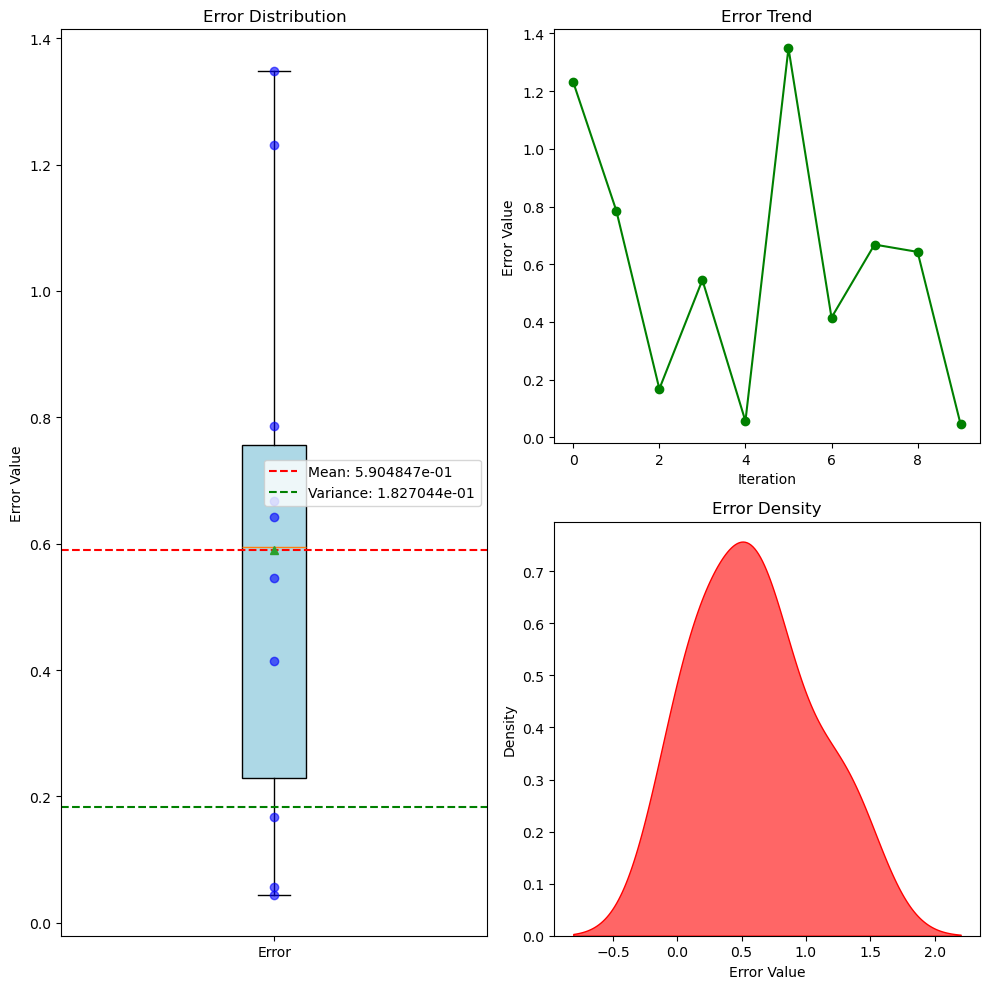

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [10]:
len_t = 101
len_x = 101

# --- 反向过程 (您需要的部分) ---

# 假设您现在只有 X_star, u_star，以及 len_t 和 len_x
# len_t = 101
# len_x = 256

# 1. 从 X_star 中分离出展平的 X 和 T
flat_X = X_star[:, 0]
flat_T = X_star[:, 1]

# 2. 使用 reshape 将它们恢复为原始的二维形状
# np.reshape 的默认顺序是 'C' (行主序)，这与 flatten 的默认行为一致
# 我们知道原始形状是 (len_t, len_x)
X = flat_X.reshape(len_t, len_x)
T = flat_T.reshape(len_t, len_x)

U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


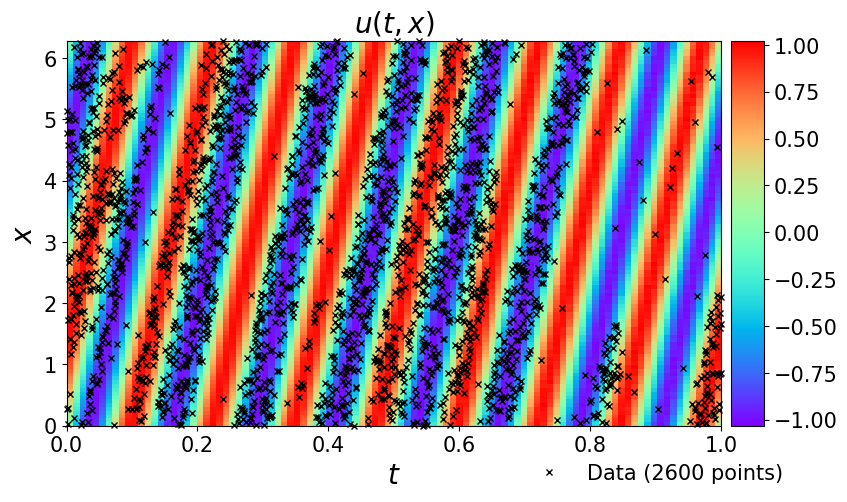

In [11]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是im，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [12]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()


20614


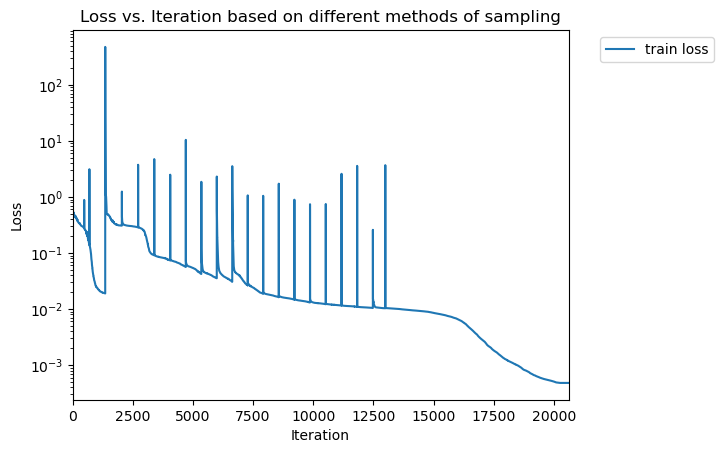

In [13]:
print(len(trainloss))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


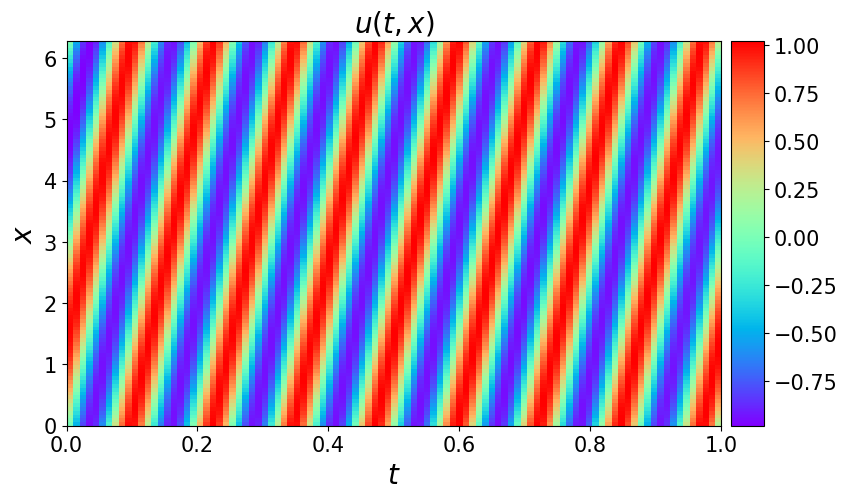

In [14]:
#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

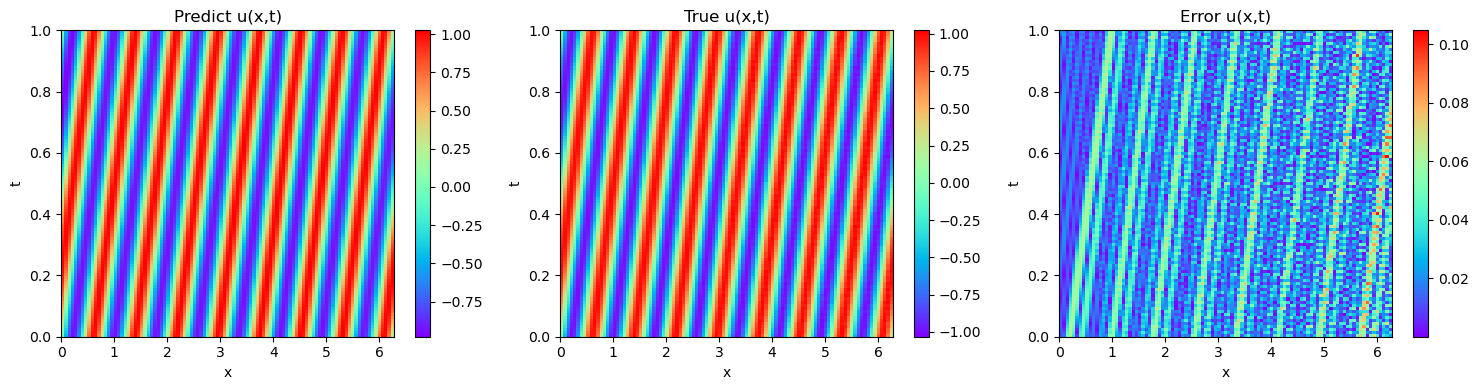

In [15]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [16]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

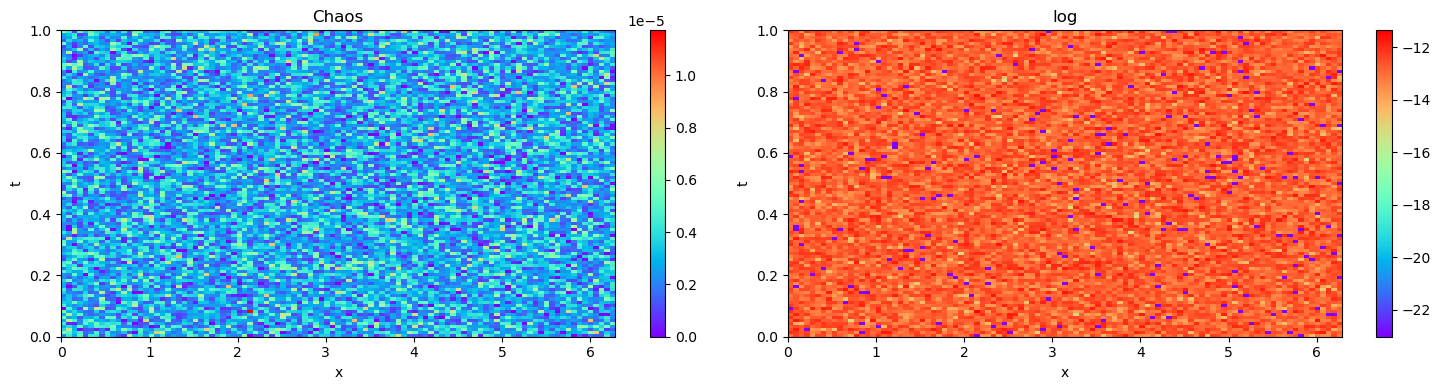

In [17]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()